Import neccessary extensions

In [195]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
import scipy
import scipy.optimize as scpo
from matplotlib.ticker import LinearLocator


Define constants and x values

In [196]:
Iterations = (10**5)
N = 7 #number of sites

n = 0

m = 1
omega = 1
hbar = 1


E = (0.5+n)*hbar*omega

xf = 3
xi = -3

dx = 0.05

Ncor= 10 #int(10*dt)
epsilon = 1 #1.4*np.sqrt(hbar)

alpha = m*omega/hbar
alpha2 = alpha**0.5

xs = np.arange(xi,dx-xi,dx)

xsFine = np.arange(xi,0.01-xi,0.01)
xsFine2 = np.arange(-np.sqrt(2*E)+0.001,np.sqrt(2*E)+0.002,0.01)

#A = (m/(2*np.pi*dt))**(0.5*N)
#print("xs =", xs)

Functions

In [197]:
def firstHarmonic(x):
    return (((alpha/np.pi)**0.5)*(np.exp(-alpha*(x**2)))*(2*alpha2*x**2))

def secondHarmonic(x):
    return (((alpha/np.pi)**0.5)*(np.exp(-alpha*(x**2)))*((2**-1)*(2*alpha2*x**2-1)**2))

def thirdHarmonic(x):
    return (((alpha/np.pi)**0.5)*(np.exp(-alpha*(x**2)))*((3**-1)*(2*(alpha2**1.5)*x**3-3*alpha2**0.5*x)**2))

def tenthHarmonic(x):
    return (((alpha/np.pi)**0.5)*(np.exp(-alpha*(x**2)))*(1/(1024*3628800))*(1024*x**10-23040*x**8+161280*x**6-403200*x**4+302400*x**2-30240)**2)


def wavefunc(x):
    return ((((m*omega)/(np.pi*hbar))**0.5)*(np.exp(-(m*omega)*(x**2)/hbar)))

def classical(x):
        return (omega/(2*np.pi))*(np.sqrt(2*m/(E-potential(x))))

def potential(x):
    return 0.5*m*(omega**2)*(x**2)

def kinetic(v):
    return 0.5*m*(v**2)

def S(path,Ts):
    return (1/hbar) * (Ts/N) * np.sum(
        kinetic((np.diff(path) / (Ts/N))) + potential(0.5 * (path[:-1] + path[1:]))
    )

def S_j(path,i,Ts):
    return (1/hbar) * (Ts/N) * (kinetic((path[i]-path[i-1])/(Ts/N)) + potential(0.5*(path[i]+path[i-1])))

def update_path(path, i, Ts):
    old = path[i]
    a = S_j(path, i, Ts) + S_j(path, i + 1, Ts)
    path[i] += np.random.uniform(-epsilon, epsilon)
    b = S_j(path, i, Ts) + S_j(path, i + 1, Ts)
    action_diff = b - a

    if n == 0:
        if action_diff > 0 and np.random.uniform(0, 1) > np.exp(-action_diff):
            path[i] = old  # Revert if not accepted
            return False
    else:
        if action_diff > 0:
            path[i] = old  # Revert if not accepted
            return False
    #print("accepted")
    return True

#def initialize_classical_path():
 #   t = np.linspace(0, T, N)
  #  return np.sqrt(2*E)*np.sin(t)

def metropolis(Ncf, x, Ts):#Ncf is number of paths that will be saved
    """Generates optimized paths using the Metropolis algorithm."""
    array = np.zeros((Ncf, N))

    
    path = np.ones(N)#initialize_classical_path()


    path[0] = path[-1] = x

    tot = 0
    tot1 = 0

    for _ in range(5*Ncor):  # Thermalization
        for i in range(1, N - 1):
            if update_path(path, i, Ts):
                tot1+=1

    for j in range(Ncf):  # Generate paths
        for _ in range(Ncor):
            for i in range(1, N - 1):
                if update_path(path, i, Ts):
                    tot+=1
        array[j] = path.copy()

    accRate = 100*tot/(Ncf*Ncor*(N-2))
    print(100*tot1/(5*Ncor*(N-2)))
    print("Acceptance rate = {}%".format(accRate))

    return accRate, array

def generateNRandomPaths(numberOfPaths,x):
    array = np.zeros(shape=(numberOfPaths,N))
    for j in range(0,numberOfPaths):
        initialPath = np.random.uniform(-xi,xi,N)
        initialPath[0] = initialPath[-1] = x
        array[j] = initialPath
    return array

def G(paths,Ts):
    """Calculate the sum of the action of all paths."""
    return sum(np.exp(-S(path,Ts)) for path in paths)

metro = True

def Psi(num, Ts1, Ts2, Ts3, Ts4):
    array1 = np.array([G(metropolis(num, x, Ts1)[1],Ts1) for x in xs])

    array2 = np.array([G(metropolis(num, x, Ts2)[1],Ts2) for x in xs])

    array3 = np.array([G(metropolis(num, x, Ts3)[1],Ts3) for x in xs])

    array4 = np.array([G(metropolis(num, x, Ts4)[1],Ts4) for x in xs])

    if n == 0:

        normalization_factor = np.sum(array1) * dx
        return array1/normalization_factor
    
    elif n == 1:

        normalization_factor = (np.sum(array2)-np.sum(array1)) * dx
        return (array2 - array1)/normalization_factor
    
    elif n == 2:

        norm1 = np.abs(-np.sum(array1)+np.sum(array2)) * dx
        norm2 = np.abs(-np.sum(array3)+np.sum(array4)) * dx

        res = np.abs(np.abs(array1 - array2)/norm1 - np.abs(array3 - array4)/norm2)
        return res#(np.abs(array2 - array1)/norm - array3/(np.sum(array3)*dx))/0.1#(norm-np.sum(array3)*dx)
    
    #elif n == 3:

        #norm = np.abs((-np.sum(array1)+np.sum(array2))*dx)
        #norm1 = np.abs((-np.sum(array3)+np.sum(array4))*dx)
        
        #return np.abs(np.abs(array2 - array1)/norm - np.abs(array4 - array3)/norm1)/np.abs(norm1-norm)


def path_error_analysis(paths_list, num_trials, Psi_func):
    results = np.array([[Psi_func(paths) for _ in range(num_trials)] for paths in paths_list])
    std_dev = np.std(results - wavefunc(xs), axis=1)
    return std_dev / np.sqrt(num_trials)

In [198]:
latticeSpacings = np.arange(0,3)

#data = [metropolis(100, x) for x in xs]

#data1 = np.average([item[0] for item in data])
#print("Avg Acceptance rate = {}%".format(data1))
#array1 = [item[1] for item in data]

In [199]:
paths_list = [1,5,10]# Number of paths to test
num_trials = 2 #Number of trials for averaging
#errors = path_error_analysis(paths_list, num_trials, Psi)
#print(repr(errors))

In [200]:
values = ([8.63652542e-06, 9.96603027e-06, 1.37212462e-05, 1.73234191e-05,
       2.44182291e-05, 2.45815598e-05, 3.74163842e-05, 5.03139342e-05,
       7.24204784e-05, 9.09554477e-05, 1.31363823e-04, 1.51972199e-04,
       1.83512884e-04, 2.43275277e-04, 2.74971710e-04, 3.75574025e-04,
       4.92882926e-04, 5.76881614e-04, 8.35499303e-04, 9.90680497e-04,
       1.14143458e-03, 1.44017312e-03, 1.53194007e-03, 1.62467430e-03,
       2.30534472e-03, 2.81047702e-03, 3.89392710e-03, 3.67205094e-03,
       4.19782288e-03, 6.48921489e-03, 5.50233246e-03, 6.46440275e-03,
       8.00841531e-03, 8.61107760e-03, 1.10936407e-02, 1.23286379e-02,
       1.44028435e-02, 1.25220209e-02, 1.86754901e-02, 2.01751644e-02,
       2.23393214e-02, 2.15552076e-02, 2.44773838e-02, 3.04394387e-02,
       2.92465793e-02, 2.77371755e-02, 3.85618364e-02, 4.16678225e-02,
       4.60387165e-02, 3.60135568e-02, 4.82659805e-02, 4.30594098e-02,
       4.70601735e-02, 5.75464812e-02, 4.73384743e-02, 5.40256122e-02,
       5.52644302e-02, 5.18602262e-02, 4.82989526e-02, 6.29882981e-02,
       5.56034117e-02, 5.76782648e-02, 6.54085064e-02, 4.91510929e-02,
       5.05476304e-02, 5.71870849e-02, 6.08889779e-02, 5.19767254e-02,
       5.05255769e-02, 3.56069208e-02, 4.21360396e-02, 4.59143477e-02,
       4.12952173e-02, 4.07037402e-02, 3.43841495e-02, 3.35469416e-02,
       2.85779202e-02, 2.60954115e-02, 2.37035321e-02, 2.28563290e-02,
       2.10033269e-02, 1.84235652e-02, 1.70331709e-02, 1.78797586e-02,
       1.48914079e-02, 1.35284334e-02, 9.23261164e-03, 9.73657216e-03,
       8.15169091e-03, 6.08208267e-03, 5.60703342e-03, 5.55365222e-03,
       3.70847009e-03, 3.86490541e-03, 3.18315530e-03, 2.38087464e-03,
       1.89211546e-03, 1.80006497e-03, 1.49841507e-03, 1.54222308e-03,
       1.11265988e-03, 8.13073896e-04, 5.49885717e-04, 6.23957367e-04,
       5.23813130e-04, 3.53363285e-04, 3.43579879e-04, 2.68831407e-04,
       1.63211654e-04, 1.42085593e-04, 1.02727725e-04, 9.06959670e-05,
       6.38149532e-05, 5.97194177e-05, 3.83145986e-05, 2.89034204e-05,
       2.33696264e-05, 1.88147958e-05, 1.27847985e-05, 1.25470713e-05,
       6.61187082e-06],[4.81430224e-06, 6.84300716e-06, 9.33003144e-06, 1.29811846e-05,
       1.39111103e-05, 1.98244273e-05, 3.01231385e-05, 3.80073046e-05,
       4.39115479e-05, 6.98734720e-05, 7.07672148e-05, 1.04737026e-04,
       1.32926677e-04, 1.61335380e-04, 2.12960286e-04, 3.02842889e-04,
       3.25537007e-04, 4.14671583e-04, 5.43158713e-04, 6.51508465e-04,
       8.18228160e-04, 9.37748786e-04, 1.16179224e-03, 1.44608508e-03,
       1.90078681e-03, 2.02263482e-03, 2.45630986e-03, 3.06766838e-03,
       3.53798119e-03, 3.59492455e-03, 4.13511666e-03, 5.69808659e-03,
       5.59868435e-03, 6.82471762e-03, 8.59476244e-03, 9.73837829e-03,
       1.02591445e-02, 1.27390604e-02, 1.19867108e-02, 1.41908397e-02,
       1.70922551e-02, 1.55244072e-02, 1.79938483e-02, 2.00073389e-02,
       1.92477254e-02, 2.32990925e-02, 2.66636813e-02, 2.52921050e-02,
       2.89244904e-02, 3.32084913e-02, 3.08806333e-02, 3.78622391e-02,
       3.50299551e-02, 3.53755106e-02, 3.67240050e-02, 3.72425233e-02,
       4.71597300e-02, 3.86235698e-02, 3.78518417e-02, 3.79482390e-02,
       3.66022594e-02, 3.69966865e-02, 3.74682815e-02, 4.13373156e-02,
       4.34824405e-02, 3.83864653e-02, 3.66925588e-02, 3.55829828e-02,
       3.39265814e-02, 3.13436424e-02, 3.40030264e-02, 3.22876221e-02,
       2.74918878e-02, 2.76868872e-02, 2.58134354e-02, 2.40149842e-02,
       2.27159972e-02, 1.97452495e-02, 1.93384638e-02, 1.55557574e-02,
       1.44785160e-02, 1.33261050e-02, 1.29506475e-02, 1.08190051e-02,
       9.44617583e-03, 1.07034514e-02, 7.31838014e-03, 6.65142307e-03,
       5.84838128e-03, 5.37990192e-03, 4.17792388e-03, 3.92802778e-03,
       3.67439731e-03, 2.90615133e-03, 2.76122525e-03, 1.62650822e-03,
       1.50027876e-03, 1.45980451e-03, 1.15691155e-03, 9.92965378e-04,
       7.99823998e-04, 6.96147733e-04, 4.89786140e-04, 4.65256894e-04,
       3.18790041e-04, 2.78809751e-04, 2.36122996e-04, 1.71111469e-04,
       1.43376330e-04, 1.11933674e-04, 7.11922109e-05, 6.20065721e-05,
       5.42017398e-05, 3.97692545e-05, 2.66818352e-05, 2.07683737e-05,
       1.65271243e-05, 1.23033929e-05, 9.38094938e-06, 7.99756555e-06,
       4.65938425e-06], [4.79832287e-06, 6.31583391e-06, 8.20228251e-06, 9.43200101e-06,
       1.25927746e-05, 1.69714798e-05, 2.18546151e-05, 3.11672039e-05,
       4.21966260e-05, 5.93569431e-05, 6.48205146e-05, 9.20821322e-05,
       1.06698446e-04, 1.12336143e-04, 1.70883188e-04, 1.90993962e-04,
       2.73069253e-04, 3.24697756e-04, 4.26025977e-04, 5.27483117e-04,
       6.03773353e-04, 8.07455568e-04, 9.04588371e-04, 1.01826921e-03,
       1.30767734e-03, 1.52274498e-03, 2.11269539e-03, 2.19637296e-03,
       2.68397296e-03, 3.01667429e-03, 3.79403709e-03, 3.93998942e-03,
       4.67562729e-03, 4.89657491e-03, 7.58392076e-03, 7.87666452e-03,
       8.75410677e-03, 9.75882950e-03, 8.68847499e-03, 1.20853574e-02,
       1.26444097e-02, 1.27866553e-02, 1.50770458e-02, 1.58710679e-02,
       1.69036958e-02, 2.09349024e-02, 2.02541459e-02, 2.18594842e-02,
       2.23629117e-02, 2.50270156e-02, 2.53014221e-02, 2.61041595e-02,
       2.58787772e-02, 3.03030095e-02, 2.98039684e-02, 3.01241733e-02,
       3.42449285e-02, 3.30019122e-02, 3.38871786e-02, 3.49962632e-02,
       3.25442106e-02, 3.43647600e-02, 3.03945823e-02, 3.37417534e-02,
       3.46425618e-02, 3.18002886e-02, 3.01053134e-02, 3.08004425e-02,
       2.67380855e-02, 2.35814043e-02, 2.41756180e-02, 2.67176707e-02,
       2.66600440e-02, 2.13295224e-02, 2.10431021e-02, 1.85766834e-02,
       2.02321588e-02, 1.60918857e-02, 1.51958349e-02, 1.23011788e-02,
       1.37677603e-02, 1.11372401e-02, 9.52676312e-03, 9.46549090e-03,
       7.88837695e-03, 6.65259343e-03, 6.15751095e-03, 5.51980269e-03,
       4.79969791e-03, 3.79282265e-03, 3.23609832e-03, 3.37682707e-03,
       2.92510354e-03, 2.10291540e-03, 1.97506179e-03, 1.61260477e-03,
       1.42506535e-03, 1.11983401e-03, 9.73791571e-04, 8.81681716e-04,
       6.02025209e-04, 5.35075046e-04, 4.13041822e-04, 3.40522679e-04,
       2.74595290e-04, 2.18565728e-04, 1.81966607e-04, 1.45338289e-04,
       1.07176354e-04, 8.03860249e-05, 6.24367140e-05, 5.69453442e-05,
       3.93002582e-05, 2.98463837e-05, 2.55336250e-05, 1.83623806e-05,
       1.48325758e-05, 1.00735852e-05, 7.02154435e-06, 6.40675645e-06,
       4.36657971e-06],[3.60496994e-06, 6.07421568e-06, 7.62328124e-06, 8.32214739e-06,
       1.22661903e-05, 1.65987993e-05, 1.93667351e-05, 3.16820404e-05,
       3.27245343e-05, 4.48453859e-05, 6.74692968e-05, 6.95319089e-05,
       9.27575572e-05, 1.06611729e-04, 1.60256520e-04, 1.72883291e-04,
       2.53423251e-04, 2.88255151e-04, 3.64738895e-04, 4.15714217e-04,
       5.94837120e-04, 6.17257168e-04, 9.12429393e-04, 9.98147055e-04,
       1.22471961e-03, 1.46397087e-03, 1.81529458e-03, 2.19234659e-03,
       2.57994653e-03, 3.14325173e-03, 3.20759550e-03, 3.46018435e-03,
       4.01715537e-03, 4.03971250e-03, 5.05533155e-03, 6.01435564e-03,
       6.59993664e-03, 7.62590784e-03, 8.79099244e-03, 9.00483812e-03,
       1.09453270e-02, 1.37903023e-02, 1.34615540e-02, 1.46887641e-02,
       1.74079483e-02, 1.76289860e-02, 1.79488180e-02, 1.89514732e-02,
       1.94265481e-02, 2.24476433e-02, 2.53837422e-02, 2.64063125e-02,
       2.62428317e-02, 2.69583343e-02, 2.99780600e-02, 2.58229416e-02,
       3.01178839e-02, 2.51635415e-02, 2.61238740e-02, 3.07666024e-02,
       3.31764354e-02, 2.53639088e-02, 3.08487215e-02, 2.96326065e-02,
       3.01582283e-02, 2.69475560e-02, 2.81026945e-02, 2.91251949e-02,
       2.50611022e-02, 2.53122396e-02, 2.33971470e-02, 2.36276538e-02,
       1.96702256e-02, 1.77411034e-02, 1.70431080e-02, 1.64886493e-02,
       1.66079506e-02, 1.65884849e-02, 1.34083764e-02, 1.32700949e-02,
       9.87321675e-03, 1.05327394e-02, 8.72068721e-03, 8.95582837e-03,
       7.05044506e-03, 6.10532718e-03, 5.17143271e-03, 4.72211432e-03,
       4.21624840e-03, 3.89941843e-03, 3.13645174e-03, 2.79440653e-03,
       2.71867826e-03, 2.27827474e-03, 1.76902447e-03, 1.30527435e-03,
       1.03809363e-03, 1.04291285e-03, 7.98971720e-04, 6.82940807e-04,
       5.38488156e-04, 4.32178586e-04, 3.66261111e-04, 2.75747971e-04,
       2.30458315e-04, 1.96760870e-04, 1.60646734e-04, 1.37646914e-04,
       1.07703676e-04, 8.11540266e-05, 5.76386943e-05, 4.23284081e-05,
       4.24394039e-05, 2.67027556e-05, 2.01614484e-05, 1.42892116e-05,
       1.18394260e-05, 8.09091844e-06, 6.64152782e-06, 5.14865656e-06,
       3.99305917e-06],[3.27643893e-06, 4.21256239e-06, 5.72944145e-06, 7.36019800e-06,
       1.03810276e-05, 1.32824060e-05, 1.93978592e-05, 2.52123093e-05,
       3.25848845e-05, 4.31282429e-05, 4.99228531e-05, 7.65431462e-05,
       8.71979854e-05, 1.17145383e-04, 1.44391310e-04, 1.64253007e-04,
       2.24198882e-04, 2.61501339e-04, 3.13817143e-04, 3.97902869e-04,
       4.72009452e-04, 5.37843994e-04, 8.01025000e-04, 8.34348651e-04,
       1.06734894e-03, 1.28109870e-03, 1.34532439e-03, 1.92362588e-03,
       2.08978892e-03, 2.70993145e-03, 2.51144648e-03, 3.50433832e-03,
       4.08851017e-03, 4.25390564e-03, 5.22220625e-03, 5.56740069e-03,
       6.79856160e-03, 7.01660025e-03, 7.82692976e-03, 1.04026458e-02,
       1.05831419e-02, 1.02602408e-02, 1.16694258e-02, 1.27012746e-02,
       1.58071586e-02, 1.25632050e-02, 1.84476433e-02, 2.23464304e-02,
       1.85426866e-02, 1.90591951e-02, 2.29110903e-02, 1.97993158e-02,
       2.34209997e-02, 1.97103232e-02, 2.74607189e-02, 2.56180046e-02,
       2.50073028e-02, 2.11991813e-02, 2.70615939e-02, 2.19815032e-02,
       3.02024658e-02, 2.30189024e-02, 2.30725281e-02, 2.50315854e-02,
       2.42531744e-02, 2.72551650e-02, 2.57094553e-02, 2.09854790e-02,
       2.11077687e-02, 2.49172896e-02, 2.40985147e-02, 2.09809314e-02,
       1.85779638e-02, 1.59095850e-02, 1.67958593e-02, 1.69556707e-02,
       1.27393994e-02, 1.25314977e-02, 1.27795074e-02, 1.07947560e-02,
       1.01624554e-02, 9.68781861e-03, 8.14500862e-03, 7.06286529e-03,
       6.98252221e-03, 5.47570542e-03, 5.61954766e-03, 4.09098622e-03,
       4.24182636e-03, 3.28509961e-03, 2.64459018e-03, 2.25787545e-03,
       2.16332077e-03, 1.82717442e-03, 1.24513404e-03, 1.45654121e-03,
       1.13554134e-03, 9.81595791e-04, 8.04568858e-04, 5.61984222e-04,
       5.28191666e-04, 3.95896534e-04, 3.30898223e-04, 2.73452271e-04,
       2.41559720e-04, 1.93857317e-04, 1.28324282e-04, 1.26845612e-04,
       9.34013578e-05, 6.65678471e-05, 5.38415129e-05, 3.93724114e-05,
       2.87474167e-05, 2.85700509e-05, 1.73908772e-05, 1.28123379e-05,
       1.07374426e-05, 8.17084137e-06, 6.07698825e-06, 4.59700547e-06,
       3.20462021e-06],[3.14842871e-06, 4.36357179e-06, 5.87552352e-06, 7.55652712e-06,
       9.63881895e-06, 1.27622680e-05, 1.66224448e-05, 2.04673524e-05,
       2.50374644e-05, 3.54837911e-05, 4.80742451e-05, 5.82210407e-05,
       8.75315569e-05, 9.37887931e-05, 1.32248937e-04, 1.72280116e-04,
       1.81791836e-04, 2.52296991e-04, 2.98208830e-04, 3.46226001e-04,
       4.85259685e-04, 6.24703669e-04, 6.51273315e-04, 8.80195124e-04,
       9.13137761e-04, 1.34448099e-03, 1.33512515e-03, 1.67895647e-03,
       1.92995071e-03, 2.12330997e-03, 2.49765431e-03, 3.11230197e-03,
       3.36855027e-03, 3.77481888e-03, 4.62757017e-03, 5.40030676e-03,
       5.66587185e-03, 6.27860885e-03, 7.45375229e-03, 7.57617800e-03,
       7.24833434e-03, 9.77858373e-03, 1.01397704e-02, 1.16007916e-02,
       1.24206948e-02, 1.55700181e-02, 1.48423922e-02, 1.52465228e-02,
       1.64090657e-02, 1.75440031e-02, 1.85635103e-02, 2.15251704e-02,
       1.76889549e-02, 1.90209833e-02, 2.10749430e-02, 2.12709607e-02,
       2.22810228e-02, 2.64228864e-02, 2.58101069e-02, 1.91680509e-02,
       2.28358450e-02, 2.35850488e-02, 2.39787224e-02, 2.21467520e-02,
       2.03896942e-02, 1.94140940e-02, 2.11065378e-02, 2.15656659e-02,
       2.06844622e-02, 2.04801168e-02, 1.81112092e-02, 1.55953026e-02,
       1.70745668e-02, 1.72312189e-02, 1.33964381e-02, 1.38706496e-02,
       1.30827283e-02, 1.22576365e-02, 1.14783995e-02, 1.02881403e-02,
       8.13208720e-03, 8.29935875e-03, 6.82496752e-03, 6.07120482e-03,
       5.69155135e-03, 5.15787413e-03, 4.59468804e-03, 3.51069651e-03,
       3.44856779e-03, 3.26012708e-03, 2.53598763e-03, 2.12070588e-03,
       1.88332705e-03, 1.74574936e-03, 1.37005217e-03, 1.04892230e-03,
       1.05518353e-03, 8.07586551e-04, 6.99934837e-04, 5.38237100e-04,
       4.41921580e-04, 3.24367099e-04, 3.20547773e-04, 2.58455162e-04,
       1.82805010e-04, 1.53661708e-04, 1.20338893e-04, 9.89995509e-05,
       7.39973882e-05, 6.38915613e-05, 4.92835327e-05, 3.62699583e-05,
       3.20063388e-05, 2.09443378e-05, 1.83526363e-05, 1.31798429e-05,
       9.21401309e-06, 6.61802165e-06, 6.25571098e-06, 3.77335645e-06,
       2.65810928e-06],[3.21852409e-06, 3.74173738e-06, 5.16595180e-06, 5.96478231e-06,
       8.94361284e-06, 1.22808525e-05, 1.39316136e-05, 1.91121030e-05,
       2.73006061e-05, 3.43675581e-05, 4.59040371e-05, 5.08001686e-05,
       7.76262324e-05, 9.23634047e-05, 1.07898426e-04, 1.44755458e-04,
       1.99339868e-04, 1.98683570e-04, 2.53556410e-04, 3.72210477e-04,
       4.00283876e-04, 5.47195116e-04, 6.08823901e-04, 7.84038171e-04,
       8.52906211e-04, 1.05736382e-03, 1.10380644e-03, 1.50156157e-03,
       1.98057683e-03, 2.32485766e-03, 2.84264239e-03, 2.96883715e-03,
       3.01878155e-03, 3.74447737e-03, 3.95467634e-03, 5.00659441e-03,
       4.60060132e-03, 6.36137828e-03, 6.41590015e-03, 6.54159316e-03,
       8.57860421e-03, 9.82543236e-03, 9.27874605e-03, 1.09187867e-02,
       1.23719472e-02, 1.21817742e-02, 1.41943606e-02, 1.49437652e-02,
       1.50633817e-02, 1.59505963e-02, 1.91807181e-02, 1.72955400e-02,
       1.84690960e-02, 1.96493021e-02, 1.82450690e-02, 1.89796232e-02,
       2.17500749e-02, 2.25810684e-02, 2.22754760e-02, 2.23963654e-02,
       2.02699897e-02, 2.23704863e-02, 2.08315898e-02, 2.01597398e-02,
       2.01323436e-02, 1.97271542e-02, 2.12062040e-02, 2.08646315e-02,
       1.87429676e-02, 1.81523025e-02, 1.80590714e-02, 1.61688083e-02,
       1.67084468e-02, 1.48848976e-02, 1.33840659e-02, 1.44351733e-02,
       1.09881189e-02, 1.03242977e-02, 9.08893698e-03, 9.40427600e-03,
       7.75574245e-03, 7.28627620e-03, 6.43050808e-03, 5.58877897e-03,
       4.78946588e-03, 4.44198111e-03, 3.92308711e-03, 3.62627930e-03,
       2.99261619e-03, 2.61881882e-03, 2.43705966e-03, 2.15939409e-03,
       1.71271334e-03, 1.45239477e-03, 1.27457701e-03, 1.06984901e-03,
       7.99319286e-04, 7.88946846e-04, 6.12104528e-04, 5.82640213e-04,
       4.54741128e-04, 3.08945525e-04, 2.82406285e-04, 2.39130609e-04,
       1.86859390e-04, 1.40210776e-04, 1.16272967e-04, 9.31648743e-05,
       7.16128081e-05, 4.89069593e-05, 4.65175669e-05, 3.14756464e-05,
       2.68228085e-05, 1.67868734e-05, 1.62972880e-05, 1.12640740e-05,
       8.80195146e-06, 5.86758049e-06, 5.41827132e-06, 4.29409685e-06,
       2.57387467e-06],[2.72374382e-06, 3.20124215e-06, 4.81523340e-06, 6.96860020e-06,
       8.47364426e-06, 1.17748832e-05, 1.74126400e-05, 1.90053451e-05,
       2.30557047e-05, 3.39518263e-05, 3.88629863e-05, 5.20846536e-05,
       6.18566636e-05, 8.58622301e-05, 1.04456259e-04, 1.38228940e-04,
       1.55120700e-04, 2.15081463e-04, 2.69115938e-04, 3.10059741e-04,
       4.14670191e-04, 5.13887067e-04, 6.17994988e-04, 7.69385454e-04,
       8.18940960e-04, 8.73058804e-04, 1.08880626e-03, 1.48396063e-03,
       1.86954706e-03, 2.16119700e-03, 2.16816851e-03, 2.64505574e-03,
       3.01589013e-03, 3.68292345e-03, 3.59446090e-03, 3.87712685e-03,
       4.50995854e-03, 5.37221453e-03, 5.53499570e-03, 6.78967894e-03,
       6.94729663e-03, 7.59078575e-03, 1.01368429e-02, 1.14318337e-02,
       9.51500158e-03, 1.12442086e-02, 1.19068175e-02, 1.40471609e-02,
       1.38571586e-02, 1.54713780e-02, 1.42865291e-02, 1.52071874e-02,
       1.61254912e-02, 1.85691476e-02, 1.98706850e-02, 1.95919925e-02,
       2.23610068e-02, 1.77315520e-02, 2.24433843e-02, 2.16861463e-02,
       2.00745579e-02, 2.00109253e-02, 2.20025859e-02, 1.97528099e-02,
       1.90126793e-02, 2.00742296e-02, 1.98382570e-02, 2.15147122e-02,
       1.86705191e-02, 1.62133657e-02, 1.47835136e-02, 1.63827009e-02,
       1.34804525e-02, 1.16096698e-02, 1.27362910e-02, 1.30302457e-02,
       1.18722144e-02, 1.03443168e-02, 9.41049270e-03, 8.78859144e-03,
       8.62212585e-03, 6.42344786e-03, 6.40050584e-03, 6.00547207e-03,
       5.13604205e-03, 4.04042352e-03, 3.93834916e-03, 3.24052005e-03,
       2.64341818e-03, 3.06467150e-03, 2.13579079e-03, 2.30697107e-03,
       1.44603704e-03, 1.36260845e-03, 1.10098992e-03, 1.05184983e-03,
       8.21649252e-04, 6.92471202e-04, 5.63523028e-04, 4.85174130e-04,
       3.85087792e-04, 3.22376747e-04, 2.98558897e-04, 1.80092615e-04,
       1.84721342e-04, 1.30379346e-04, 1.01400792e-04, 9.74443667e-05,
       7.42147908e-05, 5.35182486e-05, 4.37955212e-05, 3.73936811e-05,
       2.25007635e-05, 1.97948525e-05, 1.61151174e-05, 9.89136485e-06,
       8.32335034e-06, 6.52010566e-06, 4.26614503e-06, 3.25785677e-06,
       2.81807666e-06],[2.67022908e-06, 2.76219998e-06, 4.67617218e-06, 5.55123166e-06,
       8.67912616e-06, 1.07349426e-05, 1.31035427e-05, 1.81827944e-05,
       2.28562137e-05, 3.10499297e-05, 4.04244350e-05, 5.10873700e-05,
       6.49800639e-05, 7.91974127e-05, 9.83868788e-05, 1.35380531e-04,
       1.69041402e-04, 2.05140231e-04, 2.18171756e-04, 2.97919110e-04,
       4.15275462e-04, 4.61193652e-04, 5.09671044e-04, 6.18963152e-04,
       8.11460894e-04, 9.29803935e-04, 1.18373697e-03, 1.31097505e-03,
       1.47135173e-03, 1.58619056e-03, 2.11137806e-03, 2.34064053e-03,
       2.67502200e-03, 3.47590549e-03, 3.86338672e-03, 4.19523015e-03,
       5.20729489e-03, 4.83645954e-03, 6.06163631e-03, 6.78923945e-03,
       7.33314950e-03, 8.26941677e-03, 9.47582928e-03, 8.83197626e-03,
       9.94466621e-03, 1.27899588e-02, 1.21953843e-02, 1.34457176e-02,
       1.25148111e-02, 1.56970353e-02, 1.84615056e-02, 1.56242346e-02,
       1.91275657e-02, 1.61786726e-02, 1.87869023e-02, 2.01480175e-02,
       1.80854430e-02, 2.08494367e-02, 2.05822679e-02, 2.05512046e-02,
       1.85656517e-02, 1.88640535e-02, 1.72751205e-02, 1.93416650e-02,
       1.79402670e-02, 1.81247491e-02, 1.69467900e-02, 1.69231589e-02,
       1.73831796e-02, 1.70539787e-02, 1.46581839e-02, 1.47814049e-02,
       1.28877338e-02, 1.29468031e-02, 1.18007987e-02, 1.04968532e-02,
       1.02989680e-02, 1.01148594e-02, 8.71105016e-03, 7.76673406e-03,
       7.14245510e-03, 6.34311177e-03, 4.93732756e-03, 5.16581492e-03,
       5.13850951e-03, 4.01590961e-03, 3.87863276e-03, 3.13606999e-03,
       2.97732049e-03, 2.31307080e-03, 2.07621117e-03, 1.79907065e-03,
       1.37343179e-03, 1.38299160e-03, 1.17453527e-03, 9.29283877e-04,
       7.90287435e-04, 5.62349219e-04, 5.75497468e-04, 4.28542259e-04,
       3.61584383e-04, 2.75806908e-04, 2.68095609e-04, 1.92602575e-04,
       1.51505438e-04, 1.37372340e-04, 8.64349812e-05, 7.67269799e-05,
       6.40381509e-05, 4.72162406e-05, 3.84898499e-05, 2.65203028e-05,
       2.49488505e-05, 1.75846483e-05, 1.47553833e-05, 1.07522851e-05,
       8.58683200e-06, 6.78758347e-06, 4.73687292e-06, 2.78093313e-06,
       2.62124678e-06],[2.12258563e-06, 3.01043017e-06, 4.47958769e-06, 6.33120050e-06,
       7.12020527e-06, 9.14247274e-06, 1.38418032e-05, 1.67617636e-05,
       2.17145220e-05, 2.97887742e-05, 3.77782403e-05, 4.55799977e-05,
       6.28038651e-05, 7.65764657e-05, 8.82341301e-05, 1.18592258e-04,
       1.48726953e-04, 1.83590811e-04, 2.24750447e-04, 2.87741375e-04,
       3.42705805e-04, 4.67300902e-04, 5.24478776e-04, 6.51246952e-04,
       8.04462950e-04, 9.22008726e-04, 1.00801361e-03, 1.29754061e-03,
       1.48394572e-03, 1.64927502e-03, 2.02817029e-03, 2.52629242e-03,
       2.37567515e-03, 2.98752537e-03, 3.71109425e-03, 4.32838487e-03,
       4.10373873e-03, 4.34863558e-03, 5.81168855e-03, 5.74692866e-03,
       7.00465855e-03, 7.46835152e-03, 8.60456744e-03, 9.45768633e-03,
       1.03922470e-02, 1.01311181e-02, 1.05635280e-02, 1.13250657e-02,
       1.22857029e-02, 1.38684670e-02, 1.51978241e-02, 1.35067146e-02,
       1.43300858e-02, 1.40365639e-02, 1.57139127e-02, 1.55567474e-02,
       1.84113608e-02, 1.86621933e-02, 1.66761788e-02, 1.69880439e-02,
       1.97628608e-02, 1.70102438e-02, 1.59060603e-02, 1.68434026e-02,
       1.77868718e-02, 1.88353784e-02, 1.87051106e-02, 1.78249653e-02,
       1.69653242e-02, 1.48532785e-02, 1.46213471e-02, 1.49867269e-02,
       1.38825454e-02, 1.13505421e-02, 1.00544020e-02, 9.40747500e-03,
       9.75864799e-03, 9.86813173e-03, 8.20810925e-03, 7.54648661e-03,
       7.18729226e-03, 6.64386699e-03, 5.43449318e-03, 4.35180369e-03,
       4.72667934e-03, 4.09024499e-03, 3.25971937e-03, 3.37107080e-03,
       2.80691433e-03, 2.37683712e-03, 2.01010522e-03, 1.79410274e-03,
       1.72875317e-03, 1.00783881e-03, 1.08914732e-03, 9.19315855e-04,
       8.00356512e-04, 6.55685880e-04, 4.79274585e-04, 3.65734716e-04,
       3.27498446e-04, 2.71077016e-04, 1.89246260e-04, 2.02998648e-04,
       1.45411698e-04, 1.10431166e-04, 9.54678035e-05, 7.03477592e-05,
       6.12109210e-05, 5.09273435e-05, 3.36141039e-05, 3.11044270e-05,
       1.99440632e-05, 1.72066104e-05, 1.39649167e-05, 1.04604496e-05,
       6.83178430e-06, 5.45618211e-06, 4.28453053e-06, 3.72398746e-06,
       2.52827738e-06],[2.02141473e-06, 3.59246099e-06, 3.54508795e-06, 5.27493734e-06,
       8.40823968e-06, 9.09985991e-06, 1.27009685e-05, 1.34755351e-05,
       2.16759672e-05, 2.49918803e-05, 3.46786003e-05, 4.01843059e-05,
       6.65970585e-05, 8.43754721e-05, 1.17747676e-04, 1.11057708e-04,
       1.38246667e-04, 1.73360921e-04, 2.14110376e-04, 3.01084812e-04,
       3.17377807e-04, 3.59276396e-04, 4.56919349e-04, 5.34026227e-04,
       7.07416836e-04, 8.95083594e-04, 1.01733267e-03, 1.42570980e-03,
       1.50673139e-03, 1.39096705e-03, 1.90546373e-03, 2.28864526e-03,
       2.30360630e-03, 2.64167723e-03, 3.45567264e-03, 3.61700434e-03,
       4.31770756e-03, 4.83724022e-03, 5.74079159e-03, 6.26713554e-03,
       6.39272753e-03, 8.01659699e-03, 8.39876894e-03, 8.53271281e-03,
       9.96737796e-03, 1.00335144e-02, 1.07240220e-02, 1.20444407e-02,
       1.22311746e-02, 1.42401096e-02, 1.34662252e-02, 1.37051943e-02,
       1.57878985e-02, 1.60323875e-02, 1.58733508e-02, 1.78090508e-02,
       1.59541812e-02, 1.57830704e-02, 1.59331591e-02, 1.89612941e-02,
       1.74005421e-02, 1.66569174e-02, 1.80744069e-02, 1.74715181e-02,
       1.69398591e-02, 1.72405801e-02, 1.69859570e-02, 1.51787703e-02,
       1.35881492e-02, 1.16751395e-02, 1.29477359e-02, 1.21091728e-02,
       1.17822283e-02, 1.17601992e-02, 1.01389353e-02, 1.06801125e-02,
       9.15689620e-03, 9.41816105e-03, 7.96566401e-03, 7.47916613e-03,
       6.68102363e-03, 6.83292021e-03, 4.53997063e-03, 5.00905973e-03,
       3.96032228e-03, 4.01229645e-03, 3.17739795e-03, 3.03183464e-03,
       2.45508911e-03, 2.03593376e-03, 1.87065270e-03, 1.57616794e-03,
       1.43013053e-03, 1.23752525e-03, 1.04338401e-03, 8.56998056e-04,
       7.18827689e-04, 6.03800275e-04, 5.57691214e-04, 4.00322820e-04,
       2.84575053e-04, 2.84306559e-04, 2.22316690e-04, 1.85024057e-04,
       1.48628768e-04, 1.18407529e-04, 9.20913464e-05, 7.03327873e-05,
       5.68742623e-05, 5.07648100e-05, 3.85285596e-05, 2.40554892e-05,
       2.39874955e-05, 1.56346858e-05, 1.39638323e-05, 1.04290495e-05,
       7.20739938e-06, 6.17573519e-06, 4.01513524e-06, 3.31338312e-06,
       2.70304432e-06],[2.42179001e-06, 2.71413577e-06, 3.79285349e-06, 4.88616287e-06,
       6.99805242e-06, 9.44633302e-06, 1.09413160e-05, 1.69269565e-05,
       2.08211386e-05, 2.83573438e-05, 3.55424206e-05, 4.89677706e-05,
       4.17609378e-05, 6.76327656e-05, 9.45108147e-05, 1.07914872e-04,
       1.37742277e-04, 1.70858368e-04, 1.95383392e-04, 2.76374547e-04,
       3.40539189e-04, 3.82268078e-04, 4.70775414e-04, 6.46819130e-04,
       6.48019794e-04, 7.65852119e-04, 9.35515799e-04, 1.21676728e-03,
       1.33273812e-03, 1.54701732e-03, 1.90159446e-03, 2.16288238e-03,
       2.60686405e-03, 2.60018038e-03, 2.98941539e-03, 3.03712768e-03,
       4.00641125e-03, 4.35674606e-03, 5.03925924e-03, 6.02975224e-03,
       6.27228328e-03, 6.97216042e-03, 7.37366753e-03, 6.81570093e-03,
       8.64600139e-03, 8.23157030e-03, 1.09582017e-02, 1.06389739e-02,
       1.12086005e-02, 1.25181220e-02, 1.23894312e-02, 1.31312073e-02,
       1.43181169e-02, 1.52350987e-02, 1.55729891e-02, 1.63534678e-02,
       1.60318204e-02, 1.41950715e-02, 1.73389725e-02, 1.57925762e-02,
       1.65991492e-02, 1.66550687e-02, 1.68666124e-02, 1.41595554e-02,
       1.68500817e-02, 1.50144830e-02, 1.56785822e-02, 1.42660714e-02,
       1.49549478e-02, 1.49824616e-02, 1.28534258e-02, 1.16724262e-02,
       1.05435779e-02, 9.55751198e-03, 1.04794717e-02, 9.70837315e-03,
       7.99865169e-03, 7.73252182e-03, 7.97406875e-03, 6.37004458e-03,
       6.18903957e-03, 5.53112546e-03, 4.68087765e-03, 4.57036296e-03,
       3.61909642e-03, 3.64918910e-03, 2.80955691e-03, 2.68741206e-03,
       2.25259459e-03, 2.43716218e-03, 1.70374471e-03, 1.50109001e-03,
       1.14764767e-03, 1.08263119e-03, 9.57253409e-04, 8.34366193e-04,
       6.66295803e-04, 5.67807232e-04, 4.37829089e-04, 3.78202273e-04,
       3.10244920e-04, 2.59295367e-04, 2.08547668e-04, 1.54889868e-04,
       1.38664310e-04, 1.14769555e-04, 8.01391380e-05, 7.08542722e-05,
       5.54496924e-05, 3.92827247e-05, 3.05105734e-05, 2.71329741e-05,
       1.90153733e-05, 1.48425895e-05, 1.36221613e-05, 9.53516126e-06,
       7.48470193e-06, 5.16676753e-06, 3.95391005e-06, 3.24453558e-06,
       1.95896029e-06],[2.07939642e-06, 2.67901601e-06, 3.93566546e-06, 4.96486824e-06,
       5.59175479e-06, 8.93834882e-06, 1.19455621e-05, 1.72102440e-05,
       2.33283623e-05, 2.27396035e-05, 3.26178294e-05, 4.56018087e-05,
       5.27580194e-05, 6.54822831e-05, 8.24229022e-05, 1.11112351e-04,
       1.29550315e-04, 1.90748019e-04, 2.18602254e-04, 2.48337087e-04,
       3.00056402e-04, 3.86975064e-04, 4.19720466e-04, 4.85956299e-04,
       6.74863941e-04, 7.46336343e-04, 9.50477059e-04, 1.10389397e-03,
       1.12572516e-03, 1.61134143e-03, 1.69306847e-03, 2.34549122e-03,
       2.33758462e-03, 2.58153842e-03, 2.82833459e-03, 3.66416355e-03,
       3.70844147e-03, 3.47620624e-03, 4.57365515e-03, 6.03853392e-03,
       6.27462669e-03, 6.09080564e-03, 6.72862855e-03, 7.77370896e-03,
       9.18721883e-03, 9.09386570e-03, 9.30689221e-03, 1.08299676e-02,
       1.23852002e-02, 1.16175890e-02, 1.25926385e-02, 1.26449524e-02,
       1.46213015e-02, 1.45266078e-02, 1.39638423e-02, 1.62659698e-02,
       1.50195842e-02, 1.38782321e-02, 1.48785254e-02, 1.45294592e-02,
       1.58416973e-02, 1.54823556e-02, 1.63118383e-02, 1.81243571e-02,
       1.56683477e-02, 1.61556726e-02, 1.53590621e-02, 1.51596027e-02,
       1.38332977e-02, 1.19530743e-02, 1.33076418e-02, 1.12029149e-02,
       1.17292215e-02, 1.05322809e-02, 1.05025121e-02, 8.82692865e-03,
       9.10065429e-03, 8.31206445e-03, 7.67719752e-03, 6.26339082e-03,
       6.11442093e-03, 5.10193348e-03, 5.08349775e-03, 4.08987958e-03,
       4.08335965e-03, 3.35076519e-03, 3.11205029e-03, 2.32852424e-03,
       2.48866325e-03, 2.09873325e-03, 1.71054401e-03, 1.49629860e-03,
       1.27407632e-03, 1.05783560e-03, 9.39119529e-04, 7.93814752e-04,
       6.54675555e-04, 5.86611111e-04, 4.23695405e-04, 3.47456060e-04,
       3.53623040e-04, 2.44707590e-04, 1.92508617e-04, 1.59267924e-04,
       1.48372351e-04, 1.06601003e-04, 7.87416231e-05, 5.82215727e-05,
       5.13213498e-05, 4.51546758e-05, 3.37551883e-05, 2.48302706e-05,
       1.91976478e-05, 1.59222640e-05, 1.21039228e-05, 8.91597371e-06,
       5.99746812e-06, 4.77942422e-06, 3.68701945e-06, 3.17864396e-06,
       1.89839789e-06],[2.07481388e-06, 2.55047413e-06, 3.63243358e-06, 4.41724194e-06,
       6.11419776e-06, 9.07318195e-06, 1.29433604e-05, 1.42946054e-05,
       1.95471667e-05, 2.14823424e-05, 3.10048428e-05, 3.82635884e-05,
       4.90913211e-05, 6.34286823e-05, 7.60765106e-05, 9.36025716e-05,
       1.11196818e-04, 1.63273911e-04, 1.85629339e-04, 2.22617539e-04,
       3.13652573e-04, 3.53851366e-04, 4.37329470e-04, 5.14488654e-04,
       6.52905410e-04, 6.95581514e-04, 7.85780044e-04, 1.11409518e-03,
       1.25919010e-03, 1.52826164e-03, 1.59433460e-03, 1.76895325e-03,
       2.40013368e-03, 2.52565146e-03, 2.94183677e-03, 3.48189233e-03,
       3.79064874e-03, 4.32629735e-03, 5.07069104e-03, 5.54981806e-03,
       5.97110205e-03, 7.02074389e-03, 7.19886737e-03, 7.13927534e-03,
       7.77729648e-03, 8.74554128e-03, 9.83863104e-03, 1.01444849e-02,
       1.05804610e-02, 1.21240642e-02, 1.17400297e-02, 1.24414522e-02,
       1.22820075e-02, 1.35662335e-02, 1.33854277e-02, 1.58866314e-02,
       1.45505275e-02, 1.72778980e-02, 1.69629780e-02, 1.69592971e-02,
       1.49271393e-02, 1.34154383e-02, 1.59394417e-02, 1.38968320e-02,
       1.54616978e-02, 1.46493405e-02, 1.27355186e-02, 1.50520862e-02,
       1.31091600e-02, 1.27334184e-02, 1.34657186e-02, 1.22635149e-02,
       1.05889719e-02, 1.02764594e-02, 9.07833568e-03, 8.95706033e-03,
       8.60290767e-03, 7.63321617e-03, 6.63231817e-03, 6.54369948e-03,
       5.25729643e-03, 5.39880399e-03, 4.91006706e-03, 4.35378504e-03,
       3.69665758e-03, 3.22405623e-03, 2.74975054e-03, 2.59068635e-03,
       2.11100178e-03, 2.00768028e-03, 1.67563999e-03, 1.36259244e-03,
       1.22865491e-03, 9.52200720e-04, 8.89002569e-04, 7.86572171e-04,
       6.47461466e-04, 4.13951069e-04, 5.09586950e-04, 3.62064229e-04,
       2.80443141e-04, 2.45034014e-04, 1.98245866e-04, 1.58771582e-04,
       1.26910159e-04, 8.62018524e-05, 7.86793410e-05, 6.17677066e-05,
       5.44439582e-05, 4.83833178e-05, 3.43263976e-05, 2.31252596e-05,
       1.86335776e-05, 1.38506727e-05, 1.08071768e-05, 8.91853085e-06,
       6.85089549e-06, 4.86917615e-06, 3.44216372e-06, 2.36606462e-06,
       1.76734983e-06],[2.09079040e-06, 2.65367971e-06, 3.94201912e-06, 3.81356179e-06,
       6.95076623e-06, 7.64175147e-06, 1.12211829e-05, 1.38850950e-05,
       1.71606142e-05, 2.24667160e-05, 2.83438126e-05, 4.39762362e-05,
       5.29823748e-05, 6.19599219e-05, 7.37449520e-05, 9.78562319e-05,
       1.29885272e-04, 1.50303067e-04, 1.84477693e-04, 2.10533019e-04,
       2.69679305e-04, 3.38926094e-04, 3.91649390e-04, 4.72905026e-04,
       5.50594956e-04, 7.63072520e-04, 9.60362061e-04, 9.54772229e-04,
       1.25377488e-03, 1.27980585e-03, 1.59108367e-03, 1.89149826e-03,
       2.08519657e-03, 2.32977187e-03, 3.12399254e-03, 3.06461208e-03,
       3.34529249e-03, 4.11564620e-03, 4.49271083e-03, 4.44523605e-03,
       6.23605440e-03, 5.44859741e-03, 7.00290440e-03, 8.12839061e-03,
       8.30510744e-03, 9.58290390e-03, 9.05655463e-03, 1.03040344e-02,
       9.28395333e-03, 1.07587305e-02, 1.08447599e-02, 1.10189476e-02,
       1.31301747e-02, 1.46522448e-02, 1.48241880e-02, 1.32016517e-02,
       1.42612865e-02, 1.58108223e-02, 1.45502633e-02, 1.57035559e-02,
       1.47563312e-02, 1.53326319e-02, 1.42962978e-02, 1.46087064e-02,
       1.20672643e-02, 1.30310081e-02, 1.19308017e-02, 1.19361037e-02,
       1.28076994e-02, 1.10281384e-02, 1.25613881e-02, 1.13256304e-02,
       1.07111587e-02, 8.93300322e-03, 9.86230776e-03, 8.13486915e-03,
       7.77535690e-03, 6.37215665e-03, 6.95353216e-03, 6.27649843e-03,
       4.98198230e-03, 5.92254907e-03, 4.44595959e-03, 4.12234507e-03,
       4.33416127e-03, 2.63917722e-03, 3.23530006e-03, 2.32153331e-03,
       2.50315198e-03, 1.80980260e-03, 1.79511526e-03, 1.24228340e-03,
       1.25736142e-03, 9.83755359e-04, 7.70723544e-04, 7.20656981e-04,
       6.38909382e-04, 5.00393095e-04, 4.07913329e-04, 3.80766550e-04,
       3.49833015e-04, 2.16505737e-04, 1.76914625e-04, 1.60766498e-04,
       1.25944807e-04, 9.70429549e-05, 8.72643200e-05, 5.53757522e-05,
       4.86028333e-05, 4.01060456e-05, 3.37739309e-05, 2.38026078e-05,
       1.86587919e-05, 1.28472103e-05, 1.15836960e-05, 7.87127243e-06,
       5.45626780e-06, 4.86803899e-06, 3.71641818e-06, 2.68605440e-06,
       1.90029353e-06],[2.00800393e-06, 2.63654993e-06, 3.57140614e-06, 4.25017846e-06,
       5.36912049e-06, 8.46019161e-06, 1.08251101e-05, 1.57667184e-05,
       1.59404380e-05, 2.29732861e-05, 2.69157276e-05, 3.56006016e-05,
       4.52721154e-05, 6.13748030e-05, 7.23541962e-05, 9.64661627e-05,
       1.20941914e-04, 1.34116690e-04, 1.63358750e-04, 2.00272065e-04,
       2.90469952e-04, 3.28561929e-04, 4.09884657e-04, 5.11905339e-04,
       6.84477447e-04, 6.95917796e-04, 8.46395263e-04, 1.04951225e-03,
       1.21265214e-03, 1.46913451e-03, 1.68805269e-03, 1.75506361e-03,
       2.23609632e-03, 2.54712923e-03, 3.06772531e-03, 2.99961741e-03,
       3.33748443e-03, 4.06522157e-03, 4.73518028e-03, 4.82381996e-03,
       4.98585421e-03, 4.72149883e-03, 6.76878935e-03, 6.87280151e-03,
       7.72412192e-03, 8.67641353e-03, 9.32276612e-03, 9.64910857e-03,
       1.12898359e-02, 1.09580549e-02, 1.05058839e-02, 1.28902242e-02,
       1.28287344e-02, 1.33522068e-02, 1.33423487e-02, 1.25819994e-02,
       1.50211512e-02, 1.40192453e-02, 1.52423985e-02, 1.72207338e-02,
       1.68705251e-02, 1.50683579e-02, 1.51042805e-02, 1.47159995e-02,
       1.43453977e-02, 1.53750589e-02, 1.28298299e-02, 1.16383843e-02,
       1.41291676e-02, 1.15812347e-02, 1.19599243e-02, 1.14932915e-02,
       1.06855956e-02, 9.40525137e-03, 8.65460733e-03, 7.40198150e-03,
       8.03018133e-03, 7.59466861e-03, 6.51386226e-03, 6.36989710e-03,
       5.08595261e-03, 5.12232004e-03, 5.10753221e-03, 3.83183093e-03,
       3.89630704e-03, 2.76142598e-03, 2.78285995e-03, 2.55791139e-03,
       2.10249790e-03, 1.78260026e-03, 1.56742653e-03, 1.47099765e-03,
       1.14236210e-03, 1.15105030e-03, 8.27259730e-04, 7.12991908e-04,
       6.15335349e-04, 4.76986311e-04, 3.89811957e-04, 3.44031295e-04,
       2.59374065e-04, 2.16067209e-04, 2.06417135e-04, 1.54880910e-04,
       1.41298367e-04, 8.87267053e-05, 8.34880804e-05, 6.02414830e-05,
       4.67862559e-05, 3.82417258e-05, 3.03960984e-05, 2.41949986e-05,
       1.69807536e-05, 1.26020484e-05, 9.73341521e-06, 7.54927515e-06,
       5.81557033e-06, 4.51799638e-06, 3.51239827e-06, 2.63792193e-06,
       2.11192883e-06],[1.80724375e-06, 2.41220805e-06, 3.04537970e-06, 4.66131286e-06,
       6.20531918e-06, 8.45416269e-06, 1.16646929e-05, 1.28955534e-05,
       1.66129938e-05, 2.03227336e-05, 2.79713951e-05, 3.73370551e-05,
       5.16815948e-05, 5.60435114e-05, 7.92576129e-05, 9.14418941e-05,
       1.05683891e-04, 1.45125920e-04, 1.68124366e-04, 2.23422465e-04,
       2.49464001e-04, 3.35374195e-04, 3.83407038e-04, 4.69144527e-04,
       5.26664577e-04, 8.61225169e-04, 9.78367670e-04, 9.21685431e-04,
       1.13418299e-03, 1.45405732e-03, 1.43928971e-03, 1.56789285e-03,
       2.30947277e-03, 2.43673698e-03, 2.89386350e-03, 3.42416629e-03,
       3.25861191e-03, 3.76829879e-03, 4.17139484e-03, 4.98918346e-03,
       5.29875204e-03, 5.98672017e-03, 6.17748994e-03, 7.28127868e-03,
       7.39078864e-03, 7.81837204e-03, 7.70042749e-03, 8.79596476e-03,
       1.01847258e-02, 1.02918609e-02, 1.10455826e-02, 1.18307459e-02,
       1.32284625e-02, 1.32454545e-02, 1.38602970e-02, 1.26338037e-02,
       1.28571790e-02, 1.20073598e-02, 1.62584368e-02, 1.20029553e-02,
       1.47187662e-02, 1.42884026e-02, 1.54370285e-02, 1.21598382e-02,
       1.33874186e-02, 1.37289612e-02, 1.37502712e-02, 1.29892407e-02,
       1.26523513e-02, 1.12404538e-02, 1.24287046e-02, 1.14842593e-02,
       9.24770428e-03, 9.62427202e-03, 8.52917727e-03, 7.93226490e-03,
       7.70828907e-03, 6.84505611e-03, 6.69406254e-03, 5.94198073e-03,
       5.19057586e-03, 4.14973094e-03, 4.17008208e-03, 4.19597891e-03,
       3.53991886e-03, 2.79789011e-03, 2.71406829e-03, 2.36303100e-03,
       2.04431738e-03, 1.82272115e-03, 1.45370481e-03, 1.35480787e-03,
       1.14407194e-03, 9.50606406e-04, 7.63155001e-04, 7.04359574e-04,
       6.13387549e-04, 5.41318886e-04, 4.10908561e-04, 2.79790779e-04,
       2.67574548e-04, 2.49102185e-04, 1.70440548e-04, 1.37254131e-04,
       1.28811684e-04, 9.02583840e-05, 7.34146993e-05, 5.82699681e-05,
       4.66841138e-05, 3.55177062e-05, 2.99878599e-05, 2.29171574e-05,
       1.54511999e-05, 1.34708708e-05, 9.15180023e-06, 7.78024028e-06,
       5.03656715e-06, 4.78594379e-06, 3.30606456e-06, 2.32135258e-06,
       1.81893200e-06],[1.90429962e-06, 2.34863317e-06, 3.10710451e-06, 4.00752089e-06,
       5.01605604e-06, 7.94697211e-06, 9.65715066e-06, 1.34995631e-05,
       1.62354120e-05, 2.31137260e-05, 2.62849476e-05, 3.73924466e-05,
       4.39823423e-05, 5.38530739e-05, 7.50316087e-05, 1.04277179e-04,
       9.18056402e-05, 1.26884296e-04, 1.76579402e-04, 2.28214087e-04,
       2.82927714e-04, 3.17606695e-04, 3.68294390e-04, 3.96391538e-04,
       5.78817193e-04, 7.42041847e-04, 8.15428045e-04, 1.05054867e-03,
       9.07250740e-04, 1.30846001e-03, 1.40248655e-03, 1.75170238e-03,
       2.04707364e-03, 2.32390870e-03, 2.56998345e-03, 3.04008838e-03,
       3.81745807e-03, 3.29762190e-03, 4.30299035e-03, 4.80237895e-03,
       4.83131938e-03, 5.36744675e-03, 6.32587122e-03, 6.48743024e-03,
       7.56210938e-03, 8.05406895e-03, 8.78218495e-03, 8.99519120e-03,
       9.66234347e-03, 8.82077589e-03, 1.00264836e-02, 1.14834932e-02,
       1.16782325e-02, 1.21184863e-02, 1.22170135e-02, 1.21722239e-02,
       1.25369699e-02, 1.29488210e-02, 1.38655480e-02, 1.27367726e-02,
       1.46652391e-02, 1.42712774e-02, 1.24707057e-02, 1.14685803e-02,
       1.33285997e-02, 1.25661303e-02, 1.13753482e-02, 1.20907704e-02,
       1.18225454e-02, 1.33672706e-02, 9.84977615e-03, 1.14166814e-02,
       1.06485106e-02, 8.39704523e-03, 7.06394896e-03, 7.50775234e-03,
       7.05114102e-03, 6.74172624e-03, 6.45621258e-03, 5.65869622e-03,
       5.48616151e-03, 4.14124928e-03, 4.56948307e-03, 3.56594233e-03,
       3.07607924e-03, 2.81836360e-03, 2.49637402e-03, 2.14175263e-03,
       1.90688015e-03, 1.79849471e-03, 1.51759671e-03, 1.31212910e-03,
       9.70646469e-04, 1.07323340e-03, 7.17038972e-04, 6.31241967e-04,
       5.31311638e-04, 4.79327128e-04, 3.93665889e-04, 2.90029996e-04,
       2.57340169e-04, 1.98079522e-04, 1.82929592e-04, 1.41504054e-04,
       1.16148562e-04, 9.89169806e-05, 7.69292953e-05, 5.87566736e-05,
       4.43224205e-05, 3.19389709e-05, 2.44314801e-05, 2.18212810e-05,
       1.74710939e-05, 1.30750078e-05, 1.00781391e-05, 7.23729304e-06,
       5.58001554e-06, 4.18683672e-06, 3.26915868e-06, 2.04771765e-06,
       1.97663493e-06],[1.94873087e-06, 2.38045277e-06, 3.42157177e-06, 4.12740172e-06,
       5.64583593e-06, 6.66762635e-06, 8.73936041e-06, 1.32437762e-05,
       1.61682882e-05, 1.96717100e-05, 2.73848329e-05, 3.44190270e-05,
       4.66768988e-05, 5.58186676e-05, 7.41970227e-05, 8.49443614e-05,
       9.46883619e-05, 1.32566311e-04, 1.78076187e-04, 2.00312229e-04,
       3.21269882e-04, 2.99356881e-04, 3.83461412e-04, 4.38152001e-04,
       5.13562033e-04, 6.08679046e-04, 7.46106175e-04, 8.50327254e-04,
       9.97021177e-04, 1.23802072e-03, 1.28713090e-03, 1.58354357e-03,
       1.97891346e-03, 2.53883664e-03, 2.49399239e-03, 2.87314170e-03,
       3.41350752e-03, 3.49256701e-03, 3.87658710e-03, 4.60627833e-03,
       4.98862834e-03, 5.41005317e-03, 5.74353010e-03, 6.52469845e-03,
       7.11040694e-03, 7.84859309e-03, 9.34180169e-03, 8.49654436e-03,
       9.57264272e-03, 1.02225120e-02, 9.07587392e-03, 1.16681191e-02,
       1.27932472e-02, 1.34188883e-02, 1.26073866e-02, 1.42404774e-02,
       1.29851162e-02, 1.24351154e-02, 1.27707533e-02, 1.19070558e-02,
       1.34264371e-02, 1.40822020e-02, 1.40604934e-02, 1.40805895e-02,
       1.31613191e-02, 1.31929033e-02, 1.14775655e-02, 1.17680688e-02,
       1.22703175e-02, 1.14373764e-02, 1.19224076e-02, 9.75961094e-03,
       9.43078195e-03, 8.16285832e-03, 9.13662654e-03, 7.39724720e-03,
       6.68338159e-03, 6.84023520e-03, 6.71193878e-03, 5.11961170e-03,
       4.98497445e-03, 4.95092309e-03, 3.95993043e-03, 3.45751848e-03,
       3.14654239e-03, 2.77751512e-03, 2.41194574e-03, 2.62130477e-03,
       2.24450833e-03, 1.55748138e-03, 1.48873187e-03, 1.18149947e-03,
       1.07460732e-03, 8.12828672e-04, 8.78973745e-04, 6.32768947e-04,
       5.19558708e-04, 4.41929870e-04, 3.78024859e-04, 3.25422238e-04,
       2.63442080e-04, 2.03518239e-04, 1.84678336e-04, 1.37470393e-04,
       1.08556371e-04, 9.71273011e-05, 6.30590325e-05, 5.43036508e-05,
       4.12579223e-05, 3.08937013e-05, 2.30060755e-05, 1.82177689e-05,
       1.76437406e-05, 1.27060387e-05, 9.87751384e-06, 5.81424578e-06,
       4.91043590e-06, 4.62088410e-06, 2.86931359e-06, 2.38278281e-06,
       1.88842619e-06],[1.59073692e-06, 2.03887718e-06, 3.05597852e-06, 3.71465775e-06,
       5.99430476e-06, 7.45600485e-06, 9.22749419e-06, 1.23065920e-05,
       1.55067972e-05, 1.96754580e-05, 2.67602586e-05, 3.02182825e-05,
       4.47016586e-05, 4.24883082e-05, 6.34012680e-05, 9.12202979e-05,
       1.09307468e-04, 1.23395251e-04, 1.60247499e-04, 2.00264871e-04,
       2.42004125e-04, 3.16225522e-04, 3.68180412e-04, 4.29444174e-04,
       6.15777098e-04, 6.48772318e-04, 7.18328093e-04, 8.39723348e-04,
       9.71773708e-04, 1.19973653e-03, 1.43486782e-03, 1.67044100e-03,
       1.80775801e-03, 1.91363719e-03, 2.34050768e-03, 2.58607867e-03,
       3.57563314e-03, 3.38482812e-03, 3.99851660e-03, 4.20109755e-03,
       4.90108039e-03, 5.09109855e-03, 6.38803675e-03, 6.54087535e-03,
       7.21797966e-03, 7.97473257e-03, 8.03338473e-03, 8.36970003e-03,
       9.73374415e-03, 9.43671539e-03, 1.08716237e-02, 1.06706102e-02,
       1.06664989e-02, 1.15195527e-02, 1.25584111e-02, 1.13578111e-02,
       1.15870467e-02, 1.28196178e-02, 1.33341161e-02, 1.24489789e-02,
       1.32810522e-02, 1.28922302e-02, 1.32260089e-02, 1.32210565e-02,
       1.32676747e-02, 1.35044990e-02, 1.14602636e-02, 1.32998392e-02,
       1.08778255e-02, 1.04570623e-02, 1.03154539e-02, 9.64409827e-03,
       8.62950478e-03, 8.63028974e-03, 7.40073338e-03, 7.85261185e-03,
       6.55946918e-03, 7.06087037e-03, 5.24761040e-03, 5.08095882e-03,
       4.21393001e-03, 4.26951333e-03, 3.71373952e-03, 3.61875514e-03,
       3.29502276e-03, 2.90052302e-03, 2.47159489e-03, 2.28788830e-03,
       2.19420698e-03, 1.60046099e-03, 1.55419599e-03, 1.16457285e-03,
       1.15324309e-03, 8.53857224e-04, 7.80536316e-04, 5.97989257e-04,
       4.44305938e-04, 4.57219067e-04, 3.82886895e-04, 2.93296215e-04,
       2.44321660e-04, 1.83718367e-04, 1.82811876e-04, 1.35507296e-04,
       1.05249283e-04, 8.69384378e-05, 7.04187089e-05, 5.03408115e-05,
       4.10822020e-05, 3.21444044e-05, 2.81208023e-05, 2.05637463e-05,
       1.41935407e-05, 1.33066824e-05, 9.92561815e-06, 7.22355406e-06,
       5.60873871e-06, 3.75570084e-06, 2.72136837e-06, 2.14562895e-06,
       1.73048808e-06],[1.51126957e-06, 2.46299743e-06, 2.87628012e-06, 3.62385054e-06,
       5.52306463e-06, 6.64303367e-06, 8.56363592e-06, 1.10291357e-05,
       1.73484169e-05, 1.96959916e-05, 2.31479639e-05, 3.02667913e-05,
       4.04022343e-05, 5.25318425e-05, 6.84349159e-05, 8.95484040e-05,
       1.02508702e-04, 1.20767321e-04, 1.50754331e-04, 2.04096410e-04,
       2.44316050e-04, 3.28574057e-04, 3.39687433e-04, 4.06973815e-04,
       5.13944006e-04, 6.05171970e-04, 7.13234701e-04, 8.19973437e-04,
       1.07264050e-03, 1.28490070e-03, 1.50868691e-03, 1.82168990e-03,
       1.96745442e-03, 2.15952547e-03, 2.25372659e-03, 2.70606025e-03,
       3.14564889e-03, 3.56253627e-03, 3.67161468e-03, 3.73895194e-03,
       4.45329945e-03, 5.22582351e-03, 5.78983643e-03, 5.97737233e-03,
       6.80270545e-03, 6.85046348e-03, 7.92327679e-03, 9.15936839e-03,
       9.14995710e-03, 9.52213423e-03, 9.16309039e-03, 1.04030834e-02,
       1.00815901e-02, 1.18917353e-02, 1.02501345e-02, 1.27030445e-02,
       1.21449687e-02, 1.24863292e-02, 1.24673360e-02, 1.24122225e-02,
       1.38466435e-02, 1.45282674e-02, 1.13283737e-02, 1.29113075e-02,
       1.22634382e-02, 1.28578480e-02, 1.13782689e-02, 1.10660195e-02,
       1.01104189e-02, 1.00128168e-02, 1.00690728e-02, 9.17378655e-03,
       9.60047592e-03, 7.99250842e-03, 7.24021804e-03, 6.74254186e-03,
       6.97531730e-03, 6.23873335e-03, 5.38108690e-03, 5.51300574e-03,
       4.57545574e-03, 4.39893120e-03, 3.74094077e-03, 3.31443827e-03,
       3.03844688e-03, 2.61697738e-03, 2.50620788e-03, 1.93595682e-03,
       1.70794070e-03, 1.72985899e-03, 1.04368520e-03, 1.04761257e-03,
       9.69226706e-04, 8.35506233e-04, 6.70844545e-04, 6.68968188e-04,
       5.38992030e-04, 4.12986378e-04, 3.45872493e-04, 3.32201885e-04,
       2.22739262e-04, 1.93202820e-04, 1.51060160e-04, 1.35388728e-04,
       1.05938026e-04, 8.58387835e-05, 6.80490863e-05, 5.20830018e-05,
       4.39576199e-05, 3.38718971e-05, 2.53396117e-05, 1.94271667e-05,
       1.79622233e-05, 1.19366761e-05, 8.10393107e-06, 6.45208214e-06,
       4.76622017e-06, 3.67561563e-06, 3.01635937e-06, 2.18223660e-06,
       1.67727058e-06],[1.51328313e-06, 2.04975454e-06, 2.89870943e-06, 3.80115593e-06,
       5.08686809e-06, 6.29628764e-06, 8.74530224e-06, 1.17133700e-05,
       1.44722267e-05, 1.93765245e-05, 2.40018438e-05, 3.58516254e-05,
       4.05730902e-05, 5.38034620e-05, 5.09457907e-05, 7.15050577e-05,
       1.03073610e-04, 1.19575897e-04, 1.36238755e-04, 1.92464807e-04,
       2.04193991e-04, 2.72093200e-04, 3.43083868e-04, 4.13099392e-04,
       5.09135442e-04, 5.72956246e-04, 6.90853478e-04, 8.54450957e-04,
       9.48027085e-04, 1.16908114e-03, 1.37816844e-03, 1.57079337e-03,
       1.90884267e-03, 2.00711925e-03, 2.01300085e-03, 2.60125528e-03,
       3.05470440e-03, 3.25137352e-03, 3.68286150e-03, 4.38636873e-03,
       5.00731899e-03, 4.89894129e-03, 5.30916353e-03, 6.30709158e-03,
       6.59473608e-03, 6.60411188e-03, 7.68159385e-03, 7.45735260e-03,
       8.52035815e-03, 8.98515151e-03, 1.05054382e-02, 9.72371863e-03,
       1.18644682e-02, 1.17393867e-02, 1.18533490e-02, 1.21207624e-02,
       1.22242195e-02, 1.24475962e-02, 1.41115933e-02, 1.14895885e-02,
       1.25908237e-02, 1.10368320e-02, 1.09011706e-02, 1.17089052e-02,
       1.07375941e-02, 1.10210193e-02, 1.08512927e-02, 9.94640507e-03,
       9.69493624e-03, 9.98185378e-03, 9.99537721e-03, 8.31741263e-03,
       8.91791496e-03, 7.63949554e-03, 7.04261316e-03, 7.71426722e-03,
       6.69720055e-03, 6.43480052e-03, 5.20918221e-03, 5.52378151e-03,
       5.05875239e-03, 4.49098960e-03, 3.48951583e-03, 3.38995615e-03,
       3.11501627e-03, 2.56265848e-03, 2.42343968e-03, 1.87948110e-03,
       1.82259526e-03, 1.52716452e-03, 1.28330920e-03, 1.13365597e-03,
       9.42517301e-04, 7.36841186e-04, 6.54306510e-04, 5.84371284e-04,
       5.13389165e-04, 4.97343292e-04, 3.52148661e-04, 2.89294679e-04,
       2.57972156e-04, 1.71136335e-04, 1.71173614e-04, 1.40452055e-04,
       1.02616018e-04, 7.84527861e-05, 6.65664416e-05, 5.19062329e-05,
       4.09066007e-05, 2.88888340e-05, 2.48181359e-05, 1.85901453e-05,
       1.57786321e-05, 1.20236891e-05, 8.48289222e-06, 6.90159724e-06,
       4.81461699e-06, 3.61577158e-06, 3.03796051e-06, 2.18356672e-06,
       1.39828656e-06],[1.49741403e-06, 2.22053259e-06, 3.00778954e-06, 3.67625966e-06,
       4.41455818e-06, 6.69481101e-06, 8.85799432e-06, 1.16704855e-05,
       1.32040198e-05, 1.89165200e-05, 2.73103450e-05, 2.96897012e-05,
       4.54639041e-05, 5.12548626e-05, 6.67503963e-05, 6.96598328e-05,
       1.13697779e-04, 1.38076060e-04, 1.52843099e-04, 1.83216134e-04,
       2.27653001e-04, 2.51955463e-04, 3.40275351e-04, 4.07423484e-04,
       4.55622838e-04, 5.24473137e-04, 6.73190456e-04, 9.18060764e-04,
       8.11843718e-04, 1.19362480e-03, 1.40975860e-03, 1.59325519e-03,
       1.85680329e-03, 1.87461549e-03, 2.22836806e-03, 2.81134000e-03,
       2.80241627e-03, 3.35180284e-03, 3.99489506e-03, 4.21697262e-03,
       4.72587451e-03, 4.99493895e-03, 5.01131058e-03, 6.45784747e-03,
       5.91891243e-03, 7.15059102e-03, 7.80680738e-03, 7.64728523e-03,
       7.91358956e-03, 8.47546873e-03, 9.59618373e-03, 1.02614247e-02,
       9.70942097e-03, 1.03460653e-02, 1.13140426e-02, 1.02698971e-02,
       1.13056721e-02, 1.20521790e-02, 1.22775280e-02, 1.26147194e-02,
       1.24443283e-02, 1.27135248e-02, 1.17979942e-02, 1.08701304e-02,
       1.07182997e-02, 1.18123886e-02, 1.09520673e-02, 1.09124435e-02,
       1.10241203e-02, 1.05251005e-02, 9.49697643e-03, 9.04364145e-03,
       7.53931251e-03, 8.22985752e-03, 7.19136545e-03, 6.43844811e-03,
       6.71554231e-03, 6.07782706e-03, 4.52272726e-03, 5.31042336e-03,
       5.32056121e-03, 4.15829138e-03, 3.81087295e-03, 3.58036570e-03,
       2.75061818e-03, 2.71671559e-03, 2.24749050e-03, 1.91755424e-03,
       1.68073298e-03, 1.54776511e-03, 1.42077580e-03, 9.92711196e-04,
       8.95616914e-04, 8.42834313e-04, 6.54884070e-04, 6.20979367e-04,
       5.03620071e-04, 4.42937019e-04, 3.51586182e-04, 3.02830706e-04,
       2.27704823e-04, 2.01341959e-04, 1.58458200e-04, 1.14575836e-04,
       9.99269374e-05, 8.12060308e-05, 6.30971207e-05, 5.37189050e-05,
       3.86820514e-05, 3.12450124e-05, 2.52426154e-05, 1.83058857e-05,
       1.36368953e-05, 1.06561493e-05, 9.26147867e-06, 7.05564119e-06,
       4.73902125e-06, 3.77033273e-06, 3.09095524e-06, 2.15186048e-06,
       1.49026748e-06],[1.52209427e-06, 2.08185430e-06, 2.92289787e-06, 3.39482106e-06,
       5.50315818e-06, 6.40634383e-06, 8.45106127e-06, 1.13440328e-05,
       1.54811890e-05, 1.98669055e-05, 2.44368013e-05, 3.24149648e-05,
       4.02199978e-05, 4.74315029e-05, 5.77224809e-05, 7.13585908e-05,
       9.85658814e-05, 1.26689590e-04, 1.48524522e-04, 1.88072225e-04,
       2.32983270e-04, 2.80466140e-04, 3.49931155e-04, 4.03060764e-04,
       4.80735588e-04, 6.30742599e-04, 7.37298375e-04, 8.17001351e-04,
       9.75901478e-04, 1.08448015e-03, 1.26616730e-03, 1.48160124e-03,
       1.64893729e-03, 1.84786907e-03, 1.94381056e-03, 2.38047144e-03,
       3.29048852e-03, 3.31523863e-03, 3.11424128e-03, 3.89207488e-03,
       3.88029184e-03, 5.63096853e-03, 5.13000561e-03, 5.93110385e-03,
       6.72952647e-03, 7.23466615e-03, 7.54724326e-03, 7.98114889e-03,
       8.35907362e-03, 7.98863629e-03, 9.71680171e-03, 1.00569677e-02,
       8.86550394e-03, 9.70722058e-03, 1.08328356e-02, 1.13193374e-02,
       1.14278327e-02, 1.38371081e-02, 1.17633016e-02, 1.08183761e-02,
       1.28233930e-02, 1.08998569e-02, 1.29176096e-02, 1.16600862e-02,
       1.23382340e-02, 1.07020107e-02, 1.24563352e-02, 9.93980583e-03,
       9.22947678e-03, 1.06249670e-02, 9.68684117e-03, 8.43608128e-03,
       8.31246007e-03, 7.56234531e-03, 7.59321845e-03, 5.77300404e-03,
       6.80028230e-03, 6.20016471e-03, 6.01642939e-03, 4.73800983e-03,
       3.91933684e-03, 3.87188639e-03, 3.89015170e-03, 3.33404025e-03,
       3.04924482e-03, 2.85739182e-03, 2.01408709e-03, 1.94915098e-03,
       1.81056448e-03, 1.55472039e-03, 1.33161494e-03, 1.22797306e-03,
       9.92694684e-04, 8.28769095e-04, 7.56070636e-04, 6.35320371e-04,
       4.64836774e-04, 3.69914953e-04, 3.35940184e-04, 2.43685855e-04,
       2.18713273e-04, 1.93007378e-04, 1.47213314e-04, 1.18676878e-04,
       8.49354009e-05, 8.26897914e-05, 6.80435476e-05, 5.05117407e-05,
       3.85586542e-05, 2.62251326e-05, 2.41134847e-05, 1.85620982e-05,
       1.41108669e-05, 1.11471195e-05, 7.88547529e-06, 6.23551627e-06,
       4.55546520e-06, 3.65936331e-06, 2.74077939e-06, 2.02953502e-06,
       1.63010950e-06],[1.53892844e-06, 1.99704238e-06, 2.90457006e-06, 3.66373236e-06,
       4.46659683e-06, 6.63667196e-06, 7.82967803e-06, 1.03611058e-05,
       1.45991731e-05, 1.43776461e-05, 2.45137929e-05, 3.36748713e-05,
       3.95792357e-05, 4.61575485e-05, 6.29211181e-05, 7.65611921e-05,
       1.00884067e-04, 1.16004676e-04, 1.31236629e-04, 1.49294133e-04,
       2.39969887e-04, 2.80726523e-04, 3.15950813e-04, 3.76414423e-04,
       4.07796704e-04, 5.75902466e-04, 6.62544511e-04, 8.67063253e-04,
       8.58124483e-04, 9.50764464e-04, 1.26853734e-03, 1.48513384e-03,
       1.64777252e-03, 1.95880765e-03, 2.39301200e-03, 2.31434734e-03,
       3.12382657e-03, 3.19509363e-03, 3.32888920e-03, 3.51138432e-03,
       4.04046092e-03, 5.02267093e-03, 4.79140559e-03, 5.55339614e-03,
       5.98548867e-03, 6.91673352e-03, 7.44813815e-03, 7.17095002e-03,
       8.56690907e-03, 9.48074869e-03, 8.68680705e-03, 9.50953920e-03,
       9.27542841e-03, 1.09715319e-02, 1.00941370e-02, 1.24387347e-02,
       1.06154805e-02, 1.12570602e-02, 1.02903037e-02, 1.34718012e-02,
       1.23777864e-02, 1.13492196e-02, 1.14111750e-02, 1.22459796e-02,
       1.16401464e-02, 1.05856995e-02, 1.07570126e-02, 9.59531570e-03,
       1.09615584e-02, 9.59212268e-03, 9.26688657e-03, 9.07565704e-03,
       8.95259763e-03, 7.57621995e-03, 8.16549059e-03, 6.29365757e-03,
       6.00696293e-03, 5.75535419e-03, 5.20801753e-03, 4.92420845e-03,
       4.71775838e-03, 3.84190889e-03, 3.64820932e-03, 3.19544596e-03,
       3.14915408e-03, 2.52552834e-03, 2.07175914e-03, 2.01269103e-03,
       1.89644999e-03, 1.62307821e-03, 1.29846550e-03, 1.09014698e-03,
       9.50536824e-04, 8.14250471e-04, 7.06039401e-04, 5.74404898e-04,
       4.78504835e-04, 3.90119109e-04, 3.31809585e-04, 2.79324168e-04,
       2.23008809e-04, 1.78613472e-04, 1.64516234e-04, 1.29298276e-04,
       8.54650252e-05, 7.90222458e-05, 7.18477221e-05, 5.05124353e-05,
       4.05509365e-05, 2.91499788e-05, 2.28719162e-05, 1.63782442e-05,
       1.34308587e-05, 1.14200578e-05, 7.78652847e-06, 5.26560219e-06,
       4.32042448e-06, 3.79055066e-06, 2.46080539e-06, 2.05980290e-06,
       1.54705079e-06],[1.38555317e-06, 2.14771522e-06, 3.03911152e-06, 3.68931780e-06,
       5.09329062e-06, 6.52022317e-06, 8.00805140e-06, 1.01344878e-05,
       1.40555384e-05, 1.91940157e-05, 2.32784755e-05, 2.62905549e-05,
       3.68224341e-05, 4.74582990e-05, 6.12990045e-05, 6.81552271e-05,
       1.02065316e-04, 1.07741344e-04, 1.47150094e-04, 1.72086107e-04,
       2.11737907e-04, 2.89974690e-04, 3.29623349e-04, 4.05937051e-04,
       4.98416600e-04, 5.80036885e-04, 5.93986120e-04, 7.93935186e-04,
       9.31038423e-04, 9.54743096e-04, 1.23670806e-03, 1.58702644e-03,
       1.58715774e-03, 1.58333828e-03, 2.31736905e-03, 2.72143372e-03,
       2.63596642e-03, 3.12655555e-03, 3.20034277e-03, 3.79787991e-03,
       4.13448225e-03, 4.24961263e-03, 4.91413051e-03, 4.83490034e-03,
       6.24205182e-03, 6.34609583e-03, 6.42229719e-03, 8.19948318e-03,
       8.86709432e-03, 7.49575657e-03, 9.09913733e-03, 1.01569816e-02,
       1.01153119e-02, 1.16352939e-02, 1.06166202e-02, 1.07702421e-02,
       1.15555892e-02, 1.18239703e-02, 1.15578131e-02, 1.02167839e-02,
       1.13880107e-02, 1.06301276e-02, 9.91717851e-03, 1.15731136e-02,
       1.03229615e-02, 1.06858398e-02, 1.00078319e-02, 1.05514889e-02,
       9.79065481e-03, 9.85382391e-03, 9.27073300e-03, 8.81062042e-03,
       8.52376564e-03, 6.49000907e-03, 7.74255385e-03, 5.87719616e-03,
       5.37942331e-03, 5.52445182e-03, 5.51968590e-03, 4.48595128e-03,
       3.62988516e-03, 3.58774729e-03, 3.61943587e-03, 3.04774075e-03,
       2.61154947e-03, 2.51862267e-03, 2.04841632e-03, 1.79619414e-03,
       1.72317393e-03, 1.50267930e-03, 1.30950820e-03, 1.08320241e-03,
       9.18375533e-04, 8.01344726e-04, 7.44065653e-04, 5.35253350e-04,
       4.80102192e-04, 3.82161461e-04, 3.12273241e-04, 2.79023620e-04,
       1.92760488e-04, 1.70160783e-04, 1.29698806e-04, 1.19075910e-04,
       8.79367965e-05, 6.62685886e-05, 5.63942773e-05, 5.55209905e-05,
       4.10947002e-05, 2.84421455e-05, 2.21754857e-05, 1.93668296e-05,
       1.53233191e-05, 1.17365749e-05, 8.79380829e-06, 6.04006819e-06,
       4.26943074e-06, 3.57426063e-06, 2.86956565e-06, 2.12163381e-06,
       1.61576216e-06],[1.59592077e-06, 2.18601632e-06, 2.60083196e-06, 3.74781210e-06,
       4.91960642e-06, 6.03921955e-06, 7.22611849e-06, 1.17476659e-05,
       1.34602479e-05, 1.61496161e-05, 2.40841595e-05, 2.71097396e-05,
       3.59918805e-05, 4.23188373e-05, 5.63842900e-05, 8.29885174e-05,
       9.38226208e-05, 1.12477613e-04, 1.36676287e-04, 1.58761144e-04,
       2.15770699e-04, 2.39800754e-04, 2.61482950e-04, 3.83308336e-04,
       4.31984652e-04, 5.35048841e-04, 6.48088942e-04, 8.09241897e-04,
       1.00895094e-03, 9.72035416e-04, 1.17179419e-03, 1.44033008e-03,
       1.70713329e-03, 1.98591368e-03, 1.88763699e-03, 2.37873924e-03,
       2.89384471e-03, 2.74558934e-03, 3.26707564e-03, 4.08012372e-03,
       3.52942833e-03, 4.57305755e-03, 5.30169008e-03, 5.20112351e-03,
       5.77330160e-03, 6.33469837e-03, 6.61860755e-03, 7.54074495e-03,
       7.08495618e-03, 7.60758224e-03, 1.00323332e-02, 9.72057581e-03,
       9.61657933e-03, 1.12380120e-02, 9.85050695e-03, 1.11196146e-02,
       1.04251534e-02, 1.15179000e-02, 1.14400364e-02, 1.01179297e-02,
       9.95766298e-03, 1.11007201e-02, 1.01041527e-02, 1.11115337e-02,
       1.06823764e-02, 1.04744362e-02, 1.01965335e-02, 9.15158373e-03,
       8.96186842e-03, 9.68164134e-03, 9.00436093e-03, 8.54568945e-03,
       8.75240875e-03, 7.40350125e-03, 8.13161221e-03, 6.57783088e-03,
       5.74884317e-03, 5.04286764e-03, 5.25652313e-03, 3.97936429e-03,
       3.97141895e-03, 3.30870554e-03, 3.47911749e-03, 3.27477702e-03,
       2.81676965e-03, 2.19069439e-03, 2.18615743e-03, 1.87380395e-03,
       1.57181736e-03, 1.49894220e-03, 1.17052015e-03, 9.12419006e-04,
       9.28663362e-04, 7.61671261e-04, 6.23716623e-04, 5.84717512e-04,
       4.34872488e-04, 3.31333608e-04, 2.88007717e-04, 3.03826930e-04,
       2.22484465e-04, 1.75758532e-04, 1.35659753e-04, 1.30254076e-04,
       8.78076331e-05, 8.06396098e-05, 6.07897510e-05, 5.05761033e-05,
       3.43670097e-05, 3.00586589e-05, 2.25474366e-05, 1.74352458e-05,
       1.37136776e-05, 1.25144154e-05, 8.94207880e-06, 6.19185249e-06,
       4.35392675e-06, 3.20545511e-06, 2.56993226e-06, 1.92309360e-06,
       1.41083134e-06],[1.37625285e-06, 2.08034048e-06, 3.13347500e-06, 3.34433510e-06,
       4.50308341e-06, 6.50740757e-06, 8.20808139e-06, 1.06082907e-05,
       1.31697996e-05, 1.61899590e-05, 2.14005645e-05, 2.75609567e-05,
       3.88286733e-05, 4.30990772e-05, 5.31036899e-05, 7.62447943e-05,
       9.53527600e-05, 1.12048399e-04, 1.45344548e-04, 1.71462364e-04,
       2.15314631e-04, 2.37230853e-04, 2.68655418e-04, 3.42971726e-04,
       4.66229169e-04, 5.71034735e-04, 6.89196224e-04, 7.75115438e-04,
       7.87926938e-04, 9.11627430e-04, 1.28899034e-03, 1.41586944e-03,
       1.56735134e-03, 1.84519904e-03, 2.00203391e-03, 2.48449223e-03,
       2.54993389e-03, 3.19886077e-03, 3.58387406e-03, 3.02564679e-03,
       3.84400806e-03, 5.55912082e-03, 4.92863343e-03, 5.36712347e-03,
       5.86920675e-03, 6.71384182e-03, 6.87342858e-03, 6.70072750e-03,
       7.80753983e-03, 8.32417595e-03, 7.54885972e-03, 9.46861321e-03,
       8.73928553e-03, 9.47157476e-03, 1.03870373e-02, 9.84065668e-03,
       1.09998832e-02, 1.20682585e-02, 1.06735933e-02, 1.10952791e-02,
       9.72718041e-03, 1.05914711e-02, 1.22338666e-02, 1.18674187e-02,
       1.05635233e-02, 1.02503330e-02, 1.01565470e-02, 8.63010389e-03,
       9.41654687e-03, 9.00455833e-03, 8.18258522e-03, 8.34212029e-03,
       8.68566354e-03, 7.39596583e-03, 6.78916227e-03, 6.45967176e-03,
       5.85130674e-03, 5.47859425e-03, 4.77754930e-03, 4.03257320e-03,
       4.30291212e-03, 3.18543484e-03, 3.52525921e-03, 3.05602359e-03,
       2.69604747e-03, 2.29953591e-03, 2.04810429e-03, 2.05832938e-03,
       1.49254503e-03, 1.40608326e-03, 1.16282903e-03, 9.94225225e-04,
       9.64449819e-04, 7.53803458e-04, 6.44280383e-04, 5.05089029e-04,
       4.10183175e-04, 3.92959024e-04, 2.57161851e-04, 2.72952938e-04,
       2.23397058e-04, 1.73557706e-04, 1.31178689e-04, 9.31603070e-05,
       9.34232286e-05, 6.73580479e-05, 6.81978163e-05, 4.91812748e-05,
       3.42250537e-05, 2.58286522e-05, 1.95756257e-05, 1.53162123e-05,
       1.24062334e-05, 9.66198309e-06, 8.80147305e-06, 6.69165233e-06,
       4.48918602e-06, 3.52557360e-06, 2.57490485e-06, 2.14156072e-06,
       1.59888901e-06],[1.43818658e-06, 1.91259406e-06, 2.20349674e-06, 3.24772956e-06,
       4.70714093e-06, 6.32497245e-06, 7.32721486e-06, 1.10764597e-05,
       1.35781552e-05, 1.82477435e-05, 2.04156554e-05, 2.55783995e-05,
       3.63577888e-05, 4.27719510e-05, 5.23529873e-05, 7.28370902e-05,
       8.69477091e-05, 1.12066253e-04, 1.27763799e-04, 1.74676657e-04,
       1.88865261e-04, 2.62789610e-04, 3.20118356e-04, 3.45746200e-04,
       4.31770000e-04, 5.37182010e-04, 6.21515890e-04, 7.98467798e-04,
       8.79400144e-04, 1.02772959e-03, 1.26440272e-03, 1.35397553e-03,
       1.43250275e-03, 1.71286024e-03, 1.99739075e-03, 2.27348496e-03,
       2.46609156e-03, 2.47711522e-03, 3.24281555e-03, 3.48054487e-03,
       3.91266866e-03, 4.62435014e-03, 4.31069541e-03, 5.34696524e-03,
       6.23989343e-03, 7.28262658e-03, 6.01302891e-03, 6.42499367e-03,
       7.74452477e-03, 7.52619317e-03, 7.55709640e-03, 9.57340800e-03,
       8.62604797e-03, 8.94247209e-03, 9.87937204e-03, 9.54509080e-03,
       1.02976094e-02, 1.04016557e-02, 1.00977471e-02, 1.02982663e-02,
       9.71318248e-03, 1.10542506e-02, 1.02846607e-02, 1.03714592e-02,
       9.93619752e-03, 1.06200252e-02, 9.40280779e-03, 8.77406372e-03,
       9.44787259e-03, 9.06611087e-03, 8.23720633e-03, 7.73898194e-03,
       6.28370935e-03, 7.72906772e-03, 6.78262787e-03, 6.08885505e-03,
       5.61793159e-03, 5.52811050e-03, 4.75534572e-03, 4.76398171e-03,
       3.74300690e-03, 3.51377332e-03, 3.42531446e-03, 3.05318362e-03,
       2.50371512e-03, 2.28287954e-03, 2.09074932e-03, 1.80163732e-03,
       1.47430665e-03, 1.32555753e-03, 1.17047088e-03, 9.74961154e-04,
       8.60320789e-04, 7.29575384e-04, 5.89391024e-04, 4.93270173e-04,
       4.20121146e-04, 4.43330900e-04, 2.95824920e-04, 2.72039812e-04,
       2.03070855e-04, 1.69004196e-04, 1.38329332e-04, 1.14329238e-04,
       8.61492795e-05, 7.69459193e-05, 5.96803124e-05, 4.60540728e-05,
       3.42012616e-05, 3.07698787e-05, 2.48587313e-05, 1.78782071e-05,
       1.23091329e-05, 9.69840499e-06, 8.01050636e-06, 6.30915716e-06,
       4.59209151e-06, 3.61815747e-06, 2.26230637e-06, 1.76939184e-06,
       1.33161076e-06],[1.31554347e-06, 1.89049713e-06, 2.25553340e-06, 3.41181580e-06,
       4.70292781e-06, 6.21433085e-06, 7.38752090e-06, 1.03874777e-05,
       1.19013943e-05, 1.65796255e-05, 2.13978839e-05, 2.77534614e-05,
       3.42423120e-05, 4.66148885e-05, 5.78241581e-05, 7.06626113e-05,
       8.16649665e-05, 1.16947676e-04, 1.25166723e-04, 1.89781107e-04,
       2.08757575e-04, 2.55853104e-04, 2.97663166e-04, 3.57707223e-04,
       4.34477481e-04, 5.50515218e-04, 5.97759072e-04, 6.81434689e-04,
       7.85612385e-04, 9.59341693e-04, 1.26749567e-03, 1.22153304e-03,
       1.49201807e-03, 1.71874482e-03, 2.22489578e-03, 2.29994060e-03,
       2.28721386e-03, 3.15146600e-03, 3.04621595e-03, 3.87199831e-03,
       4.12550131e-03, 4.43850341e-03, 5.48635983e-03, 4.92417644e-03,
       5.49357928e-03, 7.21068479e-03, 6.27521860e-03, 7.26504007e-03,
       7.01783688e-03, 7.93624298e-03, 8.23084567e-03, 9.48648241e-03,
       9.51925829e-03, 8.96846500e-03, 9.19129814e-03, 7.93207904e-03,
       9.38041885e-03, 1.13580468e-02, 1.03467068e-02, 1.07030272e-02,
       1.05680344e-02, 1.11790316e-02, 1.19229135e-02, 9.89830242e-03,
       1.01064863e-02, 1.05065456e-02, 9.66584462e-03, 8.99839940e-03,
       9.22926785e-03, 9.33749668e-03, 8.13962040e-03, 7.27376209e-03,
       7.32994545e-03, 7.32214751e-03, 6.10739078e-03, 6.26518448e-03,
       6.09234324e-03, 5.99366528e-03, 4.64530598e-03, 4.54216521e-03,
       3.64784429e-03, 3.22206737e-03, 3.82261727e-03, 2.80442114e-03,
       2.20028487e-03, 2.04150614e-03, 2.36107264e-03, 1.78379849e-03,
       1.62854560e-03, 1.54596774e-03, 1.28620727e-03, 1.01192184e-03,
       8.78880628e-04, 6.19308432e-04, 5.86556907e-04, 4.77835909e-04,
       4.36112678e-04, 3.55365903e-04, 3.03091652e-04, 2.40805313e-04,
       1.99425503e-04, 1.36698359e-04, 1.33344080e-04, 1.23021640e-04,
       8.32706389e-05, 6.45306844e-05, 4.72612417e-05, 4.77552325e-05,
       3.57331215e-05, 2.90178140e-05, 2.07119141e-05, 1.62561872e-05,
       1.35739869e-05, 9.70336593e-06, 8.20993829e-06, 6.27866447e-06,
       4.80010624e-06, 3.48214230e-06, 2.46690831e-06, 1.72901186e-06,
       1.44960872e-06],[1.23475041e-06, 1.81735028e-06, 2.04803337e-06, 3.31426076e-06,
       4.01070940e-06, 5.50529397e-06, 7.11878172e-06, 1.03165722e-05,
       1.18789048e-05, 1.51379592e-05, 1.96895034e-05, 2.46710041e-05,
       3.37557579e-05, 4.68176530e-05, 5.37580082e-05, 6.31328696e-05,
       8.08741943e-05, 1.14308124e-04, 1.27701138e-04, 1.69303152e-04,
       1.91478819e-04, 2.30796861e-04, 2.83555483e-04, 3.28856772e-04,
       4.29734829e-04, 4.77542300e-04, 5.94452858e-04, 5.91590552e-04,
       8.41428265e-04, 1.02717742e-03, 1.13583061e-03, 1.27332067e-03,
       1.30571466e-03, 1.83008776e-03, 2.03361473e-03, 2.17209868e-03,
       2.71159193e-03, 2.89803053e-03, 3.20052270e-03, 3.56701848e-03,
       4.12882697e-03, 4.26826971e-03, 4.37143165e-03, 4.36439769e-03,
       5.15694704e-03, 6.62509829e-03, 7.02973023e-03, 7.29148109e-03,
       7.81744171e-03, 8.19700574e-03, 7.66557286e-03, 8.49349745e-03,
       9.03726893e-03, 8.22730329e-03, 8.68981292e-03, 1.00369938e-02,
       9.49785827e-03, 9.67169609e-03, 9.94663734e-03, 1.06179018e-02,
       1.02447039e-02, 1.08926312e-02, 1.02397265e-02, 1.07736456e-02,
       9.27275363e-03, 9.05855627e-03, 1.00047318e-02, 8.84100424e-03,
       9.15939218e-03, 8.62744266e-03, 6.98496619e-03, 7.25323213e-03,
       7.75300116e-03, 6.58084874e-03, 6.19577553e-03, 6.62007520e-03,
       5.90971583e-03, 5.56942850e-03, 4.38793998e-03, 3.88566448e-03,
       3.83259234e-03, 3.88732852e-03, 3.24077914e-03, 3.27889443e-03,
       2.54551291e-03, 2.08889752e-03, 1.98526800e-03, 2.03428167e-03,
       1.37008793e-03, 1.28046274e-03, 1.13668263e-03, 9.75309575e-04,
       7.61728549e-04, 7.60209868e-04, 6.67745856e-04, 4.91401928e-04,
       4.21681307e-04, 3.54764392e-04, 2.90384930e-04, 2.46697850e-04,
       2.33286502e-04, 1.39379101e-04, 1.27226090e-04, 1.05944003e-04,
       8.62962757e-05, 6.93742072e-05, 4.64691440e-05, 4.36205150e-05,
       3.62626655e-05, 2.54591911e-05, 2.09106819e-05, 1.57047448e-05,
       1.10218387e-05, 1.00001784e-05, 8.49081880e-06, 5.60055568e-06,
       4.72867426e-06, 2.92477146e-06, 2.16515058e-06, 1.81625990e-06,
       1.29465931e-06],[1.34028599e-06, 1.71717593e-06, 2.62736452e-06, 3.36549599e-06,
       4.17142723e-06, 5.91912819e-06, 7.65382417e-06, 1.03731515e-05,
       1.22879508e-05, 1.59313070e-05, 1.93945668e-05, 3.05676932e-05,
       3.04368039e-05, 4.16353268e-05, 4.80388507e-05, 6.98554455e-05,
       7.34019834e-05, 1.03791823e-04, 1.26341204e-04, 1.75279617e-04,
       1.70685711e-04, 2.40210845e-04, 2.78600027e-04, 3.35927466e-04,
       4.27576958e-04, 5.23837087e-04, 5.90608417e-04, 7.19975687e-04,
       8.32461719e-04, 9.21747007e-04, 1.09494335e-03, 1.23729129e-03,
       1.65351735e-03, 1.71932364e-03, 1.75318788e-03, 2.21979837e-03,
       2.56811527e-03, 2.91744011e-03, 3.34153161e-03, 3.26044799e-03,
       4.42081734e-03, 3.99885594e-03, 4.94368826e-03, 5.39346590e-03,
       4.96899545e-03, 6.06760535e-03, 6.70703550e-03, 7.19646693e-03,
       7.30905465e-03, 7.49613181e-03, 8.26011121e-03, 7.73897635e-03,
       9.06863542e-03, 1.01114148e-02, 9.91054642e-03, 1.05400421e-02,
       1.02024684e-02, 1.01264632e-02, 9.48503864e-03, 1.01534367e-02,
       1.13943330e-02, 1.12499584e-02, 1.00275916e-02, 9.68611718e-03,
       1.06368862e-02, 9.74137025e-03, 9.61352566e-03, 8.59990573e-03,
       8.54155850e-03, 8.05374349e-03, 8.54187275e-03, 7.72693126e-03,
       6.97013777e-03, 6.84869552e-03, 5.27953331e-03, 6.17890828e-03,
       5.43055090e-03, 5.05315016e-03, 4.28444334e-03, 4.29010632e-03,
       3.55487676e-03, 3.48759779e-03, 3.29754951e-03, 2.64587458e-03,
       2.56472969e-03, 2.39228743e-03, 2.06312882e-03, 1.82028376e-03,
       1.12361838e-03, 1.16457662e-03, 1.34577671e-03, 9.76760015e-04,
       8.04348607e-04, 6.96933908e-04, 5.68662207e-04, 5.07726730e-04,
       3.85034023e-04, 3.72732980e-04, 3.18511188e-04, 2.34804035e-04,
       1.94141181e-04, 1.46179669e-04, 1.30116773e-04, 9.96802582e-05,
       7.26800661e-05, 7.73929415e-05, 5.38538388e-05, 4.30479807e-05,
       3.59692205e-05, 2.43342915e-05, 2.26935619e-05, 1.73635145e-05,
       1.42615368e-05, 9.77830528e-06, 7.40318189e-06, 6.19139015e-06,
       4.69034529e-06, 3.11290663e-06, 2.52269587e-06, 1.86649240e-06,
       1.38024829e-06],[1.23825067e-06, 1.80874373e-06, 2.40236110e-06, 3.09391287e-06,
       4.12319295e-06, 5.12362907e-06, 8.35983241e-06, 8.79952673e-06,
       1.14953991e-05, 1.62291482e-05, 2.14896458e-05, 2.56565573e-05,
       3.52424534e-05, 3.65399731e-05, 5.30603147e-05, 6.03423632e-05,
       8.56604278e-05, 1.13478375e-04, 1.21158166e-04, 1.41834532e-04,
       1.74817872e-04, 2.48914959e-04, 2.80688156e-04, 3.52357286e-04,
       4.29587661e-04, 4.78709450e-04, 5.79235481e-04, 7.63738050e-04,
       7.36960785e-04, 1.02554627e-03, 1.05131798e-03, 1.25632719e-03,
       1.40748488e-03, 1.60482079e-03, 1.86622484e-03, 2.20002031e-03,
       2.05076858e-03, 2.93058580e-03, 3.32995433e-03, 3.15144736e-03,
       3.83536713e-03, 4.37838628e-03, 4.12694164e-03, 5.28279577e-03,
       5.87364692e-03, 5.82061963e-03, 6.02465923e-03, 6.73986383e-03,
       7.14043659e-03, 7.48926458e-03, 7.05829769e-03, 8.35852000e-03,
       8.43143385e-03, 8.08049361e-03, 9.13116168e-03, 8.70163024e-03,
       1.06714177e-02, 9.64107079e-03, 1.00195631e-02, 9.92261265e-03,
       9.91006041e-03, 1.11856319e-02, 9.61535841e-03, 9.18788715e-03,
       1.02670249e-02, 1.00241609e-02, 9.86282241e-03, 9.31753721e-03,
       8.23891071e-03, 8.92155858e-03, 7.27679374e-03, 6.85480739e-03,
       6.79354384e-03, 6.09436109e-03, 6.59333997e-03, 6.56663314e-03,
       6.28626082e-03, 5.98998294e-03, 4.59185754e-03, 4.00432618e-03,
       3.80374995e-03, 3.42353311e-03, 3.12057843e-03, 3.00427351e-03,
       2.29399410e-03, 1.96980834e-03, 1.74946442e-03, 1.66980719e-03,
       1.29179347e-03, 1.14478405e-03, 1.21803501e-03, 9.57884941e-04,
       8.61638335e-04, 6.95244940e-04, 5.12674857e-04, 5.17006697e-04,
       4.13114389e-04, 3.95700131e-04, 2.74755427e-04, 2.50836371e-04,
       1.94907775e-04, 1.59618687e-04, 1.36937157e-04, 8.58878280e-05,
       9.55488710e-05, 6.49164580e-05, 4.81053255e-05, 4.34848088e-05,
       2.95412230e-05, 2.82542696e-05, 2.15060699e-05, 1.47960435e-05,
       1.24477236e-05, 9.56897844e-06, 7.27154960e-06, 6.10353232e-06,
       3.77453679e-06, 2.98187391e-06, 2.26641635e-06, 1.79366719e-06,
       1.39287925e-06],[1.58193050e-06, 1.77310673e-06, 2.42585428e-06, 3.00219176e-06,
       4.31309324e-06, 5.33886860e-06, 7.87711044e-06, 9.29968370e-06,
       1.09034248e-05, 1.48113696e-05, 2.04424916e-05, 2.70325622e-05,
       3.23015099e-05, 3.82458364e-05, 5.59566051e-05, 6.26533728e-05,
       8.60226271e-05, 1.07384999e-04, 1.22694661e-04, 1.66577904e-04,
       1.73269736e-04, 2.00577065e-04, 2.67412380e-04, 3.53033657e-04,
       3.52552806e-04, 4.91792311e-04, 5.86590293e-04, 7.14141207e-04,
       8.33502721e-04, 8.65008688e-04, 1.04665937e-03, 1.21264401e-03,
       1.34287371e-03, 1.44888676e-03, 1.99978035e-03, 2.23069170e-03,
       2.43863435e-03, 2.74222629e-03, 2.81093849e-03, 3.86592894e-03,
       3.66788637e-03, 4.22258707e-03, 4.32229123e-03, 5.22691686e-03,
       5.55616606e-03, 5.12457173e-03, 5.90224088e-03, 7.60567882e-03,
       6.81910364e-03, 7.57151633e-03, 7.66538005e-03, 7.68166453e-03,
       7.75237360e-03, 9.47541064e-03, 9.02159883e-03, 9.49919413e-03,
       9.17302247e-03, 9.87573009e-03, 9.60396913e-03, 9.40708403e-03,
       1.04041345e-02, 9.44962307e-03, 1.10115163e-02, 1.03154184e-02,
       9.39554167e-03, 8.67468830e-03, 9.56533142e-03, 9.70680857e-03,
       7.92427326e-03, 7.13670882e-03, 7.44847166e-03, 7.01967429e-03,
       6.80442726e-03, 7.09830244e-03, 6.30932313e-03, 5.38727905e-03,
       5.16247648e-03, 4.96628897e-03, 4.25475124e-03, 4.17623304e-03,
       3.71050608e-03, 3.04365721e-03, 2.79779071e-03, 2.69554512e-03,
       2.46284636e-03, 2.46515985e-03, 1.75773947e-03, 1.64094978e-03,
       1.29808110e-03, 1.38158628e-03, 9.98414889e-04, 8.20906416e-04,
       7.07008363e-04, 7.51987648e-04, 6.26340676e-04, 4.84064399e-04,
       3.93880299e-04, 2.94112969e-04, 2.74961314e-04, 2.19709748e-04,
       1.90852085e-04, 1.65725341e-04, 1.31410049e-04, 1.13927151e-04,
       9.09320447e-05, 5.84264519e-05, 5.12839992e-05, 4.14682796e-05,
       3.34537725e-05, 2.38365283e-05, 2.02070303e-05, 1.65821605e-05,
       1.07943632e-05, 9.92603346e-06, 5.86799715e-06, 5.37670277e-06,
       3.82187719e-06, 3.28991786e-06, 2.29109942e-06, 1.50864128e-06,
       1.32646001e-06],[1.28552772e-06, 1.80687968e-06, 2.16974837e-06, 3.07258972e-06,
       3.94866423e-06, 5.97348894e-06, 7.76973651e-06, 9.30100426e-06,
       1.08382186e-05, 1.40020237e-05, 2.17109259e-05, 2.73509542e-05,
       3.07894003e-05, 4.49464048e-05, 4.69973004e-05, 6.31795576e-05,
       8.65088711e-05, 9.70030530e-05, 1.28190568e-04, 1.38894678e-04,
       1.89373445e-04, 2.41266591e-04, 3.06199878e-04, 3.44725841e-04,
       3.87259094e-04, 4.48655156e-04, 5.65502629e-04, 6.21459474e-04,
       8.44282544e-04, 9.77951381e-04, 1.05892069e-03, 1.33131297e-03,
       1.22478108e-03, 1.51755687e-03, 2.11124693e-03, 1.81368562e-03,
       2.32778512e-03, 3.09382729e-03, 2.74632806e-03, 3.22153039e-03,
       3.76832098e-03, 4.50513217e-03, 3.81098511e-03, 4.86197554e-03,
       5.29839560e-03, 4.93321586e-03, 6.69500828e-03, 6.16084821e-03,
       7.36550189e-03, 7.23289532e-03, 7.83390042e-03, 8.71967011e-03,
       8.42209770e-03, 8.93294447e-03, 8.50661671e-03, 8.72915913e-03,
       1.06082602e-02, 1.00236469e-02, 9.28968390e-03, 9.79128100e-03,
       9.90812858e-03, 8.98485481e-03, 8.98845533e-03, 9.80894219e-03,
       1.01432637e-02, 1.03510655e-02, 9.30378283e-03, 8.94826814e-03,
       9.00917382e-03, 7.65587288e-03, 7.94130179e-03, 7.62941902e-03,
       7.29440410e-03, 6.51034496e-03, 6.38237820e-03, 5.63838912e-03,
       5.80829451e-03, 4.90727206e-03, 4.73605074e-03, 4.13947648e-03,
       3.71190853e-03, 3.46770705e-03, 3.18403238e-03, 3.05055720e-03,
       2.14625903e-03, 2.04356301e-03, 1.63099636e-03, 1.44701708e-03,
       1.37442617e-03, 1.39274336e-03, 1.04488614e-03, 1.02058399e-03,
       8.32238192e-04, 6.62451839e-04, 5.57686487e-04, 4.53603921e-04,
       3.89365148e-04, 3.73499927e-04, 2.58654747e-04, 2.44669323e-04,
       1.73478616e-04, 1.48686321e-04, 1.43989625e-04, 1.05907557e-04,
       7.66566888e-05, 6.00793241e-05, 4.95029108e-05, 4.47657451e-05,
       3.37180345e-05, 2.41859474e-05, 1.82489058e-05, 1.50287926e-05,
       1.32732717e-05, 9.26965438e-06, 7.03203988e-06, 5.50881397e-06,
       3.90669799e-06, 3.10399559e-06, 2.52828477e-06, 1.86120433e-06,
       1.28723420e-06],[1.27303149e-06, 1.52961008e-06, 2.16182858e-06, 2.83758793e-06,
       4.05438766e-06, 5.43510664e-06, 7.15961363e-06, 8.48115090e-06,
       1.23007419e-05, 1.61713818e-05, 1.92782204e-05, 2.59483496e-05,
       3.15305637e-05, 3.94531750e-05, 4.77665144e-05, 6.20690947e-05,
       7.48706157e-05, 1.04999561e-04, 1.38145117e-04, 1.74224527e-04,
       1.70790176e-04, 2.22496491e-04, 2.57531056e-04, 3.07996299e-04,
       3.75249974e-04, 4.58839001e-04, 5.71460096e-04, 5.58062389e-04,
       7.07102720e-04, 9.40375167e-04, 1.07127001e-03, 1.20768911e-03,
       1.42780302e-03, 1.56857102e-03, 1.84023562e-03, 2.18376626e-03,
       2.33669540e-03, 2.77996782e-03, 2.78070982e-03, 3.46348195e-03,
       3.03940088e-03, 3.09271397e-03, 4.43214868e-03, 4.39442010e-03,
       5.33191785e-03, 5.45781967e-03, 5.98484532e-03, 6.36463817e-03,
       6.57317378e-03, 7.12667913e-03, 7.83124635e-03, 7.91576423e-03,
       9.20776652e-03, 9.31307096e-03, 9.27023475e-03, 8.63895390e-03,
       1.01266732e-02, 9.67669369e-03, 9.69211811e-03, 1.10872658e-02,
       1.07168197e-02, 1.00921047e-02, 1.04780733e-02, 8.88397663e-03,
       9.39799195e-03, 8.41049098e-03, 9.53120003e-03, 9.39486981e-03,
       8.55001186e-03, 7.79669533e-03, 7.85645569e-03, 7.33029816e-03,
       6.76814924e-03, 6.23754192e-03, 4.97110880e-03, 5.58411698e-03,
       4.89525933e-03, 4.72537499e-03, 4.08182259e-03, 3.88236121e-03,
       3.72587743e-03, 3.24925374e-03, 2.94051366e-03, 2.62066441e-03,
       2.40308040e-03, 2.01694952e-03, 1.94373617e-03, 1.46626631e-03,
       1.51062062e-03, 1.10802611e-03, 9.66363023e-04, 8.31677527e-04,
       7.25775894e-04, 6.52599769e-04, 5.93717813e-04, 4.43901322e-04,
       3.64389293e-04, 2.69222917e-04, 2.49516637e-04, 2.55118510e-04,
       1.72896571e-04, 1.58807468e-04, 1.19059751e-04, 9.49688691e-05,
       7.95148794e-05, 6.15007640e-05, 4.83421945e-05, 4.47490058e-05,
       3.03335738e-05, 2.82131796e-05, 1.68920784e-05, 1.77784162e-05,
       1.20001308e-05, 8.84155304e-06, 6.53721413e-06, 4.96695165e-06,
       4.03624794e-06, 3.08875346e-06, 2.57889636e-06, 1.76809765e-06,
       1.18369965e-06],[1.09303605e-06, 1.90666377e-06, 2.18241063e-06, 2.86153465e-06,
       3.83839365e-06, 5.21516828e-06, 5.81063152e-06, 8.77434715e-06,
       1.15439001e-05, 1.53850339e-05, 1.91469174e-05, 2.56347791e-05,
       2.94495666e-05, 3.73802656e-05, 4.57808303e-05, 6.16086980e-05,
       8.68377897e-05, 9.08775708e-05, 1.09202127e-04, 1.30679249e-04,
       1.79211217e-04, 2.36019873e-04, 3.08119665e-04, 3.05386096e-04,
       4.27640702e-04, 4.68689953e-04, 5.60524611e-04, 6.93027029e-04,
       8.38314417e-04, 8.38255400e-04, 1.06700854e-03, 1.25828155e-03,
       1.41194790e-03, 1.45970061e-03, 1.82802374e-03, 2.18387295e-03,
       2.35469847e-03, 2.72711019e-03, 2.94601228e-03, 3.34473988e-03,
       3.54931233e-03, 3.97959988e-03, 4.31188610e-03, 5.22081267e-03,
       5.05652197e-03, 5.51986931e-03, 5.69791010e-03, 6.30074854e-03,
       7.46687467e-03, 6.61885063e-03, 7.71740552e-03, 7.37673700e-03,
       8.46459780e-03, 8.61249829e-03, 8.81502879e-03, 9.11884659e-03,
       8.73434416e-03, 7.86986171e-03, 9.24969745e-03, 1.00297067e-02,
       1.00898985e-02, 1.01461015e-02, 9.57124393e-03, 9.47347280e-03,
       8.59815098e-03, 9.41249604e-03, 7.33797131e-03, 7.64332877e-03,
       9.13398141e-03, 7.05968383e-03, 7.84884592e-03, 7.38881230e-03,
       7.10667008e-03, 5.46730947e-03, 5.83639508e-03, 5.66216868e-03,
       5.37881382e-03, 5.25542130e-03, 4.10490638e-03, 4.42148222e-03,
       3.62076809e-03, 2.98837515e-03, 3.18313985e-03, 2.82688925e-03,
       2.15652860e-03, 2.04468486e-03, 1.88971110e-03, 1.56069749e-03,
       1.46326961e-03, 1.15925164e-03, 9.10204873e-04, 7.97611673e-04,
       8.74586085e-04, 6.14832002e-04, 6.10543558e-04, 4.60841963e-04,
       3.27695598e-04, 3.21039247e-04, 2.74327618e-04, 1.76537677e-04,
       1.73608501e-04, 1.41259424e-04, 1.16939621e-04, 9.40003243e-05,
       8.15903548e-05, 6.61341133e-05, 4.69721895e-05, 4.62133124e-05,
       3.30890397e-05, 2.56803433e-05, 1.90237094e-05, 1.38230977e-05,
       1.15161462e-05, 8.47164543e-06, 7.02467087e-06, 5.15629849e-06,
       3.86596107e-06, 2.94548613e-06, 2.20659610e-06, 1.60282265e-06,
       1.36130710e-06],[1.25358715e-06, 1.81252912e-06, 2.15240114e-06, 3.02877916e-06,
       3.74729321e-06, 4.85759906e-06, 6.70578536e-06, 9.43742144e-06,
       1.38961557e-05, 1.44414935e-05, 1.63593343e-05, 2.22224099e-05,
       3.16090912e-05, 3.98069371e-05, 5.17527411e-05, 5.50588618e-05,
       8.11775864e-05, 1.05234175e-04, 1.35690443e-04, 1.51833152e-04,
       1.72120222e-04, 2.30849069e-04, 2.57613998e-04, 3.52442228e-04,
       3.64889653e-04, 3.95690003e-04, 5.37686915e-04, 5.62208825e-04,
       7.05500085e-04, 8.83678613e-04, 9.87033678e-04, 1.11660303e-03,
       1.38864585e-03, 1.76132007e-03, 1.87523704e-03, 1.91522236e-03,
       2.15156884e-03, 2.90949593e-03, 3.00062508e-03, 3.20227334e-03,
       3.27201783e-03, 4.02438046e-03, 4.20069307e-03, 4.47109510e-03,
       4.98761452e-03, 4.93508474e-03, 5.23438382e-03, 5.43200297e-03,
       6.49128705e-03, 7.36275529e-03, 7.40191037e-03, 7.73539872e-03,
       8.49593122e-03, 8.49894016e-03, 1.03079641e-02, 9.70075482e-03,
       9.18300229e-03, 1.02113898e-02, 9.70009568e-03, 1.02102100e-02,
       9.45818364e-03, 8.94543282e-03, 8.18935129e-03, 8.62925398e-03,
       9.79940148e-03, 9.41419219e-03, 8.21436318e-03, 8.14105659e-03,
       6.96291795e-03, 6.96809428e-03, 6.80472162e-03, 7.30972219e-03,
       6.75986028e-03, 6.27501231e-03, 5.39263195e-03, 5.47868719e-03,
       5.07243277e-03, 4.77842053e-03, 4.21930243e-03, 3.77437166e-03,
       3.65589794e-03, 3.07641477e-03, 2.50669877e-03, 2.72020482e-03,
       2.17583957e-03, 2.11132647e-03, 1.79491050e-03, 1.51697358e-03,
       1.29617095e-03, 1.17856199e-03, 9.47381945e-04, 1.02011620e-03,
       7.18729377e-04, 7.76951519e-04, 5.43093293e-04, 3.56985860e-04,
       3.77695050e-04, 3.56570375e-04, 2.63260818e-04, 1.77208430e-04,
       1.74462913e-04, 1.51272653e-04, 1.26610855e-04, 9.87460521e-05,
       7.05326847e-05, 6.02853239e-05, 4.66320332e-05, 3.98392108e-05,
       3.27098924e-05, 2.24351440e-05, 2.07724048e-05, 1.65954517e-05,
       1.07253061e-05, 9.73926908e-06, 6.25281411e-06, 5.23567081e-06,
       3.72208129e-06, 2.70426417e-06, 2.45264096e-06, 1.44164078e-06,
       1.40302624e-06],[1.14330277e-06, 1.66804162e-06, 2.13787459e-06, 3.01032421e-06,
       4.30476872e-06, 5.34732950e-06, 7.52771362e-06, 8.97320519e-06,
       1.19410003e-05, 1.31366710e-05, 2.03256896e-05, 2.72863909e-05,
       3.11090576e-05, 3.50240357e-05, 5.29993288e-05, 6.93644306e-05,
       7.42260752e-05, 9.43027897e-05, 1.08085877e-04, 1.26762075e-04,
       2.01721131e-04, 2.32681878e-04, 2.72658517e-04, 3.03091919e-04,
       4.15617589e-04, 4.73777709e-04, 5.00277945e-04, 6.91679939e-04,
       8.13583311e-04, 8.49530233e-04, 1.01217085e-03, 1.21643814e-03,
       1.28431610e-03, 1.55236506e-03, 1.69953225e-03, 2.07306095e-03,
       2.18051968e-03, 2.50196672e-03, 2.49154928e-03, 2.91066167e-03,
       3.75043625e-03, 3.95891237e-03, 4.21888474e-03, 4.80846465e-03,
       5.41352156e-03, 5.50633965e-03, 6.53288057e-03, 6.95407138e-03,
       6.43886449e-03, 6.73036668e-03, 6.23456823e-03, 7.44274514e-03,
       7.93455975e-03, 7.65267390e-03, 8.70011337e-03, 9.89513760e-03,
       7.08939322e-03, 8.93508046e-03, 8.96003006e-03, 9.80449562e-03,
       1.02362207e-02, 8.63379826e-03, 1.01525875e-02, 9.61146562e-03,
       8.36897391e-03, 9.00286468e-03, 8.52507394e-03, 8.19118608e-03,
       7.23766065e-03, 8.11658489e-03, 7.31765775e-03, 6.11854652e-03,
       7.01738163e-03, 6.02667839e-03, 5.48600242e-03, 5.64218049e-03,
       4.79145686e-03, 3.97889034e-03, 4.67617441e-03, 4.32034141e-03,
       3.51011187e-03, 3.12811035e-03, 2.93215443e-03, 2.51827625e-03,
       2.25066992e-03, 2.01843375e-03, 1.94392196e-03, 1.50044107e-03,
       1.28233994e-03, 1.02603206e-03, 9.00169935e-04, 9.19961162e-04,
       7.90184954e-04, 6.79216099e-04, 5.30781593e-04, 4.81162587e-04,
       3.80614107e-04, 2.64252152e-04, 2.40790280e-04, 2.32053570e-04,
       1.64051346e-04, 1.50080398e-04, 1.18964475e-04, 9.67332963e-05,
       7.55451848e-05, 5.98781229e-05, 4.84054913e-05, 3.96669313e-05,
       3.07927717e-05, 2.57517595e-05, 1.79303219e-05, 1.41662133e-05,
       1.11578675e-05, 8.22901507e-06, 6.60778934e-06, 5.50648685e-06,
       3.74633526e-06, 2.84226904e-06, 2.12632972e-06, 1.60930204e-06,
       1.17915424e-06],[1.11256004e-06, 1.60169366e-06, 2.30853278e-06, 2.99093432e-06,
       3.17820606e-06, 4.64539876e-06, 5.71361474e-06, 8.50238089e-06,
       1.18668094e-05, 1.52981466e-05, 1.87008361e-05, 2.11260770e-05,
       2.92744190e-05, 3.84740525e-05, 5.38365335e-05, 5.72218941e-05,
       7.12583994e-05, 9.32052001e-05, 1.15591138e-04, 1.36625018e-04,
       1.74304577e-04, 2.00915929e-04, 2.13940731e-04, 3.10410635e-04,
       3.78504555e-04, 4.24661966e-04, 4.78639499e-04, 5.46483216e-04,
       6.55766318e-04, 8.22371337e-04, 9.28201114e-04, 1.16054426e-03,
       1.23905540e-03, 1.47556014e-03, 1.52907574e-03, 1.81842851e-03,
       2.18611631e-03, 2.71198228e-03, 2.57124104e-03, 3.19539740e-03,
       3.06127408e-03, 3.99127213e-03, 3.69797513e-03, 4.36616567e-03,
       4.64738578e-03, 5.03508798e-03, 5.29412758e-03, 6.02228245e-03,
       6.45615128e-03, 7.05663779e-03, 7.24274105e-03, 8.11076056e-03,
       7.46317345e-03, 7.71934349e-03, 8.29382201e-03, 8.24457598e-03,
       9.45394426e-03, 9.13232952e-03, 8.01535130e-03, 8.66373294e-03,
       9.50383354e-03, 9.37127337e-03, 9.00826647e-03, 7.78326812e-03,
       8.49632088e-03, 7.78316424e-03, 7.11836863e-03, 9.23075643e-03,
       8.54111955e-03, 7.50731482e-03, 7.18953663e-03, 7.46148916e-03,
       7.23893790e-03, 6.00326565e-03, 5.74475039e-03, 5.46729846e-03,
       5.46610933e-03, 4.70474294e-03, 3.70242153e-03, 3.79058758e-03,
       3.59361574e-03, 3.28370890e-03, 2.69493421e-03, 2.56716167e-03,
       2.36459150e-03, 1.82224898e-03, 2.03223296e-03, 1.55034925e-03,
       1.39501794e-03, 1.07926482e-03, 1.02993974e-03, 8.64431719e-04,
       7.51331073e-04, 6.08762404e-04, 5.32319791e-04, 4.56744906e-04,
       3.60702052e-04, 3.15972754e-04, 2.31219868e-04, 2.03815305e-04,
       1.50808142e-04, 1.43179004e-04, 1.15276850e-04, 8.91878613e-05,
       6.87176203e-05, 6.66232996e-05, 4.86224615e-05, 4.09110417e-05,
       2.75781425e-05, 2.60267798e-05, 1.71293359e-05, 1.42196462e-05,
       1.13806419e-05, 8.80852181e-06, 6.45439978e-06, 5.27417474e-06,
       3.97780481e-06, 2.64055428e-06, 2.20697054e-06, 1.54254949e-06,
       1.07536787e-06],[1.08254967e-06, 1.64814415e-06, 2.21596701e-06, 2.67779579e-06,
       3.95973111e-06, 4.54283856e-06, 6.96836793e-06, 9.13933015e-06,
       1.09509493e-05, 1.45963078e-05, 1.77817859e-05, 2.56914863e-05,
       3.35259867e-05, 3.65894310e-05, 4.31534695e-05, 5.61511529e-05,
       7.37924803e-05, 9.46772163e-05, 1.20979144e-04, 1.34787870e-04,
       1.94512303e-04, 1.79187825e-04, 2.29486001e-04, 3.49039863e-04,
       3.57937068e-04, 4.43449992e-04, 5.28912381e-04, 6.32681109e-04,
       7.07713597e-04, 8.07827271e-04, 9.56127478e-04, 1.14508623e-03,
       1.13687139e-03, 1.45706143e-03, 1.79745547e-03, 1.93644949e-03,
       2.16498021e-03, 2.69558086e-03, 2.68142462e-03, 3.09063354e-03,
       3.07160499e-03, 3.85852344e-03, 4.32091065e-03, 4.67984230e-03,
       4.93589461e-03, 5.31986009e-03, 5.49159354e-03, 5.88201435e-03,
       6.73887001e-03, 6.83179931e-03, 7.05647559e-03, 7.67047229e-03,
       7.45448933e-03, 8.98277477e-03, 7.72104038e-03, 9.69505733e-03,
       9.08589280e-03, 1.00073873e-02, 9.63812047e-03, 8.79542693e-03,
       8.72091110e-03, 9.46655383e-03, 9.87521179e-03, 8.99816894e-03,
       9.26601490e-03, 8.87371139e-03, 9.37981000e-03, 7.68601223e-03,
       6.95624078e-03, 6.86967281e-03, 7.04256344e-03, 6.57248688e-03,
       6.43544143e-03, 6.58401112e-03, 5.96076971e-03, 4.91485299e-03,
       4.65565773e-03, 4.74490324e-03, 4.17646995e-03, 3.61287856e-03,
       3.04365838e-03, 3.38855776e-03, 2.76610329e-03, 2.25346737e-03,
       2.26946189e-03, 1.65830082e-03, 1.90646441e-03, 1.71219193e-03,
       1.23626845e-03, 1.03407618e-03, 1.00473369e-03, 9.52945515e-04,
       6.90254241e-04, 6.73450776e-04, 5.54380394e-04, 4.15720981e-04,
       3.54738672e-04, 3.25334506e-04, 2.60975829e-04, 2.02741567e-04,
       1.67525056e-04, 1.39629985e-04, 1.25144956e-04, 9.06306264e-05,
       7.35313221e-05, 5.91229400e-05, 5.02503530e-05, 4.19809666e-05,
       3.17127040e-05, 2.31668820e-05, 1.68142602e-05, 1.65066551e-05,
       1.01538964e-05, 7.19498417e-06, 6.14882208e-06, 4.82748479e-06,
       3.69385353e-06, 2.66567961e-06, 2.14576737e-06, 1.50490402e-06,
       1.22569629e-06],[1.18729572e-06, 1.61714215e-06, 2.44285645e-06, 2.35344423e-06,
       3.47018103e-06, 5.34929975e-06, 6.49398992e-06, 7.95126443e-06,
       1.18222639e-05, 1.46848903e-05, 1.75617844e-05, 2.70650900e-05,
       2.69553160e-05, 3.71977064e-05, 4.77498034e-05, 5.66999699e-05,
       7.26905354e-05, 9.56917233e-05, 1.21766464e-04, 1.48881752e-04,
       1.80034245e-04, 1.91830804e-04, 2.54019554e-04, 3.05217810e-04,
       3.61756951e-04, 4.17337220e-04, 5.08576936e-04, 6.82335300e-04,
       6.05135110e-04, 9.51046391e-04, 8.38750658e-04, 1.13611646e-03,
       1.21872319e-03, 1.49611590e-03, 1.81954207e-03, 1.91701476e-03,
       2.05205051e-03, 2.47884215e-03, 3.09986624e-03, 2.95715747e-03,
       3.46331718e-03, 3.89701997e-03, 3.62792315e-03, 4.37390044e-03,
       4.60776867e-03, 5.12021902e-03, 5.77755191e-03, 5.86162528e-03,
       6.53042047e-03, 6.51529947e-03, 6.83983893e-03, 6.85039421e-03,
       8.51420187e-03, 7.85202534e-03, 7.74782941e-03, 8.75982100e-03,
       8.45491619e-03, 8.29604707e-03, 9.88002997e-03, 1.02321657e-02,
       9.32865964e-03, 8.17485804e-03, 9.30306118e-03, 9.42909147e-03,
       9.06396315e-03, 8.23971593e-03, 7.78186944e-03, 7.88643855e-03,
       7.75118325e-03, 7.11660438e-03, 7.58383147e-03, 6.88320647e-03,
       6.87457737e-03, 5.81904637e-03, 5.77166918e-03, 5.51669117e-03,
       4.64182364e-03, 4.25297312e-03, 4.05784129e-03, 4.10700453e-03,
       3.00840786e-03, 3.17397658e-03, 2.87315578e-03, 2.69585552e-03,
       2.12563638e-03, 2.08399385e-03, 1.65434989e-03, 1.48866010e-03,
       1.40381953e-03, 1.20175190e-03, 9.02077921e-04, 7.80128566e-04,
       6.80188809e-04, 6.32379364e-04, 5.37548933e-04, 3.80846787e-04,
       3.85124178e-04, 3.32933739e-04, 2.49494722e-04, 1.96165437e-04,
       1.73156976e-04, 1.49402689e-04, 1.12064987e-04, 8.36573420e-05,
       8.09898628e-05, 6.10940318e-05, 5.15386418e-05, 3.20532016e-05,
       2.70378536e-05, 2.45219325e-05, 1.91348983e-05, 1.39029202e-05,
       9.72274737e-06, 1.00899343e-05, 6.66179946e-06, 4.68328255e-06,
       4.04087247e-06, 2.51636748e-06, 2.00067141e-06, 1.43211683e-06,
       1.14723995e-06],[1.16588218e-06, 1.45566598e-06, 2.14191045e-06, 3.03524510e-06,
       3.85494880e-06, 5.25716420e-06, 6.32345357e-06, 8.04475092e-06,
       1.00467339e-05, 1.41558901e-05, 1.67661480e-05, 2.33387564e-05,
       3.18639560e-05, 3.64443480e-05, 5.27707285e-05, 6.24350179e-05,
       7.78221215e-05, 9.45445381e-05, 1.11619669e-04, 1.34068344e-04,
       1.59489261e-04, 2.13176622e-04, 2.28351272e-04, 3.37546485e-04,
       3.66790345e-04, 4.43998784e-04, 4.94112928e-04, 5.81864555e-04,
       7.04055446e-04, 8.90559020e-04, 8.92148182e-04, 1.19331766e-03,
       1.36403996e-03, 1.64662568e-03, 1.66900377e-03, 1.96935745e-03,
       2.05239476e-03, 2.44121847e-03, 2.91686350e-03, 3.24512326e-03,
       3.35271628e-03, 3.19317259e-03, 4.51579872e-03, 4.37350729e-03,
       4.63448266e-03, 6.21595033e-03, 4.95555332e-03, 5.94291941e-03,
       6.57912995e-03, 6.88891180e-03, 6.65016814e-03, 6.75916281e-03,
       8.23382483e-03, 7.46959116e-03, 7.65452046e-03, 8.22306144e-03,
       8.54855985e-03, 8.00948398e-03, 8.28493629e-03, 7.69847794e-03,
       9.86283014e-03, 8.76914146e-03, 9.82953256e-03, 8.01544326e-03,
       8.94147271e-03, 8.65076661e-03, 8.06658233e-03, 7.62757021e-03,
       7.02909955e-03, 7.17765508e-03, 7.12886239e-03, 6.90490867e-03,
       6.74700376e-03, 5.99284883e-03, 6.49198079e-03, 4.79003376e-03,
       4.71266768e-03, 4.42251944e-03, 4.03302564e-03, 3.61854356e-03,
       3.46494075e-03, 2.66235597e-03, 2.97677996e-03, 2.47172897e-03,
       2.51288636e-03, 1.75326708e-03, 1.60721486e-03, 1.52199703e-03,
       1.30792885e-03, 1.05649925e-03, 8.33930966e-04, 1.00136325e-03,
       7.69783127e-04, 6.04758601e-04, 4.95747116e-04, 3.86339209e-04,
       3.55130176e-04, 3.06501699e-04, 2.22162747e-04, 2.02344582e-04,
       1.66608577e-04, 1.29042050e-04, 1.06340340e-04, 8.10064566e-05,
       7.19530913e-05, 5.78804726e-05, 4.81432515e-05, 3.87534222e-05,
       3.41238990e-05, 2.24611338e-05, 1.80513102e-05, 1.36527648e-05,
       1.04301702e-05, 7.63641042e-06, 5.56231209e-06, 4.54957191e-06,
       3.67741863e-06, 2.79873615e-06, 1.88235396e-06, 1.42839652e-06,
       1.08635784e-06],[1.14770257e-06, 1.38545933e-06, 1.99557178e-06, 2.62181100e-06,
       3.91227896e-06, 4.74656795e-06, 6.98957784e-06, 8.18550405e-06,
       9.86286612e-06, 1.54319277e-05, 1.51892083e-05, 2.16280507e-05,
       3.24165704e-05, 3.94279880e-05, 5.03895869e-05, 6.04848098e-05,
       7.09525859e-05, 8.55888209e-05, 1.10223626e-04, 1.34382203e-04,
       1.51745990e-04, 2.05212215e-04, 2.64085702e-04, 3.11137788e-04,
       3.62300796e-04, 4.53683529e-04, 4.90390515e-04, 6.06550412e-04,
       6.19219002e-04, 8.13782033e-04, 9.42128479e-04, 1.08778627e-03,
       1.24958724e-03, 1.47033140e-03, 1.63605796e-03, 1.95360606e-03,
       2.12408872e-03, 2.26249017e-03, 2.72600393e-03, 2.95275967e-03,
       3.22338977e-03, 3.54049020e-03, 3.65924629e-03, 3.97745303e-03,
       5.05341060e-03, 4.91689343e-03, 5.22595534e-03, 6.13438215e-03,
       6.22231074e-03, 6.29256789e-03, 6.99231403e-03, 6.76981027e-03,
       8.03198596e-03, 7.27256807e-03, 8.43351742e-03, 7.89240903e-03,
       8.56388793e-03, 8.18168190e-03, 8.48263407e-03, 8.80123922e-03,
       8.88449437e-03, 7.92440095e-03, 9.09735438e-03, 9.01422202e-03,
       9.38934962e-03, 8.40226076e-03, 7.86369680e-03, 8.15518223e-03,
       7.56882818e-03, 7.22835141e-03, 7.42431755e-03, 6.94287780e-03,
       7.18042695e-03, 5.65921298e-03, 5.56754805e-03, 4.95777021e-03,
       4.48967666e-03, 4.30120686e-03, 3.63001336e-03, 3.37198052e-03,
       3.00419090e-03, 2.74284549e-03, 2.27871337e-03, 2.21487644e-03,
       2.31951880e-03, 2.05527679e-03, 1.63750212e-03, 1.51632585e-03,
       1.19077488e-03, 9.22310459e-04, 9.01145474e-04, 8.85270829e-04,
       7.69913990e-04, 6.24919191e-04, 4.92916479e-04, 4.00036250e-04,
       3.85094235e-04, 3.07009914e-04, 2.28589184e-04, 2.06224119e-04,
       1.61936233e-04, 1.45148363e-04, 1.05152409e-04, 9.70325909e-05,
       7.83881023e-05, 5.87324103e-05, 4.56527458e-05, 3.60328168e-05,
       2.82120038e-05, 2.19809927e-05, 1.84534294e-05, 1.61712467e-05,
       1.01062424e-05, 8.33626157e-06, 6.68311809e-06, 4.91032677e-06,
       3.62897259e-06, 2.55738878e-06, 2.02328620e-06, 1.49712383e-06,
       1.10970941e-06],[1.09445380e-06, 1.58224770e-06, 1.98859637e-06, 2.64431408e-06,
       4.01770605e-06, 4.81882002e-06, 6.55640848e-06, 7.92340982e-06,
       1.00242982e-05, 1.26277820e-05, 1.75752602e-05, 2.39669797e-05,
       2.85424649e-05, 3.56507034e-05, 5.10386099e-05, 6.08845157e-05,
       5.82159757e-05, 9.28933389e-05, 1.19993702e-04, 1.37972096e-04,
       1.45148993e-04, 1.83075117e-04, 2.31459713e-04, 2.73451084e-04,
       3.34402972e-04, 4.14668033e-04, 4.75335316e-04, 5.31887810e-04,
       6.13411080e-04, 8.18659882e-04, 1.00929494e-03, 1.18210356e-03,
       1.21368320e-03, 1.48493687e-03, 1.67647186e-03, 1.64811705e-03,
       2.11555735e-03, 2.05579267e-03, 2.43255237e-03, 2.65985259e-03,
       3.53268920e-03, 3.29516269e-03, 4.24870046e-03, 4.47440930e-03,
       4.62384005e-03, 5.29161757e-03, 5.05663259e-03, 5.70229470e-03,
       6.22566094e-03, 7.11877252e-03, 6.41943539e-03, 7.95124193e-03,
       6.76509062e-03, 8.49186344e-03, 8.21678370e-03, 7.26979390e-03,
       8.51331973e-03, 7.99802961e-03, 9.46945535e-03, 9.33503286e-03,
       8.00595367e-03, 8.71581448e-03, 8.26645137e-03, 6.66614055e-03,
       7.90924211e-03, 8.85333098e-03, 7.31222931e-03, 7.29039130e-03,
       8.41560362e-03, 7.41726970e-03, 5.91412792e-03, 6.47403502e-03,
       6.77302098e-03, 4.69410781e-03, 5.13759305e-03, 5.53628149e-03,
       4.99539987e-03, 4.12621702e-03, 3.98544348e-03, 3.57253262e-03,
       3.34203463e-03, 2.73486633e-03, 2.71717285e-03, 2.32859046e-03,
       2.15646387e-03, 1.94272994e-03, 1.53327255e-03, 1.41377354e-03,
       1.20092281e-03, 1.09679983e-03, 1.00550085e-03, 8.28993177e-04,
       5.97258005e-04, 5.32005058e-04, 4.80679960e-04, 4.17978313e-04,
       3.52134610e-04, 3.03093906e-04, 2.70753083e-04, 2.03734142e-04,
       1.58922937e-04, 1.11858846e-04, 1.10221268e-04, 9.11094486e-05,
       7.01169151e-05, 5.85657013e-05, 4.42322692e-05, 3.28874605e-05,
       2.74517220e-05, 2.49493089e-05, 1.63381674e-05, 1.34798154e-05,
       1.08552676e-05, 8.01619164e-06, 6.20888951e-06, 5.00677257e-06,
       3.15363724e-06, 2.78882927e-06, 2.10407790e-06, 1.59447095e-06,
       1.13907980e-06],[1.02083723e-06, 1.49225551e-06, 1.99747098e-06, 2.93033402e-06,
       3.52100167e-06, 3.99909945e-06, 5.91113951e-06, 7.28282997e-06,
       1.03870303e-05, 1.50526769e-05, 1.54411360e-05, 2.22602294e-05,
       2.57358320e-05, 3.59859310e-05, 4.27581584e-05, 5.14504437e-05,
       8.43877901e-05, 8.49020556e-05, 9.65840911e-05, 1.11353727e-04,
       1.50358425e-04, 2.13374818e-04, 2.57148573e-04, 3.08252887e-04,
       3.27178795e-04, 4.44952253e-04, 5.00719008e-04, 6.19159436e-04,
       6.19561605e-04, 7.78436951e-04, 9.12811013e-04, 9.94286243e-04,
       1.16582307e-03, 1.36808281e-03, 1.50369620e-03, 1.72939886e-03,
       2.11697190e-03, 2.47093284e-03, 2.90240094e-03, 3.01635878e-03,
       2.91623612e-03, 3.88908164e-03, 3.97118918e-03, 4.21680552e-03,
       5.32125127e-03, 5.44636062e-03, 4.98955532e-03, 5.62738279e-03,
       5.88264435e-03, 5.99861432e-03, 5.79779156e-03, 6.96306164e-03,
       7.19592140e-03, 8.12855514e-03, 7.33884047e-03, 8.00565365e-03,
       8.52839562e-03, 8.37084896e-03, 8.63432799e-03, 9.27174449e-03,
       8.63585129e-03, 7.95216716e-03, 8.04278482e-03, 8.37236920e-03,
       8.10421487e-03, 8.84691355e-03, 8.14901402e-03, 7.83957602e-03,
       7.20818751e-03, 7.30952519e-03, 6.65260274e-03, 6.45697330e-03,
       5.76492483e-03, 5.26126745e-03, 4.91976439e-03, 5.30636481e-03,
       4.20070420e-03, 4.38290954e-03, 3.84747885e-03, 3.53926153e-03,
       3.13608508e-03, 3.06132585e-03, 2.48522357e-03, 2.54236938e-03,
       2.16226739e-03, 1.90941865e-03, 1.56476710e-03, 1.51829339e-03,
       1.35168742e-03, 1.04873908e-03, 9.03320145e-04, 7.69020074e-04,
       6.36380752e-04, 5.22687888e-04, 5.32117172e-04, 4.37387016e-04,
       3.46553378e-04, 2.59329897e-04, 2.29636896e-04, 1.87765735e-04,
       1.53839752e-04, 1.14542634e-04, 1.17754876e-04, 9.31741362e-05,
       8.05013432e-05, 5.74577025e-05, 4.32907434e-05, 3.39295439e-05,
       2.90214622e-05, 2.07611450e-05, 1.59490416e-05, 1.35614872e-05,
       9.79211185e-06, 8.00611865e-06, 5.28329273e-06, 3.84644313e-06,
       2.98702953e-06, 2.62863279e-06, 2.15353660e-06, 1.60012708e-06,
       1.10152671e-06],[1.16958464e-06, 1.23759001e-06, 2.15294650e-06, 2.59584634e-06,
       3.77234248e-06, 4.17640521e-06, 6.12072155e-06, 7.10203543e-06,
       9.01096008e-06, 1.40418328e-05, 1.78567338e-05, 2.49236519e-05,
       2.84566835e-05, 3.87250560e-05, 4.40756346e-05, 5.41014275e-05,
       7.41959844e-05, 9.30201415e-05, 1.17887358e-04, 1.19353514e-04,
       1.47075446e-04, 1.80119818e-04, 2.08190338e-04, 2.71779251e-04,
       3.64559863e-04, 4.32015209e-04, 5.43845625e-04, 5.04938120e-04,
       5.75197652e-04, 8.16533279e-04, 8.64953456e-04, 1.07797532e-03,
       1.36021394e-03, 1.32540006e-03, 1.46113504e-03, 1.53693890e-03,
       2.10981981e-03, 2.19733759e-03, 2.57053157e-03, 2.79135615e-03,
       3.48507890e-03, 3.39465546e-03, 3.88747148e-03, 4.11046247e-03,
       4.44476402e-03, 4.97817657e-03, 5.23558876e-03, 4.92871117e-03,
       6.24725295e-03, 5.70895066e-03, 6.61885504e-03, 7.35795816e-03,
       7.69004809e-03, 6.83774590e-03, 8.84631650e-03, 7.68023032e-03,
       8.90393268e-03, 8.04528823e-03, 7.55895377e-03, 9.05005552e-03,
       8.32777897e-03, 8.05574889e-03, 8.84325022e-03, 8.88480880e-03,
       8.18862573e-03, 8.20540193e-03, 7.60285209e-03, 6.81030824e-03,
       6.83470599e-03, 7.25803836e-03, 6.88524167e-03, 5.54814038e-03,
       6.11053056e-03, 5.93448463e-03, 5.24007098e-03, 4.93766001e-03,
       4.51719130e-03, 4.42210006e-03, 3.63743856e-03, 3.62274105e-03,
       2.74169406e-03, 3.29574603e-03, 2.54608545e-03, 2.12045830e-03,
       2.22767066e-03, 1.78895450e-03, 1.45423847e-03, 1.44572676e-03,
       1.22980380e-03, 9.82167580e-04, 9.72116453e-04, 7.85547417e-04,
       6.72483680e-04, 5.22590993e-04, 4.47105928e-04, 4.00896610e-04,
       3.44613928e-04, 2.86765138e-04, 2.18556876e-04, 2.09323067e-04,
       1.31772257e-04, 1.27965823e-04, 1.04950317e-04, 9.30072575e-05,
       6.91364716e-05, 6.00755363e-05, 4.34093088e-05, 2.72736409e-05,
       2.95219971e-05, 2.47800085e-05, 1.79094647e-05, 1.41426177e-05,
       9.40615680e-06, 8.13332640e-06, 5.80521668e-06, 3.96125786e-06,
       3.27435403e-06, 2.44969050e-06, 1.83058524e-06, 1.50718765e-06,
       1.09146660e-06],[1.07798272e-06, 1.57363397e-06, 1.87019827e-06, 2.76339383e-06,
       3.94976593e-06, 5.18438271e-06, 5.42039452e-06, 7.27590278e-06,
       9.31447124e-06, 1.27110077e-05, 1.70600119e-05, 1.99389462e-05,
       2.95429722e-05, 3.48889524e-05, 4.42053956e-05, 4.97727029e-05,
       6.85399478e-05, 8.32810989e-05, 1.11568757e-04, 1.34445261e-04,
       1.52166793e-04, 1.97986519e-04, 2.35251240e-04, 2.84385163e-04,
       3.15356262e-04, 3.83877142e-04, 4.94658492e-04, 5.28919686e-04,
       6.45392064e-04, 8.44477455e-04, 9.85199338e-04, 1.13175261e-03,
       1.22820726e-03, 1.35125640e-03, 1.47415276e-03, 1.67457617e-03,
       1.88367159e-03, 2.50794488e-03, 2.39525672e-03, 2.94586181e-03,
       2.97978299e-03, 3.07027249e-03, 3.93083247e-03, 4.50361200e-03,
       5.37528581e-03, 4.79674527e-03, 4.82883526e-03, 4.98665196e-03,
       5.82100938e-03, 6.55436067e-03, 6.78335063e-03, 6.82292826e-03,
       6.18844539e-03, 7.89629182e-03, 7.03679246e-03, 8.55845489e-03,
       7.87159137e-03, 8.68616019e-03, 8.14237444e-03, 9.92879114e-03,
       8.10067755e-03, 8.01280931e-03, 8.26076603e-03, 7.82190663e-03,
       7.45663201e-03, 7.83177352e-03, 8.31482382e-03, 6.78269759e-03,
       7.18523111e-03, 6.80159158e-03, 6.46345599e-03, 5.45531944e-03,
       5.95548229e-03, 5.59368730e-03, 4.70617165e-03, 4.70850594e-03,
       4.49321382e-03, 4.14051450e-03, 4.02885659e-03, 3.46933347e-03,
       3.05717196e-03, 2.83131037e-03, 2.84584382e-03, 2.40431264e-03,
       1.82497397e-03, 1.73889415e-03, 1.52585930e-03, 1.35184779e-03,
       1.15405392e-03, 1.03171221e-03, 8.28976020e-04, 7.65276241e-04,
       6.37466667e-04, 5.89143824e-04, 5.12766396e-04, 3.82560078e-04,
       3.17252360e-04, 2.71554138e-04, 2.42756195e-04, 1.86769187e-04,
       1.66743373e-04, 1.39757963e-04, 9.77502294e-05, 9.31503465e-05,
       7.34497741e-05, 5.92448927e-05, 3.86529666e-05, 3.63340612e-05,
       2.58275510e-05, 2.19670264e-05, 1.81373554e-05, 1.39253675e-05,
       1.04402250e-05, 7.91571485e-06, 5.49919207e-06, 4.73334862e-06,
       3.68689692e-06, 2.45493054e-06, 1.96359253e-06, 1.71481850e-06,
       1.01041520e-06],[1.10273306e-06, 1.59348960e-06, 1.64509775e-06, 2.47154133e-06,
       3.28807003e-06, 4.65740134e-06, 5.95508621e-06, 6.96149725e-06,
       1.00235626e-05, 1.19450211e-05, 1.51331127e-05, 1.80747674e-05,
       2.62659233e-05, 3.82565245e-05, 4.49655737e-05, 5.64531460e-05,
       6.62329306e-05, 8.32014438e-05, 1.06208538e-04, 1.04786458e-04,
       1.60776801e-04, 1.67346527e-04, 2.49399902e-04, 2.68768514e-04,
       3.49161852e-04, 3.65389865e-04, 4.95649200e-04, 5.72641913e-04,
       6.62829647e-04, 7.90083154e-04, 1.13192239e-03, 1.10908779e-03,
       1.36168265e-03, 1.41415047e-03, 1.43288012e-03, 1.90859309e-03,
       2.00097976e-03, 2.08766073e-03, 2.52722357e-03, 2.46392336e-03,
       3.16980750e-03, 3.63866070e-03, 3.99971630e-03, 4.34750555e-03,
       4.00258943e-03, 5.09983135e-03, 5.35485015e-03, 5.21597112e-03,
       5.05708219e-03, 6.85783764e-03, 6.55790437e-03, 6.91865614e-03,
       6.50459278e-03, 8.42095270e-03, 7.99073052e-03, 7.50235757e-03,
       8.22045816e-03, 8.38849691e-03, 7.65625755e-03, 8.35557121e-03,
       9.12163688e-03, 8.00845510e-03, 7.42063229e-03, 7.52670685e-03,
       9.14387384e-03, 8.00984632e-03, 8.07878446e-03, 5.69197490e-03,
       6.52214965e-03, 6.53050464e-03, 6.57675884e-03, 6.90241171e-03,
       6.04180057e-03, 5.50247065e-03, 5.24125137e-03, 4.57621221e-03,
       4.37015848e-03, 4.25954250e-03, 3.79133518e-03, 3.57447302e-03,
       3.80882336e-03, 3.08392915e-03, 2.49250190e-03, 2.42828529e-03,
       2.15908554e-03, 1.78692117e-03, 1.50636254e-03, 1.33234445e-03,
       1.18964913e-03, 9.18812828e-04, 9.71000493e-04, 6.82261766e-04,
       7.06327293e-04, 5.33444780e-04, 4.19178850e-04, 3.65714961e-04,
       3.57963830e-04, 2.83651082e-04, 2.55638199e-04, 1.91669147e-04,
       1.54996869e-04, 1.10928371e-04, 1.01073981e-04, 9.02045883e-05,
       6.19328069e-05, 5.66245198e-05, 5.20802673e-05, 3.62446264e-05,
       2.87139358e-05, 1.96872111e-05, 1.66640484e-05, 1.22707394e-05,
       9.35512300e-06, 7.44925683e-06, 6.37555611e-06, 4.50033526e-06,
       3.57467064e-06, 2.84844012e-06, 1.89329280e-06, 1.55675778e-06,
       1.03991114e-06],[1.10559778e-06, 1.13104984e-06, 1.90903073e-06, 2.29478012e-06,
       3.33788311e-06, 4.41464051e-06, 6.01080241e-06, 6.68696670e-06,
       1.02399751e-05, 1.24176660e-05, 1.59194703e-05, 1.97301954e-05,
       3.01892691e-05, 3.68685593e-05, 3.67332388e-05, 5.05742495e-05,
       6.31633291e-05, 8.87639384e-05, 1.08454862e-04, 1.20674318e-04,
       1.57055313e-04, 2.01864540e-04, 2.57104081e-04, 2.75714624e-04,
       3.43412486e-04, 4.04123480e-04, 4.74004439e-04, 4.95021659e-04,
       6.61669168e-04, 7.64108842e-04, 9.32366768e-04, 9.77281008e-04,
       1.18792906e-03, 1.44752582e-03, 1.47889358e-03, 1.77336831e-03,
       2.40824482e-03, 2.44699816e-03, 2.51347089e-03, 3.08494534e-03,
       2.63554801e-03, 3.32197812e-03, 3.81272321e-03, 4.14607672e-03,
       4.57899582e-03, 4.63196679e-03, 4.95596337e-03, 5.51997893e-03,
       5.54925733e-03, 6.38942728e-03, 6.52718350e-03, 7.31032699e-03,
       7.07833421e-03, 7.63650095e-03, 8.02412962e-03, 7.53102209e-03,
       7.95525373e-03, 7.78104250e-03, 8.04680418e-03, 7.67118551e-03,
       7.50555674e-03, 9.06732317e-03, 9.27474204e-03, 8.54664574e-03,
       7.14835752e-03, 8.12411378e-03, 8.39756824e-03, 7.62216501e-03,
       7.29301322e-03, 7.63816842e-03, 6.24821454e-03, 6.15605842e-03,
       5.25491049e-03, 5.38144085e-03, 5.41990177e-03, 4.92027008e-03,
       4.83682120e-03, 3.83924810e-03, 3.48929287e-03, 3.23999931e-03,
       3.24791941e-03, 2.82037450e-03, 2.83341551e-03, 2.20518153e-03,
       2.10275902e-03, 1.59877206e-03, 1.56521344e-03, 1.30072427e-03,
       1.16502275e-03, 9.15592383e-04, 1.08920942e-03, 7.45261632e-04,
       6.57804383e-04, 4.93218553e-04, 4.90179855e-04, 4.37517022e-04,
       3.08974290e-04, 2.48891843e-04, 2.44913069e-04, 1.91638842e-04,
       1.61692131e-04, 1.20465940e-04, 9.41594073e-05, 8.12740338e-05,
       6.56631061e-05, 5.13643712e-05, 4.38780038e-05, 3.80527255e-05,
       2.60593767e-05, 2.07956546e-05, 1.72133749e-05, 1.27158975e-05,
       1.06120292e-05, 7.34066259e-06, 5.86451801e-06, 4.82810739e-06,
       3.67770183e-06, 2.37232484e-06, 2.08197390e-06, 1.44694085e-06,
       1.05414804e-06],[1.02628938e-06, 1.54449226e-06, 1.97372726e-06, 2.32239088e-06,
       3.08823062e-06, 4.37978935e-06, 5.69111342e-06, 7.63421325e-06,
       1.02862384e-05, 1.18605219e-05, 1.58107259e-05, 1.98519547e-05,
       2.63187019e-05, 3.43314526e-05, 4.48891936e-05, 5.32485817e-05,
       6.04602309e-05, 7.76928471e-05, 9.53751501e-05, 1.38445569e-04,
       1.62294836e-04, 2.03358274e-04, 2.44701776e-04, 2.99897653e-04,
       3.46242616e-04, 3.93336176e-04, 4.47953365e-04, 5.37350331e-04,
       5.64783996e-04, 7.52559882e-04, 9.30850715e-04, 1.02190988e-03,
       1.15409249e-03, 1.21215453e-03, 1.46535710e-03, 1.88873946e-03,
       2.02116721e-03, 2.57841476e-03, 2.64421414e-03, 2.73198932e-03,
       3.11389852e-03, 3.44604551e-03, 3.74063830e-03, 4.03396918e-03,
       4.31210944e-03, 4.37470252e-03, 4.12806738e-03, 5.67688175e-03,
       6.46470386e-03, 5.66565275e-03, 6.34289556e-03, 5.98889093e-03,
       7.52851154e-03, 7.93026765e-03, 8.46758693e-03, 7.54541189e-03,
       7.37847829e-03, 7.55372220e-03, 7.69500090e-03, 7.61826697e-03,
       7.70866383e-03, 8.28726513e-03, 7.60666688e-03, 8.61422967e-03,
       8.03527780e-03, 8.77784112e-03, 7.35631251e-03, 5.70631491e-03,
       7.45523192e-03, 7.16604856e-03, 6.84838280e-03, 6.08759841e-03,
       5.15040658e-03, 5.38508077e-03, 4.72206799e-03, 4.48009614e-03,
       4.56957493e-03, 4.08323366e-03, 4.20516141e-03, 3.49211422e-03,
       2.86198880e-03, 2.59791044e-03, 2.33074719e-03, 2.20582745e-03,
       2.10516865e-03, 1.90682514e-03, 1.78452232e-03, 1.44552187e-03,
       1.12821170e-03, 1.07886969e-03, 8.47311470e-04, 7.60203835e-04,
       6.34456660e-04, 5.30188956e-04, 4.92161566e-04, 3.52970664e-04,
       3.38396237e-04, 2.71397606e-04, 2.33523299e-04, 1.79258466e-04,
       1.80396233e-04, 1.20109136e-04, 1.01784319e-04, 8.19408639e-05,
       7.14200372e-05, 5.78691928e-05, 3.87487669e-05, 3.47813933e-05,
       2.92261466e-05, 2.09045428e-05, 1.70742919e-05, 1.14770782e-05,
       9.12746953e-06, 6.01311240e-06, 5.88722296e-06, 4.52394610e-06,
       3.61374145e-06, 2.29713533e-06, 1.85538540e-06, 1.40778845e-06,
       9.71308640e-07],[1.01012939e-06, 1.32115136e-06, 1.87694991e-06, 2.39663708e-06,
       3.73709384e-06, 4.41686567e-06, 4.66996965e-06, 7.31732040e-06,
       9.55205453e-06, 1.16986550e-05, 1.64266499e-05, 2.15383784e-05,
       2.78156282e-05, 3.36394282e-05, 3.77831117e-05, 5.22583609e-05,
       7.02149630e-05, 7.86898999e-05, 9.58787499e-05, 1.30014737e-04,
       1.40912526e-04, 1.87999368e-04, 2.39370591e-04, 2.75326984e-04,
       2.94058505e-04, 3.55380328e-04, 4.55444895e-04, 5.27833961e-04,
       7.04193415e-04, 7.52882916e-04, 8.00834330e-04, 1.10415500e-03,
       1.24717828e-03, 1.36305140e-03, 1.49218570e-03, 1.70898027e-03,
       2.03534146e-03, 2.01914583e-03, 2.87134790e-03, 2.46833557e-03,
       3.00975512e-03, 3.29999010e-03, 3.60892043e-03, 3.83081635e-03,
       3.74782659e-03, 5.08092504e-03, 5.09474783e-03, 5.46121668e-03,
       5.99209784e-03, 6.29012375e-03, 6.74834915e-03, 7.35556304e-03,
       6.42595548e-03, 6.51878515e-03, 7.60711375e-03, 7.83914938e-03,
       7.55840282e-03, 8.12967752e-03, 9.24124555e-03, 7.31230729e-03,
       7.61966664e-03, 7.98500649e-03, 7.64240148e-03, 7.16321929e-03,
       7.60369969e-03, 7.45833584e-03, 7.62644188e-03, 7.16730031e-03,
       7.05494939e-03, 6.07573872e-03, 6.78375542e-03, 6.21518951e-03,
       6.02979021e-03, 5.58102482e-03, 5.08251656e-03, 4.68472390e-03,
       4.17675053e-03, 3.88186387e-03, 3.70571945e-03, 3.26968747e-03,
       2.57833119e-03, 2.75392872e-03, 2.82079718e-03, 2.15885328e-03,
       1.86126409e-03, 1.77596531e-03, 1.53974279e-03, 1.31869803e-03,
       1.20188453e-03, 9.82396847e-04, 8.68675623e-04, 7.83027045e-04,
       6.11144308e-04, 4.84981802e-04, 4.56155052e-04, 3.63105542e-04,
       3.52464338e-04, 2.82592053e-04, 1.98400105e-04, 1.94726170e-04,
       1.54069427e-04, 1.45897188e-04, 1.05088126e-04, 8.46122755e-05,
       6.24386590e-05, 5.39821282e-05, 4.29531377e-05, 3.08718880e-05,
       2.76955044e-05, 2.12981772e-05, 1.57330453e-05, 1.18311440e-05,
       1.09902640e-05, 8.13929340e-06, 6.62402993e-06, 4.60116845e-06,
       2.94055213e-06, 2.73619885e-06, 1.80689511e-06, 1.48631908e-06,
       9.78304618e-07],[1.02669406e-06, 1.41368040e-06, 1.87817175e-06, 2.46793260e-06,
       2.94556141e-06, 4.48230849e-06, 5.33844213e-06, 7.56971960e-06,
       9.81077230e-06, 1.29515960e-05, 1.73156352e-05, 2.20769722e-05,
       2.92864071e-05, 3.09238751e-05, 4.58953224e-05, 5.56862058e-05,
       6.59110430e-05, 7.98709548e-05, 1.06760404e-04, 1.36498629e-04,
       1.56775790e-04, 2.02478094e-04, 2.37418607e-04, 2.50635131e-04,
       3.01939955e-04, 3.92458314e-04, 4.16753634e-04, 5.34434209e-04,
       6.05962648e-04, 7.21388231e-04, 8.18841879e-04, 1.05200472e-03,
       1.05474087e-03, 1.37377554e-03, 1.52143826e-03, 1.55611173e-03,
       1.81872756e-03, 2.32974430e-03, 1.90547382e-03, 3.04597557e-03,
       3.25782249e-03, 2.96492047e-03, 4.00543424e-03, 4.56439368e-03,
       4.49216478e-03, 3.85319792e-03, 5.24240887e-03, 5.75091088e-03,
       4.88116436e-03, 5.80522132e-03, 6.33524750e-03, 4.77886140e-03,
       5.99767398e-03, 7.19032730e-03, 6.78572142e-03, 7.19068129e-03,
       8.65511959e-03, 8.57506319e-03, 7.17494865e-03, 7.80994756e-03,
       7.65482961e-03, 7.43120018e-03, 7.89727622e-03, 8.14171164e-03,
       7.90294472e-03, 6.91596607e-03, 7.19143641e-03, 6.60919384e-03,
       7.16422630e-03, 6.84969843e-03, 5.37485498e-03, 5.68601127e-03,
       5.14748270e-03, 5.94489344e-03, 4.78302288e-03, 4.34501761e-03,
       4.23591115e-03, 3.37042807e-03, 3.92864625e-03, 3.63544467e-03,
       2.80942279e-03, 2.66779199e-03, 2.32592826e-03, 2.19400237e-03,
       1.78461496e-03, 1.69171748e-03, 1.50831214e-03, 1.39591541e-03,
       1.29323749e-03, 1.09451620e-03, 8.93945379e-04, 7.44998902e-04,
       6.44244837e-04, 5.24805332e-04, 4.86115794e-04, 3.87235363e-04,
       2.89769712e-04, 3.02570089e-04, 2.11487778e-04, 1.80461181e-04,
       1.39631666e-04, 1.02303280e-04, 9.70647929e-05, 7.88535854e-05,
       6.45199701e-05, 5.04283429e-05, 3.55119588e-05, 3.62751783e-05,
       2.44313590e-05, 1.94000288e-05, 1.47765373e-05, 1.05809728e-05,
       1.04374819e-05, 7.49789204e-06, 5.63131047e-06, 4.47087252e-06,
       3.41322261e-06, 2.31606635e-06, 1.88139747e-06, 1.40347801e-06,
       1.03125905e-06],[9.22003170e-07, 1.58814613e-06, 1.86665668e-06, 2.34691090e-06,
       3.07642846e-06, 4.83858489e-06, 5.45059511e-06, 7.36739032e-06,
       9.38618343e-06, 1.19927557e-05, 1.74126550e-05, 2.22624074e-05,
       2.32724496e-05, 3.03439140e-05, 3.68520543e-05, 5.06324524e-05,
       6.92975654e-05, 7.78605795e-05, 9.44064715e-05, 1.26706114e-04,
       1.42152092e-04, 1.51351699e-04, 2.20066674e-04, 2.64534025e-04,
       3.38167225e-04, 3.80811528e-04, 4.54298974e-04, 5.34378303e-04,
       6.47389013e-04, 7.67674842e-04, 9.03903596e-04, 1.01588106e-03,
       9.24607402e-04, 1.05390387e-03, 1.68361908e-03, 1.65465628e-03,
       2.02668798e-03, 2.12642836e-03, 2.73701733e-03, 2.85240543e-03,
       3.01097530e-03, 3.16971428e-03, 3.42794655e-03, 3.60129816e-03,
       3.56274632e-03, 4.57596504e-03, 5.41979056e-03, 4.88556687e-03,
       5.95266819e-03, 5.15404183e-03, 6.39253739e-03, 6.65428559e-03,
       6.48872694e-03, 6.57423015e-03, 7.73195329e-03, 8.28778009e-03,
       7.97533138e-03, 6.97577138e-03, 8.26416264e-03, 8.16989316e-03,
       7.53644472e-03, 7.87854691e-03, 7.79990926e-03, 7.39015843e-03,
       7.65427737e-03, 8.16056043e-03, 6.89976981e-03, 6.77595707e-03,
       7.67130432e-03, 6.47163796e-03, 5.99228997e-03, 5.90990398e-03,
       5.47297397e-03, 4.86070443e-03, 4.61661069e-03, 4.34883317e-03,
       4.43222527e-03, 3.88535785e-03, 3.33655080e-03, 3.23068963e-03,
       3.12840244e-03, 2.74827148e-03, 2.64555872e-03, 2.15232953e-03,
       1.86402797e-03, 1.76647695e-03, 1.46068748e-03, 1.33888414e-03,
       1.06692347e-03, 9.90059606e-04, 1.02595350e-03, 7.22221480e-04,
       6.73714283e-04, 5.75263498e-04, 4.67067362e-04, 3.83874865e-04,
       3.15301187e-04, 2.69001149e-04, 2.49608181e-04, 1.75642653e-04,
       1.46808997e-04, 1.24406071e-04, 1.01932285e-04, 8.51613870e-05,
       6.17318233e-05, 4.92963242e-05, 3.77463185e-05, 3.10542897e-05,
       2.65482639e-05, 2.07848524e-05, 1.64185996e-05, 1.17081647e-05,
       9.50227266e-06, 7.08840468e-06, 5.00162071e-06, 4.49709739e-06,
       3.04691514e-06, 2.44662410e-06, 1.91601288e-06, 1.48721523e-06,
       1.00467264e-06],[9.16073533e-07, 1.50836054e-06, 1.62088311e-06, 2.47071729e-06,
       3.37613327e-06, 4.44682998e-06, 5.42641433e-06, 7.00105635e-06,
       8.68357180e-06, 1.20986001e-05, 1.58753118e-05, 2.15457558e-05,
       2.48464561e-05, 3.53028143e-05, 3.61784389e-05, 4.90949336e-05,
       6.37733434e-05, 8.23541864e-05, 9.36258640e-05, 1.33874579e-04,
       1.42330625e-04, 1.62119652e-04, 2.33640124e-04, 2.44609786e-04,
       3.18211834e-04, 3.53938996e-04, 4.29772309e-04, 5.19915743e-04,
       5.67519600e-04, 6.91849099e-04, 8.83150548e-04, 9.80958217e-04,
       1.14712678e-03, 1.28058749e-03, 1.48288820e-03, 1.64783540e-03,
       1.70530589e-03, 2.13075339e-03, 2.37462803e-03, 2.70148654e-03,
       3.21683361e-03, 3.11116183e-03, 3.65816928e-03, 3.71065831e-03,
       4.34285500e-03, 4.77380384e-03, 4.89307200e-03, 4.99834782e-03,
       5.59589424e-03, 5.92885887e-03, 6.21880970e-03, 6.47677061e-03,
       6.77253113e-03, 6.79865729e-03, 7.10931238e-03, 7.45298028e-03,
       7.31624606e-03, 7.58447822e-03, 7.05129934e-03, 7.36393832e-03,
       7.93207586e-03, 8.20426977e-03, 7.38505903e-03, 7.32500786e-03,
       8.25628316e-03, 6.74257143e-03, 7.47591878e-03, 6.67821903e-03,
       6.26628328e-03, 6.50196475e-03, 6.73669535e-03, 5.44601615e-03,
       5.05395436e-03, 5.20490262e-03, 4.31620099e-03, 4.17024574e-03,
       3.91440007e-03, 3.76123353e-03, 4.18469424e-03, 3.58303859e-03,
       2.93811320e-03, 2.60966746e-03, 2.02922853e-03, 2.26961088e-03,
       1.87737900e-03, 1.88942046e-03, 1.38378214e-03, 1.36835392e-03,
       1.09869969e-03, 9.81611350e-04, 8.82230863e-04, 7.48602914e-04,
       7.14064162e-04, 5.12933756e-04, 3.76226481e-04, 4.10463931e-04,
       3.09242037e-04, 2.74120604e-04, 2.09118362e-04, 1.75349006e-04,
       1.38126181e-04, 1.12414921e-04, 9.82753889e-05, 7.16240267e-05,
       6.22516526e-05, 5.31957039e-05, 4.25865672e-05, 3.66023314e-05,
       2.64526815e-05, 1.96837318e-05, 1.63088620e-05, 1.30723943e-05,
       8.47006315e-06, 7.31373163e-06, 5.20931450e-06, 4.09952597e-06,
       3.32505143e-06, 2.40753529e-06, 1.75936208e-06, 1.42474585e-06,
       9.80655018e-07],[9.75132353e-07, 1.18057304e-06, 1.94206451e-06, 2.15582347e-06,
       3.07952044e-06, 3.81592645e-06, 5.97909051e-06, 5.75710846e-06,
       9.83021419e-06, 1.10794084e-05, 1.64408304e-05, 2.32038570e-05,
       2.52807629e-05, 3.00717470e-05, 3.97408858e-05, 5.51251084e-05,
       6.86130297e-05, 7.32418379e-05, 9.34884059e-05, 1.15709349e-04,
       1.52082935e-04, 1.93419577e-04, 2.11292045e-04, 2.26755229e-04,
       3.28966679e-04, 3.63260637e-04, 4.63319129e-04, 5.61480892e-04,
       6.65229158e-04, 7.29372087e-04, 8.55891342e-04, 1.03336431e-03,
       1.18960888e-03, 1.27610473e-03, 1.58281404e-03, 1.74645842e-03,
       1.74185332e-03, 2.30888465e-03, 2.23774742e-03, 2.67626766e-03,
       3.06732310e-03, 2.88303698e-03, 3.58753625e-03, 4.04857454e-03,
       4.50084041e-03, 3.86977356e-03, 5.00757410e-03, 4.77449332e-03,
       5.67296255e-03, 5.37002751e-03, 6.58279318e-03, 6.10516942e-03,
       6.88052658e-03, 6.74482042e-03, 6.48318024e-03, 7.84253200e-03,
       7.29834566e-03, 7.43810310e-03, 7.47066423e-03, 7.69069021e-03,
       6.53086932e-03, 8.11129750e-03, 7.23918427e-03, 7.95834798e-03,
       6.87473783e-03, 7.32847767e-03, 6.87328100e-03, 7.20020501e-03,
       6.50777993e-03, 6.02566805e-03, 6.25148880e-03, 6.01364660e-03,
       5.56183329e-03, 5.49983583e-03, 4.86117193e-03, 4.06418922e-03,
       4.19042252e-03, 4.16845349e-03, 3.12055275e-03, 3.17399056e-03,
       2.89126040e-03, 2.57040276e-03, 2.48724339e-03, 2.03470708e-03,
       1.78238830e-03, 1.61214001e-03, 1.54588953e-03, 1.23720663e-03,
       1.13929969e-03, 1.02333344e-03, 7.80270451e-04, 7.08770247e-04,
       7.24496003e-04, 4.64306121e-04, 4.73881260e-04, 3.54712373e-04,
       3.19366422e-04, 2.81139046e-04, 2.19611370e-04, 1.76178433e-04,
       1.54269778e-04, 1.24723981e-04, 9.83614972e-05, 7.72579722e-05,
       5.45741886e-05, 4.82625788e-05, 3.89041695e-05, 2.99870684e-05,
       2.47429490e-05, 1.87911016e-05, 1.41803022e-05, 1.17570554e-05,
       9.14984197e-06, 6.47354341e-06, 5.27263353e-06, 4.43528220e-06,
       2.92863216e-06, 2.26617089e-06, 1.90215978e-06, 1.41446600e-06,
       9.74533868e-07],[9.48383291e-07, 1.17897315e-06, 1.66265907e-06, 2.31152919e-06,
       3.47013092e-06, 4.41091597e-06, 5.33016040e-06, 7.54268230e-06,
       9.13008618e-06, 1.17745194e-05, 1.38399753e-05, 1.96566190e-05,
       2.35768724e-05, 3.47406914e-05, 3.75172249e-05, 5.19274486e-05,
       5.55693523e-05, 8.66552718e-05, 1.04796459e-04, 1.21224920e-04,
       1.53116635e-04, 1.79686999e-04, 1.84286942e-04, 2.70374861e-04,
       3.11523613e-04, 3.28232518e-04, 4.57559932e-04, 5.42677617e-04,
       5.89975510e-04, 7.43949926e-04, 7.76482483e-04, 8.81052244e-04,
       1.06676566e-03, 1.21977846e-03, 1.33600503e-03, 1.78657178e-03,
       1.83291843e-03, 2.26041295e-03, 2.22756598e-03, 2.81477256e-03,
       2.63795376e-03, 3.29956496e-03, 3.93269435e-03, 3.75871842e-03,
       4.12452726e-03, 4.59345205e-03, 4.76120551e-03, 5.18254240e-03,
       5.87588410e-03, 5.61086012e-03, 5.88238916e-03, 6.42679396e-03,
       6.01814812e-03, 6.81613520e-03, 6.85605957e-03, 6.96264079e-03,
       7.75793709e-03, 8.21495070e-03, 7.15778352e-03, 7.29820789e-03,
       7.78889182e-03, 7.44157627e-03, 7.88221893e-03, 7.71574719e-03,
       7.52403877e-03, 7.13896049e-03, 7.02442804e-03, 7.54239105e-03,
       7.26372670e-03, 6.17219101e-03, 5.73796240e-03, 5.47957015e-03,
       4.61384586e-03, 5.10702669e-03, 4.24955664e-03, 4.39240713e-03,
       3.90782607e-03, 3.91049442e-03, 3.70638460e-03, 3.00942392e-03,
       2.98965644e-03, 2.58483400e-03, 2.01882383e-03, 2.00009756e-03,
       1.78997026e-03, 1.55580235e-03, 1.13559624e-03, 1.18558081e-03,
       1.03759181e-03, 9.31293351e-04, 8.80750229e-04, 7.03102528e-04,
       6.44652306e-04, 4.66346261e-04, 3.89415277e-04, 3.54216015e-04,
       3.21521303e-04, 2.47699936e-04, 2.42750052e-04, 1.83460006e-04,
       1.55056080e-04, 1.21364118e-04, 9.29142783e-05, 7.74747592e-05,
       6.67753749e-05, 5.30003354e-05, 3.87959617e-05, 3.15749279e-05,
       2.30695261e-05, 2.02422671e-05, 1.53485792e-05, 1.15110480e-05,
       9.42569977e-06, 8.21620382e-06, 6.21317463e-06, 4.75661670e-06,
       3.20590351e-06, 2.48575879e-06, 1.87881647e-06, 1.31533596e-06,
       1.00011276e-06],[1.06551533e-06, 1.32533489e-06, 1.95011550e-06, 2.22330361e-06,
       3.37722141e-06, 4.08547219e-06, 5.40658730e-06, 7.42259740e-06,
       8.94888141e-06, 1.21754580e-05, 1.40441443e-05, 2.03213376e-05,
       2.47457219e-05, 3.43050240e-05, 4.20615671e-05, 5.03592613e-05,
       5.65820911e-05, 8.59889851e-05, 1.05098397e-04, 1.07609965e-04,
       1.40396461e-04, 1.88409967e-04, 2.13701133e-04, 2.32301821e-04,
       3.24349083e-04, 3.27659651e-04, 4.29393316e-04, 5.56308584e-04,
       5.87228716e-04, 6.34024596e-04, 8.53648002e-04, 7.94753104e-04,
       1.20165943e-03, 1.35322901e-03, 1.47391602e-03, 1.62582846e-03,
       1.62928765e-03, 2.09259809e-03, 1.91789334e-03, 2.55417397e-03,
       3.18467379e-03, 2.91078333e-03, 3.06169273e-03, 3.29678361e-03,
       4.39494125e-03, 3.33295674e-03, 4.68812371e-03, 4.73397856e-03,
       4.92338290e-03, 6.33683628e-03, 5.38888641e-03, 5.75582560e-03,
       6.98256515e-03, 6.45953134e-03, 6.81178501e-03, 7.31976201e-03,
       7.02619464e-03, 7.55949283e-03, 7.57187239e-03, 7.88799899e-03,
       7.01061788e-03, 7.57103197e-03, 7.82090044e-03, 7.30113415e-03,
       7.78814456e-03, 6.96859840e-03, 7.24162248e-03, 6.45843716e-03,
       7.09614147e-03, 6.45376755e-03, 5.39328592e-03, 5.72940995e-03,
       5.34645622e-03, 4.92878955e-03, 4.32069072e-03, 4.92954557e-03,
       3.98575878e-03, 3.60901918e-03, 3.51867422e-03, 3.07007186e-03,
       2.60368494e-03, 2.56479002e-03, 2.34486783e-03, 2.31905854e-03,
       1.91818472e-03, 1.53852730e-03, 1.25873350e-03, 1.32909817e-03,
       1.01145239e-03, 1.01230310e-03, 7.45597852e-04, 6.55789803e-04,
       6.84185864e-04, 4.72995537e-04, 4.67358714e-04, 3.55351582e-04,
       3.38422450e-04, 2.55050371e-04, 2.15797475e-04, 1.69748608e-04,
       1.30072211e-04, 1.05339433e-04, 9.99508501e-05, 8.12625786e-05,
       5.66332987e-05, 5.15570376e-05, 4.67265602e-05, 3.23041875e-05,
       2.23855228e-05, 1.97265454e-05, 1.69969022e-05, 1.23492534e-05,
       9.75445456e-06, 7.17617892e-06, 5.80202905e-06, 4.12722260e-06,
       3.60097547e-06, 2.48218771e-06, 1.91886052e-06, 1.36716422e-06,
       8.84816755e-07],[9.65453906e-07, 1.25826532e-06, 1.76259659e-06, 2.46236344e-06,
       3.11801503e-06, 4.13940002e-06, 5.55591150e-06, 7.07422208e-06,
       8.63943672e-06, 1.20101498e-05, 1.40761049e-05, 2.05787111e-05,
       2.74203331e-05, 3.24422638e-05, 4.39314922e-05, 4.85421331e-05,
       5.38754661e-05, 8.76514856e-05, 1.02228632e-04, 1.10376226e-04,
       1.74476132e-04, 2.06528949e-04, 2.27821725e-04, 2.61022172e-04,
       2.61548879e-04, 3.50876211e-04, 4.88432279e-04, 5.54888232e-04,
       6.32431872e-04, 7.32280719e-04, 8.24423440e-04, 1.06020641e-03,
       1.21465630e-03, 1.27405175e-03, 1.39695147e-03, 1.68683816e-03,
       1.99552374e-03, 2.05764945e-03, 2.22692751e-03, 2.58200832e-03,
       2.88508286e-03, 3.44809639e-03, 3.25293049e-03, 3.87580994e-03,
       4.26830842e-03, 4.50420395e-03, 4.22493617e-03, 5.28130379e-03,
       5.47307189e-03, 5.71322696e-03, 6.21217278e-03, 6.68968690e-03,
       6.87374205e-03, 6.86394131e-03, 7.42192320e-03, 6.85177627e-03,
       6.20859489e-03, 7.67047042e-03, 7.57847061e-03, 7.64989281e-03,
       7.75913973e-03, 6.90585300e-03, 7.94093988e-03, 7.84200458e-03,
       7.84717376e-03, 7.24632224e-03, 6.82733891e-03, 6.31315010e-03,
       5.69958015e-03, 6.36156525e-03, 6.73338363e-03, 4.89744372e-03,
       5.71564297e-03, 5.37046034e-03, 4.34181457e-03, 4.01116347e-03,
       3.96378218e-03, 3.78392148e-03, 3.71486256e-03, 3.25487207e-03,
       2.85479424e-03, 2.81652263e-03, 2.12430545e-03, 2.15332370e-03,
       1.86920349e-03, 1.48402538e-03, 1.30234351e-03, 1.17773108e-03,
       1.12407923e-03, 9.95416628e-04, 7.23616578e-04, 7.26886377e-04,
       6.14501050e-04, 5.29577325e-04, 4.39800471e-04, 3.03547567e-04,
       2.68664299e-04, 2.72974139e-04, 2.26176330e-04, 1.69882703e-04,
       1.36824076e-04, 1.15998693e-04, 1.04486662e-04, 7.21094828e-05,
       5.54640080e-05, 5.27386696e-05, 4.03228819e-05, 2.99082482e-05,
       2.58720115e-05, 2.06714910e-05, 1.52320117e-05, 1.03006406e-05,
       7.93028998e-06, 7.07975191e-06, 5.59047507e-06, 4.30455259e-06,
       2.56162432e-06, 2.28359759e-06, 1.85107494e-06, 1.33248885e-06,
       9.57817302e-07],[9.69032599e-07, 1.35265822e-06, 1.54646042e-06, 2.17800783e-06,
       3.32098710e-06, 4.33077144e-06, 4.92601218e-06, 6.72262867e-06,
       8.06475396e-06, 1.19262993e-05, 1.49027526e-05, 1.89365301e-05,
       2.36976786e-05, 3.22907779e-05, 3.99267768e-05, 4.70185157e-05,
       6.00976238e-05, 7.56790206e-05, 9.90204517e-05, 1.21548336e-04,
       1.51090257e-04, 1.71921945e-04, 1.83820504e-04, 2.62350658e-04,
       3.14237638e-04, 3.52612091e-04, 5.03893363e-04, 5.49256954e-04,
       6.57339949e-04, 6.67796507e-04, 8.21202913e-04, 9.73251849e-04,
       1.09478179e-03, 1.16798574e-03, 1.46525931e-03, 1.58659099e-03,
       1.80878769e-03, 1.85831818e-03, 2.23799724e-03, 2.71498121e-03,
       2.91794207e-03, 3.24744107e-03, 3.49750522e-03, 3.42690403e-03,
       4.17814741e-03, 4.78794052e-03, 4.56804024e-03, 4.75127547e-03,
       5.19633376e-03, 5.83333488e-03, 5.61905659e-03, 5.79792401e-03,
       6.46725662e-03, 6.82893569e-03, 6.81497235e-03, 6.51310560e-03,
       6.50429754e-03, 7.69811084e-03, 7.77842031e-03, 7.87651112e-03,
       6.98231778e-03, 7.37068249e-03, 8.02833505e-03, 6.75800928e-03,
       6.31995558e-03, 6.20424651e-03, 7.07157052e-03, 6.42473023e-03,
       6.83717474e-03, 6.00325767e-03, 6.28508502e-03, 5.72046213e-03,
       4.89910679e-03, 5.23730070e-03, 4.47047710e-03, 4.29856405e-03,
       4.39459367e-03, 3.71162742e-03, 3.14746318e-03, 2.84865815e-03,
       3.19257293e-03, 2.91056748e-03, 2.00730714e-03, 1.95896285e-03,
       2.04574823e-03, 1.53285316e-03, 1.44837406e-03, 1.19152366e-03,
       1.22725685e-03, 9.33943959e-04, 9.04248632e-04, 6.97728104e-04,
       6.84738112e-04, 5.30769060e-04, 4.35241112e-04, 3.79360912e-04,
       2.94353457e-04, 2.41976323e-04, 2.08154928e-04, 1.72281698e-04,
       1.41104236e-04, 1.25929446e-04, 1.01510090e-04, 7.47545668e-05,
       6.12328656e-05, 5.53841115e-05, 3.68491803e-05, 3.11698199e-05,
       2.45990177e-05, 1.70483592e-05, 1.42757913e-05, 1.14464321e-05,
       8.55145003e-06, 6.95115916e-06, 5.02809866e-06, 4.25596975e-06,
       3.30707716e-06, 2.47435376e-06, 1.81442541e-06, 1.28134023e-06,
       8.91228586e-07],[8.98570454e-07, 1.10811242e-06, 1.72496737e-06, 2.13423563e-06,
       2.92684634e-06, 3.80745269e-06, 5.71233386e-06, 7.16001691e-06,
       8.24142129e-06, 1.20335032e-05, 1.54461500e-05, 1.95964000e-05,
       2.59120769e-05, 3.00762006e-05, 3.54519938e-05, 4.83791923e-05,
       6.05258550e-05, 8.26758598e-05, 8.93024857e-05, 1.13482956e-04,
       1.54513318e-04, 1.52653194e-04, 2.18973278e-04, 2.75892876e-04,
       3.01296422e-04, 3.51777732e-04, 4.37004130e-04, 4.67411943e-04,
       5.73779695e-04, 7.22476221e-04, 8.58624372e-04, 1.00372560e-03,
       1.27829938e-03, 1.25449490e-03, 1.51019234e-03, 1.48030704e-03,
       1.96831258e-03, 2.28082613e-03, 2.21629315e-03, 2.57953051e-03,
       2.78655061e-03, 2.65343467e-03, 3.38430092e-03, 3.68332380e-03,
       3.89324725e-03, 4.23506790e-03, 4.23365442e-03, 4.36352724e-03,
       5.00088678e-03, 5.18540802e-03, 5.20088359e-03, 6.23780290e-03,
       6.68293342e-03, 6.95840815e-03, 6.14975392e-03, 6.86182914e-03,
       6.84355958e-03, 7.57296864e-03, 5.89783474e-03, 6.75177724e-03,
       7.80089219e-03, 7.31594046e-03, 6.89475970e-03, 7.08105582e-03,
       7.16301032e-03, 6.62199124e-03, 7.27587339e-03, 6.65749795e-03,
       6.10259057e-03, 6.90273827e-03, 5.76159866e-03, 5.10743530e-03,
       5.60958670e-03, 5.27961688e-03, 4.18482543e-03, 4.20942446e-03,
       4.50441417e-03, 3.64908191e-03, 3.28258679e-03, 2.78379108e-03,
       3.02436979e-03, 2.28252110e-03, 2.36467207e-03, 2.03698689e-03,
       1.94456395e-03, 1.39711440e-03, 1.48856584e-03, 1.43392905e-03,
       1.03960112e-03, 8.17858731e-04, 7.29373730e-04, 6.34372743e-04,
       5.89398699e-04, 5.06133185e-04, 4.23151812e-04, 3.34217007e-04,
       2.71061700e-04, 2.44729816e-04, 1.95812979e-04, 1.57339691e-04,
       1.26546103e-04, 1.12905343e-04, 9.95909442e-05, 7.79593972e-05,
       5.85296772e-05, 4.62397781e-05, 3.91643911e-05, 3.10127794e-05,
       2.28763564e-05, 1.87814173e-05, 1.52960582e-05, 1.15172144e-05,
       8.19323600e-06, 7.63737715e-06, 5.77821815e-06, 4.09380772e-06,
       2.89015288e-06, 2.52389068e-06, 1.84379890e-06, 1.34766613e-06,
       9.26339980e-07],[1.06846852e-06, 1.25273185e-06, 1.79630371e-06, 2.18200872e-06,
       2.64365916e-06, 4.34760328e-06, 5.42076319e-06, 7.10360926e-06,
       8.30381211e-06, 1.08440917e-05, 1.23417436e-05, 1.95701535e-05,
       2.43286333e-05, 2.86621657e-05, 4.08118331e-05, 4.73752764e-05,
       6.64246003e-05, 8.39183931e-05, 8.48749241e-05, 1.24239499e-04,
       1.32978000e-04, 1.77783119e-04, 1.85129840e-04, 2.28312292e-04,
       3.17986365e-04, 3.56959475e-04, 4.17429961e-04, 5.00942134e-04,
       4.90552764e-04, 6.06884317e-04, 7.92617585e-04, 1.00172675e-03,
       9.75623087e-04, 1.26159851e-03, 1.51245975e-03, 1.49512385e-03,
       1.69320167e-03, 1.88091346e-03, 2.24271231e-03, 2.39893578e-03,
       2.50374720e-03, 3.18670904e-03, 3.33005666e-03, 3.89497408e-03,
       3.75169421e-03, 4.05302248e-03, 5.32506635e-03, 5.23277347e-03,
       5.82175367e-03, 5.51925384e-03, 5.94517876e-03, 5.22768795e-03,
       6.09211896e-03, 7.06592154e-03, 6.58020535e-03, 6.94874801e-03,
       6.55945493e-03, 7.13042615e-03, 8.04119342e-03, 6.87382766e-03,
       7.01266063e-03, 8.20493379e-03, 7.23896035e-03, 6.76889485e-03,
       7.37997251e-03, 7.13027121e-03, 6.98977701e-03, 5.73250658e-03,
       6.46397237e-03, 5.62559297e-03, 5.71730320e-03, 6.17272977e-03,
       5.38113236e-03, 5.12257352e-03, 4.39307826e-03, 4.33638665e-03,
       3.62955155e-03, 3.59040751e-03, 3.34901609e-03, 3.19985922e-03,
       2.56274098e-03, 2.59184564e-03, 2.36539597e-03, 2.04792867e-03,
       1.89039902e-03, 1.61934000e-03, 1.27565924e-03, 1.32718151e-03,
       1.07126459e-03, 9.76098823e-04, 7.59314502e-04, 7.10566278e-04,
       6.65417472e-04, 5.46124238e-04, 4.18437882e-04, 4.00894043e-04,
       3.04857561e-04, 2.50767514e-04, 1.98981139e-04, 1.61502397e-04,
       1.27855204e-04, 1.07331635e-04, 8.70244475e-05, 7.89085602e-05,
       6.22994057e-05, 4.75422838e-05, 3.99981761e-05, 3.10286508e-05,
       2.23389561e-05, 1.89291641e-05, 1.40467809e-05, 1.04344344e-05,
       8.01710296e-06, 6.87714653e-06, 5.00780737e-06, 3.92354952e-06,
       3.03959299e-06, 2.25615481e-06, 1.53752538e-06, 1.22834778e-06,
       9.73919830e-07],[9.83563551e-07, 1.44412505e-06, 1.77139873e-06, 2.34402196e-06,
       2.77767716e-06, 3.51847939e-06, 5.31755987e-06, 7.27124588e-06,
       8.92543087e-06, 1.08234311e-05, 1.43427325e-05, 1.79491442e-05,
       2.44734417e-05, 2.95842449e-05, 3.82419512e-05, 5.10542573e-05,
       5.49396073e-05, 6.85565119e-05, 9.30382535e-05, 1.10922424e-04,
       1.46083065e-04, 1.66130740e-04, 2.28351257e-04, 2.40146968e-04,
       2.66282361e-04, 3.52212878e-04, 4.18087449e-04, 5.11640740e-04,
       6.58073161e-04, 7.44132988e-04, 7.36166880e-04, 1.00426383e-03,
       1.21159156e-03, 1.50281294e-03, 1.31621202e-03, 1.54147803e-03,
       1.67888535e-03, 1.92837757e-03, 2.06393913e-03, 2.08328925e-03,
       2.89460285e-03, 3.16255973e-03, 3.35838305e-03, 3.31940457e-03,
       3.74764844e-03, 3.65733738e-03, 4.41552537e-03, 4.90286276e-03,
       4.87754548e-03, 5.31148721e-03, 5.82945028e-03, 6.10802699e-03,
       6.31773914e-03, 5.73999780e-03, 6.21359557e-03, 7.67577518e-03,
       6.90789122e-03, 7.55097170e-03, 7.76377490e-03, 6.57316970e-03,
       6.56326259e-03, 7.38588050e-03, 7.32696034e-03, 6.99302139e-03,
       6.20226482e-03, 7.49945017e-03, 6.15801058e-03, 7.29684979e-03,
       7.15045508e-03, 5.18594202e-03, 5.45683183e-03, 6.22390950e-03,
       5.42981385e-03, 4.58178937e-03, 4.02493599e-03, 4.12924440e-03,
       3.68752253e-03, 3.30511208e-03, 3.09938816e-03, 2.75881698e-03,
       2.77866354e-03, 2.98306278e-03, 2.36993065e-03, 2.22563524e-03,
       1.74751123e-03, 1.77113969e-03, 1.19819290e-03, 1.20023253e-03,
       1.06405948e-03, 8.24696409e-04, 8.15823925e-04, 6.27486999e-04,
       5.52763252e-04, 5.36129796e-04, 4.32853041e-04, 3.82267031e-04,
       2.68203111e-04, 2.48256540e-04, 2.01956340e-04, 1.66257693e-04,
       1.33261866e-04, 1.21988357e-04, 9.47837255e-05, 8.08569325e-05,
       6.57665835e-05, 5.18177246e-05, 3.88496238e-05, 3.10072311e-05,
       2.20046837e-05, 1.94670892e-05, 1.50631646e-05, 1.00902522e-05,
       8.56419656e-06, 6.94397269e-06, 5.09354477e-06, 4.21175486e-06,
       3.01700429e-06, 2.39836875e-06, 1.85914864e-06, 1.27232188e-06,
       8.96520572e-07],[8.83536012e-07, 1.17036639e-06, 1.58950641e-06, 2.31316753e-06,
       2.93647018e-06, 4.28909807e-06, 5.69750696e-06, 6.96896253e-06,
       8.50651506e-06, 1.27499631e-05, 1.66243223e-05, 1.92829286e-05,
       2.60835956e-05, 3.25431489e-05, 3.74114548e-05, 4.77448494e-05,
       6.25187941e-05, 7.63459558e-05, 9.00887094e-05, 1.21572421e-04,
       1.47095164e-04, 1.49736499e-04, 1.85009919e-04, 2.47085721e-04,
       2.87251731e-04, 3.82488758e-04, 4.52920711e-04, 4.92716127e-04,
       6.24332993e-04, 7.10910418e-04, 8.02485357e-04, 9.18253410e-04,
       1.10533013e-03, 1.15999441e-03, 1.43272223e-03, 1.38387675e-03,
       1.79591326e-03, 2.16783644e-03, 1.65431467e-03, 2.78932338e-03,
       2.27323911e-03, 3.14890155e-03, 3.35479960e-03, 3.38177226e-03,
       4.10683171e-03, 3.96115948e-03, 4.43696122e-03, 5.00030807e-03,
       4.58449767e-03, 4.96887021e-03, 5.82716914e-03, 6.48229629e-03,
       5.74943696e-03, 6.81315906e-03, 6.37640805e-03, 7.24323590e-03,
       6.92633100e-03, 7.15607778e-03, 7.67396907e-03, 6.77400379e-03,
       7.65965226e-03, 6.97839843e-03, 6.55957177e-03, 7.53930105e-03,
       6.40728624e-03, 5.96148911e-03, 6.42367622e-03, 5.52854751e-03,
       5.82570388e-03, 5.51454503e-03, 5.70934421e-03, 5.92361058e-03,
       4.32356400e-03, 5.22115969e-03, 4.06056749e-03, 4.07179951e-03,
       3.57080734e-03, 3.27958465e-03, 3.32927764e-03, 3.04463039e-03,
       2.47960742e-03, 2.69394158e-03, 2.37276509e-03, 2.02825987e-03,
       1.81011820e-03, 1.44331448e-03, 1.34135398e-03, 1.17720038e-03,
       1.01056173e-03, 8.34993153e-04, 7.45131215e-04, 6.72299540e-04,
       5.85226473e-04, 4.96280041e-04, 4.67196155e-04, 3.62277462e-04,
       2.63916451e-04, 2.45710060e-04, 1.90165407e-04, 1.43394736e-04,
       1.43198878e-04, 1.15016034e-04, 8.95164333e-05, 7.11733915e-05,
       6.16710073e-05, 4.84407270e-05, 3.50124632e-05, 2.80266100e-05,
       2.41549161e-05, 2.02667029e-05, 1.69497596e-05, 1.18770182e-05,
       8.87583840e-06, 6.93465361e-06, 4.87090622e-06, 4.09400506e-06,
       3.00861389e-06, 2.64073795e-06, 1.76184176e-06, 1.44500440e-06,
       9.12837633e-07],[9.54997837e-07, 1.26788263e-06, 1.73738005e-06, 2.50553517e-06,
       2.89408251e-06, 3.66988322e-06, 5.18956125e-06, 6.51472091e-06,
       9.30120731e-06, 1.07159370e-05, 1.43434443e-05, 1.68343575e-05,
       1.99888119e-05, 3.12178740e-05, 4.00530334e-05, 4.68709198e-05,
       5.52160382e-05, 6.71062820e-05, 1.11650705e-04, 1.09995696e-04,
       1.35616017e-04, 1.57360937e-04, 1.81078308e-04, 2.49908007e-04,
       2.76693173e-04, 3.27348922e-04, 3.89205083e-04, 4.82221495e-04,
       6.11478264e-04, 6.23361565e-04, 8.18913574e-04, 9.02301453e-04,
       1.03839419e-03, 1.33810716e-03, 1.31774172e-03, 1.46170566e-03,
       2.07536097e-03, 1.91442021e-03, 2.28506528e-03, 2.36952631e-03,
       2.66328057e-03, 3.37516792e-03, 3.38077978e-03, 3.33174236e-03,
       3.92607295e-03, 4.21238311e-03, 4.65667873e-03, 5.22369544e-03,
       5.00816237e-03, 5.33263342e-03, 5.54241377e-03, 6.44157031e-03,
       5.84438373e-03, 5.90250297e-03, 7.59079059e-03, 6.87282088e-03,
       7.72505386e-03, 7.48963685e-03, 7.52749205e-03, 7.61652568e-03,
       7.01084287e-03, 6.48006905e-03, 6.99749984e-03, 6.68369388e-03,
       7.19035083e-03, 7.22254350e-03, 6.15307677e-03, 6.06874153e-03,
       6.00250288e-03, 6.34904543e-03, 4.92748018e-03, 5.63107773e-03,
       4.31565337e-03, 4.55854949e-03, 4.54991061e-03, 3.88347796e-03,
       4.14549495e-03, 3.77768824e-03, 3.45557457e-03, 2.71798613e-03,
       2.73042603e-03, 2.27632627e-03, 2.13786652e-03, 2.07349344e-03,
       2.01872663e-03, 1.54356755e-03, 1.33538261e-03, 1.22846318e-03,
       1.13936227e-03, 9.27534953e-04, 8.09909711e-04, 7.36037341e-04,
       5.81543328e-04, 4.43343682e-04, 4.21896257e-04, 3.55905627e-04,
       2.82394083e-04, 2.41921674e-04, 1.95086945e-04, 1.87208249e-04,
       1.25214662e-04, 1.12570937e-04, 9.27751785e-05, 7.96618278e-05,
       5.87846604e-05, 4.68088126e-05, 3.96627317e-05, 3.34975218e-05,
       2.42329856e-05, 1.79722894e-05, 1.44715976e-05, 1.15137095e-05,
       8.53913376e-06, 6.13061725e-06, 4.89002399e-06, 3.49710204e-06,
       2.90619598e-06, 2.18476558e-06, 1.69476526e-06, 1.14022221e-06,
       9.95056980e-07],[9.66889711e-07, 1.27401889e-06, 1.78218524e-06, 2.21356773e-06,
       2.76727986e-06, 3.84567244e-06, 4.85113979e-06, 7.79336962e-06,
       9.37632041e-06, 1.21292606e-05, 1.55941753e-05, 1.82449615e-05,
       2.64980568e-05, 2.89067326e-05, 4.05111090e-05, 4.56538829e-05,
       6.19335275e-05, 6.92237231e-05, 8.10860762e-05, 1.08350242e-04,
       1.32781160e-04, 1.64890243e-04, 1.71723357e-04, 2.19418970e-04,
       2.86910447e-04, 3.75185125e-04, 4.04660731e-04, 4.86795581e-04,
       4.83776416e-04, 6.32520326e-04, 7.54243368e-04, 8.51370057e-04,
       1.08733749e-03, 1.17082417e-03, 1.34540867e-03, 1.52795632e-03,
       1.75205332e-03, 2.01068731e-03, 2.03856032e-03, 2.29090037e-03,
       2.75832879e-03, 2.91446505e-03, 3.00410057e-03, 3.41410965e-03,
       3.78919340e-03, 4.18186076e-03, 4.34483959e-03, 4.45547211e-03,
       5.18081514e-03, 5.62122580e-03, 5.87071369e-03, 5.99465066e-03,
       5.80633659e-03, 6.05949398e-03, 6.00192812e-03, 6.92613564e-03,
       6.32552661e-03, 6.41093192e-03, 6.65746351e-03, 7.18849964e-03,
       7.02162963e-03, 6.51579315e-03, 5.98144169e-03, 7.02243406e-03,
       6.82640755e-03, 7.62908729e-03, 6.65323441e-03, 7.04617619e-03,
       5.82021802e-03, 5.91564763e-03, 5.15916290e-03, 4.83808827e-03,
       4.79630508e-03, 4.18660465e-03, 4.98600747e-03, 4.31093939e-03,
       4.09039105e-03, 3.49605193e-03, 3.03304087e-03, 3.15435666e-03,
       2.86021051e-03, 2.36281659e-03, 2.07299404e-03, 1.88725862e-03,
       1.77747916e-03, 1.48253173e-03, 1.34927347e-03, 1.19097463e-03,
       1.03296938e-03, 9.09059788e-04, 7.09342185e-04, 7.63817444e-04,
       5.73492506e-04, 5.15457539e-04, 4.01485425e-04, 3.13065650e-04,
       2.93517834e-04, 2.12660396e-04, 2.31867091e-04, 1.58016199e-04,
       1.43032135e-04, 1.19807490e-04, 8.85952515e-05, 6.74166566e-05,
       6.25156887e-05, 4.89939771e-05, 4.02839866e-05, 2.74517923e-05,
       2.24936347e-05, 2.05326638e-05, 1.36869702e-05, 1.09482998e-05,
       9.65097549e-06, 6.53177859e-06, 5.91128237e-06, 3.56575932e-06,
       3.09227750e-06, 2.26288538e-06, 1.80737844e-06, 1.34177443e-06,
       8.68952163e-07],[1.00202215e-06, 1.25566039e-06, 1.60017724e-06, 2.09287589e-06,
       2.84150056e-06, 3.57040868e-06, 5.24406145e-06, 7.08225514e-06,
       9.24252710e-06, 1.08031060e-05, 1.31301749e-05, 1.73803337e-05,
       2.20192492e-05, 2.61891304e-05, 3.61954420e-05, 4.69674765e-05,
       5.85790372e-05, 7.65604367e-05, 8.59163097e-05, 1.05874709e-04,
       1.44969816e-04, 1.57059352e-04, 2.10724424e-04, 2.46203934e-04,
       2.70870049e-04, 3.64726287e-04, 4.04237482e-04, 4.15931202e-04,
       5.43036862e-04, 6.23880888e-04, 6.63648110e-04, 9.12528728e-04,
       1.03871089e-03, 1.17708375e-03, 1.19050221e-03, 1.61268918e-03,
       1.81943584e-03, 2.02899441e-03, 2.34557492e-03, 2.51416608e-03,
       2.60379608e-03, 2.58738427e-03, 3.05983675e-03, 3.17540134e-03,
       3.81573347e-03, 4.23311672e-03, 4.03129179e-03, 4.12012182e-03,
       4.97467538e-03, 4.80492281e-03, 5.59738577e-03, 5.45301226e-03,
       5.86485604e-03, 6.02686303e-03, 6.84470085e-03, 6.52441351e-03,
       6.58216469e-03, 7.38662704e-03, 7.03456503e-03, 5.87633270e-03,
       6.95112563e-03, 7.78255688e-03, 8.21081394e-03, 7.62704864e-03,
       7.69238490e-03, 6.43022497e-03, 6.16377114e-03, 6.71399205e-03,
       5.62518687e-03, 5.50134813e-03, 5.33316682e-03, 5.56383784e-03,
       4.99353066e-03, 4.58765524e-03, 4.54295004e-03, 4.33946722e-03,
       2.99340930e-03, 3.23132987e-03, 3.38886753e-03, 2.77043113e-03,
       2.88845667e-03, 2.33968976e-03, 2.21251214e-03, 1.94564409e-03,
       1.93528276e-03, 1.44668986e-03, 1.35963623e-03, 1.25607498e-03,
       9.94074357e-04, 9.07896308e-04, 8.51611708e-04, 6.39675030e-04,
       5.71136438e-04, 4.53981105e-04, 3.78752391e-04, 3.67461423e-04,
       2.89145879e-04, 2.22908530e-04, 1.95937514e-04, 1.54995017e-04,
       1.23909569e-04, 1.14243873e-04, 1.00292790e-04, 7.51088023e-05,
       6.29795896e-05, 4.69929068e-05, 4.02315365e-05, 3.04397868e-05,
       2.36769496e-05, 2.11104103e-05, 1.37326600e-05, 9.98295322e-06,
       8.87564829e-06, 6.04984783e-06, 5.20846226e-06, 3.88692500e-06,
       2.65382508e-06, 2.34011868e-06, 2.03620266e-06, 1.13739356e-06,
       1.03266425e-06],[9.51052328e-07, 1.31766447e-06, 1.70731174e-06, 2.23094224e-06,
       3.04511422e-06, 3.87608528e-06, 4.22342238e-06, 6.87112018e-06,
       8.35581541e-06, 1.17630098e-05, 1.47631086e-05, 1.70802114e-05,
       2.03200066e-05, 3.08221859e-05, 3.74066741e-05, 4.29364630e-05,
       5.25754906e-05, 7.67521108e-05, 8.01514333e-05, 1.04186264e-04,
       1.33299644e-04, 1.69095236e-04, 2.09153054e-04, 2.39928125e-04,
       2.89906608e-04, 3.24254444e-04, 4.40220269e-04, 4.72568889e-04,
       5.15911117e-04, 6.33969999e-04, 7.37656100e-04, 8.50708196e-04,
       1.14220474e-03, 1.19241582e-03, 1.30759414e-03, 1.53095716e-03,
       1.57636106e-03, 1.69877746e-03, 1.69290374e-03, 2.24702647e-03,
       2.57307135e-03, 2.54463351e-03, 2.87578216e-03, 3.70549257e-03,
       3.84432838e-03, 4.15792007e-03, 3.99807368e-03, 5.14418678e-03,
       4.28283803e-03, 5.41260528e-03, 4.73852376e-03, 6.01234428e-03,
       5.81985657e-03, 7.19645009e-03, 6.36745987e-03, 7.24362283e-03,
       6.47976267e-03, 7.08950659e-03, 6.80014913e-03, 6.76251892e-03,
       6.82889950e-03, 6.33476124e-03, 6.41081062e-03, 6.07555823e-03,
       6.72468162e-03, 5.87453511e-03, 6.03015812e-03, 7.14430225e-03,
       6.02251017e-03, 5.77453853e-03, 6.16363760e-03, 5.11406938e-03,
       4.66747391e-03, 4.99934533e-03, 4.66374476e-03, 4.07913280e-03,
       4.33858780e-03, 3.15225515e-03, 3.22825256e-03, 2.88678141e-03,
       2.71829787e-03, 2.11172317e-03, 2.24619367e-03, 1.82095328e-03,
       1.55766150e-03, 1.54353796e-03, 1.31448119e-03, 1.11681820e-03,
       9.00856833e-04, 9.25685022e-04, 7.21598168e-04, 6.19637423e-04,
       5.17935923e-04, 4.12761626e-04, 3.79182381e-04, 3.20359899e-04,
       3.12161079e-04, 2.48819234e-04, 1.81184678e-04, 1.53193631e-04,
       1.18277118e-04, 1.02798229e-04, 9.15420161e-05, 6.80058547e-05,
       5.07214127e-05, 4.78035236e-05, 3.69188100e-05, 3.35418012e-05,
       2.32189094e-05, 1.67013038e-05, 1.29373241e-05, 1.20067307e-05,
       8.75567750e-06, 7.08004969e-06, 5.54930783e-06, 3.86142202e-06,
       2.92738421e-06, 2.13961252e-06, 1.61136200e-06, 1.25961942e-06,
       8.57068744e-07],[9.77534414e-07, 1.16007101e-06, 1.65223564e-06, 2.41421231e-06,
       3.32986150e-06, 3.84422633e-06, 5.15917568e-06, 6.11897412e-06,
       7.96076238e-06, 1.13830356e-05, 1.32399441e-05, 1.99763451e-05,
       2.29632401e-05, 2.78206786e-05, 3.10141812e-05, 4.23187528e-05,
       6.02285443e-05, 6.71631813e-05, 9.48865236e-05, 1.13430984e-04,
       1.34931140e-04, 1.57497716e-04, 2.19848944e-04, 2.54026627e-04,
       3.18243930e-04, 3.48766931e-04, 4.29053901e-04, 4.70958733e-04,
       5.65238961e-04, 6.34964082e-04, 8.47273312e-04, 1.04404210e-03,
       1.05389657e-03, 1.21648681e-03, 1.35473222e-03, 1.71637391e-03,
       1.68133074e-03, 1.90914067e-03, 1.81799636e-03, 2.57765280e-03,
       2.73670481e-03, 2.54454173e-03, 3.08330559e-03, 3.53357599e-03,
       3.38609524e-03, 4.04953677e-03, 4.59989561e-03, 4.50995871e-03,
       4.84044469e-03, 5.29700104e-03, 5.11499975e-03, 5.34794778e-03,
       6.32315086e-03, 5.90804610e-03, 6.84876826e-03, 5.89333526e-03,
       6.57525676e-03, 6.86924975e-03, 6.24729869e-03, 6.64512318e-03,
       7.81496356e-03, 7.74312348e-03, 7.50565713e-03, 6.58729450e-03,
       6.50712941e-03, 7.68196581e-03, 6.38755823e-03, 6.04719120e-03,
       6.56837276e-03, 6.31142329e-03, 5.57542033e-03, 4.57557202e-03,
       4.89628702e-03, 4.87212416e-03, 4.55175759e-03, 4.48697855e-03,
       4.12019359e-03, 3.15808820e-03, 2.98399101e-03, 2.79237555e-03,
       2.47032453e-03, 2.45345614e-03, 2.03725518e-03, 1.90288389e-03,
       1.57621347e-03, 1.49766887e-03, 1.38179694e-03, 1.10813104e-03,
       1.07005997e-03, 1.00425829e-03, 8.12847983e-04, 6.35114101e-04,
       5.68777272e-04, 4.82693856e-04, 3.93224797e-04, 3.67780242e-04,
       2.94450568e-04, 2.70700410e-04, 1.86124940e-04, 1.45377703e-04,
       1.12103374e-04, 1.07899700e-04, 8.32582591e-05, 7.25071270e-05,
       5.82569656e-05, 4.66937117e-05, 3.63641532e-05, 2.82772293e-05,
       2.15838718e-05, 1.75882986e-05, 1.42765208e-05, 1.15399332e-05,
       7.90457837e-06, 6.54627291e-06, 5.05503853e-06, 3.87034859e-06,
       3.01131548e-06, 1.91578015e-06, 1.87522220e-06, 1.19819787e-06,
       8.99942501e-07],[7.91358760e-07, 1.21213867e-06, 1.46833579e-06, 2.02378779e-06,
       2.66970026e-06, 3.66297916e-06, 5.20862412e-06, 5.89457373e-06,
       8.17933800e-06, 1.00664402e-05, 1.36176260e-05, 1.87408667e-05,
       2.27138005e-05, 2.49615473e-05, 3.76109634e-05, 4.17489504e-05,
       5.41468661e-05, 8.22182866e-05, 8.79861828e-05, 1.14890424e-04,
       1.36601028e-04, 1.43759029e-04, 1.85830965e-04, 2.38611230e-04,
       3.02299746e-04, 3.13343098e-04, 3.59788071e-04, 5.00591439e-04,
       5.67027850e-04, 6.56028760e-04, 6.41760836e-04, 8.84426302e-04,
       1.03069182e-03, 1.12286921e-03, 1.48814051e-03, 1.54295323e-03,
       1.57304371e-03, 1.64564557e-03, 2.12753801e-03, 2.27498436e-03,
       2.42936389e-03, 2.89179419e-03, 2.88556147e-03, 3.20083095e-03,
       3.51713840e-03, 3.33476212e-03, 4.49164938e-03, 4.73037704e-03,
       4.79068048e-03, 5.30918663e-03, 5.98849093e-03, 5.55420468e-03,
       6.56981756e-03, 6.20083391e-03, 5.99885972e-03, 7.12652869e-03,
       6.30087315e-03, 5.89261836e-03, 6.45731364e-03, 6.46642348e-03,
       6.08410119e-03, 6.41469071e-03, 5.48303329e-03, 6.52401039e-03,
       5.80133181e-03, 6.14808741e-03, 6.11702908e-03, 6.04861382e-03,
       5.46278783e-03, 5.10294294e-03, 5.34724068e-03, 5.62894290e-03,
       5.10956955e-03, 4.61650451e-03, 3.98133088e-03, 4.31412454e-03,
       3.88956827e-03, 3.82642202e-03, 3.17047033e-03, 2.67457586e-03,
       2.82770849e-03, 2.14310679e-03, 2.17218941e-03, 1.88822513e-03,
       1.50962331e-03, 1.42751597e-03, 1.19651573e-03, 1.13385373e-03,
       9.10152747e-04, 7.98866636e-04, 7.15230844e-04, 7.06573874e-04,
       5.81539736e-04, 4.72115340e-04, 3.86832498e-04, 3.34793274e-04,
       2.66181340e-04, 2.57460067e-04, 1.92508738e-04, 1.69485812e-04,
       1.24294359e-04, 1.13932243e-04, 8.19644061e-05, 7.61513701e-05,
       5.90919613e-05, 4.54910281e-05, 3.62135682e-05, 3.03956439e-05,
       2.35972630e-05, 1.83574319e-05, 1.36141331e-05, 1.08906268e-05,
       8.03728208e-06, 7.16948299e-06, 4.69411273e-06, 3.67521894e-06,
       3.14594147e-06, 1.96354398e-06, 1.67762490e-06, 1.23203765e-06,
       8.50169214e-07],[1.00187744e-06, 1.15991975e-06, 1.53048931e-06, 2.13634004e-06,
       3.08947800e-06, 3.91448004e-06, 5.07665914e-06, 6.61403807e-06,
       8.87861500e-06, 9.93859387e-06, 1.48019625e-05, 1.57332431e-05,
       2.29397986e-05, 2.75396730e-05, 3.68824480e-05, 4.61521784e-05,
       6.11614569e-05, 7.29041145e-05, 8.35641223e-05, 1.08264485e-04,
       1.23252873e-04, 1.56478945e-04, 1.82662652e-04, 2.60199653e-04,
       2.72112451e-04, 3.42158878e-04, 3.23461151e-04, 4.84578939e-04,
       5.74283556e-04, 6.96772503e-04, 7.63378002e-04, 8.76687888e-04,
       9.86062735e-04, 1.22740358e-03, 1.33511924e-03, 1.60814598e-03,
       1.55478189e-03, 1.84925484e-03, 1.82079714e-03, 2.47999485e-03,
       2.56294884e-03, 3.45211099e-03, 3.13805733e-03, 3.36916609e-03,
       3.78575235e-03, 4.01198750e-03, 4.26720041e-03, 5.14700090e-03,
       4.42974675e-03, 5.07687247e-03, 5.65884637e-03, 5.48470054e-03,
       5.94708815e-03, 6.45960087e-03, 6.27747737e-03, 6.26503786e-03,
       5.93965014e-03, 5.96311323e-03, 6.36065422e-03, 6.43681101e-03,
       6.66496060e-03, 7.31107357e-03, 7.05448576e-03, 6.15633344e-03,
       6.82930075e-03, 6.60818972e-03, 5.45048421e-03, 6.75776543e-03,
       5.72146633e-03, 5.75312705e-03, 4.64323870e-03, 5.80927775e-03,
       4.39658367e-03, 5.01044706e-03, 4.03114166e-03, 4.01691406e-03,
       3.84390260e-03, 3.58081906e-03, 3.21831478e-03, 3.14225962e-03,
       2.85690606e-03, 2.02656878e-03, 1.98563530e-03, 1.68653801e-03,
       1.34490321e-03, 1.34984941e-03, 1.38417227e-03, 1.20326929e-03,
       8.60448904e-04, 7.72858350e-04, 6.52027328e-04, 6.36793150e-04,
       5.50174310e-04, 5.06886389e-04, 3.84968855e-04, 3.73787558e-04,
       2.79766678e-04, 2.49350473e-04, 1.82934223e-04, 1.59040616e-04,
       1.34761360e-04, 1.13320154e-04, 9.04333718e-05, 6.80790597e-05,
       6.11019513e-05, 3.89986310e-05, 3.75881694e-05, 2.92269986e-05,
       2.36855954e-05, 1.89635953e-05, 1.29079396e-05, 1.12888681e-05,
       7.37728083e-06, 5.96784623e-06, 4.77940755e-06, 3.71159506e-06,
       2.52420068e-06, 1.87454754e-06, 1.54726537e-06, 1.19248875e-06,
       8.63938158e-07],[9.16590016e-07, 1.13258904e-06, 1.70340033e-06, 2.04265964e-06,
       2.77511789e-06, 4.02614072e-06, 5.11439975e-06, 5.69965991e-06,
       7.95749520e-06, 1.10322588e-05, 1.44427114e-05, 1.86575573e-05,
       2.37193466e-05, 3.00011199e-05, 3.85676766e-05, 4.78741021e-05,
       5.03411779e-05, 6.84282442e-05, 8.34442824e-05, 9.75230600e-05,
       1.22110413e-04, 1.66568870e-04, 1.92699672e-04, 2.27312323e-04,
       2.80761559e-04, 3.04165708e-04, 4.28283062e-04, 4.72398886e-04,
       4.96734475e-04, 5.96518901e-04, 8.40822756e-04, 9.08625541e-04,
       1.06069127e-03, 9.85399003e-04, 1.32379843e-03, 1.60466434e-03,
       1.83799696e-03, 1.87098385e-03, 1.80584238e-03, 2.27704254e-03,
       2.43404560e-03, 2.82825786e-03, 3.11897979e-03, 3.68040792e-03,
       3.87118785e-03, 3.96002549e-03, 4.47181167e-03, 5.04665274e-03,
       4.23880949e-03, 5.46276725e-03, 5.14033586e-03, 5.44197637e-03,
       6.14656052e-03, 5.47388831e-03, 6.81986359e-03, 6.38476532e-03,
       6.24555804e-03, 6.98365820e-03, 7.11584640e-03, 6.12523804e-03,
       6.16816883e-03, 6.86085484e-03, 6.74588098e-03, 6.89418490e-03,
       6.91423319e-03, 6.27649843e-03, 6.07483813e-03, 6.10163641e-03,
       5.33384393e-03, 5.73597066e-03, 5.32682272e-03, 5.34103043e-03,
       5.12565542e-03, 4.66132686e-03, 4.09657493e-03, 3.94157479e-03,
       3.53661105e-03, 3.57873014e-03, 3.41311991e-03, 2.57425816e-03,
       2.77461370e-03, 2.38974865e-03, 1.85026195e-03, 2.05153480e-03,
       1.68949992e-03, 1.26531513e-03, 1.32181171e-03, 1.22802003e-03,
       9.89063224e-04, 8.64174220e-04, 7.09283151e-04, 6.46546609e-04,
       5.55588971e-04, 4.45659445e-04, 3.73849540e-04, 3.39936461e-04,
       2.99246307e-04, 2.40781375e-04, 2.08503705e-04, 1.87022044e-04,
       1.47620367e-04, 1.04436994e-04, 7.43226933e-05, 7.07124087e-05,
       6.14220908e-05, 4.25983516e-05, 3.31458362e-05, 2.92578139e-05,
       2.17965896e-05, 1.64957745e-05, 1.32347013e-05, 1.01219941e-05,
       7.96667803e-06, 5.99341378e-06, 5.49413949e-06, 3.46926752e-06,
       2.78160480e-06, 2.18310549e-06, 1.46434395e-06, 1.21769675e-06,
       8.14477735e-07],[9.77256698e-07, 1.18295962e-06, 1.58157411e-06, 2.41442807e-06,
       2.50443918e-06, 3.81333739e-06, 4.61946072e-06, 7.01153046e-06,
       8.73781512e-06, 1.04557648e-05, 1.45345929e-05, 1.69349605e-05,
       2.35791704e-05, 2.97523431e-05, 3.55120474e-05, 4.68077346e-05,
       5.70652528e-05, 7.32511103e-05, 8.22124201e-05, 9.79922851e-05,
       1.27222883e-04, 1.65334485e-04, 1.87342655e-04, 2.20425006e-04,
       2.88365720e-04, 3.40563879e-04, 3.79055759e-04, 4.23177566e-04,
       5.47926847e-04, 5.74503430e-04, 7.68868944e-04, 1.01510699e-03,
       1.05615611e-03, 8.79559847e-04, 1.48646796e-03, 1.56531775e-03,
       1.44288533e-03, 1.84669360e-03, 2.15818640e-03, 2.03519488e-03,
       2.58637738e-03, 2.76853308e-03, 3.16349562e-03, 3.73298196e-03,
       3.22044033e-03, 3.97736567e-03, 4.47301978e-03, 4.56337027e-03,
       4.44507933e-03, 5.58485076e-03, 6.04836708e-03, 5.70600970e-03,
       5.91356876e-03, 5.61741290e-03, 6.37942475e-03, 5.90435842e-03,
       6.75191264e-03, 6.83899153e-03, 6.69797042e-03, 7.00889927e-03,
       7.16203907e-03, 6.76580484e-03, 7.34560460e-03, 6.98147171e-03,
       6.58244495e-03, 6.24702762e-03, 5.87796897e-03, 6.69269548e-03,
       6.35348604e-03, 5.35469953e-03, 5.28870362e-03, 5.06871217e-03,
       4.40118195e-03, 4.44288686e-03, 4.27355879e-03, 3.99945931e-03,
       3.55452005e-03, 3.37774625e-03, 2.95524391e-03, 2.84103974e-03,
       2.66229082e-03, 2.48412376e-03, 1.68708994e-03, 1.79329786e-03,
       1.53165498e-03, 1.40727154e-03, 1.23733147e-03, 1.06378942e-03,
       1.08941882e-03, 8.14414124e-04, 7.13302187e-04, 6.42984748e-04,
       4.95057433e-04, 4.38728431e-04, 4.24991507e-04, 3.46328629e-04,
       2.55509644e-04, 2.35488630e-04, 1.84441949e-04, 1.41634521e-04,
       1.35346661e-04, 1.03700916e-04, 8.70151784e-05, 5.98664836e-05,
       6.11176534e-05, 4.29021516e-05, 3.23548320e-05, 2.60777420e-05,
       2.36258315e-05, 1.71479034e-05, 1.28688769e-05, 1.08471743e-05,
       8.49058681e-06, 6.78574230e-06, 4.64902400e-06, 3.41562659e-06,
       2.85523141e-06, 2.08841214e-06, 1.58755410e-06, 1.18640456e-06,
       8.31264639e-07],[8.69090627e-07, 1.05546398e-06, 1.49838744e-06, 2.32193496e-06,
       2.60507804e-06, 3.80029916e-06, 5.41688194e-06, 6.50891105e-06,
       7.80101808e-06, 1.05263989e-05, 1.10393949e-05, 1.79954381e-05,
       2.03134121e-05, 2.61732530e-05, 3.98555353e-05, 4.65029854e-05,
       6.06899488e-05, 7.52512668e-05, 8.58111287e-05, 1.00696580e-04,
       1.43800181e-04, 1.58162694e-04, 1.86914738e-04, 2.05508790e-04,
       2.87549138e-04, 3.32113666e-04, 4.07489750e-04, 4.83856829e-04,
       5.26468896e-04, 6.12837624e-04, 7.83652613e-04, 8.20609147e-04,
       1.02176542e-03, 1.13295632e-03, 1.27453427e-03, 1.54598863e-03,
       1.63043867e-03, 1.91157699e-03, 2.04240762e-03, 2.39173742e-03,
       2.61740494e-03, 2.56960459e-03, 2.90879638e-03, 3.49736287e-03,
       3.40725870e-03, 3.77351825e-03, 4.42978716e-03, 4.74298658e-03,
       5.15321519e-03, 4.66427523e-03, 4.79035676e-03, 5.53009489e-03,
       5.78999911e-03, 6.62575595e-03, 6.43543328e-03, 7.62275510e-03,
       7.12223812e-03, 6.19927339e-03, 7.33436022e-03, 7.57401691e-03,
       6.56979585e-03, 7.01998584e-03, 6.86610281e-03, 6.46165811e-03,
       6.38700635e-03, 6.33590989e-03, 5.95729262e-03, 5.97064470e-03,
       6.06676234e-03, 5.80433263e-03, 5.53840912e-03, 4.96789586e-03,
       4.63160837e-03, 5.15511143e-03, 4.47993535e-03, 3.84165557e-03,
       4.08559208e-03, 3.02297583e-03, 3.16753086e-03, 2.55999129e-03,
       2.27830966e-03, 2.38832181e-03, 1.98279630e-03, 2.04414064e-03,
       1.84204081e-03, 1.26613265e-03, 1.12830283e-03, 1.02840023e-03,
       9.32925918e-04, 7.87026813e-04, 6.85119146e-04, 6.66361156e-04,
       4.76027289e-04, 4.97564929e-04, 4.04026066e-04, 2.54620273e-04,
       2.45171407e-04, 2.12217318e-04, 2.05534106e-04, 1.57538393e-04,
       1.34440710e-04, 9.40543011e-05, 8.15507565e-05, 6.69676534e-05,
       5.70249427e-05, 4.89686080e-05, 3.41053313e-05, 2.92359728e-05,
       2.11194029e-05, 1.70755204e-05, 1.47232821e-05, 1.08478556e-05,
       8.33566248e-06, 6.87527276e-06, 4.41565946e-06, 3.54873413e-06,
       2.68634519e-06, 2.30978464e-06, 1.51105582e-06, 1.09747416e-06,
       8.79696515e-07],[8.15999833e-07, 1.09859197e-06, 1.45594373e-06, 1.79408662e-06,
       2.60390085e-06, 3.69725365e-06, 4.59041672e-06, 6.01401923e-06,
       8.69820615e-06, 1.06635862e-05, 1.30375418e-05, 1.56500147e-05,
       2.42636502e-05, 2.92055676e-05, 3.26476259e-05, 4.78310618e-05,
       5.51680493e-05, 6.90475588e-05, 9.03560025e-05, 1.02881328e-04,
       1.17870726e-04, 1.38757766e-04, 1.83790010e-04, 2.21588104e-04,
       2.99650912e-04, 3.33935776e-04, 3.42216742e-04, 4.65486076e-04,
       5.68177081e-04, 6.03837855e-04, 7.48976890e-04, 7.98768821e-04,
       9.56552165e-04, 1.13094081e-03, 1.14042861e-03, 1.56676066e-03,
       1.72305380e-03, 1.94251569e-03, 1.94111324e-03, 2.12822003e-03,
       2.41161892e-03, 2.84401086e-03, 3.19377442e-03, 3.33719566e-03,
       3.41045952e-03, 3.71265453e-03, 4.71642423e-03, 4.54300623e-03,
       4.35352574e-03, 4.89337120e-03, 5.83089195e-03, 6.35874938e-03,
       5.83416403e-03, 6.68312230e-03, 6.95851763e-03, 5.84033291e-03,
       6.64258455e-03, 6.60906534e-03, 6.72897678e-03, 6.68118975e-03,
       7.08657891e-03, 6.49071146e-03, 6.99569204e-03, 5.90781771e-03,
       6.90527762e-03, 6.25429661e-03, 6.22434784e-03, 6.23082973e-03,
       5.98234890e-03, 5.48950619e-03, 5.23972950e-03, 4.89476244e-03,
       4.65481396e-03, 4.32684528e-03, 4.06472513e-03, 3.85543767e-03,
       3.55507529e-03, 2.74694444e-03, 3.51701312e-03, 2.71505583e-03,
       2.52813175e-03, 2.18275432e-03, 2.19507404e-03, 2.06282624e-03,
       1.65736301e-03, 1.63132059e-03, 1.39004418e-03, 1.01103295e-03,
       9.39512428e-04, 7.73865932e-04, 7.88311739e-04, 6.04038397e-04,
       5.64764655e-04, 4.76050369e-04, 3.60799473e-04, 2.90948642e-04,
       2.86149265e-04, 2.47319364e-04, 1.96943196e-04, 1.47380198e-04,
       1.32537250e-04, 1.05520745e-04, 8.49255123e-05, 7.58622764e-05,
       4.45480844e-05, 4.43052349e-05, 3.27030277e-05, 3.02419529e-05,
       2.02841009e-05, 1.91537601e-05, 1.28666610e-05, 9.93388249e-06,
       8.67840983e-06, 6.32934871e-06, 4.74188946e-06, 4.07923981e-06,
       2.82759504e-06, 1.82022890e-06, 1.87118287e-06, 1.36429712e-06,
       8.13900798e-07],[8.35276253e-07, 9.35251931e-07, 1.77882825e-06, 2.12637343e-06,
       2.74530766e-06, 3.68185982e-06, 4.90897798e-06, 6.48688851e-06,
       7.96734178e-06, 1.02730548e-05, 1.47133890e-05, 1.96711594e-05,
       2.26315891e-05, 2.57384736e-05, 3.85278504e-05, 4.10696566e-05,
       5.44769382e-05, 7.45879023e-05, 7.59900426e-05, 9.93267420e-05,
       1.32458322e-04, 1.59515359e-04, 1.76375498e-04, 2.35881339e-04,
       2.74053577e-04, 3.37250151e-04, 3.68226659e-04, 4.60411315e-04,
       5.57122155e-04, 6.06937743e-04, 7.44699081e-04, 8.05592805e-04,
       9.97828064e-04, 1.11706356e-03, 1.33431125e-03, 1.49360969e-03,
       1.87543393e-03, 1.73969311e-03, 2.12796583e-03, 2.06220603e-03,
       2.43733896e-03, 2.53101685e-03, 2.78153580e-03, 3.01633938e-03,
       3.29874274e-03, 4.01477097e-03, 4.38337836e-03, 4.36642395e-03,
       4.64693253e-03, 4.72750990e-03, 5.32354748e-03, 5.83024282e-03,
       5.98870129e-03, 5.77028086e-03, 5.63808288e-03, 5.82460202e-03,
       6.42277656e-03, 6.16314178e-03, 7.23747341e-03, 6.58975972e-03,
       6.46153516e-03, 5.72301824e-03, 6.18875182e-03, 6.69391818e-03,
       6.16667342e-03, 6.99283978e-03, 6.51355537e-03, 5.59903035e-03,
       5.08410115e-03, 5.01363015e-03, 5.52035414e-03, 4.89677846e-03,
       4.55654326e-03, 5.12385881e-03, 4.42234289e-03, 3.54707817e-03,
       3.57249991e-03, 3.19327113e-03, 3.07892632e-03, 2.68921128e-03,
       2.26448017e-03, 2.20822235e-03, 1.93362616e-03, 1.76626407e-03,
       1.49085709e-03, 1.27851567e-03, 1.25410319e-03, 1.05580615e-03,
       9.96986680e-04, 8.22389028e-04, 7.45506981e-04, 5.76576930e-04,
       5.12055013e-04, 4.01174166e-04, 3.60494442e-04, 3.45852958e-04,
       3.02125187e-04, 2.37389620e-04, 1.82060640e-04, 1.54536806e-04,
       1.20898178e-04, 1.05510260e-04, 8.55201638e-05, 6.47632523e-05,
       5.43621729e-05, 3.83405685e-05, 3.37920132e-05, 2.85756650e-05,
       2.05699862e-05, 1.78906670e-05, 1.34274048e-05, 1.12729987e-05,
       9.59396452e-06, 6.60405142e-06, 4.21694668e-06, 3.45535371e-06,
       2.51839840e-06, 1.93678746e-06, 1.59056774e-06, 1.08418517e-06,
       8.64887948e-07],[9.31170624e-07, 1.14300633e-06, 1.54846595e-06, 2.05723560e-06,
       2.47496192e-06, 3.27324223e-06, 4.73422761e-06, 6.00922737e-06,
       7.38254398e-06, 1.08862774e-05, 1.26417621e-05, 1.62390839e-05,
       2.00743478e-05, 2.81395605e-05, 3.27263852e-05, 4.14308694e-05,
       4.86907046e-05, 7.40157529e-05, 8.58602665e-05, 9.19200114e-05,
       1.20331867e-04, 1.62524773e-04, 1.71346095e-04, 2.28835744e-04,
       2.86790074e-04, 2.91072730e-04, 4.27713167e-04, 4.64449456e-04,
       6.17045902e-04, 5.10986544e-04, 6.78274809e-04, 8.41146906e-04,
       9.79726478e-04, 1.19225928e-03, 1.18535101e-03, 1.38494786e-03,
       1.55795195e-03, 1.62971672e-03, 2.03597547e-03, 2.41241737e-03,
       2.34638177e-03, 2.64663558e-03, 3.04270887e-03, 3.17624524e-03,
       3.60166001e-03, 3.44883350e-03, 4.07878674e-03, 4.70733620e-03,
       4.67858930e-03, 5.60550964e-03, 5.28633328e-03, 5.32371689e-03,
       5.69056719e-03, 5.85471313e-03, 5.91713740e-03, 6.12767701e-03,
       6.36609418e-03, 6.93025452e-03, 6.98338552e-03, 6.53866905e-03,
       5.77144708e-03, 6.91854327e-03, 6.49782999e-03, 6.27779302e-03,
       6.22271061e-03, 7.05224786e-03, 6.15041346e-03, 5.47533545e-03,
       5.48293727e-03, 5.47595182e-03, 4.95306198e-03, 4.96090206e-03,
       4.45922744e-03, 4.13248006e-03, 4.62893441e-03, 4.19426023e-03,
       3.25434504e-03, 3.10776626e-03, 2.92259097e-03, 2.92551752e-03,
       2.44156014e-03, 2.18394834e-03, 2.03883134e-03, 1.79700736e-03,
       1.72645630e-03, 1.41780023e-03, 1.11039547e-03, 1.06814823e-03,
       8.89297218e-04, 8.33624357e-04, 6.88991350e-04, 5.58580250e-04,
       5.30704068e-04, 4.43880090e-04, 4.17602227e-04, 3.62653304e-04,
       2.85707424e-04, 2.27237060e-04, 2.03849054e-04, 1.47172752e-04,
       1.18363147e-04, 1.13264122e-04, 8.04200696e-05, 6.54964831e-05,
       5.56923638e-05, 4.30496987e-05, 3.55524850e-05, 2.73038957e-05,
       2.16287897e-05, 1.72497432e-05, 1.25366738e-05, 1.10089945e-05,
       8.28713474e-06, 6.46999995e-06, 4.65953440e-06, 3.77499067e-06,
       2.80620139e-06, 2.06353714e-06, 1.68916645e-06, 1.20962345e-06,
       7.52870795e-07],[8.27131042e-07, 1.03856163e-06, 1.63045073e-06, 2.17053345e-06,
       2.44436219e-06, 3.43339679e-06, 4.90834831e-06, 5.98808974e-06,
       6.64276523e-06, 9.46859043e-06, 1.38676453e-05, 1.55888425e-05,
       2.00677406e-05, 2.60639667e-05, 3.88621798e-05, 4.36235431e-05,
       5.12330512e-05, 6.54861873e-05, 8.44189966e-05, 1.09311542e-04,
       1.11047417e-04, 1.46159871e-04, 1.74682748e-04, 2.04302378e-04,
       2.48107376e-04, 3.32142301e-04, 3.95404534e-04, 4.57956361e-04,
       5.15496453e-04, 6.47153358e-04, 7.55344938e-04, 8.21648733e-04,
       1.06866413e-03, 1.03353369e-03, 1.19218279e-03, 1.39296516e-03,
       1.73319061e-03, 1.83845937e-03, 1.77122758e-03, 1.95293568e-03,
       2.32002939e-03, 3.02719118e-03, 3.35326828e-03, 3.55087246e-03,
       3.61705859e-03, 3.79097410e-03, 4.44585538e-03, 4.05048320e-03,
       4.67708130e-03, 5.37394253e-03, 5.18002321e-03, 5.87498930e-03,
       5.32736782e-03, 6.26580185e-03, 6.23506890e-03, 6.50327509e-03,
       7.15917595e-03, 6.77265171e-03, 7.38246967e-03, 6.77797274e-03,
       6.81080753e-03, 6.42604895e-03, 5.95703321e-03, 6.47403432e-03,
       6.74903781e-03, 5.91683657e-03, 6.02518646e-03, 6.52513218e-03,
       5.48770815e-03, 5.33727740e-03, 5.40892383e-03, 4.43759854e-03,
       4.63013639e-03, 3.78438625e-03, 4.25754014e-03, 3.60419591e-03,
       3.53045447e-03, 3.46095955e-03, 2.79129839e-03, 2.83869907e-03,
       2.34170912e-03, 2.52903347e-03, 2.30243883e-03, 1.76373090e-03,
       1.60549237e-03, 1.30969335e-03, 1.16746594e-03, 1.07847775e-03,
       9.38074680e-04, 8.12136030e-04, 6.90250856e-04, 6.04651050e-04,
       5.46693786e-04, 4.71611288e-04, 3.66103820e-04, 3.12407541e-04,
       3.00649479e-04, 2.21118513e-04, 1.90288921e-04, 1.31251125e-04,
       1.37233021e-04, 1.01562863e-04, 9.48859186e-05, 6.58321166e-05,
       6.29626818e-05, 4.45473499e-05, 3.63186209e-05, 2.37528120e-05,
       2.43577359e-05, 1.67084299e-05, 1.41220194e-05, 9.51074440e-06,
       7.71362126e-06, 6.32417790e-06, 4.48140695e-06, 3.28836620e-06,
       2.73851237e-06, 2.14273614e-06, 1.51560150e-06, 1.34477325e-06,
       8.93340234e-07],[8.60363814e-07, 1.16118876e-06, 1.48166452e-06, 2.23330428e-06,
       2.55613948e-06, 3.31295309e-06, 4.90541451e-06, 5.92617002e-06,
       7.57248575e-06, 1.10252724e-05, 1.39434047e-05, 1.84253136e-05,
       1.96273581e-05, 2.81676624e-05, 3.26045604e-05, 3.95021981e-05,
       4.68151754e-05, 6.48134204e-05, 7.27330912e-05, 8.80476730e-05,
       1.26946741e-04, 1.58159974e-04, 1.64987881e-04, 2.03338319e-04,
       2.55908135e-04, 3.39932943e-04, 3.53960861e-04, 4.66352036e-04,
       5.12111558e-04, 6.33851051e-04, 6.64866506e-04, 8.55524564e-04,
       9.31845957e-04, 1.15064676e-03, 1.22009750e-03, 1.37143583e-03,
       1.48464157e-03, 1.92673394e-03, 1.92527090e-03, 2.16468826e-03,
       2.63166423e-03, 2.91517294e-03, 3.19693970e-03, 3.11973688e-03,
       3.55037607e-03, 3.78997750e-03, 4.45444451e-03, 4.08268433e-03,
       4.51874894e-03, 5.03696782e-03, 5.09655202e-03, 5.82131306e-03,
       5.34202126e-03, 5.57186121e-03, 6.04847499e-03, 5.96055728e-03,
       6.42339147e-03, 5.65619432e-03, 7.28693648e-03, 6.75382672e-03,
       6.95475403e-03, 6.56471353e-03, 7.07256661e-03, 5.67168958e-03,
       6.42721578e-03, 5.64004278e-03, 6.22827123e-03, 5.49505438e-03,
       5.55575121e-03, 5.96867967e-03, 4.58984411e-03, 5.06943063e-03,
       4.58125761e-03, 4.86896832e-03, 3.86352824e-03, 3.65910000e-03,
       3.48733281e-03, 3.54733028e-03, 2.77559471e-03, 2.89272649e-03,
       2.58082438e-03, 2.22355092e-03, 1.88568617e-03, 1.67483195e-03,
       1.67892544e-03, 1.42810775e-03, 1.12593646e-03, 1.09557185e-03,
       8.54947209e-04, 9.02318250e-04, 7.44097692e-04, 5.84686247e-04,
       5.02906325e-04, 4.78866794e-04, 3.67007538e-04, 3.27825836e-04,
       2.56951841e-04, 2.00348064e-04, 1.77717624e-04, 1.45798480e-04,
       1.19123634e-04, 1.03398564e-04, 7.63604515e-05, 6.71446055e-05,
       5.17939136e-05, 4.02500451e-05, 3.09553485e-05, 2.83912256e-05,
       2.26010062e-05, 1.57415286e-05, 1.33148504e-05, 9.18143876e-06,
       8.26061836e-06, 6.22354624e-06, 4.41679420e-06, 3.55499391e-06,
       2.97649649e-06, 1.86270309e-06, 1.42948876e-06, 1.08626232e-06,
       8.78188501e-07],[8.27099424e-07, 1.04716115e-06, 1.47446875e-06, 1.85668106e-06,
       2.64781258e-06, 3.18378204e-06, 5.31046227e-06, 5.36769804e-06,
       8.14932413e-06, 9.94506175e-06, 1.35955884e-05, 2.00215833e-05,
       2.33020091e-05, 2.67483972e-05, 3.19452438e-05, 4.27192423e-05,
       5.44466223e-05, 6.34222708e-05, 7.12085053e-05, 9.25014980e-05,
       1.14564473e-04, 1.48292504e-04, 1.86363308e-04, 2.06608309e-04,
       2.71277501e-04, 3.47111634e-04, 3.58545169e-04, 4.34419847e-04,
       5.17527141e-04, 7.27445865e-04, 7.06046689e-04, 7.61834848e-04,
       9.00987769e-04, 9.98861255e-04, 1.28289027e-03, 1.47549332e-03,
       1.44438685e-03, 1.67098617e-03, 1.97838670e-03, 2.27308352e-03,
       2.57274326e-03, 2.54530466e-03, 2.75976467e-03, 2.93291706e-03,
       3.39370142e-03, 3.93415902e-03, 3.65624042e-03, 3.74350734e-03,
       5.34270815e-03, 4.52333547e-03, 5.36867851e-03, 5.39924510e-03,
       5.60280749e-03, 6.13097792e-03, 5.64559186e-03, 6.41812687e-03,
       6.17604856e-03, 7.05705962e-03, 6.43825969e-03, 6.89122636e-03,
       6.80723115e-03, 6.72666563e-03, 6.52119848e-03, 6.04543445e-03,
       6.71287012e-03, 5.90200568e-03, 5.64942535e-03, 5.81485290e-03,
       5.51036466e-03, 4.55078225e-03, 5.16565940e-03, 4.92600273e-03,
       4.53897272e-03, 4.54370698e-03, 3.95051444e-03, 3.92659611e-03,
       3.39137031e-03, 3.17797395e-03, 3.05113456e-03, 2.34980587e-03,
       2.49838226e-03, 1.90688947e-03, 2.01301505e-03, 2.02593160e-03,
       1.52015328e-03, 1.65002365e-03, 1.11194515e-03, 1.03675102e-03,
       9.33506223e-04, 7.73340556e-04, 7.29633147e-04, 6.83357908e-04,
       4.34863886e-04, 4.16321290e-04, 3.63370924e-04, 3.15284521e-04,
       2.77040082e-04, 2.03599809e-04, 1.91172031e-04, 1.66650280e-04,
       1.12597177e-04, 9.64108185e-05, 8.76306071e-05, 6.74144190e-05,
       4.77489605e-05, 3.67861807e-05, 3.54448819e-05, 2.77862316e-05,
       2.32395173e-05, 1.62682667e-05, 1.33157719e-05, 1.01831013e-05,
       8.07779531e-06, 5.98610842e-06, 4.68986566e-06, 3.23725977e-06,
       2.86504336e-06, 2.03322126e-06, 1.53981679e-06, 1.13565166e-06,
       7.52562811e-07],[7.82067647e-07, 1.05006103e-06, 1.38861088e-06, 1.95773320e-06,
       2.25175028e-06, 3.38437035e-06, 4.40476987e-06, 6.24476235e-06,
       8.63582372e-06, 1.10837965e-05, 1.25148725e-05, 1.69990817e-05,
       2.31535818e-05, 2.63738555e-05, 3.55064160e-05, 4.77024916e-05,
       5.59922536e-05, 6.31161145e-05, 7.59074877e-05, 9.79341274e-05,
       1.12223527e-04, 1.49733762e-04, 1.69123363e-04, 2.24519211e-04,
       2.55139020e-04, 2.89729290e-04, 3.06772228e-04, 4.57639337e-04,
       4.95042406e-04, 6.05461598e-04, 6.35489341e-04, 7.91845961e-04,
       9.23253585e-04, 1.21960019e-03, 1.26504282e-03, 1.35092704e-03,
       1.84126194e-03, 1.68829091e-03, 1.89918866e-03, 2.12364720e-03,
       2.52233045e-03, 3.15238187e-03, 2.98563334e-03, 2.81800961e-03,
       3.39519550e-03, 3.41902807e-03, 4.07802891e-03, 4.44019714e-03,
       4.42954442e-03, 4.82502021e-03, 4.69980831e-03, 4.97690230e-03,
       5.42488314e-03, 5.57616158e-03, 4.92507035e-03, 6.17364192e-03,
       7.58021148e-03, 6.39436281e-03, 6.33975766e-03, 6.13120575e-03,
       5.93914172e-03, 6.82964340e-03, 6.03823326e-03, 6.49355810e-03,
       6.03522760e-03, 6.52127696e-03, 6.30619319e-03, 4.99963677e-03,
       5.78254603e-03, 5.52943502e-03, 5.00113811e-03, 5.45901887e-03,
       3.88281186e-03, 4.34581533e-03, 3.80214707e-03, 3.90546545e-03,
       3.67352726e-03, 3.12449964e-03, 2.82906141e-03, 2.83219144e-03,
       2.13950518e-03, 1.95598756e-03, 2.07992062e-03, 1.87663487e-03,
       1.52204115e-03, 1.28860963e-03, 1.19115591e-03, 1.06700308e-03,
       8.52406376e-04, 7.40715510e-04, 7.64563065e-04, 6.36970896e-04,
       5.06304323e-04, 4.49762368e-04, 3.55546079e-04, 2.81324511e-04,
       2.68469603e-04, 2.30111616e-04, 1.98775650e-04, 1.68233585e-04,
       1.13882528e-04, 9.58682945e-05, 8.32836970e-05, 5.45212355e-05,
       5.30564849e-05, 4.58469979e-05, 3.63375682e-05, 2.79104891e-05,
       2.19719344e-05, 1.81420657e-05, 1.32026020e-05, 1.09936289e-05,
       8.62445248e-06, 6.12169223e-06, 4.65948217e-06, 3.37465932e-06,
       2.74234552e-06, 2.26301351e-06, 1.56466123e-06, 1.12152949e-06,
       8.33074865e-07],[8.54465753e-07, 1.08262087e-06, 1.47668801e-06, 1.76904320e-06,
       2.46271796e-06, 3.24410526e-06, 4.54260128e-06, 5.16699587e-06,
       8.28613968e-06, 1.00793024e-05, 1.24245225e-05, 1.83055847e-05,
       2.16644944e-05, 3.01447597e-05, 3.39867438e-05, 4.36775443e-05,
       5.75508784e-05, 6.71291362e-05, 7.49458195e-05, 9.31417120e-05,
       1.12603194e-04, 1.52805621e-04, 1.71589419e-04, 2.28489952e-04,
       2.59659578e-04, 2.76111065e-04, 3.52614940e-04, 4.80478258e-04,
       5.08956595e-04, 5.81573045e-04, 6.52143397e-04, 8.00708050e-04,
       9.92455814e-04, 1.01657319e-03, 1.19386342e-03, 1.60781268e-03,
       1.54870753e-03, 1.75047208e-03, 1.83145827e-03, 2.15121596e-03,
       2.45263152e-03, 2.32358715e-03, 2.52153182e-03, 3.13180778e-03,
       3.34504732e-03, 4.12930863e-03, 3.88277084e-03, 4.06989379e-03,
       4.07474820e-03, 4.75403659e-03, 4.87051455e-03, 5.18710904e-03,
       6.00405074e-03, 5.88272715e-03, 5.02956928e-03, 5.01478121e-03,
       6.08490839e-03, 6.51280850e-03, 6.95043659e-03, 6.65068711e-03,
       6.92590582e-03, 6.03823662e-03, 6.45457130e-03, 5.73605405e-03,
       5.94959841e-03, 6.12458557e-03, 5.37244987e-03, 5.30194265e-03,
       5.94546933e-03, 5.08643916e-03, 4.75788884e-03, 4.66063215e-03,
       4.13294102e-03, 4.48082725e-03, 4.44870384e-03, 3.58349433e-03,
       3.56705785e-03, 2.89016295e-03, 3.05655735e-03, 2.75288457e-03,
       2.46750167e-03, 2.06352328e-03, 1.95113822e-03, 1.78717348e-03,
       1.58944722e-03, 1.37280742e-03, 1.13663779e-03, 1.04110790e-03,
       8.90025715e-04, 6.83246715e-04, 7.83871229e-04, 6.04444300e-04,
       4.75463239e-04, 3.90492231e-04, 3.24367178e-04, 3.30768436e-04,
       2.83857018e-04, 2.26519545e-04, 1.67506710e-04, 1.62578356e-04,
       1.16681955e-04, 1.04189843e-04, 8.94748386e-05, 7.00738680e-05,
       5.58483942e-05, 3.71929887e-05, 3.55178929e-05, 2.91165384e-05,
       1.94626573e-05, 1.85061458e-05, 1.22884014e-05, 1.01772813e-05,
       7.83490966e-06, 5.82201225e-06, 4.72218537e-06, 3.77069203e-06,
       2.58893458e-06, 2.07875663e-06, 1.73270815e-06, 1.12150226e-06,
       7.79436608e-07],[7.84590025e-07, 1.11933595e-06, 1.49211495e-06, 1.94627463e-06,
       2.56651318e-06, 3.85028282e-06, 4.28719954e-06, 6.12975090e-06,
       7.54660697e-06, 1.02689287e-05, 1.13466899e-05, 1.74605971e-05,
       2.13601571e-05, 2.35218206e-05, 3.21343688e-05, 4.41328687e-05,
       5.03005879e-05, 6.03973814e-05, 6.99291170e-05, 1.04145724e-04,
       1.23809878e-04, 1.24736602e-04, 1.75570538e-04, 2.21399965e-04,
       2.82029512e-04, 3.25173875e-04, 3.29355288e-04, 4.18899252e-04,
       5.08081536e-04, 5.62412999e-04, 6.46383613e-04, 7.88134130e-04,
       9.76796802e-04, 9.58169275e-04, 1.24564252e-03, 1.18515625e-03,
       1.57898861e-03, 1.80042282e-03, 1.96051029e-03, 1.84947035e-03,
       2.15555719e-03, 2.57185369e-03, 3.10400672e-03, 3.14404320e-03,
       3.14289217e-03, 3.11691005e-03, 3.71969936e-03, 4.07320310e-03,
       4.40498915e-03, 4.44813256e-03, 5.23450867e-03, 5.47702666e-03,
       5.13175888e-03, 5.63419706e-03, 6.18862063e-03, 5.87985751e-03,
       6.65136794e-03, 5.69854257e-03, 5.91708245e-03, 6.16880351e-03,
       6.81967091e-03, 6.15226423e-03, 5.80761798e-03, 6.05493714e-03,
       6.28349535e-03, 5.44012408e-03, 5.98890568e-03, 5.46312099e-03,
       5.27843204e-03, 5.16911264e-03, 4.15747219e-03, 5.24873279e-03,
       4.32058452e-03, 3.97850229e-03, 4.02070568e-03, 3.76273845e-03,
       3.02340552e-03, 3.49104972e-03, 2.67956650e-03, 2.77509717e-03,
       2.70530925e-03, 2.07311458e-03, 2.02925677e-03, 1.32949803e-03,
       1.55731778e-03, 1.27664862e-03, 1.24401989e-03, 1.12605918e-03,
       9.46164010e-04, 8.73555143e-04, 6.73020919e-04, 6.30666474e-04,
       5.13697644e-04, 4.51655000e-04, 3.60199866e-04, 2.62643953e-04,
       2.30217136e-04, 2.21125449e-04, 1.63502375e-04, 1.49326266e-04,
       1.16260826e-04, 1.03292277e-04, 8.18866201e-05, 6.66069585e-05,
       5.12811738e-05, 4.17643299e-05, 3.13598414e-05, 2.84295471e-05,
       1.94602302e-05, 1.64400798e-05, 1.29787363e-05, 9.30390057e-06,
       7.58419286e-06, 5.46398662e-06, 4.03924956e-06, 3.76283188e-06,
       2.60344035e-06, 2.12387926e-06, 1.39361521e-06, 1.08558304e-06,
       7.64931318e-07],[7.88928636e-07, 1.12052206e-06, 1.50151753e-06, 1.98528750e-06,
       2.52301802e-06, 3.41139387e-06, 4.54164683e-06, 6.45263086e-06,
       7.33391107e-06, 9.45355639e-06, 1.37184843e-05, 1.55754376e-05,
       2.02861781e-05, 2.40353061e-05, 3.35406948e-05, 4.51711758e-05,
       5.46504141e-05, 5.87532236e-05, 8.05809076e-05, 9.24739420e-05,
       1.11697828e-04, 1.34808648e-04, 1.70916847e-04, 2.11844912e-04,
       2.49035319e-04, 2.98968597e-04, 3.77642749e-04, 4.52592493e-04,
       4.68488267e-04, 5.16760852e-04, 6.73560708e-04, 8.62187118e-04,
       8.83771749e-04, 1.02326333e-03, 1.24301872e-03, 1.39440859e-03,
       1.63458876e-03, 1.74511381e-03, 2.02748082e-03, 2.29127762e-03,
       2.35489486e-03, 2.47738901e-03, 2.83631446e-03, 3.25746424e-03,
       3.47766486e-03, 3.55300287e-03, 3.55294258e-03, 4.29444006e-03,
       4.69213933e-03, 4.89620867e-03, 5.45121236e-03, 4.81151008e-03,
       5.94989523e-03, 5.88764720e-03, 5.56606031e-03, 5.62151950e-03,
       6.16685149e-03, 6.20337960e-03, 7.04409045e-03, 6.29823806e-03,
       7.08440239e-03, 6.84853693e-03, 6.16227987e-03, 6.34473199e-03,
       5.48303905e-03, 6.41248744e-03, 5.85363221e-03, 6.06708410e-03,
       5.06475435e-03, 4.83215611e-03, 4.77411265e-03, 5.43618352e-03,
       4.82014056e-03, 4.44482854e-03, 3.91859009e-03, 3.78273614e-03,
       3.55117595e-03, 2.98567258e-03, 2.67345587e-03, 2.56742376e-03,
       2.22773544e-03, 2.08016166e-03, 1.99966892e-03, 1.58652190e-03,
       1.63727988e-03, 1.31370657e-03, 1.06140543e-03, 9.59356119e-04,
       8.90275668e-04, 9.54062695e-04, 7.30171890e-04, 6.12357923e-04,
       4.38747736e-04, 3.87607867e-04, 3.62232837e-04, 2.92038025e-04,
       2.67856718e-04, 2.02793242e-04, 1.79355083e-04, 1.40190866e-04,
       1.09632255e-04, 1.09006446e-04, 7.66362273e-05, 5.80742560e-05,
       5.21919659e-05, 4.60199308e-05, 3.60683151e-05, 2.91378880e-05,
       2.11382510e-05, 1.84576715e-05, 1.19807581e-05, 1.00774605e-05,
       8.06592087e-06, 6.34667611e-06, 4.70714075e-06, 3.70728107e-06,
       2.56083266e-06, 1.89208917e-06, 1.30300390e-06, 1.05042783e-06,
       9.48850258e-07],[7.94044356e-07, 1.12229584e-06, 1.38378478e-06, 1.94264424e-06,
       2.99051571e-06, 3.55371433e-06, 4.70922913e-06, 5.88431905e-06,
       7.33883207e-06, 8.90532764e-06, 1.41094050e-05, 1.69740186e-05,
       2.04072685e-05, 2.86840296e-05, 3.18006280e-05, 4.43055483e-05,
       4.72032644e-05, 6.49547709e-05, 8.36654453e-05, 1.01260603e-04,
       1.27991339e-04, 1.39916091e-04, 1.67507591e-04, 2.06241422e-04,
       2.51140430e-04, 2.85433175e-04, 3.75448043e-04, 3.79109769e-04,
       4.71003511e-04, 6.25997566e-04, 6.38298251e-04, 7.28302691e-04,
       8.66535207e-04, 9.76967129e-04, 1.07795590e-03, 1.31152833e-03,
       1.71604557e-03, 1.90707973e-03, 1.86353287e-03, 2.08717927e-03,
       2.23278232e-03, 2.41540357e-03, 2.99887762e-03, 2.85875216e-03,
       3.45227382e-03, 3.46638397e-03, 3.78199803e-03, 4.32618448e-03,
       4.27750771e-03, 5.05469379e-03, 4.87937317e-03, 5.30361457e-03,
       5.38762576e-03, 5.84933284e-03, 5.19670695e-03, 6.13627889e-03,
       5.57259225e-03, 5.70174157e-03, 6.05387297e-03, 5.79744004e-03,
       5.87235642e-03, 6.23622545e-03, 6.23090639e-03, 5.46729949e-03,
       6.16778913e-03, 6.17913165e-03, 5.04637285e-03, 6.22646726e-03,
       5.54615334e-03, 5.40284328e-03, 4.84214290e-03, 4.64127353e-03,
       4.27813952e-03, 4.00880663e-03, 3.35660198e-03, 3.59576182e-03,
       3.55317790e-03, 2.92753872e-03, 2.54282518e-03, 2.67992515e-03,
       2.41952610e-03, 2.25551460e-03, 1.81260236e-03, 1.87688654e-03,
       1.45544181e-03, 1.18569656e-03, 1.26761287e-03, 1.08001540e-03,
       8.58985780e-04, 8.06532616e-04, 6.39436005e-04, 6.36680166e-04,
       4.77559778e-04, 4.74614864e-04, 3.59075464e-04, 2.96924899e-04,
       2.60272864e-04, 2.25180828e-04, 1.70663963e-04, 1.60032822e-04,
       1.31486788e-04, 9.19646341e-05, 7.32795558e-05, 6.64901280e-05,
       4.79492596e-05, 4.49881592e-05, 3.44737713e-05, 2.32644769e-05,
       1.91172373e-05, 1.70664031e-05, 1.31844555e-05, 9.15561699e-06,
       7.77908363e-06, 5.75756515e-06, 4.44583369e-06, 3.55127943e-06,
       2.63752816e-06, 2.03679913e-06, 1.45993773e-06, 1.18312084e-06,
       8.16944053e-07],[7.99207408e-07, 1.26844688e-06, 1.43909465e-06, 2.00868693e-06,
       2.62890781e-06, 3.69513830e-06, 4.44115036e-06, 5.47643924e-06,
       7.99714558e-06, 1.04261189e-05, 1.25579202e-05, 1.56777548e-05,
       2.28621180e-05, 2.90157392e-05, 3.17102961e-05, 4.17529743e-05,
       4.55863980e-05, 5.62882071e-05, 8.43008014e-05, 9.49908562e-05,
       1.07702261e-04, 1.70438618e-04, 1.62319437e-04, 2.06022935e-04,
       2.31753464e-04, 3.76442876e-04, 3.63996137e-04, 4.29374644e-04,
       5.37494510e-04, 5.32973990e-04, 6.26460734e-04, 8.26815802e-04,
       9.07042773e-04, 9.59691819e-04, 1.09614194e-03, 1.19396486e-03,
       1.50546364e-03, 1.63298309e-03, 1.76117066e-03, 2.15899590e-03,
       2.08222163e-03, 2.43338298e-03, 2.73306988e-03, 3.36180461e-03,
       3.62780868e-03, 3.13749423e-03, 3.81921110e-03, 3.78759567e-03,
       3.86831571e-03, 4.27767379e-03, 4.70993222e-03, 4.79624371e-03,
       5.43461464e-03, 5.74406225e-03, 6.44741917e-03, 5.97508557e-03,
       5.72688284e-03, 6.67776600e-03, 6.48582551e-03, 5.76662894e-03,
       6.14875729e-03, 6.50348369e-03, 6.15904833e-03, 6.22317696e-03,
       5.74296024e-03, 6.83940796e-03, 5.85131169e-03, 5.33357438e-03,
       4.80663152e-03, 5.34587398e-03, 4.66876439e-03, 4.39120803e-03,
       4.64706044e-03, 3.78643505e-03, 3.72915538e-03, 3.53480209e-03,
       3.47724216e-03, 3.01479811e-03, 2.75233441e-03, 2.63751775e-03,
       2.24977937e-03, 2.07522929e-03, 1.88422244e-03, 1.55494028e-03,
       1.53021565e-03, 1.27012941e-03, 1.15956307e-03, 1.13812021e-03,
       8.99380985e-04, 6.70664751e-04, 6.50293495e-04, 6.61552616e-04,
       4.55712174e-04, 4.03704230e-04, 3.86765517e-04, 2.98270295e-04,
       2.44757228e-04, 2.17646009e-04, 1.84607068e-04, 1.45972033e-04,
       1.03544077e-04, 9.85211328e-05, 8.06784519e-05, 6.94323430e-05,
       4.87122322e-05, 3.96198289e-05, 3.55059692e-05, 2.40434609e-05,
       2.02300391e-05, 1.59112183e-05, 1.32433178e-05, 1.03312341e-05,
       6.85922022e-06, 5.79995980e-06, 4.98932348e-06, 3.56252790e-06,
       2.58802807e-06, 1.95069447e-06, 1.51273580e-06, 9.85384168e-07,
       8.92109258e-07],[7.81463191e-07, 1.01865512e-06, 1.44078038e-06, 1.93411466e-06,
       2.45311918e-06, 3.40103513e-06, 4.41899269e-06, 5.62037738e-06,
       7.63121780e-06, 9.71308756e-06, 9.73738130e-06, 1.66288239e-05,
       1.93173264e-05, 2.36693825e-05, 3.49810802e-05, 3.87748671e-05,
       4.69705418e-05, 6.43598494e-05, 7.93779863e-05, 9.83469880e-05,
       1.34498942e-04, 1.39975057e-04, 1.66276737e-04, 1.97223278e-04,
       2.49176746e-04, 2.99429763e-04, 3.30853911e-04, 4.29010551e-04,
       5.19608032e-04, 5.29974062e-04, 6.86633206e-04, 8.05499601e-04,
       9.37121211e-04, 1.10078122e-03, 1.20048591e-03, 1.45965742e-03,
       1.65927072e-03, 1.70949575e-03, 2.04034616e-03, 1.97389522e-03,
       2.27333771e-03, 2.30561379e-03, 3.01735985e-03, 3.11341652e-03,
       3.63116506e-03, 3.46981632e-03, 3.38253051e-03, 3.99495601e-03,
       4.32007979e-03, 4.25052601e-03, 4.68660655e-03, 4.93926821e-03,
       5.10495329e-03, 4.87724462e-03, 5.70390374e-03, 5.32483620e-03,
       5.49920876e-03, 6.07612349e-03, 6.80736506e-03, 5.00225503e-03,
       6.03787960e-03, 6.32652712e-03, 5.92236326e-03, 5.26006624e-03,
       6.17083434e-03, 7.00873093e-03, 5.48033085e-03, 5.29781053e-03,
       6.04892276e-03, 4.83597548e-03, 4.92048151e-03, 4.93014542e-03,
       4.60477469e-03, 4.25770044e-03, 3.84053377e-03, 3.79348745e-03,
       2.82705210e-03, 3.08079038e-03, 2.84610203e-03, 2.26062668e-03,
       2.19675443e-03, 2.19802489e-03, 1.86759245e-03, 1.68778913e-03,
       1.57256253e-03, 1.31423766e-03, 1.00991673e-03, 1.24318617e-03,
       9.25563536e-04, 8.07723344e-04, 7.28250214e-04, 5.55509521e-04,
       4.89977243e-04, 3.97094421e-04, 3.42691013e-04, 2.90863698e-04,
       2.54943326e-04, 1.94350960e-04, 1.86519650e-04, 1.53735478e-04,
       1.17424524e-04, 9.65299424e-05, 8.22624645e-05, 5.89435965e-05,
       5.13386137e-05, 4.53131864e-05, 3.15220771e-05, 2.40894831e-05,
       2.20179647e-05, 1.55411567e-05, 1.19568992e-05, 9.46532769e-06,
       8.10003092e-06, 5.86944743e-06, 4.41296648e-06, 3.41192311e-06,
       2.65760973e-06, 2.04112076e-06, 1.43387596e-06, 1.07203869e-06,
       7.57016542e-07],[7.42881227e-07, 1.03968003e-06, 1.54262358e-06, 2.13428704e-06,
       2.44567581e-06, 3.52739357e-06, 4.22882093e-06, 5.60094736e-06,
       7.31913388e-06, 1.08779946e-05, 1.48080516e-05, 1.64333660e-05,
       2.02584446e-05, 2.26169224e-05, 3.37543255e-05, 4.14206424e-05,
       5.01480062e-05, 7.07815473e-05, 8.05970219e-05, 1.07510597e-04,
       1.17418422e-04, 1.35096866e-04, 1.55394654e-04, 2.01288648e-04,
       2.61273884e-04, 2.79463395e-04, 3.58513161e-04, 4.44267667e-04,
       4.60782685e-04, 5.30414856e-04, 5.89057797e-04, 7.78741804e-04,
       9.36988444e-04, 1.12664542e-03, 1.28772864e-03, 1.41020562e-03,
       1.48104059e-03, 1.59103262e-03, 1.82020844e-03, 1.98851035e-03,
       2.71576388e-03, 2.67134295e-03, 2.89152409e-03, 3.20393906e-03,
       3.01065204e-03, 3.88578699e-03, 4.10881229e-03, 4.03970132e-03,
       4.34311726e-03, 4.81849006e-03, 5.03599607e-03, 5.25669367e-03,
       4.82448736e-03, 5.05537793e-03, 6.23571530e-03, 5.44282826e-03,
       5.82413908e-03, 5.99508825e-03, 5.23948643e-03, 5.98065349e-03,
       6.50607865e-03, 6.38806108e-03, 6.05763241e-03, 5.91165808e-03,
       6.05802744e-03, 5.52867422e-03, 5.66618127e-03, 5.72543795e-03,
       5.12394048e-03, 5.35922408e-03, 4.88504252e-03, 4.37207526e-03,
       4.34373134e-03, 3.50545611e-03, 3.81819649e-03, 3.73556240e-03,
       3.23196780e-03, 2.93548715e-03, 2.63866479e-03, 2.14730387e-03,
       2.48606284e-03, 2.01133068e-03, 2.08419032e-03, 1.54209260e-03,
       1.32445901e-03, 1.37000575e-03, 1.20510375e-03, 1.06921338e-03,
       8.85366618e-04, 8.10997748e-04, 7.22618302e-04, 5.58597221e-04,
       4.68358801e-04, 4.60579613e-04, 3.57027304e-04, 2.83386947e-04,
       2.75212727e-04, 1.91217813e-04, 1.80111131e-04, 1.34787341e-04,
       1.21659951e-04, 1.03854876e-04, 6.78962573e-05, 6.10050235e-05,
       4.87364067e-05, 4.39958402e-05, 3.14664580e-05, 2.66829270e-05,
       2.11230618e-05, 1.58369134e-05, 1.30568927e-05, 9.05993457e-06,
       6.79875740e-06, 6.65589136e-06, 3.83153054e-06, 3.70693012e-06,
       2.48280432e-06, 1.93088700e-06, 1.41934926e-06, 9.64058554e-07,
       8.29411932e-07],[7.54318348e-07, 1.10365322e-06, 1.23706480e-06, 1.98898772e-06,
       2.51460045e-06, 3.13606509e-06, 4.54474667e-06, 6.16922247e-06,
       8.09493360e-06, 1.00565991e-05, 1.29659163e-05, 1.60281730e-05,
       1.98453199e-05, 2.29509556e-05, 2.69253972e-05, 3.97162283e-05,
       4.84315027e-05, 6.04463882e-05, 7.54231971e-05, 9.18429071e-05,
       1.12255217e-04, 1.44256981e-04, 1.77783764e-04, 2.25442438e-04,
       2.57868328e-04, 3.13578455e-04, 3.55432277e-04, 4.45867514e-04,
       5.14969888e-04, 6.10955279e-04, 6.01856580e-04, 7.38880026e-04,
       8.72969318e-04, 1.00957652e-03, 1.00897642e-03, 1.26231764e-03,
       1.35174909e-03, 1.70091846e-03, 1.92462442e-03, 2.12488171e-03,
       2.49603370e-03, 2.29946712e-03, 3.17371468e-03, 3.04973867e-03,
       3.54767087e-03, 3.33577764e-03, 3.81066079e-03, 4.05169535e-03,
       4.08838509e-03, 4.59972799e-03, 4.59138922e-03, 5.20075099e-03,
       5.22235457e-03, 5.77023483e-03, 6.15999174e-03, 5.45201512e-03,
       6.10913759e-03, 6.11007764e-03, 5.64239701e-03, 5.63079068e-03,
       6.76524771e-03, 5.25433462e-03, 6.46690685e-03, 6.87437540e-03,
       5.89307204e-03, 5.75314004e-03, 5.93701568e-03, 5.80522885e-03,
       5.49201698e-03, 4.78999387e-03, 5.09639392e-03, 4.38581931e-03,
       4.51793274e-03, 4.02900888e-03, 4.04600162e-03, 3.78590676e-03,
       3.41983608e-03, 2.55622344e-03, 2.74656711e-03, 2.86057799e-03,
       2.38770649e-03, 2.10224920e-03, 1.94173383e-03, 1.45301532e-03,
       1.59924723e-03, 1.23740479e-03, 1.08547066e-03, 9.64247974e-04,
       9.24202479e-04, 8.16129297e-04, 5.85193589e-04, 5.72089526e-04,
       4.66289600e-04, 3.65008549e-04, 3.19046835e-04, 2.74155859e-04,
       2.56098507e-04, 1.98631534e-04, 1.67416091e-04, 1.28624403e-04,
       1.19947320e-04, 9.63670099e-05, 7.36055490e-05, 6.99320247e-05,
       5.77548653e-05, 4.15316623e-05, 3.18170137e-05, 2.58856672e-05,
       1.98039713e-05, 1.41995819e-05, 1.34146069e-05, 9.82466819e-06,
       8.35799097e-06, 5.35075186e-06, 4.57348060e-06, 3.30778570e-06,
       2.27391558e-06, 2.03199409e-06, 1.65608488e-06, 1.08702287e-06,
       8.22007602e-07],[8.31820016e-07, 1.12349289e-06, 1.45198022e-06, 1.67413427e-06,
       2.92661362e-06, 3.26810998e-06, 4.58106526e-06, 5.87249232e-06,
       7.67428392e-06, 9.83717940e-06, 1.20316474e-05, 1.51661903e-05,
       1.81982939e-05, 2.74856810e-05, 3.27803534e-05, 3.73316898e-05,
       4.63745242e-05, 6.64642460e-05, 8.57774440e-05, 8.14196546e-05,
       1.16273130e-04, 1.31537217e-04, 1.60146052e-04, 2.03378303e-04,
       2.19882829e-04, 2.73307287e-04, 3.79217266e-04, 4.23720283e-04,
       4.05963679e-04, 5.34916642e-04, 6.81064498e-04, 8.16329584e-04,
       9.58622031e-04, 1.08274482e-03, 1.25083894e-03, 1.43349423e-03,
       1.39244055e-03, 1.66082551e-03, 1.99720714e-03, 2.25350309e-03,
       2.22096974e-03, 2.51655252e-03, 3.07321761e-03, 2.92576799e-03,
       3.22386070e-03, 3.80179994e-03, 3.76913448e-03, 3.97880465e-03,
       4.79894031e-03, 4.90974966e-03, 4.99881930e-03, 5.43079446e-03,
       4.87542294e-03, 5.68370906e-03, 6.10971001e-03, 5.33944054e-03,
       6.40068457e-03, 6.40808032e-03, 5.45372199e-03, 5.85546570e-03,
       6.14696014e-03, 6.03132524e-03, 5.96919200e-03, 6.15255741e-03,
       5.60722508e-03, 5.83785566e-03, 5.44376671e-03, 5.07297265e-03,
       5.17305056e-03, 5.21231366e-03, 4.92097361e-03, 4.69525858e-03,
       4.56564482e-03, 3.97694907e-03, 3.93648222e-03, 3.26322497e-03,
       3.43362413e-03, 2.82078040e-03, 2.79053936e-03, 2.82077866e-03,
       1.99881943e-03, 1.90205405e-03, 1.52634321e-03, 1.69273370e-03,
       1.56029321e-03, 1.22264446e-03, 1.12602719e-03, 1.07731771e-03,
       8.89630248e-04, 7.61582948e-04, 6.95993755e-04, 5.93529613e-04,
       4.91121126e-04, 3.91458521e-04, 3.19490264e-04, 2.81732568e-04,
       2.17076135e-04, 2.06045993e-04, 1.81746635e-04, 1.61675423e-04,
       1.16712157e-04, 8.01239523e-05, 8.63977183e-05, 5.87521434e-05,
       5.59428023e-05, 4.24882814e-05, 3.01067625e-05, 2.21433156e-05,
       2.05910683e-05, 1.42817559e-05, 1.18953031e-05, 8.99513569e-06,
       7.01994901e-06, 5.80335246e-06, 4.63735066e-06, 3.21271544e-06,
       2.95125365e-06, 2.01871117e-06, 1.48838185e-06, 9.70235915e-07,
       7.36962997e-07],[8.74435917e-07, 1.10729158e-06, 1.29519670e-06, 1.97390923e-06,
       2.48955288e-06, 3.48903573e-06, 4.23642050e-06, 5.82787947e-06,
       7.65370535e-06, 8.75064685e-06, 1.16851715e-05, 1.47999685e-05,
       2.17078377e-05, 2.46561365e-05, 3.16739305e-05, 4.01794949e-05,
       4.85503816e-05, 6.72785853e-05, 7.96385117e-05, 9.50107657e-05,
       1.11722807e-04, 1.43784206e-04, 1.71461150e-04, 2.11851151e-04,
       2.51635151e-04, 2.69562048e-04, 3.44532509e-04, 4.69529724e-04,
       4.55630543e-04, 6.00679729e-04, 6.11920564e-04, 7.10921012e-04,
       9.43549636e-04, 9.16859233e-04, 1.17004745e-03, 1.48471758e-03,
       1.33990733e-03, 1.79200721e-03, 1.88728772e-03, 2.02524740e-03,
       2.20662506e-03, 2.52761791e-03, 3.02294598e-03, 2.86450879e-03,
       3.11286920e-03, 3.44474558e-03, 3.55449136e-03, 3.71990548e-03,
       4.03466893e-03, 4.52286409e-03, 5.05430982e-03, 4.50575535e-03,
       6.03150693e-03, 4.86601182e-03, 5.90875570e-03, 6.07815342e-03,
       6.60907292e-03, 5.66124544e-03, 5.60258439e-03, 5.94033532e-03,
       6.57454080e-03, 7.14746454e-03, 6.44690288e-03, 5.70293417e-03,
       5.84452361e-03, 5.28041330e-03, 5.49633954e-03, 4.78389826e-03,
       5.54692779e-03, 4.84884647e-03, 4.85392926e-03, 4.37648301e-03,
       4.04912282e-03, 4.21603806e-03, 4.26033261e-03, 3.66821818e-03,
       3.27842717e-03, 2.90655576e-03, 2.92695103e-03, 2.27446585e-03,
       2.29950336e-03, 2.39457835e-03, 1.73241732e-03, 1.70434803e-03,
       1.38561591e-03, 1.33860386e-03, 1.09045375e-03, 1.03084623e-03,
       8.66266200e-04, 7.23207031e-04, 7.10708465e-04, 6.50839908e-04,
       4.88302116e-04, 3.99064130e-04, 3.58150771e-04, 3.21978969e-04,
       2.48621788e-04, 2.02206517e-04, 1.73553957e-04, 1.41029395e-04,
       1.21246077e-04, 9.65526910e-05, 8.14487179e-05, 6.03847716e-05,
       5.28213889e-05, 3.64369803e-05, 2.79805584e-05, 2.59317172e-05,
       1.88164155e-05, 1.67818827e-05, 1.34976572e-05, 9.40017280e-06,
       7.12384208e-06, 5.66653146e-06, 4.71608799e-06, 3.01775358e-06,
       2.62326516e-06, 1.92384230e-06, 1.32578400e-06, 1.01569660e-06,
       8.24659694e-07],[7.16451842e-07, 1.16264918e-06, 1.39179198e-06, 1.90535099e-06,
       2.51505655e-06, 3.23885752e-06, 4.40152770e-06, 5.87464891e-06,
       7.53883081e-06, 1.03202428e-05, 1.16954374e-05, 1.57084950e-05,
       1.71522949e-05, 2.26435908e-05, 3.70950096e-05, 3.88513382e-05,
       5.33356787e-05, 5.92471851e-05, 7.59324800e-05, 9.09145256e-05,
       1.20204077e-04, 1.34360665e-04, 1.79755004e-04, 2.14393221e-04,
       2.42455100e-04, 2.82253029e-04, 3.61526040e-04, 4.54688410e-04,
       4.58849262e-04, 5.58201437e-04, 6.96855262e-04, 7.23512367e-04,
       8.88113716e-04, 1.00503648e-03, 1.16163410e-03, 1.41222056e-03,
       1.42657322e-03, 1.60393149e-03, 2.05384855e-03, 2.33647258e-03,
       2.30505749e-03, 2.50714239e-03, 2.34823871e-03, 2.91233563e-03,
       3.25925748e-03, 3.63814821e-03, 3.44115012e-03, 3.72401746e-03,
       4.61412484e-03, 4.03432249e-03, 4.47903619e-03, 5.29627472e-03,
       5.25020029e-03, 4.42693137e-03, 6.20236207e-03, 5.63626863e-03,
       5.98639690e-03, 6.49534806e-03, 6.02199303e-03, 5.65280155e-03,
       6.18946509e-03, 5.97976283e-03, 6.17504125e-03, 6.00106265e-03,
       6.25248832e-03, 5.50267394e-03, 5.98218173e-03, 5.10267312e-03,
       4.95175414e-03, 5.54633015e-03, 5.12581204e-03, 4.25001362e-03,
       4.01658641e-03, 4.15725540e-03, 3.87772175e-03, 3.15354666e-03,
       2.95499549e-03, 3.15019765e-03, 2.82282140e-03, 2.52391371e-03,
       2.27553316e-03, 2.36814179e-03, 1.90828829e-03, 1.70550223e-03,
       1.48414662e-03, 1.31056777e-03, 1.14402472e-03, 1.08216463e-03,
       9.32050668e-04, 6.86813252e-04, 6.02977386e-04, 5.74730406e-04,
       4.72587388e-04, 3.92619183e-04, 3.95395401e-04, 3.36727116e-04,
       2.12862614e-04, 1.93689781e-04, 1.85002238e-04, 1.47124857e-04,
       1.08621596e-04, 9.76728746e-05, 7.34328097e-05, 6.40680376e-05,
       4.76690861e-05, 3.58054577e-05, 3.52898342e-05, 2.17501461e-05,
       1.93326248e-05, 1.49733478e-05, 1.19324297e-05, 8.91762850e-06,
       7.60797917e-06, 5.29561130e-06, 4.64045853e-06, 2.99341530e-06,
       2.54434002e-06, 1.86330023e-06, 1.44941756e-06, 1.02192428e-06,
       7.67923740e-07],[7.53283707e-07, 1.06884341e-06, 1.45055607e-06, 1.92132578e-06,
       2.33562058e-06, 3.00917892e-06, 4.43115275e-06, 5.85122741e-06,
       7.18233334e-06, 9.70677101e-06, 1.11664453e-05, 1.36922341e-05,
       1.87933973e-05, 2.71694571e-05, 3.23263737e-05, 4.20256046e-05,
       4.43498410e-05, 5.53467880e-05, 7.93387540e-05, 9.06741360e-05,
       1.09023582e-04, 1.29673553e-04, 1.66127077e-04, 1.87973869e-04,
       2.46055804e-04, 2.83802104e-04, 3.45350012e-04, 4.58052238e-04,
       4.26884355e-04, 4.97295785e-04, 6.75344508e-04, 7.61819125e-04,
       8.44246075e-04, 1.06795490e-03, 1.17916211e-03, 1.21605771e-03,
       1.28583940e-03, 1.52755889e-03, 1.74697123e-03, 1.69381331e-03,
       2.09270094e-03, 2.56891553e-03, 2.95664075e-03, 2.70858027e-03,
       2.76999120e-03, 3.30626256e-03, 3.73805492e-03, 3.73703310e-03,
       4.31482340e-03, 4.63728660e-03, 4.96228340e-03, 4.67496312e-03,
       5.05972220e-03, 5.11399762e-03, 5.20024436e-03, 5.26056021e-03,
       5.32845780e-03, 5.19368867e-03, 6.49398390e-03, 5.74417280e-03,
       6.38807678e-03, 5.74911675e-03, 6.29637599e-03, 5.83506832e-03,
       5.39636211e-03, 5.71640713e-03, 6.00535207e-03, 5.21613929e-03,
       4.65720125e-03, 4.88372797e-03, 4.02402324e-03, 4.32678502e-03,
       4.09024131e-03, 4.31972630e-03, 3.48227034e-03, 3.69191908e-03,
       3.12116053e-03, 3.30504513e-03, 2.69767127e-03, 2.59070486e-03,
       2.17704498e-03, 2.09099261e-03, 1.72103130e-03, 1.61897008e-03,
       1.26563173e-03, 1.30837151e-03, 1.10922766e-03, 9.74159657e-04,
       8.51242446e-04, 8.01295993e-04, 7.60991625e-04, 5.42111763e-04,
       4.94805428e-04, 4.05550503e-04, 3.51916898e-04, 2.61948325e-04,
       2.31825434e-04, 1.67731258e-04, 1.60667730e-04, 1.43085207e-04,
       1.19662412e-04, 8.70558343e-05, 7.98409609e-05, 6.63574335e-05,
       5.33287903e-05, 3.91351062e-05, 3.00713311e-05, 2.61668146e-05,
       1.99723084e-05, 1.34334580e-05, 1.18044301e-05, 1.03737473e-05,
       6.93656991e-06, 5.63789011e-06, 4.32376702e-06, 3.23404070e-06,
       2.28397619e-06, 2.01890693e-06, 1.60005176e-06, 1.12509923e-06,
       7.46225254e-07],[8.33039621e-07, 1.01879618e-06, 1.72796756e-06, 1.74255270e-06,
       2.51553907e-06, 3.13977213e-06, 4.29758583e-06, 5.06214393e-06,
       7.51057935e-06, 8.54061080e-06, 1.24600916e-05, 1.41408238e-05,
       2.08307949e-05, 2.41871786e-05, 2.95343414e-05, 3.99472403e-05,
       5.31648955e-05, 6.31898580e-05, 7.74209937e-05, 9.74085785e-05,
       1.23034882e-04, 1.26237864e-04, 1.84387223e-04, 1.85640321e-04,
       2.27210639e-04, 2.82333276e-04, 3.53972621e-04, 4.31307473e-04,
       4.90638553e-04, 5.36525526e-04, 6.55452976e-04, 7.47003268e-04,
       7.53133228e-04, 1.08673138e-03, 1.13938653e-03, 1.24587548e-03,
       1.43791860e-03, 1.70402820e-03, 1.73857378e-03, 1.95016238e-03,
       2.30624143e-03, 2.53853804e-03, 2.83801941e-03, 3.19259386e-03,
       3.11657243e-03, 3.53773795e-03, 3.43556174e-03, 3.81280843e-03,
       4.45615742e-03, 4.34473994e-03, 4.40879607e-03, 4.33431895e-03,
       5.59607909e-03, 5.49776020e-03, 4.88008678e-03, 5.05667105e-03,
       5.86970535e-03, 5.95213679e-03, 5.01497733e-03, 5.46302966e-03,
       6.64453186e-03, 6.19324856e-03, 6.52361447e-03, 5.28748207e-03,
       5.21810410e-03, 5.66820074e-03, 5.70392427e-03, 5.87113470e-03,
       5.29357857e-03, 4.38868571e-03, 4.75552515e-03, 4.49892584e-03,
       4.22227640e-03, 3.75984087e-03, 3.83544510e-03, 3.39008342e-03,
       3.42540979e-03, 3.20682511e-03, 2.45500817e-03, 2.28083037e-03,
       2.25231906e-03, 2.31897672e-03, 1.70745545e-03, 1.43633342e-03,
       1.53609047e-03, 1.38102981e-03, 1.15840956e-03, 9.74036986e-04,
       9.01235251e-04, 7.17608076e-04, 6.02229412e-04, 5.58137117e-04,
       4.17439108e-04, 3.88587102e-04, 3.54981532e-04, 2.89013578e-04,
       2.65258612e-04, 2.06884020e-04, 1.81070886e-04, 1.35104381e-04,
       1.19001412e-04, 1.00907829e-04, 8.63386573e-05, 6.52200913e-05,
       5.06485655e-05, 3.99793870e-05, 3.11629596e-05, 2.19367966e-05,
       1.65746522e-05, 1.59282613e-05, 1.18905880e-05, 9.73022460e-06,
       7.45930033e-06, 5.46991367e-06, 3.94335619e-06, 3.48287865e-06,
       3.02641266e-06, 1.94541893e-06, 1.39841397e-06, 8.39650809e-07,
       7.95550103e-07],[7.94309364e-07, 9.71516394e-07, 1.34244406e-06, 1.67868139e-06,
       2.43736053e-06, 3.02236504e-06, 4.46405297e-06, 5.00684374e-06,
       7.45181292e-06, 8.92133005e-06, 1.20511389e-05, 1.60114173e-05,
       1.82688840e-05, 2.55097418e-05, 3.25992795e-05, 4.57527916e-05,
       4.73757543e-05, 6.06326213e-05, 7.07700111e-05, 9.37939870e-05,
       1.12112751e-04, 1.38612264e-04, 1.74912890e-04, 2.08288294e-04,
       2.63426950e-04, 2.92522135e-04, 3.48993539e-04, 4.10556627e-04,
       4.75905550e-04, 4.89236304e-04, 6.98725551e-04, 7.86771776e-04,
       8.98343543e-04, 9.54442264e-04, 1.22536838e-03, 1.14294224e-03,
       1.43773395e-03, 1.47810659e-03, 1.67659791e-03, 1.96654638e-03,
       1.90795057e-03, 2.83384586e-03, 2.55122679e-03, 3.32833085e-03,
       2.92853285e-03, 3.56393991e-03, 3.96571625e-03, 3.66802110e-03,
       4.88584076e-03, 4.56727694e-03, 4.45889480e-03, 4.78815852e-03,
       4.84359979e-03, 5.69077559e-03, 4.64707315e-03, 5.58526745e-03,
       6.08246546e-03, 5.82299591e-03, 5.54342786e-03, 5.65084755e-03,
       5.96867257e-03, 5.72812956e-03, 5.63036555e-03, 5.11461725e-03,
       5.86854931e-03, 5.88756194e-03, 5.29606641e-03, 5.02030813e-03,
       4.62554620e-03, 4.44438473e-03, 5.00876079e-03, 4.70974731e-03,
       4.19234751e-03, 3.77280745e-03, 3.60677729e-03, 3.84218783e-03,
       3.45359940e-03, 2.72766116e-03, 2.92921111e-03, 2.07687309e-03,
       1.88102992e-03, 1.91831293e-03, 1.67035892e-03, 1.65121800e-03,
       1.60646577e-03, 1.35493592e-03, 1.19945307e-03, 9.21538686e-04,
       7.49642154e-04, 8.53770983e-04, 6.47279452e-04, 5.62700612e-04,
       5.07610626e-04, 4.01539873e-04, 3.26761008e-04, 2.78007931e-04,
       2.45781125e-04, 2.02271612e-04, 1.80877658e-04, 1.45272945e-04,
       1.14052465e-04, 9.46959751e-05, 7.38271842e-05, 7.08271951e-05,
       4.50644237e-05, 3.46057024e-05, 3.17045737e-05, 2.27119545e-05,
       2.19754189e-05, 1.40963550e-05, 1.16509076e-05, 1.02433703e-05,
       6.90401161e-06, 5.93844255e-06, 3.70444970e-06, 3.53187781e-06,
       2.51114391e-06, 1.91203421e-06, 1.30467921e-06, 1.10910817e-06,
       6.65270012e-07],[7.56117299e-07, 1.06056805e-06, 1.24284133e-06, 1.89672577e-06,
       2.36846916e-06, 2.97563533e-06, 4.45670122e-06, 5.56513578e-06,
       7.16905285e-06, 9.18492285e-06, 1.28660877e-05, 1.62510737e-05,
       1.71657408e-05, 2.28129069e-05, 2.70520004e-05, 4.28545697e-05,
       5.17999805e-05, 5.97140801e-05, 7.73198758e-05, 9.80156095e-05,
       1.03906654e-04, 1.23055504e-04, 1.54466235e-04, 2.11280939e-04,
       2.46520229e-04, 3.15804757e-04, 3.18206461e-04, 4.05462113e-04,
       4.74642586e-04, 5.46980490e-04, 6.54607513e-04, 7.45968867e-04,
       7.94850435e-04, 8.98750998e-04, 1.16293215e-03, 1.27838058e-03,
       1.39089119e-03, 1.61522750e-03, 1.71069183e-03, 1.99208072e-03,
       2.23760718e-03, 2.20781557e-03, 2.53332701e-03, 2.67410389e-03,
       2.86611876e-03, 3.07932629e-03, 3.36967161e-03, 3.72281467e-03,
       4.54129112e-03, 4.30293238e-03, 5.07507643e-03, 5.12346326e-03,
       5.51941047e-03, 5.55447238e-03, 5.31592576e-03, 5.29574166e-03,
       5.65983742e-03, 5.89874211e-03, 6.38381120e-03, 5.92338412e-03,
       5.81372990e-03, 5.77680093e-03, 5.89058251e-03, 6.36319417e-03,
       5.60430914e-03, 5.38524062e-03, 5.49461929e-03, 5.48290936e-03,
       4.84876012e-03, 5.28966739e-03, 4.35461360e-03, 4.72411349e-03,
       4.10913266e-03, 3.60573909e-03, 3.36932727e-03, 3.63746132e-03,
       3.15937769e-03, 3.20313147e-03, 2.86468867e-03, 2.30696683e-03,
       2.11532950e-03, 1.84188978e-03, 1.83451732e-03, 1.44902979e-03,
       1.42490713e-03, 1.37571377e-03, 1.31180049e-03, 9.97240333e-04,
       8.78290941e-04, 7.52379879e-04, 6.32249452e-04, 5.27847175e-04,
       5.24275164e-04, 3.74253820e-04, 3.43792148e-04, 2.92491129e-04,
       2.18347363e-04, 2.01411158e-04, 1.84236817e-04, 1.29430052e-04,
       1.09057352e-04, 9.90450818e-05, 7.99354285e-05, 6.62750246e-05,
       4.61506684e-05, 3.80201263e-05, 3.03006675e-05, 2.36161405e-05,
       2.39603250e-05, 1.40326363e-05, 1.18889456e-05, 1.07882967e-05,
       7.08394803e-06, 5.21829169e-06, 4.44724599e-06, 3.30225757e-06,
       2.30254410e-06, 1.78368772e-06, 1.31030331e-06, 9.39724636e-07,
       7.95930609e-07],[7.30843344e-07, 1.08127292e-06, 1.39402675e-06, 2.10088046e-06,
       2.53959734e-06, 3.13278192e-06, 3.76086294e-06, 5.19129439e-06,
       7.37670091e-06, 1.01692153e-05, 1.16593472e-05, 1.53339912e-05,
       1.83577099e-05, 2.43054458e-05, 3.43272369e-05, 4.18633498e-05,
       4.91478908e-05, 6.74226956e-05, 6.47593932e-05, 1.03096080e-04,
       9.64017041e-05, 1.39134327e-04, 1.55090630e-04, 2.05695061e-04,
       2.39284999e-04, 3.17505636e-04, 3.15771553e-04, 3.95068819e-04,
       4.93464613e-04, 6.12496873e-04, 5.69595068e-04, 7.13558727e-04,
       8.07589949e-04, 8.93705724e-04, 1.07233626e-03, 1.21206896e-03,
       1.54324370e-03, 1.63471914e-03, 1.86708220e-03, 2.07521499e-03,
       2.11722556e-03, 2.33217710e-03, 2.48052831e-03, 2.83978177e-03,
       3.04742267e-03, 3.22722528e-03, 3.06205087e-03, 4.12341347e-03,
       3.91048642e-03, 4.19198041e-03, 4.94561223e-03, 5.21219756e-03,
       5.37333537e-03, 5.57521629e-03, 5.68779900e-03, 5.32173547e-03,
       5.94714663e-03, 5.80831760e-03, 6.05207486e-03, 6.51549494e-03,
       6.22622847e-03, 5.67314554e-03, 6.55681985e-03, 6.53527495e-03,
       5.33772846e-03, 6.06440655e-03, 5.21964010e-03, 5.69149953e-03,
       4.43250993e-03, 4.77536545e-03, 4.03706813e-03, 3.70678843e-03,
       3.98960841e-03, 4.00631474e-03, 3.91024178e-03, 3.34537776e-03,
       3.05225448e-03, 2.96249663e-03, 2.85391404e-03, 2.26425382e-03,
       2.34040527e-03, 1.87527417e-03, 1.93456877e-03, 1.62762032e-03,
       1.45748747e-03, 1.27068411e-03, 1.05943217e-03, 9.93602531e-04,
       8.98954443e-04, 7.33492955e-04, 5.90901406e-04, 5.25830987e-04,
       4.56974115e-04, 4.11548094e-04, 3.42280195e-04, 2.77082657e-04,
       2.21176773e-04, 1.68608818e-04, 1.40737833e-04, 1.21139486e-04,
       1.00315515e-04, 9.07434694e-05, 7.82858444e-05, 5.67667140e-05,
       4.30248581e-05, 4.03486782e-05, 3.03810240e-05, 2.32415989e-05,
       1.95351751e-05, 1.53329804e-05, 1.18399323e-05, 9.61621037e-06,
       8.28567043e-06, 5.09149532e-06, 4.17494506e-06, 3.50972417e-06,
       2.82469922e-06, 1.85824434e-06, 1.37889671e-06, 1.01068427e-06,
       7.25768939e-07],[7.66192594e-07, 1.02267411e-06, 1.27553329e-06, 1.77678692e-06,
       2.44223686e-06, 3.30599541e-06, 4.16733193e-06, 4.40762883e-06,
       6.42809966e-06, 1.03448099e-05, 1.18294488e-05, 1.42549174e-05,
       2.04011819e-05, 2.67449521e-05, 3.10794755e-05, 3.85687598e-05,
       4.57136226e-05, 6.94844071e-05, 7.38399579e-05, 9.78583087e-05,
       1.02027364e-04, 1.25220699e-04, 1.66805742e-04, 1.83207596e-04,
       2.33999042e-04, 2.91907652e-04, 3.07557537e-04, 4.29699179e-04,
       5.12871517e-04, 4.62409216e-04, 6.72690455e-04, 6.81719134e-04,
       8.28865878e-04, 8.65204760e-04, 1.08363224e-03, 1.22821627e-03,
       1.36672741e-03, 1.39609124e-03, 1.86253638e-03, 1.82605666e-03,
       2.24355906e-03, 2.45275804e-03, 2.68422414e-03, 3.03622478e-03,
       3.38525285e-03, 3.66582698e-03, 3.54930273e-03, 3.86726733e-03,
       4.16532614e-03, 4.88634589e-03, 4.68699394e-03, 4.27137930e-03,
       5.10013513e-03, 5.15390579e-03, 5.02530339e-03, 5.66957260e-03,
       5.31078612e-03, 5.63897629e-03, 5.86949861e-03, 6.20319654e-03,
       5.96880822e-03, 5.29386792e-03, 5.82390444e-03, 5.56427791e-03,
       5.15592399e-03, 4.95343167e-03, 5.57998435e-03, 5.49336255e-03,
       5.27825303e-03, 5.19017382e-03, 4.24359993e-03, 4.13437871e-03,
       3.71144048e-03, 4.03800001e-03, 3.68333563e-03, 2.95545120e-03,
       3.07977800e-03, 2.98601228e-03, 2.45766974e-03, 2.44811423e-03,
       2.17945322e-03, 2.12028386e-03, 1.81168629e-03, 1.53784209e-03,
       1.36366401e-03, 1.21877591e-03, 1.11096257e-03, 1.01334117e-03,
       8.60097339e-04, 7.19006779e-04, 6.66657807e-04, 5.04328339e-04,
       5.21418716e-04, 3.93448632e-04, 3.58322661e-04, 2.88700047e-04,
       2.48885223e-04, 1.87368409e-04, 1.59725258e-04, 1.39235942e-04,
       8.60181942e-05, 8.42637684e-05, 7.09778209e-05, 5.81648266e-05,
       5.50296873e-05, 3.61607036e-05, 2.90929851e-05, 2.40575484e-05,
       1.82342739e-05, 1.55304117e-05, 1.24136189e-05, 8.14343730e-06,
       6.19002963e-06, 5.70025376e-06, 4.47618457e-06, 3.34527303e-06,
       2.49140211e-06, 1.72661515e-06, 1.30393493e-06, 1.05850580e-06,
       7.25997472e-07],[7.35429825e-07, 1.02421139e-06, 1.38106031e-06, 2.04702467e-06,
       2.44181546e-06, 3.04907252e-06, 4.08452399e-06, 5.33386894e-06,
       7.30726613e-06, 1.03212669e-05, 1.04512940e-05, 1.67899586e-05,
       2.14828275e-05, 2.43949355e-05, 2.93475349e-05, 4.59031570e-05,
       4.33269124e-05, 6.12514057e-05, 7.61796459e-05, 9.85569735e-05,
       1.25364906e-04, 1.26116605e-04, 1.59279816e-04, 1.73723486e-04,
       2.37800374e-04, 2.99867801e-04, 3.38343802e-04, 3.85548089e-04,
       4.58233232e-04, 5.55539457e-04, 5.94814558e-04, 7.19271901e-04,
       9.42120427e-04, 9.36073738e-04, 1.05214375e-03, 1.09011054e-03,
       1.41253719e-03, 1.71000899e-03, 1.79178341e-03, 1.83536552e-03,
       2.17674596e-03, 2.42617476e-03, 2.30688171e-03, 2.79925504e-03,
       3.36488563e-03, 3.14173449e-03, 3.47433036e-03, 3.77980205e-03,
       3.76411523e-03, 4.54547142e-03, 4.58697172e-03, 5.34978420e-03,
       4.81305212e-03, 5.24273761e-03, 4.76730177e-03, 5.00888152e-03,
       5.83025999e-03, 6.06470684e-03, 6.21763435e-03, 6.43782654e-03,
       5.47978184e-03, 6.41920716e-03, 5.90055940e-03, 6.22670304e-03,
       5.96241104e-03, 6.05851205e-03, 4.69242667e-03, 5.12220654e-03,
       5.34987675e-03, 5.06352790e-03, 4.31466542e-03, 4.62400266e-03,
       4.52962636e-03, 3.84370175e-03, 3.59151853e-03, 3.66286581e-03,
       3.29045345e-03, 2.72872528e-03, 2.69261169e-03, 2.57018792e-03,
       2.01809250e-03, 2.12027033e-03, 1.71249857e-03, 1.47948663e-03,
       1.49156633e-03, 1.10139307e-03, 1.13241755e-03, 9.72711208e-04,
       8.21171084e-04, 7.66372381e-04, 6.73692457e-04, 6.24412759e-04,
       4.72321344e-04, 4.01693580e-04, 3.38910626e-04, 2.93310090e-04,
       2.42412641e-04, 1.88072072e-04, 1.61065462e-04, 1.33130548e-04,
       1.11304484e-04, 9.17245127e-05, 7.81888049e-05, 5.91221352e-05,
       5.07023518e-05, 3.36312260e-05, 3.31693630e-05, 2.30666113e-05,
       1.91416023e-05, 1.27875624e-05, 1.24680011e-05, 9.12736094e-06,
       7.65079262e-06, 5.18405219e-06, 3.53414442e-06, 3.27805902e-06,
       2.29734482e-06, 1.89396041e-06, 1.28703265e-06, 1.01298792e-06,
       6.69329417e-07],[7.69619972e-07, 1.04312370e-06, 1.31790653e-06, 1.89272965e-06,
       2.36063737e-06, 3.28349019e-06, 4.22778883e-06, 5.35145612e-06,
       6.92713970e-06, 8.69891001e-06, 1.22551371e-05, 1.56298550e-05,
       1.84744938e-05, 2.07276165e-05, 3.14084141e-05, 3.77792413e-05,
       4.85380360e-05, 5.89214816e-05, 6.53391252e-05, 9.74223753e-05,
       9.79545683e-05, 1.52506756e-04, 1.42719315e-04, 1.79793281e-04,
       2.45121700e-04, 2.87464068e-04, 3.32226457e-04, 3.74906558e-04,
       3.90785955e-04, 5.08713301e-04, 6.21717628e-04, 7.61362636e-04,
       7.99910973e-04, 9.79592003e-04, 1.17380652e-03, 1.30383333e-03,
       1.28058080e-03, 1.63970294e-03, 1.83910162e-03, 1.88599993e-03,
       1.95419132e-03, 2.37598412e-03, 2.87395723e-03, 2.52989147e-03,
       3.18876529e-03, 2.95373990e-03, 3.34857360e-03, 3.70399391e-03,
       4.54389016e-03, 4.14544643e-03, 4.42608773e-03, 4.68571375e-03,
       4.99719161e-03, 5.22364472e-03, 5.20105264e-03, 5.85364759e-03,
       6.19206933e-03, 5.63006423e-03, 5.84901449e-03, 5.67107761e-03,
       6.33526432e-03, 6.40256550e-03, 5.99875597e-03, 5.48667487e-03,
       5.41840891e-03, 6.04109998e-03, 5.33484352e-03, 5.11771047e-03,
       5.32426206e-03, 4.84091381e-03, 4.63232113e-03, 4.17801054e-03,
       3.71654677e-03, 3.85838003e-03, 3.34469700e-03, 3.84612995e-03,
       3.40741015e-03, 3.03789575e-03, 2.58402654e-03, 2.36063721e-03,
       2.30621593e-03, 1.96576953e-03, 1.87048571e-03, 1.69209162e-03,
       1.31751421e-03, 1.42914618e-03, 1.08110131e-03, 8.93209260e-04,
       7.43196135e-04, 7.79786993e-04, 5.43876996e-04, 5.80757055e-04,
       4.99705325e-04, 4.39669606e-04, 3.12359793e-04, 2.66646160e-04,
       2.34288005e-04, 2.29962725e-04, 1.73758811e-04, 1.39141143e-04,
       1.19707956e-04, 9.40854393e-05, 7.52355751e-05, 6.12810770e-05,
       4.86623126e-05, 3.53691269e-05, 3.24127344e-05, 2.36787360e-05,
       2.07673138e-05, 1.57831536e-05, 1.20604110e-05, 7.95279214e-06,
       7.64145872e-06, 5.14718393e-06, 4.44973580e-06, 3.17468935e-06,
       2.40886878e-06, 1.82057706e-06, 1.31171042e-06, 1.08618763e-06,
       8.34449392e-07],[7.71212459e-07, 9.15442104e-07, 1.35552956e-06, 1.89478773e-06,
       2.39087224e-06, 3.26135458e-06, 4.16553960e-06, 5.18294793e-06,
       6.31204721e-06, 9.92507621e-06, 1.13501487e-05, 1.48151881e-05,
       1.61506092e-05, 2.12154940e-05, 2.73963502e-05, 3.93612852e-05,
       4.51031602e-05, 5.86958406e-05, 7.16082483e-05, 9.53131440e-05,
       9.90656373e-05, 1.42566783e-04, 1.77493188e-04, 1.82789630e-04,
       2.22058330e-04, 2.97224742e-04, 3.17190622e-04, 3.66241950e-04,
       5.11924431e-04, 5.46480284e-04, 6.35264540e-04, 7.55898631e-04,
       9.22280966e-04, 9.37086939e-04, 1.23924352e-03, 1.19091932e-03,
       1.32180384e-03, 1.61076606e-03, 1.80664245e-03, 1.89262710e-03,
       2.29881917e-03, 2.28735103e-03, 2.61816032e-03, 2.44616946e-03,
       2.96435582e-03, 3.26697108e-03, 3.99864425e-03, 3.77070723e-03,
       4.12327538e-03, 4.49240438e-03, 4.17145100e-03, 4.82211771e-03,
       5.12916001e-03, 5.35958269e-03, 4.69549061e-03, 5.29471006e-03,
       5.10083748e-03, 6.08242494e-03, 6.16391348e-03, 6.33329645e-03,
       5.68222222e-03, 5.42218161e-03, 5.48892712e-03, 5.69855149e-03,
       6.52799387e-03, 6.10658166e-03, 4.62703099e-03, 4.58232426e-03,
       4.72938916e-03, 4.56567362e-03, 4.19250515e-03, 4.74408876e-03,
       4.06959550e-03, 4.08894163e-03, 3.51683917e-03, 3.36076889e-03,
       2.84903829e-03, 3.05327044e-03, 2.58394575e-03, 2.36246686e-03,
       2.09701362e-03, 1.86694026e-03, 1.67884115e-03, 1.74539913e-03,
       1.28623459e-03, 1.22864925e-03, 1.03343672e-03, 9.25192563e-04,
       8.12612976e-04, 7.06102323e-04, 7.52524320e-04, 5.24178013e-04,
       4.49469448e-04, 3.35454613e-04, 3.19667480e-04, 2.90700970e-04,
       2.28786153e-04, 1.78072619e-04, 1.48070662e-04, 1.44236830e-04,
       1.10949544e-04, 9.73750018e-05, 8.11748337e-05, 6.18736102e-05,
       4.51372349e-05, 3.43471841e-05, 2.56390242e-05, 2.51176267e-05,
       1.86764432e-05, 1.63142467e-05, 1.15361843e-05, 9.05779973e-06,
       7.50314068e-06, 5.65019352e-06, 3.80205718e-06, 2.89077448e-06,
       2.39707205e-06, 1.59469992e-06, 1.25111934e-06, 1.05900143e-06,
       7.77347588e-07],[6.78896139e-07, 1.07383095e-06, 1.23671639e-06, 1.74611388e-06,
       2.33775282e-06, 2.97453023e-06, 4.47301655e-06, 5.42248115e-06,
       7.19716874e-06, 8.57377241e-06, 1.12270380e-05, 1.61995177e-05,
       1.97595002e-05, 2.22749380e-05, 2.99239905e-05, 3.78538237e-05,
       4.58692682e-05, 5.42755115e-05, 7.78785697e-05, 7.76389183e-05,
       9.62361632e-05, 1.21994977e-04, 1.53370243e-04, 1.80590960e-04,
       2.10133967e-04, 2.72993829e-04, 3.19230751e-04, 4.01365141e-04,
       4.54032384e-04, 5.47266405e-04, 6.44178688e-04, 7.34065064e-04,
       8.80490769e-04, 9.41310545e-04, 1.12243465e-03, 1.25259237e-03,
       1.39073190e-03, 1.60807413e-03, 1.66131544e-03, 2.21554138e-03,
       2.17623394e-03, 2.32102996e-03, 2.85869941e-03, 2.98374575e-03,
       3.11508592e-03, 3.37453062e-03, 3.22949567e-03, 3.81583054e-03,
       3.96187352e-03, 4.25252173e-03, 4.66524617e-03, 5.06508195e-03,
       4.49340355e-03, 4.84007308e-03, 5.68987158e-03, 5.96521680e-03,
       5.06078075e-03, 6.26319763e-03, 5.95586893e-03, 6.02344579e-03,
       5.74569225e-03, 5.04014844e-03, 5.52545410e-03, 5.44132591e-03,
       5.32339082e-03, 5.17126956e-03, 5.50850964e-03, 5.19937090e-03,
       4.90725670e-03, 5.37195999e-03, 4.72275898e-03, 4.62700316e-03,
       3.78629716e-03, 4.10567148e-03, 3.92444201e-03, 3.33938052e-03,
       2.98146080e-03, 3.23924333e-03, 2.89190362e-03, 2.37873740e-03,
       2.36362115e-03, 1.82262705e-03, 1.81270592e-03, 1.51990673e-03,
       1.34499069e-03, 1.29989214e-03, 1.02376075e-03, 8.08376237e-04,
       7.55882732e-04, 6.57672574e-04, 5.68787272e-04, 4.97931352e-04,
       4.79303362e-04, 4.03472290e-04, 3.29160893e-04, 2.90159611e-04,
       1.96911756e-04, 1.90346047e-04, 1.50757847e-04, 1.33058113e-04,
       1.07333629e-04, 8.31295926e-05, 6.87291980e-05, 5.80534034e-05,
       4.41199691e-05, 3.98013804e-05, 3.22934513e-05, 2.11021609e-05,
       1.81724453e-05, 1.33534055e-05, 1.14844245e-05, 8.86241002e-06,
       6.93930353e-06, 5.51716305e-06, 3.64224377e-06, 3.44840413e-06,
       2.09474373e-06, 1.98559783e-06, 1.37254230e-06, 1.02098814e-06,
       7.68448997e-07],[7.33460543e-07, 1.06778271e-06, 1.34795001e-06, 1.88354932e-06,
       2.49366623e-06, 3.62920830e-06, 4.19910527e-06, 4.88948285e-06,
       6.61760904e-06, 8.65765449e-06, 1.26285642e-05, 1.51412763e-05,
       1.77545140e-05, 2.13102101e-05, 3.32173203e-05, 3.12812054e-05,
       4.57166058e-05, 6.63905163e-05, 7.92241946e-05, 9.13109547e-05,
       1.12736960e-04, 1.37217167e-04, 1.71409750e-04, 2.17978285e-04,
       2.09118047e-04, 2.87027328e-04, 2.79109405e-04, 3.75893284e-04,
       4.67917753e-04, 5.66700708e-04, 7.21654854e-04, 6.92570625e-04,
       7.93699746e-04, 9.55484664e-04, 1.08430022e-03, 1.34990721e-03,
       1.35488824e-03, 1.39574008e-03, 1.55231749e-03, 1.74483661e-03,
       2.18343531e-03, 2.56750082e-03, 2.55110536e-03, 2.62422291e-03,
       2.92877017e-03, 3.39496603e-03, 3.47152503e-03, 3.94201903e-03,
       4.04471046e-03, 3.99011212e-03, 4.59822227e-03, 4.22876329e-03,
       4.95739319e-03, 5.01456967e-03, 4.34053414e-03, 5.44117079e-03,
       5.11601293e-03, 5.00887875e-03, 5.47657598e-03, 5.29224746e-03,
       5.69318104e-03, 5.73161403e-03, 5.51878658e-03, 5.76287263e-03,
       6.02682232e-03, 4.97837272e-03, 5.62908267e-03, 4.92204146e-03,
       4.72122360e-03, 4.62952909e-03, 4.72121612e-03, 4.19559826e-03,
       3.64681644e-03, 3.72513374e-03, 3.88374204e-03, 3.25546195e-03,
       3.03301593e-03, 2.77828305e-03, 2.30287117e-03, 2.29385222e-03,
       2.21417877e-03, 2.08068530e-03, 1.78387889e-03, 1.65075600e-03,
       1.29435035e-03, 1.13449704e-03, 1.07551401e-03, 1.00479423e-03,
       7.13694954e-04, 7.88413015e-04, 5.91138089e-04, 4.82661578e-04,
       4.34430739e-04, 4.03567534e-04, 3.06390018e-04, 3.03539416e-04,
       2.30346224e-04, 1.99171740e-04, 1.60790454e-04, 1.24473248e-04,
       1.14231028e-04, 8.78482263e-05, 6.19137071e-05, 5.79373688e-05,
       4.46925493e-05, 4.01404809e-05, 3.05416529e-05, 2.16906469e-05,
       2.12332780e-05, 1.63797846e-05, 1.19620379e-05, 8.65926081e-06,
       6.42370684e-06, 4.79624401e-06, 4.06141654e-06, 3.21532028e-06,
       2.07993166e-06, 1.76103789e-06, 1.33108636e-06, 1.04194524e-06,
       7.21227787e-07],[7.98362819e-07, 9.31620469e-07, 1.38775576e-06, 1.81084175e-06,
       1.96766154e-06, 3.09211391e-06, 3.28930865e-06, 5.39707312e-06,
       7.38587233e-06, 7.56187594e-06, 1.18089654e-05, 1.49971683e-05,
       1.74151276e-05, 2.19950683e-05, 2.98361010e-05, 3.45535083e-05,
       5.07565013e-05, 4.96134222e-05, 7.24267056e-05, 8.44441454e-05,
       1.09728337e-04, 1.52902506e-04, 1.55705924e-04, 1.88117715e-04,
       2.24928500e-04, 2.57649273e-04, 3.30756431e-04, 3.82459429e-04,
       4.61414512e-04, 5.68194622e-04, 6.00727431e-04, 6.74477248e-04,
       9.66575621e-04, 9.82739458e-04, 1.14192598e-03, 1.12405703e-03,
       1.50038356e-03, 1.70046534e-03, 1.51405195e-03, 1.73505436e-03,
       2.26555212e-03, 2.66604156e-03, 2.43859661e-03, 2.94863158e-03,
       2.89596678e-03, 3.09236572e-03, 3.37066416e-03, 3.55094190e-03,
       4.08104061e-03, 4.38093284e-03, 4.61024852e-03, 4.34370894e-03,
       5.52331863e-03, 5.06828771e-03, 5.16120433e-03, 5.90799736e-03,
       5.36933118e-03, 5.26903005e-03, 5.65272785e-03, 5.60125882e-03,
       6.17890804e-03, 5.37592073e-03, 5.97305773e-03, 5.84327515e-03,
       5.84936624e-03, 5.56703358e-03, 5.37732317e-03, 5.19356692e-03,
       5.03063833e-03, 4.86259286e-03, 4.38398510e-03, 3.82046874e-03,
       3.77833897e-03, 3.80841483e-03, 3.52214204e-03, 2.98407854e-03,
       2.89614429e-03, 2.63892569e-03, 2.31835246e-03, 2.52708802e-03,
       2.07470384e-03, 1.73231076e-03, 1.76213306e-03, 1.59322022e-03,
       1.37969926e-03, 1.32650624e-03, 1.11321408e-03, 8.16721482e-04,
       8.51437451e-04, 7.14806081e-04, 6.27225161e-04, 4.98598798e-04,
       4.17913732e-04, 3.75413520e-04, 3.44968734e-04, 2.77669327e-04,
       2.15681825e-04, 2.06055388e-04, 1.60846743e-04, 1.32737752e-04,
       1.06263912e-04, 8.09823920e-05, 6.68975320e-05, 5.96855422e-05,
       4.80876643e-05, 3.82848949e-05, 2.95569209e-05, 2.36967997e-05,
       1.92574716e-05, 1.43441894e-05, 1.15252899e-05, 8.96284078e-06,
       5.54106990e-06, 5.28524360e-06, 3.84818563e-06, 3.16412018e-06,
       2.65587607e-06, 1.94687760e-06, 1.40272954e-06, 9.05498110e-07,
       7.30641984e-07],[7.17086713e-07, 1.08916095e-06, 1.31733521e-06, 1.57430211e-06,
       2.37154325e-06, 3.02718911e-06, 3.90739439e-06, 5.23933865e-06,
       7.16741382e-06, 8.41013394e-06, 1.09496720e-05, 1.43395140e-05,
       2.03784118e-05, 2.39099914e-05, 2.95816722e-05, 3.83287949e-05,
       4.77034643e-05, 5.64053595e-05, 7.11806334e-05, 8.76961659e-05,
       1.04508512e-04, 1.39854806e-04, 1.56353342e-04, 1.99213108e-04,
       2.30624244e-04, 2.71536069e-04, 2.80529736e-04, 3.91787644e-04,
       4.46955489e-04, 5.79359223e-04, 4.83157198e-04, 6.98015357e-04,
       7.55608653e-04, 6.89167232e-04, 8.73090644e-04, 1.15710957e-03,
       1.32005462e-03, 1.57465224e-03, 1.86967831e-03, 1.84101993e-03,
       2.13911432e-03, 2.38901025e-03, 2.45267891e-03, 3.22182928e-03,
       2.72899706e-03, 3.35117095e-03, 3.39618940e-03, 3.77909542e-03,
       4.18813475e-03, 4.29364166e-03, 4.38833567e-03, 5.37265572e-03,
       4.78566069e-03, 5.07547881e-03, 4.73006322e-03, 5.26352087e-03,
       5.51769779e-03, 5.73181709e-03, 5.46679412e-03, 5.10992030e-03,
       6.04807935e-03, 5.30432984e-03, 5.54139776e-03, 4.80618825e-03,
       5.57100407e-03, 5.21603594e-03, 4.97856962e-03, 5.33382712e-03,
       5.30782216e-03, 4.99306620e-03, 4.66939353e-03, 4.45885270e-03,
       4.47373652e-03, 3.73171532e-03, 4.05733105e-03, 3.07466215e-03,
       2.87678760e-03, 2.65502489e-03, 2.38824481e-03, 2.15064381e-03,
       1.94636505e-03, 1.83217552e-03, 1.79935889e-03, 1.42858317e-03,
       1.27469115e-03, 1.17848230e-03, 9.77840995e-04, 7.69023686e-04,
       8.10832048e-04, 7.60999040e-04, 5.92452781e-04, 5.19528946e-04,
       4.13541294e-04, 3.81491501e-04, 3.11808601e-04, 2.80331443e-04,
       2.38738249e-04, 1.94222411e-04, 1.77917993e-04, 1.19963626e-04,
       9.96626718e-05, 8.11260430e-05, 6.78470816e-05, 5.26514549e-05,
       4.52879433e-05, 3.85817943e-05, 2.55387571e-05, 2.48959619e-05,
       1.93839981e-05, 1.39564090e-05, 9.91591351e-06, 8.87972910e-06,
       6.91949624e-06, 5.14674017e-06, 3.80331151e-06, 3.16977126e-06,
       2.44651887e-06, 1.93487022e-06, 1.25316812e-06, 1.05440293e-06,
       6.86036547e-07],[7.13908512e-07, 1.04612457e-06, 1.38705653e-06, 1.74130061e-06,
       2.15086400e-06, 2.90653348e-06, 3.68748963e-06, 4.81172821e-06,
       6.96430626e-06, 8.26757788e-06, 1.05194850e-05, 1.41887461e-05,
       2.06877704e-05, 2.52245347e-05, 3.35826699e-05, 3.50444058e-05,
       4.41442241e-05, 5.29285733e-05, 6.39278445e-05, 9.63963774e-05,
       1.03199413e-04, 1.40925118e-04, 1.39121217e-04, 2.13030157e-04,
       2.31475794e-04, 2.65493420e-04, 3.35046002e-04, 3.75816836e-04,
       4.66877154e-04, 4.76821551e-04, 6.13712071e-04, 7.15180893e-04,
       8.11265389e-04, 8.69759262e-04, 1.02272951e-03, 1.17801683e-03,
       1.25765076e-03, 1.49937264e-03, 1.65890711e-03, 2.07250872e-03,
       2.08953848e-03, 1.96423933e-03, 2.37634100e-03, 2.49941696e-03,
       3.17515593e-03, 3.12793035e-03, 3.61502425e-03, 3.75441997e-03,
       4.16169112e-03, 3.83478231e-03, 4.73167391e-03, 5.01193192e-03,
       4.92302248e-03, 4.89605372e-03, 5.05886784e-03, 5.35458359e-03,
       5.77971743e-03, 4.86078517e-03, 5.39787420e-03, 5.39668144e-03,
       5.66182752e-03, 5.80776021e-03, 4.81964775e-03, 6.12065680e-03,
       5.37435193e-03, 5.79061041e-03, 5.57038878e-03, 5.54995075e-03,
       4.36191896e-03, 4.75756213e-03, 4.61286988e-03, 4.16226876e-03,
       4.16743808e-03, 3.43736107e-03, 3.31102350e-03, 3.54020769e-03,
       3.22517395e-03, 2.56764659e-03, 2.72674956e-03, 2.14188099e-03,
       2.25014176e-03, 1.83713757e-03, 1.80309449e-03, 1.63543292e-03,
       1.36426723e-03, 1.17032267e-03, 1.10092645e-03, 9.46302014e-04,
       8.64066535e-04, 6.65331151e-04, 6.30317348e-04, 5.76154962e-04,
       4.33902984e-04, 4.13123160e-04, 3.10241365e-04, 2.45535831e-04,
       2.32422205e-04, 1.79969704e-04, 1.70268829e-04, 1.45964254e-04,
       8.98405563e-05, 8.40572073e-05, 7.15657283e-05, 6.57529937e-05,
       4.88793986e-05, 3.50458537e-05, 3.00919854e-05, 2.47998877e-05,
       1.58944573e-05, 1.40357215e-05, 1.16703685e-05, 9.16176584e-06,
       7.64676260e-06, 5.64580623e-06, 3.65971861e-06, 2.63343128e-06,
       2.56974231e-06, 1.76851253e-06, 1.24131069e-06, 1.05119155e-06,
       7.58151230e-07],[7.56117168e-07, 1.01207392e-06, 1.32894194e-06, 1.46097985e-06,
       2.45668370e-06, 3.37304420e-06, 4.02178645e-06, 5.64784682e-06,
       6.49674975e-06, 8.75027188e-06, 1.20201087e-05, 1.39485626e-05,
       1.81274345e-05, 1.91510290e-05, 2.78242763e-05, 3.56404204e-05,
       5.37965780e-05, 5.30748733e-05, 6.76767650e-05, 1.02273227e-04,
       1.04579279e-04, 1.31002866e-04, 1.51264961e-04, 1.75807885e-04,
       2.18751832e-04, 2.84544560e-04, 3.03798603e-04, 3.82041318e-04,
       4.35001733e-04, 4.99426587e-04, 5.79537047e-04, 7.37517430e-04,
       8.14630442e-04, 9.68496524e-04, 1.12602217e-03, 1.22107902e-03,
       1.37182081e-03, 1.43434362e-03, 1.72783938e-03, 1.84421055e-03,
       2.30815600e-03, 2.21832931e-03, 2.54837571e-03, 3.00908333e-03,
       3.20098213e-03, 3.46284513e-03, 3.53623561e-03, 3.32579534e-03,
       4.38082576e-03, 3.55379300e-03, 4.34101129e-03, 4.45421330e-03,
       5.04502668e-03, 4.19515003e-03, 5.88528098e-03, 5.27077759e-03,
       5.22510456e-03, 5.69399807e-03, 5.52363142e-03, 4.91529783e-03,
       6.03984044e-03, 5.55608441e-03, 5.40621326e-03, 6.05483061e-03,
       5.29747548e-03, 5.42294883e-03, 4.89431430e-03, 4.84307277e-03,
       4.41403470e-03, 4.65629992e-03, 4.20675451e-03, 4.65103407e-03,
       3.71386046e-03, 3.24720955e-03, 3.32619442e-03, 3.35587129e-03,
       3.08181184e-03, 2.84559205e-03, 2.67829135e-03, 2.39787602e-03,
       2.12916060e-03, 1.85914976e-03, 1.71840461e-03, 1.57929987e-03,
       1.33907659e-03, 1.08023777e-03, 1.06497250e-03, 1.00215659e-03,
       7.78989556e-04, 6.54329686e-04, 5.92391728e-04, 5.07623834e-04,
       4.41440480e-04, 4.07955223e-04, 3.36449510e-04, 2.70112849e-04,
       2.14665889e-04, 2.01861824e-04, 1.53176744e-04, 1.37096989e-04,
       9.90325374e-05, 8.71702148e-05, 8.44243755e-05, 5.36122057e-05,
       4.39481413e-05, 3.96022774e-05, 3.01950742e-05, 2.38877533e-05,
       1.89598761e-05, 1.46911730e-05, 1.23056485e-05, 8.03219575e-06,
       6.99017076e-06, 5.22776334e-06, 4.05372283e-06, 3.00240009e-06,
       2.43484078e-06, 1.88062388e-06, 1.34283585e-06, 8.78573870e-07,
       7.30904746e-07],[7.28636699e-07, 9.43421621e-07, 1.27813642e-06, 1.50827232e-06,
       2.51009249e-06, 3.11767542e-06, 3.81412549e-06, 5.05520072e-06,
       6.34874614e-06, 8.87183789e-06, 1.17953594e-05, 1.58620464e-05,
       1.70578225e-05, 2.18863390e-05, 2.41339727e-05, 3.86621357e-05,
       4.52658714e-05, 6.29295246e-05, 6.22648570e-05, 9.28279003e-05,
       1.12252514e-04, 1.41823777e-04, 1.55684218e-04, 1.97977083e-04,
       2.40634655e-04, 2.33778536e-04, 3.18722557e-04, 3.63574974e-04,
       4.68960090e-04, 4.85171015e-04, 6.07332685e-04, 7.49254449e-04,
       9.03007100e-04, 7.82692699e-04, 1.09558602e-03, 1.18550931e-03,
       1.39032641e-03, 1.32854414e-03, 1.66336734e-03, 1.81856322e-03,
       1.99508380e-03, 2.45443970e-03, 2.51618972e-03, 2.91078286e-03,
       2.88888560e-03, 3.45736441e-03, 3.33122799e-03, 3.70238157e-03,
       4.29223429e-03, 3.79643825e-03, 4.60266635e-03, 4.33238180e-03,
       4.68347786e-03, 4.70874275e-03, 5.68777252e-03, 5.03518157e-03,
       5.56515129e-03, 5.33677319e-03, 5.31890770e-03, 5.22280765e-03,
       5.35467979e-03, 5.08090704e-03, 6.14535425e-03, 5.53633015e-03,
       4.99468850e-03, 5.27540199e-03, 5.10830732e-03, 5.41163368e-03,
       5.56007420e-03, 4.80571669e-03, 4.49301712e-03, 4.19944170e-03,
       3.61537848e-03, 3.79435781e-03, 3.45933790e-03, 3.13466124e-03,
       2.61960995e-03, 2.59057089e-03, 2.62702288e-03, 2.38433588e-03,
       2.13394621e-03, 1.78686273e-03, 1.69079802e-03, 1.54050876e-03,
       1.53610465e-03, 1.16761387e-03, 9.36198902e-04, 7.56089346e-04,
       8.07139694e-04, 6.99972042e-04, 5.89630046e-04, 5.20441526e-04,
       4.26819345e-04, 3.95700650e-04, 3.54357669e-04, 2.91455133e-04,
       2.21625460e-04, 2.03732424e-04, 1.60355471e-04, 1.27765629e-04,
       9.17885973e-05, 8.61442842e-05, 6.38626984e-05, 5.86833416e-05,
       4.98817392e-05, 3.54101728e-05, 3.11853776e-05, 2.14233599e-05,
       1.72351785e-05, 1.41524719e-05, 1.24476860e-05, 9.01954729e-06,
       6.03279522e-06, 4.66634116e-06, 3.75956626e-06, 3.16229795e-06,
       2.50326251e-06, 1.48351980e-06, 1.30692844e-06, 9.90027492e-07,
       6.90817266e-07],[7.90734801e-07, 1.01758183e-06, 1.25032686e-06, 1.75246828e-06,
       2.37494162e-06, 2.58884166e-06, 3.83928948e-06, 5.39306479e-06,
       6.90581813e-06, 9.61950185e-06, 1.15943198e-05, 1.65648834e-05,
       1.75129453e-05, 2.27295934e-05, 3.11226307e-05, 3.84430210e-05,
       3.84650507e-05, 5.80884149e-05, 5.47646352e-05, 9.01189110e-05,
       1.00495067e-04, 1.22017929e-04, 1.78850351e-04, 1.92082190e-04,
       1.95442869e-04, 2.57763419e-04, 3.18809118e-04, 3.98411672e-04,
       4.17194640e-04, 4.74337196e-04, 6.23913264e-04, 6.75499884e-04,
       7.48318038e-04, 9.40321893e-04, 1.10947509e-03, 1.20087007e-03,
       1.35082436e-03, 1.36916544e-03, 1.50092797e-03, 1.85592401e-03,
       2.17379086e-03, 2.29142846e-03, 2.64349894e-03, 2.81665196e-03,
       2.80857990e-03, 3.30244154e-03, 3.39963948e-03, 3.66754327e-03,
       3.95124446e-03, 4.26384580e-03, 4.60942809e-03, 4.66911168e-03,
       4.78781564e-03, 4.57452794e-03, 5.36698370e-03, 5.48793619e-03,
       5.36336215e-03, 5.21266638e-03, 5.52877602e-03, 5.23300071e-03,
       5.84383455e-03, 5.52532298e-03, 6.02167615e-03, 5.55724734e-03,
       4.64507979e-03, 4.74021498e-03, 5.09492915e-03, 5.31588805e-03,
       5.05913676e-03, 4.51783508e-03, 3.86097807e-03, 4.30059139e-03,
       3.55015106e-03, 3.25702187e-03, 3.15931501e-03, 2.90598301e-03,
       2.90367583e-03, 2.67076533e-03, 2.45088707e-03, 2.08998947e-03,
       2.29066072e-03, 2.03321011e-03, 1.83730879e-03, 1.26888372e-03,
       1.44236376e-03, 1.15630526e-03, 9.57919520e-04, 9.72608953e-04,
       8.51590383e-04, 6.58038576e-04, 5.95975475e-04, 5.68056213e-04,
       4.49527472e-04, 3.75732634e-04, 3.35137163e-04, 2.55421379e-04,
       2.22473431e-04, 1.94454947e-04, 1.76123387e-04, 1.25339211e-04,
       1.07637471e-04, 8.39900026e-05, 7.31527477e-05, 5.06853583e-05,
       4.65613027e-05, 3.78875588e-05, 2.87399938e-05, 2.26072348e-05,
       1.96916007e-05, 1.32550032e-05, 1.17216771e-05, 9.15114718e-06,
       6.86401315e-06, 5.36970962e-06, 4.03449559e-06, 3.34888716e-06,
       2.06510744e-06, 1.58896581e-06, 1.35887682e-06, 9.92326333e-07,
       6.95673054e-07],[6.92771012e-07, 8.89527550e-07, 1.31266452e-06, 1.69186758e-06,
       2.12096029e-06, 3.33466217e-06, 3.68123140e-06, 5.32303051e-06,
       6.86646625e-06, 8.66478110e-06, 9.36173839e-06, 1.43420330e-05,
       1.75192382e-05, 1.89849999e-05, 2.75525775e-05, 3.91243282e-05,
       4.36004793e-05, 5.97078879e-05, 7.11541459e-05, 9.19443882e-05,
       9.42322654e-05, 1.31007850e-04, 1.56207043e-04, 1.89167357e-04,
       1.86169929e-04, 2.57599847e-04, 3.06464240e-04, 3.77843080e-04,
       4.65221053e-04, 5.58423917e-04, 6.46099053e-04, 6.80544763e-04,
       8.98830729e-04, 9.61740090e-04, 1.04745624e-03, 1.20590204e-03,
       1.36089672e-03, 1.47750997e-03, 1.62950138e-03, 1.83013496e-03,
       2.01023720e-03, 2.18713012e-03, 2.54161134e-03, 2.80484214e-03,
       2.73140656e-03, 3.07826139e-03, 3.04789259e-03, 3.65240676e-03,
       4.00766679e-03, 4.29797344e-03, 4.37086752e-03, 4.32134710e-03,
       4.23381761e-03, 5.96159219e-03, 5.01334876e-03, 5.14596431e-03,
       5.66023179e-03, 5.33576170e-03, 5.43029821e-03, 6.27137373e-03,
       5.96886061e-03, 5.93468235e-03, 5.62464598e-03, 5.44008988e-03,
       5.42649634e-03, 5.66879951e-03, 4.61697848e-03, 4.68876591e-03,
       5.05270357e-03, 4.00637342e-03, 4.96977683e-03, 4.49728740e-03,
       3.95137373e-03, 3.42020464e-03, 3.22933686e-03, 3.25380988e-03,
       2.71059323e-03, 2.34053592e-03, 2.60843789e-03, 2.15134712e-03,
       2.16914222e-03, 1.78121861e-03, 1.57384061e-03, 1.65310865e-03,
       1.25095316e-03, 1.25502331e-03, 1.11890470e-03, 8.84665718e-04,
       7.86906657e-04, 7.12943468e-04, 6.59614866e-04, 5.26247506e-04,
       3.95312693e-04, 3.89990846e-04, 2.97098490e-04, 2.96913729e-04,
       2.20389553e-04, 1.75288462e-04, 1.59092374e-04, 1.33105080e-04,
       1.04315189e-04, 8.89659036e-05, 7.08926046e-05, 5.03610997e-05,
       4.65030427e-05, 3.78093692e-05, 2.78855862e-05, 2.39229407e-05,
       1.65423822e-05, 1.44646767e-05, 1.16016923e-05, 9.35002198e-06,
       7.06462628e-06, 5.75521504e-06, 4.04477352e-06, 2.77612740e-06,
       2.19750666e-06, 1.89361027e-06, 1.25335582e-06, 1.01901430e-06,
       6.67624284e-07],[7.35860097e-07, 1.00246180e-06, 1.30773046e-06, 1.83909130e-06,
       2.11682005e-06, 2.85700598e-06, 3.70329994e-06, 4.92259292e-06,
       6.93642679e-06, 9.25168288e-06, 1.18751815e-05, 1.39349251e-05,
       1.90954233e-05, 2.27721059e-05, 2.90813533e-05, 3.56960922e-05,
       4.36836723e-05, 5.73628767e-05, 6.88759100e-05, 7.84792928e-05,
       1.12907939e-04, 1.18223514e-04, 1.66907074e-04, 1.81073098e-04,
       2.12649995e-04, 2.40841403e-04, 2.89726717e-04, 3.56949006e-04,
       4.83508806e-04, 5.24854126e-04, 5.76802918e-04, 6.41714150e-04,
       7.68885152e-04, 9.09170770e-04, 9.81831166e-04, 1.31556583e-03,
       1.28401647e-03, 1.63864646e-03, 1.76464497e-03, 1.89421454e-03,
       2.32693466e-03, 2.16388209e-03, 2.22963492e-03, 2.42209360e-03,
       3.35726439e-03, 3.00840693e-03, 3.47441225e-03, 3.45064288e-03,
       3.93591403e-03, 4.48574835e-03, 4.53962653e-03, 4.15993060e-03,
       4.48137719e-03, 5.08366750e-03, 4.96698077e-03, 5.62769630e-03,
       5.42953078e-03, 5.59353693e-03, 5.41340112e-03, 5.02191240e-03,
       5.79633436e-03, 5.85073798e-03, 5.63518841e-03, 5.47088012e-03,
       4.73765916e-03, 5.91641242e-03, 4.61585813e-03, 5.61377361e-03,
       4.15707847e-03, 4.50159212e-03, 4.68389992e-03, 4.24449958e-03,
       4.18738900e-03, 3.19789594e-03, 3.46976496e-03, 3.18365054e-03,
       3.14345703e-03, 2.49615992e-03, 2.52611262e-03, 2.13839115e-03,
       1.98050209e-03, 1.75815371e-03, 1.57688837e-03, 1.55925897e-03,
       1.43558522e-03, 1.18675679e-03, 9.23527102e-04, 7.72755565e-04,
       8.69692956e-04, 6.31785509e-04, 5.25214487e-04, 4.83393065e-04,
       3.95990522e-04, 3.61438115e-04, 3.04485217e-04, 2.73072334e-04,
       2.07231723e-04, 2.07495738e-04, 1.33197947e-04, 1.27168012e-04,
       1.14194375e-04, 7.97971297e-05, 7.22273016e-05, 5.25937714e-05,
       4.36812056e-05, 4.13410405e-05, 2.74602461e-05, 2.52272171e-05,
       1.75748661e-05, 1.41899234e-05, 1.07914347e-05, 8.34471602e-06,
       6.69493458e-06, 5.36521373e-06, 4.11767913e-06, 2.84258675e-06,
       1.96774918e-06, 1.66266123e-06, 1.21395942e-06, 9.28505417e-07,
       7.64536344e-07],[7.82664057e-07, 9.22804981e-07, 1.32523117e-06, 1.69548238e-06,
       2.30213401e-06, 3.33906665e-06, 3.56151482e-06, 4.77326270e-06,
       6.20944938e-06, 7.51989636e-06, 1.10050586e-05, 1.40668951e-05,
       1.79484227e-05, 2.34373864e-05, 2.81949831e-05, 4.23194507e-05,
       4.07196484e-05, 5.83304153e-05, 7.01041275e-05, 8.10532972e-05,
       9.59653379e-05, 1.34140197e-04, 1.63349201e-04, 1.72714701e-04,
       2.09975528e-04, 2.74485105e-04, 3.58338478e-04, 3.83216122e-04,
       4.26774662e-04, 4.54722138e-04, 5.89943925e-04, 6.97391721e-04,
       8.20686014e-04, 8.94838168e-04, 1.08726983e-03, 1.11646067e-03,
       1.48108851e-03, 1.42032504e-03, 1.58792784e-03, 1.82882322e-03,
       2.09301343e-03, 1.99364233e-03, 2.40962639e-03, 2.86457412e-03,
       2.78059966e-03, 2.61390214e-03, 3.48015728e-03, 3.52159848e-03,
       4.14859819e-03, 3.34800704e-03, 4.46089258e-03, 4.51358813e-03,
       4.75286111e-03, 5.09876978e-03, 4.81554405e-03, 5.00269316e-03,
       4.58745718e-03, 5.61008096e-03, 5.61464517e-03, 5.18996502e-03,
       5.52438455e-03, 5.66898715e-03, 5.21010917e-03, 4.61636098e-03,
       5.27056035e-03, 5.66646554e-03, 5.69450634e-03, 4.82383708e-03,
       4.70746012e-03, 4.41880519e-03, 4.42550091e-03, 4.74452094e-03,
       4.27050003e-03, 3.46336835e-03, 3.37319929e-03, 2.98990232e-03,
       2.81041739e-03, 2.45323671e-03, 2.44553612e-03, 2.27119129e-03,
       1.82062212e-03, 1.85185585e-03, 1.58574674e-03, 1.55061124e-03,
       1.54961404e-03, 1.18427361e-03, 1.08325306e-03, 1.01926047e-03,
       7.34502916e-04, 8.23689901e-04, 5.55640918e-04, 4.57675357e-04,
       4.42427457e-04, 3.60939249e-04, 2.74856756e-04, 2.41025249e-04,
       2.05496489e-04, 1.82307704e-04, 1.59519901e-04, 1.35188940e-04,
       1.03945572e-04, 8.25143430e-05, 8.23663466e-05, 5.94028395e-05,
       4.65000460e-05, 3.67290047e-05, 2.90688540e-05, 2.17185468e-05,
       1.88175139e-05, 1.44772480e-05, 1.20657651e-05, 9.09433910e-06,
       6.47477459e-06, 5.14408745e-06, 3.88745923e-06, 2.31704830e-06,
       2.55671540e-06, 1.61356058e-06, 1.31027904e-06, 9.01315683e-07,
       6.85156355e-07],[6.68401558e-07, 1.14585211e-06, 1.25780541e-06, 1.76258801e-06,
       2.43759856e-06, 2.98271404e-06, 4.18564887e-06, 5.48735441e-06,
       6.86612751e-06, 8.61675463e-06, 1.05646793e-05, 1.40534638e-05,
       1.84995137e-05, 2.15762547e-05, 2.86729098e-05, 3.77341315e-05,
       4.58764062e-05, 5.71765455e-05, 7.07799845e-05, 8.59422890e-05,
       9.54800784e-05, 1.26565728e-04, 1.51012918e-04, 1.79706488e-04,
       2.30161782e-04, 2.56948755e-04, 3.38634951e-04, 3.95434950e-04,
       4.30946508e-04, 5.20644270e-04, 5.45313939e-04, 7.51945550e-04,
       7.28552094e-04, 8.53833979e-04, 9.28481894e-04, 1.16681550e-03,
       1.39333922e-03, 1.36969456e-03, 1.70839538e-03, 1.81104589e-03,
       2.28615028e-03, 2.40087576e-03, 2.34053749e-03, 3.04690839e-03,
       2.93964601e-03, 3.05668268e-03, 3.47028481e-03, 3.75782327e-03,
       4.30219133e-03, 3.66892739e-03, 4.77031278e-03, 4.39275554e-03,
       4.77078967e-03, 4.10888365e-03, 5.03130097e-03, 4.95952485e-03,
       4.40538564e-03, 5.50977122e-03, 4.40156365e-03, 4.81515510e-03,
       5.63995664e-03, 5.42903488e-03, 6.18121353e-03, 5.11018157e-03,
       5.61637770e-03, 4.69195841e-03, 4.94007210e-03, 5.48394929e-03,
       4.88338031e-03, 4.31524545e-03, 3.89332553e-03, 3.61266622e-03,
       3.51899247e-03, 3.45942583e-03, 3.54478331e-03, 3.28816638e-03,
       3.11627668e-03, 2.55157297e-03, 2.47018133e-03, 2.36264153e-03,
       1.81602898e-03, 1.81395944e-03, 1.57912784e-03, 1.41149593e-03,
       1.26371730e-03, 1.12460132e-03, 9.47905070e-04, 8.90080926e-04,
       8.42982731e-04, 6.41851242e-04, 5.23118517e-04, 4.65815580e-04,
       4.08794322e-04, 3.49876780e-04, 3.51279617e-04, 2.71910548e-04,
       2.02315080e-04, 1.80273279e-04, 1.49186274e-04, 1.35973776e-04,
       9.84176143e-05, 9.77506194e-05, 7.32195873e-05, 6.07716912e-05,
       4.77069873e-05, 3.47867469e-05, 2.59378952e-05, 2.07065377e-05,
       1.58185432e-05, 1.46682806e-05, 1.11554608e-05, 7.60419122e-06,
       7.39968733e-06, 4.17322492e-06, 4.17830542e-06, 2.88619626e-06,
       2.32392444e-06, 1.67148762e-06, 1.21480242e-06, 1.01228043e-06,
       7.46172764e-07],[6.73266457e-07, 9.05368438e-07, 1.14467333e-06, 1.69337290e-06,
       2.21118592e-06, 2.66555962e-06, 3.72769955e-06, 5.14644963e-06,
       6.89596597e-06, 1.02511385e-05, 1.07519744e-05, 1.34792343e-05,
       1.87191514e-05, 2.30496603e-05, 2.92265010e-05, 3.37940605e-05,
       4.44377782e-05, 4.74520717e-05, 7.26229364e-05, 7.99624793e-05,
       9.38365163e-05, 1.26168887e-04, 1.39581726e-04, 1.64340338e-04,
       2.17999702e-04, 2.48934313e-04, 3.48232580e-04, 3.69838951e-04,
       3.92509035e-04, 4.53743119e-04, 5.67157962e-04, 6.89151309e-04,
       6.93031292e-04, 8.44991040e-04, 9.73775317e-04, 1.26720281e-03,
       1.31938966e-03, 1.52027173e-03, 1.68192267e-03, 1.83200783e-03,
       2.03904262e-03, 1.98303507e-03, 2.19953759e-03, 2.70746910e-03,
       2.94426017e-03, 3.47259252e-03, 3.08997234e-03, 3.27555705e-03,
       3.63980879e-03, 3.96409987e-03, 4.04779695e-03, 3.94532935e-03,
       4.64172860e-03, 4.69205935e-03, 3.88610692e-03, 4.85544179e-03,
       5.71290220e-03, 5.28207425e-03, 5.54247931e-03, 5.35948771e-03,
       5.61027095e-03, 5.47102275e-03, 5.15153142e-03, 5.66584319e-03,
       5.10311579e-03, 5.26950766e-03, 4.88439709e-03, 5.52199701e-03,
       4.84781617e-03, 4.16539836e-03, 4.10239479e-03, 3.80413243e-03,
       4.18713456e-03, 3.54147074e-03, 3.52985843e-03, 3.01255799e-03,
       3.17247754e-03, 2.79213249e-03, 2.53713287e-03, 2.28423232e-03,
       2.03167377e-03, 1.97448197e-03, 1.68562927e-03, 1.62482774e-03,
       1.34349774e-03, 1.06894041e-03, 9.35689593e-04, 9.28646408e-04,
       7.66305001e-04, 7.38427471e-04, 6.44484270e-04, 5.01966272e-04,
       3.98501967e-04, 3.72774618e-04, 3.17071930e-04, 2.66073703e-04,
       2.33802853e-04, 1.94383086e-04, 1.53892072e-04, 1.27753830e-04,
       1.02348397e-04, 7.87611368e-05, 6.91736510e-05, 5.12299011e-05,
       4.17288647e-05, 3.38459651e-05, 3.10066903e-05, 2.46344938e-05,
       1.77818125e-05, 1.19021822e-05, 1.17639006e-05, 8.43795714e-06,
       6.88819372e-06, 5.33980896e-06, 3.97312676e-06, 2.79321935e-06,
       2.08259022e-06, 1.91878896e-06, 1.28467943e-06, 9.78373950e-07,
       6.18920543e-07],[6.97828095e-07, 9.68383808e-07, 1.24404146e-06, 1.62279064e-06,
       2.13643546e-06, 2.91253512e-06, 3.77748971e-06, 4.93104520e-06,
       6.35517523e-06, 7.81403185e-06, 1.14824670e-05, 1.33296144e-05,
       1.77558852e-05, 2.31180259e-05, 2.87492906e-05, 3.12248597e-05,
       4.17750979e-05, 5.62574901e-05, 7.04635400e-05, 9.53096338e-05,
       9.75944655e-05, 1.34890825e-04, 1.43675279e-04, 1.76463524e-04,
       2.35619048e-04, 2.68767101e-04, 2.93688994e-04, 3.89736659e-04,
       4.43230565e-04, 5.17016231e-04, 5.86562572e-04, 7.09671438e-04,
       7.71060614e-04, 9.30872442e-04, 1.04314140e-03, 1.14821730e-03,
       1.22369644e-03, 1.34415160e-03, 1.59656174e-03, 1.61390388e-03,
       1.86842490e-03, 2.40238707e-03, 2.51796568e-03, 2.59589624e-03,
       2.92623612e-03, 3.33233711e-03, 3.21977583e-03, 3.07293978e-03,
       3.35204778e-03, 4.01325655e-03, 4.30793134e-03, 4.67179800e-03,
       4.54241418e-03, 4.99006306e-03, 5.31138130e-03, 5.39314626e-03,
       4.68603289e-03, 5.14799581e-03, 5.15403719e-03, 5.45821641e-03,
       4.97835806e-03, 5.94240745e-03, 4.80070471e-03, 5.51169078e-03,
       5.43016507e-03, 4.59998028e-03, 5.38525950e-03, 4.87683831e-03,
       4.18300456e-03, 4.39226465e-03, 4.29141318e-03, 4.24612335e-03,
       4.17712962e-03, 3.39136585e-03, 3.94170444e-03, 3.35274429e-03,
       3.01239125e-03, 2.53796353e-03, 2.13160117e-03, 2.32790310e-03,
       2.02807440e-03, 1.80445056e-03, 1.53325477e-03, 1.48846967e-03,
       1.32731108e-03, 1.07745537e-03, 1.07691654e-03, 8.45357586e-04,
       7.36895330e-04, 7.04120121e-04, 6.07261100e-04, 4.91517297e-04,
       4.66116243e-04, 3.39986756e-04, 3.06239911e-04, 2.26581726e-04,
       2.38626350e-04, 1.79039879e-04, 1.45915573e-04, 1.32653750e-04,
       9.40754569e-05, 8.27888163e-05, 6.45027070e-05, 5.24839717e-05,
       4.71150817e-05, 3.61328509e-05, 2.84769328e-05, 2.11043741e-05,
       1.95537937e-05, 1.42661536e-05, 9.36073855e-06, 8.15578376e-06,
       6.79512101e-06, 5.66437926e-06, 3.45385960e-06, 2.87921864e-06,
       2.30375882e-06, 1.66637519e-06, 1.11002900e-06, 9.67787404e-07,
       6.34396959e-07],[6.29396161e-07, 9.11211022e-07, 1.23775629e-06, 1.63181320e-06,
       2.51213471e-06, 3.08856439e-06, 3.58176260e-06, 5.16365001e-06,
       6.14912012e-06, 8.06611513e-06, 9.67804872e-06, 1.33720787e-05,
       1.81528961e-05, 2.30057037e-05, 2.66127453e-05, 3.21646721e-05,
       3.92649324e-05, 5.61113127e-05, 7.22189840e-05, 7.90017123e-05,
       1.03847760e-04, 1.07223329e-04, 1.50569030e-04, 1.88855397e-04,
       2.04030790e-04, 2.41820651e-04, 3.15049112e-04, 3.87026765e-04,
       4.45650976e-04, 4.93369678e-04, 6.60216874e-04, 7.42282277e-04,
       7.76251310e-04, 8.28462503e-04, 1.02082697e-03, 1.11711289e-03,
       1.30091031e-03, 1.30880078e-03, 1.47203266e-03, 1.75013467e-03,
       2.10971852e-03, 2.31624555e-03, 2.57404745e-03, 2.86201016e-03,
       3.04124298e-03, 3.30460645e-03, 3.28411772e-03, 3.15146500e-03,
       3.56299139e-03, 4.36872280e-03, 4.50014776e-03, 4.46035893e-03,
       4.71129837e-03, 4.61904335e-03, 5.42222802e-03, 4.84308642e-03,
       4.71830047e-03, 5.19583854e-03, 6.21620694e-03, 4.96561771e-03,
       5.42436113e-03, 5.77459700e-03, 4.80197336e-03, 5.45449306e-03,
       5.01373717e-03, 4.97642853e-03, 4.50100929e-03, 4.73216058e-03,
       4.54950114e-03, 4.75600724e-03, 3.97498724e-03, 3.59558642e-03,
       4.31358285e-03, 3.85257527e-03, 3.78592962e-03, 3.12477291e-03,
       2.67347710e-03, 2.92176555e-03, 2.22266001e-03, 2.21689909e-03,
       2.13107879e-03, 1.90276391e-03, 1.69139627e-03, 1.47955797e-03,
       1.18810289e-03, 1.26239539e-03, 1.06622811e-03, 8.27924494e-04,
       7.45087694e-04, 5.96359289e-04, 5.89503211e-04, 5.56997381e-04,
       4.40496641e-04, 3.50487174e-04, 3.14663399e-04, 2.85644068e-04,
       2.23890484e-04, 2.00877640e-04, 1.43165059e-04, 1.30168463e-04,
       8.48573282e-05, 8.93681596e-05, 5.67225120e-05, 4.78173604e-05,
       5.00261715e-05, 3.56858646e-05, 3.02021021e-05, 2.46020883e-05,
       1.97490452e-05, 1.40318949e-05, 1.06040617e-05, 7.75494351e-06,
       6.94853720e-06, 5.21798804e-06, 3.77722345e-06, 2.99737621e-06,
       2.22961770e-06, 1.59665199e-06, 1.32420095e-06, 8.74107737e-07,
       7.53308828e-07],[7.53573085e-07, 9.38569104e-07, 1.31708398e-06, 1.74459683e-06,
       2.44185342e-06, 3.07280779e-06, 3.71090036e-06, 4.81939075e-06,
       7.08509938e-06, 7.14029537e-06, 1.10716449e-05, 1.34928979e-05,
       1.88303402e-05, 2.35941963e-05, 2.82677897e-05, 3.38720718e-05,
       4.29129759e-05, 5.47514218e-05, 6.39762735e-05, 8.59592008e-05,
       1.07388255e-04, 1.27293917e-04, 1.60346337e-04, 1.87139168e-04,
       2.00679264e-04, 2.99853181e-04, 3.23547194e-04, 3.49393739e-04,
       5.19530227e-04, 5.11188599e-04, 5.77952050e-04, 7.50329409e-04,
       7.35822728e-04, 9.87554455e-04, 1.01960632e-03, 1.02737712e-03,
       1.32837135e-03, 1.33617886e-03, 1.35895871e-03, 1.68962438e-03,
       1.68710038e-03, 2.34035782e-03, 2.37267106e-03, 3.02191425e-03,
       2.81016993e-03, 3.25679018e-03, 3.31920963e-03, 3.92691009e-03,
       4.10634091e-03, 4.41022801e-03, 4.14876424e-03, 4.09261132e-03,
       4.67412433e-03, 4.70933795e-03, 5.05309393e-03, 5.00580378e-03,
       5.17734920e-03, 4.78670201e-03, 5.08164899e-03, 5.08047452e-03,
       5.91836548e-03, 5.45175954e-03, 5.85495713e-03, 5.18896891e-03,
       5.09693653e-03, 5.54891759e-03, 4.64535611e-03, 4.73380008e-03,
       4.79196319e-03, 4.37844797e-03, 4.15863326e-03, 3.85807696e-03,
       3.62005039e-03, 3.23140860e-03, 3.19733659e-03, 3.19103560e-03,
       3.02581372e-03, 2.58730641e-03, 2.75497751e-03, 2.20428714e-03,
       1.93062940e-03, 1.81361862e-03, 1.52186235e-03, 1.53918978e-03,
       1.18064873e-03, 1.18107468e-03, 1.09943253e-03, 8.91409465e-04,
       7.38199457e-04, 7.63360037e-04, 5.53983614e-04, 5.60563654e-04,
       4.54505775e-04, 3.50435804e-04, 2.60782554e-04, 2.81615768e-04,
       2.09592893e-04, 1.78231499e-04, 1.56332855e-04, 1.25946156e-04,
       1.04044290e-04, 8.32178613e-05, 6.96555354e-05, 5.52662900e-05,
       4.34053930e-05, 3.39970785e-05, 2.54767440e-05, 2.50865073e-05,
       1.81933264e-05, 1.36431595e-05, 1.13570635e-05, 7.41568743e-06,
       6.69823068e-06, 5.45569838e-06, 3.63551627e-06, 3.08351227e-06,
       2.20741326e-06, 1.77847727e-06, 1.34332491e-06, 9.67030794e-07,
       7.22031300e-07],[7.01298017e-07, 9.80871770e-07, 1.22623554e-06, 1.60999072e-06,
       2.32904931e-06, 2.88323254e-06, 3.44145151e-06, 4.69399513e-06,
       5.96345851e-06, 9.41159327e-06, 9.43750871e-06, 1.56020245e-05,
       2.07679713e-05, 2.16651082e-05, 2.84715377e-05, 3.66926780e-05,
       4.85982240e-05, 5.83483611e-05, 6.39413322e-05, 8.60859526e-05,
       1.04354062e-04, 1.19955855e-04, 1.55322579e-04, 1.62769614e-04,
       2.18916805e-04, 2.68615671e-04, 3.12702292e-04, 3.98123707e-04,
       4.52111763e-04, 5.41495619e-04, 5.64580716e-04, 6.67215094e-04,
       7.56505084e-04, 8.20579154e-04, 1.11314066e-03, 1.13314202e-03,
       1.28208528e-03, 1.73314191e-03, 1.72389351e-03, 1.96749886e-03,
       2.19191896e-03, 2.06835502e-03, 2.54775545e-03, 2.91414481e-03,
       2.81947573e-03, 3.37769121e-03, 3.25292237e-03, 3.36895083e-03,
       3.50273650e-03, 4.27023488e-03, 3.94895801e-03, 4.22286598e-03,
       5.05928524e-03, 4.34701052e-03, 4.44617905e-03, 4.50369828e-03,
       5.14708848e-03, 5.38661691e-03, 4.44475798e-03, 4.91156300e-03,
       5.97443052e-03, 5.48476595e-03, 4.26341704e-03, 4.96276636e-03,
       5.85153773e-03, 5.20611358e-03, 5.25503707e-03, 4.55405793e-03,
       5.48958193e-03, 4.19973897e-03, 4.32437440e-03, 3.83755948e-03,
       3.84848159e-03, 3.51391491e-03, 3.35586187e-03, 2.76565341e-03,
       2.63563607e-03, 2.12503799e-03, 2.38848041e-03, 2.07003838e-03,
       1.75291527e-03, 1.56000487e-03, 1.70377420e-03, 1.40615231e-03,
       1.30087513e-03, 1.19384707e-03, 1.18055737e-03, 8.93866730e-04,
       7.91555255e-04, 7.49225243e-04, 5.35240318e-04, 5.09344440e-04,
       3.88614968e-04, 3.63581405e-04, 2.86108641e-04, 2.57236707e-04,
       2.35564764e-04, 2.01863971e-04, 1.63624497e-04, 1.38454193e-04,
       1.06768827e-04, 8.32260893e-05, 6.64826964e-05, 5.60595906e-05,
       3.73583481e-05, 3.30294685e-05, 2.73470419e-05, 2.40171449e-05,
       1.78090387e-05, 1.17632634e-05, 1.05976200e-05, 8.02700000e-06,
       7.17706311e-06, 5.07916924e-06, 3.96067285e-06, 2.98806882e-06,
       1.99386297e-06, 1.60240065e-06, 1.23567509e-06, 9.36637053e-07,
       7.59549844e-07],[6.66480611e-07, 8.70348851e-07, 1.03787614e-06, 1.71260628e-06,
       2.14289551e-06, 2.82896379e-06, 3.41829638e-06, 5.51572297e-06,
       6.31486017e-06, 8.36995445e-06, 1.15253022e-05, 1.20683620e-05,
       1.66400525e-05, 2.34581743e-05, 2.79333603e-05, 3.56459574e-05,
       4.29787455e-05, 5.22508805e-05, 6.89931974e-05, 8.08791130e-05,
       1.07947918e-04, 1.27117991e-04, 1.43146556e-04, 1.60517278e-04,
       1.93638022e-04, 2.53488480e-04, 3.31044537e-04, 4.28593726e-04,
       4.51725272e-04, 4.62490006e-04, 5.60671898e-04, 7.30178347e-04,
       6.99987738e-04, 8.41562772e-04, 1.06231553e-03, 1.08807280e-03,
       1.36708260e-03, 1.52553971e-03, 1.56732138e-03, 1.61113848e-03,
       1.90013877e-03, 2.11795635e-03, 2.44189551e-03, 2.95481403e-03,
       2.86627325e-03, 3.27170770e-03, 3.13623567e-03, 3.76234319e-03,
       3.23169561e-03, 3.70267776e-03, 3.84996862e-03, 4.46021324e-03,
       5.01121235e-03, 5.20006016e-03, 5.00790225e-03, 4.99543831e-03,
       5.58274524e-03, 5.34915069e-03, 5.52171771e-03, 5.24599791e-03,
       5.93726030e-03, 5.80643456e-03, 4.78335694e-03, 5.12570469e-03,
       5.24337220e-03, 5.08713330e-03, 5.76622764e-03, 5.20579537e-03,
       4.61062750e-03, 4.37969373e-03, 4.25104748e-03, 3.92431129e-03,
       4.04944369e-03, 3.94199836e-03, 3.01550785e-03, 2.95461059e-03,
       3.08455773e-03, 2.84529186e-03, 2.45589125e-03, 2.47878348e-03,
       2.22008801e-03, 1.67992183e-03, 1.62653551e-03, 1.47296296e-03,
       1.29030809e-03, 1.17449169e-03, 1.01146513e-03, 8.55424023e-04,
       7.63702513e-04, 6.66888522e-04, 5.82903789e-04, 4.92878680e-04,
       4.28373649e-04, 3.26472589e-04, 2.69957603e-04, 2.71480974e-04,
       1.81165910e-04, 1.69578461e-04, 1.58114244e-04, 1.22824767e-04,
       1.02706978e-04, 7.92337018e-05, 6.53481392e-05, 5.75512239e-05,
       4.16271715e-05, 3.32891422e-05, 2.76535137e-05, 2.28887506e-05,
       1.78307277e-05, 1.31108086e-05, 1.00953120e-05, 8.57126559e-06,
       7.08091880e-06, 4.82681808e-06, 3.63673489e-06, 3.02907909e-06,
       2.34054456e-06, 1.64528674e-06, 1.30708356e-06, 9.40158141e-07,
       6.13274368e-07],[6.37631915e-07, 9.98765254e-07, 1.30290273e-06, 1.69716200e-06,
       1.88685627e-06, 2.85253844e-06, 3.73536757e-06, 4.82562806e-06,
       6.16209897e-06, 9.17095735e-06, 1.09932046e-05, 1.51949527e-05,
       1.56063317e-05, 2.24027532e-05, 2.71867837e-05, 3.62796801e-05,
       3.84779352e-05, 4.75066370e-05, 7.33036144e-05, 8.53649117e-05,
       1.12899039e-04, 1.14251875e-04, 1.36388213e-04, 1.51802893e-04,
       2.09605276e-04, 2.52091073e-04, 3.34432817e-04, 3.56964685e-04,
       3.76102726e-04, 4.76825517e-04, 5.69549293e-04, 5.88292769e-04,
       8.73365115e-04, 8.76836237e-04, 9.31944407e-04, 9.48434365e-04,
       1.29789353e-03, 1.32599317e-03, 1.60998240e-03, 1.88818391e-03,
       2.02572873e-03, 2.36560502e-03, 2.66175478e-03, 2.60838936e-03,
       2.98318383e-03, 3.10912970e-03, 3.13686045e-03, 3.46646614e-03,
       3.45570522e-03, 4.16432538e-03, 4.24561983e-03, 4.28836970e-03,
       4.54582027e-03, 4.24838227e-03, 5.02329238e-03, 5.39540242e-03,
       4.79328572e-03, 5.27539629e-03, 5.04458233e-03, 5.07419310e-03,
       4.95058751e-03, 5.04654257e-03, 4.85747266e-03, 5.10745241e-03,
       4.91365789e-03, 4.87610528e-03, 4.41746679e-03, 5.12692691e-03,
       5.00641837e-03, 4.75069076e-03, 4.18566910e-03, 4.11219154e-03,
       3.71116555e-03, 3.75781452e-03, 2.95127906e-03, 2.96741073e-03,
       2.83598616e-03, 2.74219639e-03, 2.27667630e-03, 2.00655898e-03,
       2.33103262e-03, 1.81694831e-03, 1.77007581e-03, 1.41014927e-03,
       1.31126180e-03, 1.24405622e-03, 1.02829430e-03, 8.16407633e-04,
       7.35902507e-04, 6.24861995e-04, 5.86747982e-04, 4.98376782e-04,
       4.30239284e-04, 3.26127594e-04, 3.17912045e-04, 2.50149890e-04,
       2.35346465e-04, 1.74692911e-04, 1.43082916e-04, 1.14420316e-04,
       9.76218097e-05, 7.04527575e-05, 7.24921260e-05, 5.96139260e-05,
       4.32016717e-05, 3.26084461e-05, 2.79987360e-05, 2.12189919e-05,
       1.92119281e-05, 1.34612394e-05, 1.21563604e-05, 8.46800519e-06,
       5.85291149e-06, 4.51136212e-06, 3.85420994e-06, 2.58508206e-06,
       2.04117380e-06, 1.72999262e-06, 1.18237057e-06, 8.16098301e-07,
       6.65583155e-07],[7.02846278e-07, 9.29931420e-07, 1.15258793e-06, 1.77891563e-06,
       2.19188472e-06, 3.02830480e-06, 4.00506960e-06, 4.91151172e-06,
       6.84143494e-06, 8.61080728e-06, 1.02941630e-05, 1.52089766e-05,
       1.90803830e-05, 1.98958373e-05, 2.63162600e-05, 3.40537286e-05,
       4.14893435e-05, 5.47097136e-05, 7.11854161e-05, 7.42946755e-05,
       1.06273990e-04, 1.29287768e-04, 1.62008373e-04, 1.89977628e-04,
       2.20635054e-04, 2.39267831e-04, 3.31623054e-04, 3.85750599e-04,
       4.44274477e-04, 4.90129879e-04, 5.74080647e-04, 6.57733496e-04,
       8.05891009e-04, 1.00185946e-03, 1.15353882e-03, 1.06982630e-03,
       1.26808847e-03, 1.49983207e-03, 1.79339448e-03, 1.81789643e-03,
       1.95259585e-03, 2.18505804e-03, 2.30395167e-03, 2.66549047e-03,
       2.86020035e-03, 3.11990421e-03, 3.28465538e-03, 3.70193530e-03,
       4.29386168e-03, 3.66889890e-03, 4.43561771e-03, 4.57883095e-03,
       4.97054807e-03, 5.07697034e-03, 4.67266455e-03, 5.74230473e-03,
       5.53908770e-03, 5.24511970e-03, 4.61995300e-03, 4.84763696e-03,
       4.98514494e-03, 5.66840923e-03, 5.14057794e-03, 4.83744428e-03,
       5.39459807e-03, 5.71492401e-03, 5.04981840e-03, 4.62283858e-03,
       4.37173875e-03, 3.89077553e-03, 4.32857962e-03, 3.75394803e-03,
       4.18940505e-03, 3.87334915e-03, 3.36980846e-03, 3.23926322e-03,
       2.81039423e-03, 2.60555954e-03, 2.61931426e-03, 2.02784497e-03,
       1.95184858e-03, 1.84355265e-03, 1.76801715e-03, 1.47176001e-03,
       1.41035724e-03, 1.03505516e-03, 8.63238517e-04, 8.81236107e-04,
       7.16888458e-04, 5.81232024e-04, 5.25625041e-04, 4.29748490e-04,
       4.23875768e-04, 3.66262110e-04, 3.20338143e-04, 2.57231363e-04,
       2.04643199e-04, 1.79484492e-04, 1.60861881e-04, 1.25595931e-04,
       1.06012780e-04, 7.63826710e-05, 6.61790335e-05, 5.23930177e-05,
       4.78059649e-05, 3.28480595e-05, 2.81833947e-05, 2.11565709e-05,
       1.56294427e-05, 1.46607832e-05, 1.01809409e-05, 8.58360617e-06,
       6.45034706e-06, 4.76887699e-06, 4.04440700e-06, 3.00239854e-06,
       2.29201382e-06, 1.74132936e-06, 1.40107790e-06, 9.23881068e-07,
       7.01597776e-07])


       

In [201]:
values1 = ([7.78638064e-06, 8.57602418e-06, 1.19554586e-05, 1.54338737e-05,
       2.08736536e-05, 2.96998132e-05, 3.22753344e-05, 5.05272264e-05,
       7.66080760e-05, 9.76606453e-05, 1.02721119e-04, 1.52033185e-04,
       1.89313575e-04, 2.85308232e-04, 2.83073886e-04, 3.99418768e-04,
       5.41415946e-04, 5.80522543e-04, 6.96947331e-04, 9.81570187e-04,
       1.36710050e-03, 1.07210511e-03, 1.76090819e-03, 1.70099431e-03,
       2.24804347e-03, 3.18716173e-03, 3.30002355e-03, 3.06329614e-03,
       4.97093255e-03, 5.64957105e-03, 6.13293659e-03, 7.01415486e-03,
       8.80045859e-03, 1.00688129e-02, 1.08691465e-02, 1.32312950e-02,
       1.15932929e-02, 1.34070522e-02, 1.70561717e-02, 2.05692159e-02,
       2.13401987e-02, 2.21221133e-02, 2.34747129e-02, 3.08279179e-02,
       2.74087020e-02, 3.23540131e-02, 3.64605909e-02, 3.79640187e-02,
       4.22001198e-02, 4.59505305e-02, 4.31740358e-02, 4.39126748e-02,
       4.89243334e-02, 5.45934260e-02, 5.14719842e-02, 5.48448641e-02,
       5.74602096e-02, 5.51792376e-02, 5.69666730e-02, 6.46860667e-02,
       6.55808918e-02, 6.15052181e-02, 5.79606695e-02, 6.10139874e-02,
       5.92285021e-02, 5.37682742e-02, 5.19915445e-02, 5.24630580e-02,
       4.27043029e-02, 5.28988589e-02, 4.91739226e-02, 4.09003102e-02,
       3.35374775e-02, 4.24524397e-02, 2.86909747e-02, 3.54662983e-02,
       2.93027256e-02, 2.91580970e-02, 2.83689435e-02, 2.16191961e-02,
       2.03031766e-02, 1.88195607e-02, 1.67348156e-02, 1.68343276e-02,
       1.43605802e-02, 1.19475886e-02, 1.03613332e-02, 9.21334000e-03,
       9.08791008e-03, 8.18079058e-03, 4.95549390e-03, 4.92874150e-03,
       4.35930024e-03, 3.98845926e-03, 2.82468706e-03, 2.59759764e-03,
       2.67622522e-03, 1.59734113e-03, 2.10561026e-03, 1.25114054e-03,
       1.30328652e-03, 8.87799300e-04, 8.14441312e-04, 6.26592102e-04,
       4.93262985e-04, 3.74690245e-04, 2.97204446e-04, 2.06074361e-04,
       2.34832920e-04, 1.46381318e-04, 1.37863069e-04, 7.65201098e-05,
       7.40358152e-05, 5.74370658e-05, 4.15045389e-05, 3.41957971e-05,
       2.16603202e-05, 1.87173852e-05, 1.16938843e-05, 1.08618804e-05,
       7.24054142e-06],[2.28766008e-06, 3.15557646e-06, 4.30770332e-06, 4.59681060e-06,
       7.42661558e-06, 1.05955884e-05, 1.43813272e-05, 1.65596012e-05,
       2.11388483e-05, 3.04553236e-05, 3.85970304e-05, 4.53281189e-05,
       6.57034024e-05, 7.24304343e-05, 9.25545367e-05, 1.15801577e-04,
       1.40531307e-04, 1.92872149e-04, 2.24011788e-04, 2.76606644e-04,
       3.23593618e-04, 4.37320655e-04, 5.16096488e-04, 6.82499060e-04,
       8.45379702e-04, 9.12062029e-04, 1.20897118e-03, 1.03688752e-03,
       1.43111010e-03, 1.62964471e-03, 2.00363944e-03, 2.48835836e-03,
       2.86652739e-03, 3.17627908e-03, 3.42265283e-03, 4.19909692e-03,
       4.69546857e-03, 5.64953664e-03, 6.79137237e-03, 6.16459067e-03,
       6.67839888e-03, 8.51322566e-03, 7.92804314e-03, 9.55608949e-03,
       1.05945427e-02, 1.14428668e-02, 1.20889769e-02, 1.20541910e-02,
       1.27915902e-02, 1.32980033e-02, 1.47539576e-02, 1.65325383e-02,
       1.43021020e-02, 1.64052311e-02, 1.52278691e-02, 1.85914457e-02,
       1.65686936e-02, 1.66007632e-02, 1.75856208e-02, 1.64060303e-02,
       1.63138990e-02, 1.87334300e-02, 1.53931124e-02, 1.86508039e-02,
       1.39282391e-02, 1.85141086e-02, 1.73211441e-02, 1.60463044e-02,
       1.53518118e-02, 1.51030710e-02, 1.37021804e-02, 1.38988468e-02,
       1.27266596e-02, 1.28255052e-02, 1.00432507e-02, 1.09032757e-02,
       9.09071665e-03, 8.96143569e-03, 8.90597512e-03, 7.64163064e-03,
       7.74322046e-03, 6.15624204e-03, 4.77802876e-03, 5.20481636e-03,
       4.08219236e-03, 3.76481716e-03, 3.32475560e-03, 3.51608978e-03,
       2.30900570e-03, 2.44578238e-03, 2.05470400e-03, 1.97684554e-03,
       1.57302564e-03, 1.30785870e-03, 1.00883659e-03, 9.32545666e-04,
       7.82934062e-04, 6.67788774e-04, 5.86428230e-04, 4.35454400e-04,
       3.89881204e-04, 2.92560082e-04, 2.14201455e-04, 1.95067664e-04,
       1.50252712e-04, 1.25934347e-04, 8.08286024e-05, 7.48976913e-05,
       5.77911405e-05, 4.71159057e-05, 3.72753339e-05, 3.03732556e-05,
       2.31528131e-05, 1.71006168e-05, 1.39512894e-05, 9.83097822e-06,
       7.69141657e-06, 4.89631420e-06, 4.55475617e-06, 3.49246783e-06,
       2.24579947e-06],[7.29275058e-07, 1.02221909e-06, 1.29469535e-06, 1.81317826e-06,
       2.47064971e-06, 2.75968326e-06, 4.33972133e-06, 5.57034364e-06,
       7.01129740e-06, 7.97309346e-06, 1.15632934e-05, 1.50886960e-05,
       1.97447000e-05, 2.41944479e-05, 3.17688382e-05, 4.09986437e-05,
       4.60207714e-05, 5.57111903e-05, 6.30713533e-05, 9.99434150e-05,
       1.18214695e-04, 1.39416569e-04, 1.59758790e-04, 2.30746816e-04,
       2.38590770e-04, 2.40542961e-04, 3.40505786e-04, 4.22580890e-04,
       4.63695699e-04, 5.11198609e-04, 6.77861268e-04, 8.07022394e-04,
       8.07195603e-04, 9.78708456e-04, 1.09162334e-03, 1.30982203e-03,
       1.53061462e-03, 1.66850404e-03, 1.72784015e-03, 2.24308723e-03,
       2.06511775e-03, 2.43594064e-03, 2.33465241e-03, 2.90760734e-03,
       3.17790932e-03, 3.15439643e-03, 3.78661807e-03, 3.61753405e-03,
       4.21698982e-03, 4.57888383e-03, 4.78634943e-03, 4.86977020e-03,
       4.58211155e-03, 4.77758066e-03, 4.91523912e-03, 5.86932327e-03,
       5.20764503e-03, 5.55682678e-03, 5.25765170e-03, 5.83951615e-03,
       5.81552482e-03, 5.17407503e-03, 6.01276834e-03, 5.35857133e-03,
       5.75305573e-03, 5.63386316e-03, 4.70882968e-03, 5.33261812e-03,
       4.79661273e-03, 4.53210722e-03, 4.85461941e-03, 4.53219976e-03,
       3.74830589e-03, 3.98046177e-03, 3.38209588e-03, 3.33551998e-03,
       2.70303226e-03, 3.02278636e-03, 2.74284487e-03, 2.49766298e-03,
       2.12326914e-03, 2.03592298e-03, 1.67469547e-03, 1.54908658e-03,
       1.33738113e-03, 1.35489962e-03, 1.00168194e-03, 9.64912026e-04,
       9.14839351e-04, 6.17224719e-04, 6.56013425e-04, 4.70650665e-04,
       4.54161927e-04, 4.18569894e-04, 3.31886936e-04, 2.34723836e-04,
       2.27816938e-04, 1.95856968e-04, 1.74756651e-04, 1.34739168e-04,
       9.97802959e-05, 8.89304133e-05, 7.91630457e-05, 6.25865213e-05,
       4.52685813e-05, 3.54983127e-05, 3.15138408e-05, 2.80015327e-05,
       1.89732273e-05, 1.55881860e-05, 1.17799235e-05, 9.40334221e-06,
       7.11153390e-06, 4.87038312e-06, 4.51684545e-06, 2.83868962e-06,
       2.37762052e-06, 1.70444420e-06, 1.32823160e-06, 1.04109260e-06,
       7.88444936e-07],[2.42114545e-07, 3.39585406e-07, 4.07714155e-07, 5.25258662e-07,
       7.05518733e-07, 1.05767655e-06, 1.32236473e-06, 1.93739542e-06,
       2.15401820e-06, 2.98169814e-06, 3.42225422e-06, 4.99222153e-06,
       5.88729459e-06, 7.41876380e-06, 1.01859160e-05, 1.34965167e-05,
       1.43544012e-05, 1.81662070e-05, 2.38163680e-05, 2.79765537e-05,
       3.37655636e-05, 4.16744201e-05, 5.94743868e-05, 5.83755833e-05,
       7.26612930e-05, 8.58646758e-05, 1.04568380e-04, 1.10152232e-04,
       1.61507101e-04, 1.67003074e-04, 2.12948836e-04, 2.24964718e-04,
       2.55975559e-04, 3.05935947e-04, 3.68759385e-04, 3.61974622e-04,
       4.18096242e-04, 5.01571355e-04, 6.22817731e-04, 6.47127036e-04,
       6.44974215e-04, 8.35064632e-04, 9.14011004e-04, 9.76207696e-04,
       9.18176889e-04, 8.61057146e-04, 1.18347244e-03, 1.33083154e-03,
       1.43615360e-03, 1.49464132e-03, 1.38231734e-03, 1.65213083e-03,
       1.64796607e-03, 1.68615989e-03, 1.67898894e-03, 1.67910136e-03,
       1.91980322e-03, 1.76206937e-03, 1.60113175e-03, 1.47273980e-03,
       1.78895899e-03, 1.79188506e-03, 1.83705498e-03, 1.93056425e-03,
       1.80499444e-03, 1.76797506e-03, 1.65015946e-03, 1.61050309e-03,
       1.55611610e-03, 1.59938338e-03, 1.56035504e-03, 1.31381058e-03,
       1.43129709e-03, 1.20581589e-03, 1.12444900e-03, 1.15320180e-03,
       1.06351993e-03, 8.72818121e-04, 8.35485520e-04, 8.40853163e-04,
       6.88456953e-04, 5.54767757e-04, 6.50875572e-04, 5.37860976e-04,
       4.82530887e-04, 3.94204826e-04, 3.78835241e-04, 2.66694874e-04,
       2.43991524e-04, 2.64000773e-04, 1.80249445e-04, 1.84041675e-04,
       1.39591156e-04, 1.12065981e-04, 1.11515703e-04, 8.71924780e-05,
       7.64158661e-05, 6.20923260e-05, 4.70180127e-05, 4.51511477e-05,
       3.19756112e-05, 2.47376177e-05, 2.12256931e-05, 1.84684176e-05,
       1.49761024e-05, 1.21725895e-05, 1.02118019e-05, 8.15502436e-06,
       5.76943555e-06, 4.77745525e-06, 3.47826308e-06, 2.69160239e-06,
       2.01322158e-06, 1.93047152e-06, 1.29366345e-06, 9.94514094e-07,
       7.28549155e-07, 5.58576005e-07, 4.12789684e-07, 3.37770899e-07,
       2.41081307e-07])

In [202]:
#values2 = errors

In [203]:
"""

set = 0

data = [(values,np.arange(1,121+1,1)),(values1,[1,10,100,1000]),(values2,paths_list)]

errors, paths_list = np.array(data[set][0]),np.array(data[set][1])

colorindex = 0
#print(errors[120])

log_errors = np.log(errors)

fits = []
for i in range(len(xs)):
    fits.append(np.polyfit(np.log(paths_list), np.log(errors[:,i]), 1))
fits = np.array(fits)

Cs = np.exp(fits[:,1])
As = fits[:,0] # Should average to be approximately -0.5

#print(repr(Cs))
#print(repr(As))



plt.figure()
plt.loglog(paths_list, errors[:,60], 'o-', label='Measured Errors')
#plt.loglog(paths_list, Cs[0] * np.array(paths_list)**fits[0][0], '--', label=f'Fit: Error ~ Paths^{fits[0][0]:.2f}')
plt.xlabel('Number of Paths')
plt.ylabel('Error')
plt.legend()
plt.title('Error Scaling with Number of Paths')
plt.show()


colors = ["gnuplot","hot","magma","inferno"]

def heatmap2d(arr):
    plt.imshow(arr, cmap=colors[colorindex])
    cbar = plt.colorbar()
    cbar.set_label("Standard Error",rotation = 270)
    plt.title("Error dependence on X\nand Number of Paths for {} trials".format(num_trials))
    

    locs, labels = plt.xticks()
    locs = locs[2:]
    labels = labels[2:]
    locs = [0,20,40,60,80,100,120]
    labels = [-3,-2,-1,0,1,2,3]
    plt.xticks(locs, labels)

    #plt.yscale("log")

    plt.xlabel("Position X")
    plt.ylabel("Number of Paths ")
    plt.show()

#heatmap2d(errors)
#heatmap2d(np.log(errors))

"""


'\n\nset = 0\n\ndata = [(values,np.arange(1,121+1,1)),(values1,[1,10,100,1000]),(values2,paths_list)]\n\nerrors, paths_list = np.array(data[set][0]),np.array(data[set][1])\n\ncolorindex = 0\n#print(errors[120])\n\nlog_errors = np.log(errors)\n\nfits = []\nfor i in range(len(xs)):\n    fits.append(np.polyfit(np.log(paths_list), np.log(errors[:,i]), 1))\nfits = np.array(fits)\n\nCs = np.exp(fits[:,1])\nAs = fits[:,0] # Should average to be approximately -0.5\n\n#print(repr(Cs))\n#print(repr(As))\n\n\n\nplt.figure()\nplt.loglog(paths_list, errors[:,60], \'o-\', label=\'Measured Errors\')\n#plt.loglog(paths_list, Cs[0] * np.array(paths_list)**fits[0][0], \'--\', label=f\'Fit: Error ~ Paths^{fits[0][0]:.2f}\')\nplt.xlabel(\'Number of Paths\')\nplt.ylabel(\'Error\')\nplt.legend()\nplt.title(\'Error Scaling with Number of Paths\')\nplt.show()\n\n\ncolors = ["gnuplot","hot","magma","inferno"]\n\ndef heatmap2d(arr):\n    plt.imshow(arr, cmap=colors[colorindex])\n    cbar = plt.colorbar()\n    c

In [204]:
def threedplot(X,Y,Z,azimuth,elevation,xtitle,ytitle,ztitle,col):

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    X, Y = np.meshgrid(X, Y)

    surf = ax.plot_surface(X,Y,Z, cmap=col,
                        linewidth=0, antialiased=False)

    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')

    ax.view_init(azim=azimuth, elev=elevation)

    ax.set_box_aspect(None, zoom=0.85)

    fig.colorbar(surf, shrink=0.5, aspect=5)

    
    #ax.tick_params(labelsize=8) 
    #ax.set_title(ztitle,fontsize=8)


    plt.xlabel(xtitle,weight = "bold")
    plt.ylabel(ytitle,weight = "bold")
    ax.set_zlabel(ztitle,weight = "bold")


    plt.show()

In [205]:
#X = np.arange(xi,0.05-xi,0.05)#xs
#Y = paths_list
#Z = errors

#threedplot(X,Y,Z,45,45,"Position X","Number Of Paths","RMS Error","viridis")

#threedplot(X,np.log(Y),np.log(Z))
#FWHMs = []
#for i in range(len(paths_list)):
#    sigma = np.std(np.log(errors[i]))
#    FWHMs.append(2*np.sqrt(2*np.log(2))*sigma)

#FWHM = np.mean(FWHMs)
#FWHMerr = np.std(FWHMs)/np.sqrt(len(paths_list))

#print("FWHM = {} +- {}".format(FWHM,FWHMerr))

Generate an average set of y values and standard errors for a set number of paths

In [206]:
def average(num_trials, paths1, Ts1, Ts2, Ts3, Ts4):

    num_points = len(xs)  # Length of the wavefunction domain
    results = np.zeros((num_trials, num_points))  # Store Psi results from each trial

    # Precompute the target wavefunction for error analysis
    #true_wavefunc = wavefunc(xs)
    true_wavefunc = firstHarmonic(xs)
    
    for i in range(num_trials):
        results[i] = Psi(paths1, Ts1, Ts2, Ts3, Ts4)  # Compute Psi for the current trial

    # Calculate the average and errors
    average_ys = np.mean(results, axis=0)  # Average across trials
    residuals = results - true_wavefunc  # Residuals for each trial
    rms_errors = np.std(residuals, axis=0)  # RMS error at each point
    average_errs = rms_errors / np.sqrt(num_trials)  # Standard error of the mean

    return average_ys, average_errs


In [ ]:

num_trls = 10 #num_trls is the same as Ncf
num_pths = 1000

#T = 45, T2 = 4.5 is good for first harmonic
#Seems that T1 is not as important as T2 for determining which harmonics arrre surpressed?
#nevermind T1 is still important, I think this whole thing is just choosing the correct T values maybe?
#works for first excited state, now trying for second, might take a while -_-

if n == 0:
    T = 14
else:
    T = 45
    
T2 = 4.5
T3 = 14
T4 = 5

ys, yerrs = average(num_trls,num_pths,T,T2,T3,T4)# average(NumberOfAverages,NumberOfPaths)
#ys1, yerrs1 = average1(num_trls,num_pths)

In [ ]:
#yerrs *= 1.01
sig_level = 0.05

This Calculates the Chi squared values

In [ ]:
                                   
def chi_squared(model, x_data, y_data, y_err):
    return np.sum(((y_data - model(x_data))/y_err)**2)

degrees_of_freedom = xs.size-1#-popt.size
critical_value = scipy.stats.chi2.ppf(1 - sig_level, degrees_of_freedom)

if n == 0:
    chi_squared_min = chi_squared(wavefunc, xs, ys, yerrs)
else:
    chi_squared_min = chi_squared(firstHarmonic, xs, ys, yerrs)


reduced_chi2 = chi_squared_min/degrees_of_freedom
Pvalue = scipy.stats.chi2.sf(chi_squared_min, degrees_of_freedom)


if chi_squared_min < critical_value and Pvalue > 0.1:
   print("GOOD RESULT")
else:
    print("BAD RESULT")


print('chi^2_min = {}'.format(chi_squared_min))
print("Degrees of freedom = {}".format(degrees_of_freedom))
print('reduced chi^2 = {}'.format(reduced_chi2))
print('P(chi^2_min, DoF) = {}'.format(Pvalue))
print('Critical Value = {}'.format(critical_value))

BAD RESULT
chi^2_min = 168.4538299584014
Degrees of freedom = 120
reduced chi^2 = 1.4037819163200116
P(chi^2_min, DoF) = 0.002354767850526074
Critical Value = 146.56735758076744


In [ ]:
#plot limits
delta = 0.02
#must be a multiple of dx = 0.05 and startx < endx
aaa = 0.35
startx = -aaa
endx = aaa

startx -= delta
endx += delta
textsize = 11
plotheight = 6
plotwidth = 7
resplotheight = 0.25
histplotwidth = 0.15
miniscale = 0.3
minitextscale = 0.75
minirange = int(np.abs((startx - endx))/dx+1)
print(minirange)

##########
line_Colors = ["red","blue","black","crimson"]
##########

startindex = 0

for i in range(len(xs)):
    if round(xs[i] - (startx+delta), 4) == 0:
        startindex = i

endindex = minirange
#print(startindex,endindex)

#if round(ys[startindex],2) > round(ys[startindex+endindex-1],2):
#    miny = round(ys[startindex+endindex-1],2)
#else:
  #  miny = round(ys[startindex],2)

minixs = (xs[startindex:])[:endindex]
miniys = (ys[startindex:])[:endindex]
miniyerrs = (yerrs[startindex:])[:endindex]
miny= np.min(miniys - miniyerrs)
maxy = np.max(miniys + miniyerrs)


15


Plotting figures

0


C:\Users\Matt\AppData\Local\Temp\ipykernel_18196\101455876.py:18: RuntimeWarning: invalid value encountered in sqrt
  return (omega/(2*np.pi))*(np.sqrt(2*m/(E-potential(x))))


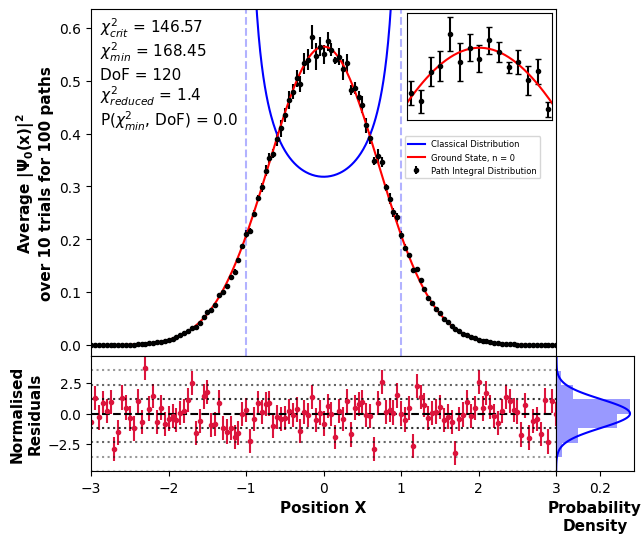

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import statistics
from scipy.stats import norm

# Set up the figure
f1 = plt.figure(figsize=(plotwidth, plotheight))  # Adjust the figure size if needed

# Use gridspec for 2D layout with both height and width ratios
gs = f1.add_gridspec(nrows=2, ncols=2, width_ratios=[6, 1], height_ratios=[6, 2],hspace=0, wspace=0)  # Two rows, one column for main/residual, one for histogram

# Create subplots using gridspec
ax_main = f1.add_subplot(gs[0, 0])  # Main plot (top-left)
ax_residuals = f1.add_subplot(gs[1, 0])  # Residual plot (bottom-left)
ax_histogram = f1.add_subplot(gs[1, 1])  # Histogram plot (right, spans both rows)

stdd = np.std(normres)
j = np.max((normres + reserrs) / stdd)

# Plot the main figure content (first plot)
ax_main.set_ylim([-0.02,np.max(ys+yerrs)*1.05])
ax_main.set_xlim([xi, xf])

#ax_main.yticks(fontsize = textsize)

if n == 0:
    ax_main.set_ylabel("Average $\mathbf{|\Psi_0(x)|^2}$\nover "+"{} trials for {} paths".format(num_trls,num_pths), fontsize = textsize, weight = "bold")
else:
    ax_main.set_ylabel("Average $\mathbf{|\Psi_1(x)|^2}$\nover "+"{} trials for {} paths".format(num_trls,num_pths), fontsize = textsize, weight = "bold")

print(n)

if n == 0:
    analyticalValues = wavefunc(xs)
else:
    analyticalValues = firstHarmonic(xs)


#ax_main.plot(xsFine,secondHarmonic(xsFine), color = line_Colors[1], label = "2nd Harmonic, n = 2")#plot the second harmonic analytical solution

#ax_main.plot(xsFine,thirdHarmonic(xsFine), color = line_Colors[1],label = "3rd Harmonic, n = 3", alpha = 0.5)#plot the third harmonic analytical solution

#ax_main.plot(xsFine,tenthHarmonic(xsFine), color = line_Colors[3],label = "10th Harmonic, n = 10")#plot the tenth harmonic analytical solution

#ax_main.legend(bbox_to_anchor=(1, 1), loc='upper right', prop={'size': 6})

#ax_main.plot(xs,model_function(xs,*popt), color = "orange",linestyle = "dashed")#plot the analytical solution
#ax_main.plot(xs,model_function(xs,*(popt+popt_errs)), color = "green",linestyle = "dashed")#plot the analytical solution
#ax_main.plot(xs,model_function(xs,*(popt-popt_errs)), color = "blue",linestyle = "dashed")#plot the analytical solution


normres = (ys-analyticalValues)/yerrs
#normres2 = (ys-firstHarmonic(xs))

reserrs = np.ones_like(yerrs)

ax_main.errorbar(xs, ys, yerrs, linestyle = "none", fmt=".", capsize = 0, color = line_Colors[2], label = "Path Integral Distribution")#plot the numerical solution

ax_main.plot(xsFine2,classical(xsFine2), color = line_Colors[1], label = "Classical Distribution")#classical solution

#ax_main.xlabel("Position X", fontsize = textsize, weight = "bold")

ax_main.axvline(np.sqrt(2*E),color=line_Colors[1], linestyle='dashed', alpha = 0.3)
ax_main.axvline(-np.sqrt(2*E),color=line_Colors[1], linestyle='dashed', alpha = 0.3)

if n == 0:
    ax_main.plot(xsFine,wavefunc(xsFine), color = line_Colors[0], label = "Ground State, n = 0")#plot the analytical solution
else:
    ax_main.plot(xsFine,firstHarmonic(xsFine), color = line_Colors[0], label = "1st Harmonic, n = 1")#plot the first harmonic analytical solution

ax_main.set_xticks([])

qq = 0.07
#ax_main.text(0.02, .98-0*qq, "$\hbar$ = "+"{}".format(hbar), ha='left', va='top',transform=ax_main.transAxes, fontsize = textsize)
ax_main.text(0.02, .98-0*qq, "$\chi_{crit}^2$ = "+"{}".format(str(round(critical_value, 2))), ha='left', va='top', transform=ax_main.transAxes, fontsize = textsize)
ax_main.text(0.02, .98-1*qq, "$\chi_{min}^2$ = "+"{}".format(str(round(chi_squared_min, 2))), ha='left', va='top',  transform=ax_main.transAxes, fontsize = textsize)
ax_main.text(0.02, .974-2*qq, "DoF = {}".format(degrees_of_freedom), ha='left', va='top',  transform=ax_main.transAxes, fontsize = textsize)
ax_main.text(0.02, 0.993-3*qq, "$\chi_{reduced}^2$ = "+"{}".format(str(round(reduced_chi2, 2))), ha='left', va='top',  transform=ax_main.transAxes, fontsize = textsize)
ax_main.text(0.02, 0.993-4*qq, "P($\chi_{min}^2$, DoF) = "+"{}".format(str(round(Pvalue, 2))), ha='left', va='top',  transform=ax_main.transAxes, fontsize = textsize)

import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch

if n == 0:
    inset_ax = ax_main.inset_axes([1-0.32,1-0.32,0.31,0.31])

    # Set limits for the inset plot
    inset_ax.set_ylim([miny * 0.99, maxy * 1.01])
    inset_ax.set_xlim([startx, endx])

    # Plot the inset content
    inset_ax.errorbar(xs, ys, yerrs, color = line_Colors[2], capsize=2, fmt=".")  # numerical solution
    inset_ax.plot(xsFine, wavefunc(xsFine), color = line_Colors[0])  # analytical solution

    inset_ax.set_xticks([])
    inset_ax.set_yticks([])

    # Define the inset region (should match the inset plot's x and y limits)
    inset_xmin, inset_xmax = startx, endx  # Match inset X limits
    inset_ymin, inset_ymax = miny * 0.99, maxy * 1.01  # Match inset Y limits

    # Create a rectangle for the inset region
    rect = patches.Rectangle(
        (inset_xmin, inset_ymin),  # Bottom-left corner
        inset_xmax - inset_xmin,   # Width
        inset_ymax - inset_ymin,   # Height
        linewidth=1.5, edgecolor="green", linestyle="dashed", facecolor="none", alpha = 0.5  # Style
    )

    # Add the rectangle to the main plot
    #ax_main.add_patch(rect)

    # Get inset plot's position in figure coordinates
    inset_bbox = inset_ax.get_position()
    inset_corners = [
        (inset_bbox.x0, inset_bbox.y0),  # Bottom-left
        (inset_bbox.x1, inset_bbox.y0),  # Bottom-right
        (inset_bbox.x1, inset_bbox.y1),  # Top-right
        (inset_bbox.x0, inset_bbox.y1)   # Top-left
    ]

    # Define rectangle corners in main plot
    rect_corners = [
        (inset_xmin, inset_ymin),  # Bottom-left
        (inset_xmax, inset_ymin),  # Bottom-right
        (inset_xmax, inset_ymax),  # Top-right
        (inset_xmin, inset_ymax)   # Top-left
    ]

    # Connect each rectangle corner to the corresponding inset plot corner
    for (x_main, y_main), (x_inset, y_inset) in zip(rect_corners, inset_corners):
        con = ConnectionPatch(
            xyA=(x_main, y_main), coordsA=ax_main.transData,  # Main plot data coordinates
            xyB=(x_inset, y_inset), coordsB=f1.transFigure,  # Inset plot corner in figure coordinates
            edgecolor="red", linewidth=1, linestyle="dashed", facecolor="none",
            zorder=1, alpha = 0
        )
        f1.add_artist(con)
    
    ax_main.legend(bbox_to_anchor=(0.975, 0.5), loc='lower right', prop={'size': 6})


# Plot the residuals (second plot)
ax_residuals.set_ylim([-j * stdd, j * stdd])
ax_residuals.set_xlim([xs[0], xs[-1]])
ax_residuals.set_ylabel("Normalised\nResiduals", fontsize=textsize, weight="bold")
ax_residuals.errorbar(xs, normres, reserrs, fmt=".", color=line_Colors[3], capsize=0)
ax_residuals.set_xlabel("Position X", fontsize=textsize, weight="bold")

r = int(j) + 1
for i in range(1, r):
    ax_residuals.axhline(i * stdd, color=line_Colors[2], linestyle='dotted', alpha=1 - i / r)
    ax_residuals.axhline(-i * stdd, color=line_Colors[2], linestyle='dotted', alpha=1 - i / r)
ax_residuals.axhline(0, color=line_Colors[2], linestyle='dashed', alpha=1)

x = np.linspace(-j*stdd,j*stdd,100)
mean = 0#statistics.mean(normres)
sd = statistics.stdev(normres)

ax_histogram.set_ylim([-j * stdd, j * stdd])
ax_histogram.set_yticks([])
ax_histogram.set_xticks([0.2,0.4])
ax_histogram.set_xlabel("Probability\nDensity", fontsize=textsize, weight="bold")

# Plot the histogram (third plot, much thinner)
histrange = np.arange(-j * stdd, (j + 1) * stdd, stdd)
ax_histogram.hist(normres, histrange, density=True, orientation="horizontal", color=line_Colors[1], alpha=0.4)
ax_histogram.plot(norm.pdf(x, mean, stdd), x, color=line_Colors[1])



# Show the plot
plt.show()


In [ ]:
data = [metropolis(50, x) for x in xs]



data1 = np.average([item[0] for item in data])
print("Avg Acceptance rate = {}%".format(data1))
array1 = [item[1] for item in data]


TypeError: metropolis() missing 1 required positional argument: 'Ts'

In [ ]:
normreslist = ([  43.87930257,   57.47386926,   54.59729202,   55.67948004,
        100.87732535,   41.61770961,  101.40638055,   75.95319705,
         66.93572247,   58.98746087,   66.98614273,  106.65229424,
         95.72270433,   78.37552301,   78.1641954 ,   64.06244082,
         90.06456225,   56.04865157,   77.20550002,  110.96804725,
        100.75661191,   94.46041442,   44.38570647,   83.92982861,
         45.74649095,   75.91545849,   58.15712846,   45.99090391,
         61.43336448,   50.26288957,   35.35166705,   74.1542013 ,
         38.47156617,   24.91408231,   27.74247364,   20.16834832,
         22.19762694,    5.93560436,    3.25401233,   -4.78868752,
        -10.90838394,  -28.13495253,  -28.00161601,  -34.71475464,
        -49.68389749,  -52.63334782,  -81.12222816,  -87.96826336,
        -76.82909264, -111.09627057, -117.58914201, -141.67556566,
        -98.29424444,  -86.87160727, -106.74453338, -112.01485686,
       -253.92220027, -125.13270984, -218.35281938, -130.69552694,
       -202.67128895, -127.91971561, -130.07894667, -213.37628636,
       -232.25161347, -122.59920525, -194.35878092, -119.67766545,
       -122.6631398 , -122.34602974,  -94.52617253, -100.02771108,
        -51.51600638,  -60.9595022 ,  -43.99736067,  -69.55963209,
        -41.85225628,  -59.47362936,  -20.53642466,  -20.60627722,
        -11.48483726,   -2.48683835,    6.52819218,   14.72737359,
         17.42921181,   25.26331195,   47.56235224,   39.17455489,
         37.58573351,   45.70503564,   58.33312009,   33.20342793,
         55.6454341 ,   60.11778217,   72.41298126,   54.02379596,
         36.78164602,   75.80557514,   50.12013724,   84.44684819,
         77.41542379,   65.88771032,   95.82376769,   58.71913717,
         74.56956953,   66.0372205 ,   82.8805443 ,   63.34603141,
         85.77204785,   55.69468355,   62.38336682,   97.4811676 ,
         75.91504715,   81.69470339,  238.50443647,   52.54959645,
         59.61662817,   70.63205848,   62.57258289,   73.14855058,
         87.54746393],[ 1.17819802e+02,  1.10718139e+02,  1.08969634e+02,  8.46315598e+01,
        9.75283669e+01,  9.92902463e+01,  1.32544687e+02,  8.52810927e+01,
        8.29461264e+01,  1.38325248e+02,  1.27886929e+02,  6.59831840e+01,
        8.65959697e+01,  8.53532361e+01,  7.12851301e+01,  1.18474118e+02,
        9.14490581e+01,  1.33621080e+02,  7.48974717e+01,  6.11215463e+01,
        1.49579490e+02,  6.38563009e+01,  8.05911120e+01,  9.39687054e+01,
        1.21607264e+02,  9.15762491e+01,  6.71097145e+01,  6.15383630e+01,
        8.12206751e+01,  7.51935406e+01,  5.01888819e+01,  8.82061925e+01,
        5.11418640e+01,  5.09705887e+01,  6.01132802e+01,  2.63531831e+01,
        4.34122560e+01,  3.03722479e+01,  2.01823115e+01,  1.67324461e+01,
        1.70251110e+01,  7.59547342e+00,  3.91951150e+00, -9.24236330e-01,
       -6.91829921e+00, -1.04123696e+01, -1.09868586e+01, -6.42190909e+01,
       -2.48438178e+01, -3.36299363e+01, -4.21641502e+01, -4.46403728e+01,
       -3.56329943e+01, -5.87234738e+01, -3.68532446e+01, -4.32797122e+01,
       -6.47879465e+01, -7.13794860e+01, -6.87605660e+01, -6.51524765e+01,
       -7.76926177e+01, -7.35898395e+01, -5.24814430e+01, -7.27759324e+01,
       -6.92940204e+01, -4.69643922e+01, -3.47457349e+01, -4.79247200e+01,
       -4.49578470e+01, -3.09139042e+01, -3.63620897e+01, -3.23096705e+01,
       -2.32518530e+01, -2.22311769e+01, -1.91891904e+01, -1.25413594e+01,
       -9.51259936e+00, -5.22083361e-02,  4.63276234e+00,  8.71644319e+00,
        1.41190278e+01,  1.99605089e+01,  2.19756740e+01,  3.56415075e+01,
        2.15780631e+01,  4.64174620e+01,  4.78700156e+01,  4.53488216e+01,
        5.55272412e+01,  5.13795940e+01,  8.62396675e+01,  6.83546675e+01,
        6.98057672e+01,  6.23664187e+01,  7.43396697e+01,  9.14995805e+01,
        7.00061140e+01,  9.63567814e+01,  9.22774850e+01,  6.19015103e+01,
        1.03881001e+02,  8.86171067e+01,  1.17767245e+02,  8.91474266e+01,
        1.20148519e+02,  7.30812329e+01,  2.06318143e+02,  9.29092979e+01,
        8.69765103e+01,  1.47370534e+02,  7.50258951e+01,  9.36796058e+01,
        1.89151394e+02,  6.49676291e+01,  6.94443346e+01,  6.89676010e+01,
        9.79991546e+01,  9.94222678e+01,  8.43392312e+01,  8.57922313e+01,
        8.67697618e+01],[ 78.44021484, 100.07885967,  87.32640908,  79.49743122,
        87.76970068,  79.55213001, 103.25589079,  77.31299628,
        82.13729946, 117.12340374,  59.56389241,  65.90770929,
       110.74050845,  76.44888407,  79.75570081,  64.52532681,
        65.57026188, 110.49625139,  70.40118892, 104.87162149,
       100.53490662,  54.71707549,  38.2076159 ,  61.81716296,
        51.48532794,  43.81855017,  56.42501935,  53.49950757,
        62.04390291,  46.26932312,  47.82485213,  29.27953693,
        30.4608487 ,  29.67541922,  23.2005157 ,  25.31290178,
        18.50194702,  19.87657716,  20.86045874,  12.40612233,
        16.4738836 ,   8.46596175,   4.19173309,   3.64688949,
        -0.44005909,  -2.05576904,  -5.81265584, -10.47267536,
        -9.72849757,  -9.67125427,  -9.56501832, -14.57712955,
       -10.27546117, -14.34556404, -14.44194569, -18.35296366,
       -17.30278408, -22.48014181, -14.55463492, -22.45259373,
       -23.46474327, -31.89783697, -21.98348418, -15.49132335,
       -15.3586495 , -22.5634802 , -28.57551986, -14.34659897,
       -16.04191776, -14.86262023, -11.88312258, -10.44693551,
        -5.06791679,  -7.03233632,  -4.98189865,  -1.75783465,
         2.24053143,   2.84313038,   7.40086181,   8.07193427,
         8.87615637,  12.63199727,  20.12790333,  13.18989049,
        23.68880064,  35.86890089,  31.7697807 ,  29.41953739,
        35.90906627,  30.28979583,  42.11196039,  42.75148308,
        29.24452052,  45.35352652,  59.87220015,  56.05365864,
        45.10142133,  48.13120037,  57.21960409,  79.82612618,
        73.66487871,  53.34372256,  63.02471461,  74.03815907,
        82.70946447,  76.75129859,  99.98813087,  71.28019441,
       107.44860942,  84.84676674,  72.43298811, 121.12542844,
        92.65733235,  93.98846869, 101.84475131,  95.50371912,
        71.55288734,  77.9254154 ,  94.50247936, 146.56981565,
        79.82667133],[ 72.95836045,  84.19295584,  53.78375276,  57.39997204,
        53.16313791,  65.79395073,  59.88267779,  58.90020729,
        45.92375383,  55.79943214,  84.29026069,  63.51464065,
        70.23776283,  62.48241598,  39.28181211,  40.27059856,
        50.82510796,  82.72868339,  55.90399404,  24.69698097,
        32.49931284,  34.77460279,  26.13168749,  44.01495163,
        45.02199306,  25.30612232,  21.44293032,  21.72869279,
        24.82380466,  15.03105261,  23.47618928,  27.72264175,
        14.34527975,  15.93950305,  13.57371793,  18.38103291,
         9.15129444,  10.92610956,   9.44292137,  10.18214815,
         9.15806815,   5.11013267,   5.46262834,   2.01260386,
         1.73408679,   1.2905411 ,  -0.58342341,  -2.23290703,
        -1.39077066,  -4.44103578,  -3.61103645,  -7.2984296 ,
        -3.37319694,  -5.14760257,  -6.67095685,  -5.59454538,
        -7.45894908,  -5.55509325,  -6.34706179,  -8.96466462,
       -11.16883838, -16.98104587,  -7.56352272,  -6.66843973,
        -5.3764229 ,  -8.60603057,  -7.78174451,  -5.85382499,
        -7.46371152,  -4.62056471,  -2.84078051,  -3.00828042,
        -1.5173283 ,  -0.45705984,  -1.52049115,  -0.48527627,
         2.02460772,   3.80871838,   4.03765933,   4.50623186,
         7.43421713,  11.73607028,   8.64965396,   5.70665898,
         8.24247634,  12.19427697,  14.25089753,  12.50331852,
        18.69527473,  19.08578597,  15.66466259,  31.53909833,
        20.60212263,  25.32489849,  24.80978578,  24.14625774,
        25.46271878,  35.49553188,  28.38741105,  53.72761441,
        35.03312788,  36.24044991,  57.02948148,  43.51517158,
        41.21565898,  32.67039542,  62.39172319,  49.19896799,
        50.32547037,  78.56653747,  59.43660237,  51.04060408,
        66.02498702,  53.00129128,  66.92487289,  62.57023968,
       118.12705521,  56.41822123, 114.81679644,  66.92736674,
        85.48465265],[57.44094534, 41.84969059, 28.45314332, 29.23093912, 36.51568886,
       26.78417417, 49.60879479, 33.38339412, 50.24278737, 29.32758839,
       30.69720181, 18.99166015, 29.45936133, 41.48436834, 19.16955671,
       18.32606943, 19.13274097, 32.20591948, 22.48271955, 21.95566035,
       23.49398964, 21.61276024, 13.42888549, 13.05022137, 14.99667283,
       11.71863056, 18.50460112,  7.81526606, 19.44713782, 10.32648234,
       10.27507895,  9.39236113,  6.24541677,  5.9189418 ,  6.19167123,
        4.79212819,  3.64120396,  3.84314292,  2.58337096,  4.2794084 ,
        1.5331903 ,  2.23097683,  1.64877306,  2.74410434, -1.16618297,
        2.05225456, -0.74496131, -0.19965341, -0.2869212 , -1.96817552,
       -1.92069216, -0.43694536, -1.0137919 , -4.31983116, -1.26778021,
       -1.15185055, -2.21574269, -1.7505334 , -5.24117934, -4.12920256,
       -2.6634941 , -2.44298136, -5.09499787, -4.18228936, -5.91901061,
       -1.34464788, -1.91092763, -4.04309765, -2.46512763, -1.46260831,
       -1.44243578, -1.02465662,  0.41435554, -1.22940033,  0.70759581,
        2.37152105,  1.34658761,  0.72231686,  1.44708409,  2.42543363,
        2.43197941,  1.65343876,  4.912266  ,  5.49239589,  3.69819012,
        5.1344062 ,  6.6109438 ,  6.99371382,  8.09441183,  9.24878744,
        9.16294993, 10.87777228,  7.92814759, 14.71955812,  8.49821079,
        9.18830276, 13.33773498, 16.83903614,  9.93015452, 17.58605924,
       46.24872081, 23.11657041, 29.23797444, 23.33805812, 27.59913204,
       26.61573791, 24.80666865, 37.10190532, 36.87265241, 21.27862362,
       21.98570781, 23.41224958, 25.58776549, 44.71020961, 42.06774575,
       45.66357421, 37.31131251, 39.70195378, 39.54283979, 35.92586994,
       59.56745138],[ 1.77851596e+01,  1.31811002e+01,  1.73774417e+01,  2.58070001e+01,
        1.61580532e+01,  2.15633837e+01,  1.38727447e+01,  2.30183244e+01,
        1.30911155e+01,  1.24217093e+01,  1.53146513e+01,  2.21098259e+01,
        1.04376389e+01,  9.45401821e+00,  1.34903871e+01,  6.46051770e+00,
        9.64963819e+00,  1.13502786e+01,  9.65026137e+00,  7.27576603e+00,
        9.93276147e+00,  6.07532848e+00,  5.25377823e+00,  8.76738190e+00,
        8.93790684e+00,  5.85375869e+00,  6.33323077e+00,  5.08949077e+00,
        4.72455525e+00,  6.23359650e+00,  4.99771604e+00,  5.58394621e+00,
        4.02452359e+00,  2.00009784e+00,  3.30836002e+00,  4.08235249e+00,
        2.60635305e+00,  3.18694490e+00,  9.56145908e-02,  1.87128161e+00,
        1.11319448e+00,  8.99505435e-01, -9.51404745e-01,  8.90799241e-01,
       -1.06602309e-01, -9.86430289e-01,  3.26213355e+00,  2.17178642e+00,
        4.56479349e-01, -5.09163212e+00, -9.51881141e-02, -5.09075802e-01,
       -9.68017977e-01,  7.03902718e-01,  7.75244635e-02,  1.75496276e-01,
       -3.24161423e+00, -3.52172118e+00, -1.60648862e+00, -1.58241901e+00,
        3.57448229e-01, -2.96585592e+00, -2.15822840e+00, -2.62652639e+00,
        5.71593970e-01, -2.36384223e+00, -6.67223408e-01, -1.09338771e+00,
       -1.27939919e+00, -1.98743449e+00,  1.29037993e-01,  4.65214025e-01,
        7.22430200e-01, -2.48086042e-01, -1.34524901e-02,  4.05282899e-01,
        1.99865010e+00, -7.40349648e-01,  1.77541748e+00,  6.91686050e-01,
        1.39047382e-01,  1.83046639e+00,  1.90765993e+00, -4.03458461e-02,
        1.11432924e+00,  3.68902730e+00,  1.65549130e+00,  1.33095021e+00,
        5.11831175e+00,  4.98097300e+00,  4.17592043e+00,  3.23540113e+00,
        3.33320737e+00,  3.48145540e+00,  4.27683534e+00,  5.74511281e+00,
        4.22361387e+00,  7.58154797e+00,  5.08015675e+00,  7.27880041e+00,
        6.63219864e+00,  6.91092716e+00,  1.41787310e+01,  6.19173590e+00,
        6.58414866e+00,  1.41162851e+01,  5.19227803e+00,  1.07960471e+01,
        9.85069039e+00,  1.10054495e+01,  1.23902606e+01,  1.04291343e+01,
        2.12029420e+01,  1.96816401e+01,  1.53278486e+01,  1.41185682e+01,
        1.23017917e+01,  1.24214457e+01,  1.28221460e+01,  1.87185669e+01,
        3.44169021e+01],[ 6.27795122e+00,  4.25406749e+00,  3.36103942e+00,  8.65482878e+00,
        7.18083579e+00,  5.71161458e+00,  6.45126171e+00,  4.18541069e+00,
        5.59205416e+00,  6.08306915e+00,  2.88889376e+00,  1.07073779e+01,
        6.26150080e+00,  3.77406117e+00,  4.09818786e+00,  4.09827827e+00,
        1.80652922e+00,  3.30498356e+00,  2.86629354e+00,  3.16860259e+00,
        2.79099932e+00,  3.86372794e+00,  2.10110704e+00,  3.30024446e+00,
        1.15404868e+00,  2.62875881e+00,  1.78374446e+00,  1.45058223e+00,
        3.85772789e+00,  9.97786426e-01, -1.48412811e-01,  1.13834234e+00,
        2.79248528e+00,  1.76932916e+00,  1.40493094e+00,  1.31798983e+00,
        1.85113635e+00,  1.60753168e+00, -3.43738329e-01,  2.00775468e+00,
        1.61512031e-01,  1.07123257e+00, -2.06927081e-01,  1.33963770e+00,
       -1.34293476e+00,  2.27685330e+00,  8.56725764e-01, -1.52228720e+00,
       -1.18638818e-01, -1.35206727e+00,  8.77430211e-01, -6.06616514e-01,
       -7.87815933e-01,  8.28835639e-01, -1.40607565e+00, -5.32337252e-01,
        1.23264685e+00, -3.97524841e-01, -5.21303286e-01, -2.14867830e+00,
        1.14947036e+00, -1.53129542e+00,  3.57438428e-01, -6.04954142e-01,
        1.36034289e+00, -1.92190267e+00,  4.36251131e-01,  6.84503377e-02,
       -2.09037038e+00, -5.10772621e-01,  6.76258302e-02,  1.62746657e+00,
        1.19819079e-01,  1.17797682e+00, -9.70809912e-03, -2.88629458e-01,
       -1.24586151e+00, -1.10122650e+00, -8.50755988e-01,  1.62337992e-01,
        7.33735705e-01,  9.90594314e-01, -3.16566688e-01, -1.15779600e+00,
        1.24776292e+00, -5.40381127e-01, -1.45758586e+00,  1.41744728e+00,
       -5.20496713e-01,  1.16765615e+00,  2.54091509e+00,  3.73064614e-01,
        3.64240197e+00,  1.59278615e+00,  1.54669851e+00,  3.25171176e+00,
        2.58220034e+00,  2.89850328e+00,  4.80166671e+00,  2.29930822e+00,
        8.44080911e-01,  5.03278916e-01,  2.02654446e+00,  2.85237259e+00,
        3.87946458e+00,  4.00263378e+00,  4.26367051e+00,  9.98478354e+00,
        4.57258283e+00,  5.32143122e+00,  4.41719940e+00,  5.55258213e+00,
        4.66875738e+00,  4.51644586e+00,  1.04658415e+01,  1.21602215e+01,
        6.24704267e+00,  7.69156100e+00,  6.02700691e+00,  6.06632379e+00,
        6.76835334e+00],[ 1.0922523 ,  5.6616158 ,  3.08818224,  1.89138085,  1.09189087,
       -0.86346673,  4.47571219, -0.64563913,  1.18378291,  2.59452807,
       -0.42051264,  1.51914347, -0.42444906,  3.37029619,  1.83786555,
        2.06314334,  2.21970918,  0.82716234, -0.4534352 ,  0.39489925,
        1.1524773 ,  1.03010565, -0.71906666,  1.53620266, -0.34659703,
        2.3170119 ,  2.19770403, -1.15866611,  0.22790006,  1.1768605 ,
       -1.82581742,  0.18621477,  0.69892299,  0.97966069,  0.27017154,
        0.55206929, -0.74976189, -0.37431156, -0.65327186, -0.26799351,
        1.37423196,  0.07476292,  0.44802339,  0.39016421, -0.87974135,
        0.51522608, -0.54137327, -0.81208377, -0.44374813,  0.70452187,
        0.27020303,  1.49452523,  0.39218895, -1.25582759, -0.80069665,
        0.53863375,  0.67597765,  1.59405763,  1.08056026, -1.44307045,
        0.51000418, -1.37129564, -3.0783195 ,  2.44358526, -0.83104158,
       -0.25621111,  2.2122057 , -2.2475448 ,  0.33683708, -0.17536785,
        0.13284139,  0.41520534, -0.91076814, -0.27314183,  1.17101603,
        0.65676555, -0.70194191,  1.06589617,  1.58953915,  0.38376118,
        0.47795497, -0.28487972,  0.97619074, -0.4493056 , -2.38236721,
       -1.93666452, -1.12393602,  0.02844016,  1.74923572,  0.67214734,
        1.53178119,  1.77917706, -0.55075689,  0.73351288, -0.35500763,
       -0.55012899,  0.80285664, -0.24234799,  0.5407435 ,  2.23890091,
        0.55214214,  0.39440908,  1.71492166,  0.31716369, -3.10282992,
        1.17477407,  1.74718837, -0.12688291,  5.82336888,  1.71761597,
        1.91987452,  1.49194555,  0.88843427,  0.59137592,  2.4653528 ,
        1.58780249,  7.12078649,  2.63962345,  3.22501503,  1.92702915,
        2.93968958],[ 0.2371347 ,  0.61011503,  0.70003491,  0.6469271 , -0.31869311,
       -1.02882401,  1.73324161,  3.25142322,  0.2413364 ,  0.37211453,
        0.46111746, -0.50128687,  0.28046538,  1.2076058 ,  0.24405441,
       -0.16287474,  0.33156365,  0.17355077, -0.05266904, -0.65084735,
       -2.08434436,  0.56789883, -0.65915231, -0.24829626, -1.12632874,
       -0.76258274,  0.46252173, -0.58205322,  0.5814357 ,  0.02749587,
       -0.14189047,  1.55892572, -0.7502817 , -0.96173625, -0.83536093,
        1.34827942, -0.8136342 ,  1.69005701,  1.23852146, -0.92901035,
        0.48944453,  0.91194226,  1.58934747,  0.44273812,  1.02164219,
       -1.71620179,  1.04778823,  0.63251015, -0.44314951, -0.6468501 ,
       -0.04554926, -0.18435202, -0.2683018 , -0.14655863,  0.27118235,
        1.27066348, -0.42511974,  0.56440208, -2.04069733, -1.96466401,
       -1.17175938,  0.27820151,  1.77309945,  0.9627848 , -1.36415584,
       -1.28309114,  0.77261186, -2.5084309 ,  0.60183717,  0.87478563,
       -1.9012477 ,  1.60966818,  0.85861354, -0.2736957 ,  0.6687511 ,
        2.63654951, -1.89124608,  1.1062214 , -3.18923437,  0.25580808,
        1.23477844, -0.36496562,  0.66559004, -0.66460593, -0.51518036,
        1.18194613,  0.89018684, -0.48125394,  0.55972148,  2.41885984,
       -1.22282164,  0.75381684, -1.5532276 ,  1.32077602, -0.81189005,
       -0.91378721,  0.61172308,  2.22504533, -0.19219324, -1.62679005,
       -0.48859233, -1.63484092,  0.72536984,  0.12465835,  2.35803981,
        1.8514876 ,  1.54509049,  1.24877033,  1.35162036,  0.93112898,
        0.48837058, -1.76158454, -0.27311114,  1.59062474, -0.12969726,
       -0.44844924,  0.97623092,  1.05141355,  1.26998628,  2.33624166,
        1.41289302],[ 2.22085957e+00,  1.47046119e+00,  6.93350256e-01,  1.64624191e+00,
        1.13555095e+00,  1.84991025e+00, -1.12412485e+00,  1.67617638e+00,
        3.52992801e+00,  8.67607131e-01, -7.05521503e-01,  7.82328690e-01,
       -7.90488071e-01, -9.10059032e-01, -6.60916260e-01, -1.27230377e+00,
        5.22985325e-01,  6.64516200e-01,  1.09792501e+00,  2.26437765e-01,
       -1.88375272e+00, -2.46875433e-01,  4.87500536e-01, -2.04095527e-01,
        2.44089877e-01, -3.97073784e+00,  3.23110717e-01,  3.06021523e-01,
        1.25692550e-01,  1.07376607e+00, -2.29574471e+00,  1.26173532e+00,
       -2.33433370e+00, -1.75656056e+00,  6.12863996e-02, -8.30054462e-01,
       -1.48578411e+00,  8.97180515e-01,  1.63915807e+00, -9.45894529e-01,
       -4.70943433e-01, -1.22178474e-01, -3.41079194e-01,  1.56787728e-01,
       -1.73480275e-01,  1.44092907e+00, -1.28594144e-03, -1.28773847e+00,
       -7.25331911e-01,  2.51207659e-02, -6.84701845e-01, -4.45629278e-01,
       -9.21570048e-01, -1.25903965e+00, -1.01722320e+00, -4.68873431e-01,
       -6.78390329e-02,  1.42511520e+00, -3.44124022e-01, -1.52300619e+00,
        2.43232528e+00, -6.83723823e-03, -2.94933934e-01,  1.16342660e+00,
        1.67318384e+00,  2.19766533e-01,  1.83555478e+00, -1.39462069e-01,
        1.03876247e+00,  2.13642030e-01, -1.90841024e+00,  2.54913381e-01,
        3.09669637e-01,  1.84017857e+00,  1.64433764e+00, -1.12216058e+00,
       -7.22922311e-02, -1.44464931e+00, -2.46015808e-01, -2.59381887e-01,
        5.50046163e-01,  1.95476467e-01, -6.58508909e-01,  3.48688717e-01,
       -1.76748663e-01, -1.18268020e+00,  1.38795382e+00,  1.20457939e+00,
        3.44807582e+00,  1.73987130e+00, -6.82964362e-01, -9.03906524e-02,
        1.04668478e+00,  1.42611387e+00, -4.63895078e-01,  2.89895735e-01,
       -5.31280945e-01,  6.55322236e-01,  3.52496680e-01, -5.74508314e-01,
       -1.21426987e+00, -4.53924050e-01,  9.63842674e-01, -3.08304850e+00,
        7.39421832e-01,  1.30393344e+00,  1.80279444e+00,  2.40284038e+00,
        2.67150161e-01, -8.04639232e-01,  6.73139663e-01,  8.35763841e-01,
        1.60421410e+00, -2.86469618e-01,  4.26823176e-01,  1.56561071e+00,
       -4.68311512e-01,  9.01107360e-01, -4.88985655e-01,  2.14539069e-01,
       -5.78180485e-01],[-7.71291132e-01,  8.22500547e-01,  1.60709292e+00, -7.05877321e-01,
        4.17926689e-01, -1.70690810e-01,  2.23390287e+00, -6.08518841e-01,
        2.50503161e-01, -2.19208695e-01,  1.73708772e+00, -1.09283234e+00,
       -1.69449865e+00,  1.12575143e+00,  1.33166276e+00,  1.43822720e+00,
        1.66703675e+00,  1.40953963e+00, -4.69339923e-03,  1.22439185e+00,
        9.03466650e-02,  6.68643790e-01, -1.70506332e-01,  1.83275446e+00,
       -1.25856919e+00,  1.59039860e-01, -7.16686487e-01,  8.12092510e-01,
        1.10086023e+00,  1.12169043e+00, -3.42677523e-01,  5.93497991e-01,
        2.46708678e-01,  1.29259119e+00, -2.29339420e+00,  2.36361254e-01,
       -6.48320572e-01,  4.00663737e-01,  2.30263321e-01, -6.62225606e-01,
       -1.69440488e+00,  3.16212093e-01,  5.13278765e-01,  1.96923181e+00,
        6.71309654e-01, -1.06701557e+00, -1.38987406e+00,  1.03245030e+00,
       -1.24510393e+00,  2.17174998e-01,  7.79006006e-01, -1.17921441e+00,
        5.15272921e-01,  4.35574372e-01, -5.18327784e-01,  3.22697220e-01,
       -1.67610166e+00, -1.15797536e+00,  1.16752795e+00,  5.36412635e-01,
       -1.76923682e+00, -7.22422060e-01, -5.64135967e-01, -7.39532787e-01,
        8.35855614e-01,  3.56000806e-01,  4.01342515e-01,  1.22498431e-01,
       -3.46688137e-01,  2.69010525e-01,  1.57152181e+00,  2.14984525e+00,
       -4.31218908e-01,  4.57130409e-01, -8.48382128e-01,  1.49047643e+00,
        1.18234830e+00, -8.95760131e-01, -1.97482388e+00, -1.17068207e+00,
        1.22127345e+00,  9.21216437e-02, -2.91074121e-01, -3.02176821e+00,
        1.07524644e+00,  1.48503337e+00,  2.24208569e-02, -3.14793754e-01,
       -7.57518655e-01, -2.50071232e-02, -4.53365504e-01,  1.64614129e-01,
       -4.27109571e-01,  2.03149140e+00,  2.28706171e+00,  5.60966845e-01,
        7.97009062e-01, -8.79046824e-04,  2.15482104e+00, -8.41767337e-01,
        7.90379768e-02, -1.09086997e+00,  8.72399300e-01, -1.44686617e+00,
        1.41229903e+00, -1.22646425e+00,  7.03588179e-01, -4.81527633e-01,
        9.54793815e-01, -1.86489927e-01,  5.70165301e-01,  2.07271682e+00,
        7.93181420e-01,  9.04960243e-01, -3.69879208e-01,  8.22945832e-01,
       -7.08541125e-01,  9.35875831e-01,  5.15177265e-01,  1.27669549e+00,
        2.92038977e-01],[ 1.09166791,  0.52293186,  1.04324331,  1.70630517, -0.57884276,
        1.07002615, -1.47327548, -0.41682689, -2.0120882 ,  0.59528263,
       -1.08223128, -0.10982354, -0.12215193,  0.41745877, -0.86087766,
       -0.17228463,  0.01606391,  0.00733225, -0.03370914, -0.50626041,
        0.91308381, -1.06474375, -0.49584714, -1.69457775, -0.67800379,
        0.56557526, -0.46564421, -1.27491295,  0.30261783, -0.28244073,
       -0.74459023,  0.11022762, -1.18034598,  0.81257533, -0.68785999,
       -0.43614614, -1.30948281,  0.4896744 ,  0.37334874,  1.73287052,
        1.0995067 , -0.94584129,  0.64157002, -1.23106806, -1.00991458,
        0.92922744, -0.80597798,  0.52129662,  0.12517848,  0.40923765,
       -1.11067941, -0.35446227, -0.01601178,  1.42088894, -0.23432168,
        0.53285435, -1.06051253, -0.16573537, -0.19449354,  1.63754748,
       -1.03132037, -2.63388571,  0.53020764, -2.32484512,  0.6790122 ,
       -2.65819644, -0.3602391 ,  1.70735406, -0.28547852,  0.55950774,
        1.69774946,  2.38825039,  1.09545456,  0.70006921,  1.30174466,
       -1.77885019, -0.53125583,  0.67089758,  0.60509033, -0.98524708,
        0.06849701, -0.42946878, -0.69867694,  0.70048695, -0.06615038,
        0.69947991,  2.40355671,  0.25738912,  1.50841055,  0.88025397,
       -0.2944637 ,  0.42796146, -3.05242604,  0.70201917, -1.7485967 ,
        0.16294249, -1.96844301, -0.66432992,  1.27704232, -1.30428485,
        1.3290639 ,  1.85744877,  2.43229652,  1.44946764,  2.05505312,
        0.5445148 ,  0.22142638, -2.10242937, -0.05241889, -0.47894107,
        0.31622568, -1.03918372, -0.34064729, -0.34144678, -0.51451008,
        1.11883219,  0.72258225,  0.92805776,  0.27245557,  0.98223422,
        0.57663728],[18.55712616, 17.10890713, 24.01140431, 10.82361583, 28.35462307,
       16.50035389, 10.68023692, 15.3463865 , 15.14005325, 10.21719659,
       10.77713285, 11.18336419, 12.25583869,  7.91024648, 14.41779757,
       13.48853024, 12.95896757,  9.90719977,  8.15158752,  8.56732498,
        5.28904898,  9.71979592, 10.44408628, 11.25435605,  7.76177361,
        5.01085616, 10.45803795,  4.99610057,  6.13013129,  3.72263051,
        2.48731226,  3.30759001,  5.52007772,  1.20550726,  2.60493142,
        2.63621495,  1.6147113 ,  2.50634766,  2.10034271,  1.34917204,
        0.56524542,  2.67993986,  0.67745713,  1.40785768,  0.06664706,
       -1.49476301,  0.49493263,  0.09489729,  0.42601068,  0.56792817,
        1.25077222, -0.45511387, -1.40037166, -3.73701064, -1.13321976,
       -0.64737344, -1.88571961, -1.05665786, -1.43813612, -0.65694239,
       -0.82170227, -1.25231808, -2.6570568 , -1.11958431, -1.81728256,
       -0.08555866, -1.49461523,  1.92084992, -5.2825032 , -0.596117  ,
        0.50855997,  1.46628085, -1.30769719, -0.66101503, -1.325803  ,
        1.03761417, -1.94172692,  1.39793848,  1.10769944,  0.39639654,
        0.29215354,  0.49433342,  1.3470874 ,  1.59904883,  2.53263483,
        5.16930714,  3.25210452,  1.69676801,  2.29404362,  6.39557579,
        4.31724284,  5.9441707 ,  4.85393257,  8.16357487,  8.55024555,
        6.24461229,  4.64484174,  7.13965778,  6.54221964,  5.72762564,
        6.27390885,  6.44492049,  7.7272693 ,  6.46579651,  8.70138703,
        8.85281972, 12.16753556, 11.71405385, 11.16467982, 14.83303928,
       21.80487272, 12.35476232, 13.36163434, 12.59588726, 17.33696127,
        9.43146933, 18.80961341, 18.32872947, 14.25748733, 16.8992209 ,
       20.33196206],[ 83.50834822,  75.63890763, 124.52472947,  88.32460569,
        73.22183882,  74.3461911 ,  79.79430926,  69.77239901,
        64.10532974,  52.05530902,  77.092799  ,  68.46113083,
        63.73541827,  52.90843278,  85.71913465,  53.37124161,
        50.8975968 ,  58.98036157,  44.64698864,  68.56212938,
        58.85949194,  73.15049041,  61.36528869,  37.01524953,
        50.94127242,  37.37879679,  29.00872878,  27.99163725,
        29.5890987 ,  33.08372313,  31.27351201,  30.80730312,
        43.04312547,  21.17748548,  18.98984227,  25.13270509,
        21.71511119,  15.73425315,  10.95730717,   9.30025098,
         8.86347603,   8.26158007,   7.24402622,   0.97789883,
         1.15049429,   1.95380408,  -1.02898571,  -3.21663723,
        -2.97978229,  -6.81495381,  -6.22716205, -10.50629219,
        -8.91447226, -11.25698337,  -8.52783713, -11.80932202,
       -15.26031413, -12.76241403, -11.63643581, -13.71775266,
       -14.45675564, -14.85064823, -16.5975496 , -11.88925134,
       -13.22646472,  -7.27557723,  -9.11773281, -11.89124931,
        -8.51062921,  -8.08194811,  -4.61319251,  -5.2861765 ,
        -6.91314274,  -3.3745804 ,  -4.6711335 ,  -1.61472485,
         3.3460111 ,   3.7360595 ,   7.23295127,   6.70910392,
         8.98195951,  12.04895743,  12.48661705,  15.14064611,
        13.48804774,  22.41092361,  21.66514293,  22.02201497,
        24.79516535,  43.08629471,  46.01441933,  38.48609838,
        33.68073913,  48.57172083,  39.05245114,  90.68122833,
        46.73793686,  28.46487768,  62.67306284,  59.75607472,
        68.01436254,  47.72176002,  75.38296952,  42.27605968,
        54.43864414,  68.8003498 ,  50.29999524,  80.15629903,
        54.94602033,  85.88064456,  59.12612967,  62.41007638,
        77.73142363, 134.57723403,  51.60598557, 101.24352108,
        75.00378652,  55.09784917,  87.58755529,  88.66967443,
       105.84759875],[ 9.97822100e+01,  7.57149169e+01,  1.01495344e+02,  7.20778039e+01,
        1.09435145e+02,  9.44383067e+01,  1.31083987e+02,  1.55490362e+02,
        7.48262163e+01,  1.11643572e+02,  8.47709167e+01,  6.50924820e+01,
        7.55236178e+01,  7.60657969e+01,  1.08836827e+02,  8.09032318e+01,
        9.41416033e+01,  5.98725574e+01,  8.00787074e+01,  9.59637722e+01,
        8.53262093e+01,  8.67384882e+01,  7.50068011e+01,  6.17777302e+01,
        8.65540070e+01,  4.33889434e+01,  3.62192272e+01,  4.32940804e+01,
        7.55244159e+01,  6.69556510e+01,  3.63670264e+01,  6.35245619e+01,
        3.12290241e+01,  3.95003444e+01,  2.49919993e+01,  1.89691534e+01,
        1.52900875e+01,  2.23723735e+01,  1.76868592e+01,  1.53126391e+01,
        1.04285565e+01,  7.98248137e+00,  6.39608236e+00,  3.09398531e+00,
        3.01317796e-02, -1.92011097e-01, -2.88634122e+00, -3.72746740e+00,
       -6.70568169e+00, -5.25401378e+00, -1.06067088e+01, -5.56076060e+00,
       -2.07273388e+01, -8.03775311e+00, -1.27733690e+01, -1.11286080e+01,
       -1.52547729e+01, -1.11882782e+01, -1.53533811e+01, -1.44372876e+01,
       -1.83467635e+01, -1.70409810e+01, -1.48681706e+01, -1.45463351e+01,
       -1.50443248e+01, -2.21912133e+01, -1.17420042e+01, -1.89257979e+01,
       -1.01493961e+01, -7.10143154e+00, -8.59560018e+00, -7.29375315e+00,
       -8.63034560e+00, -2.70860599e+00, -1.93215852e+00,  2.42532322e+00,
        9.71073190e-01,  3.29448517e+00,  7.57552942e+00,  6.78724349e+00,
        9.93305347e+00,  1.72740854e+01,  2.36221334e+01,  2.07863057e+01,
        2.19709882e+01,  2.08821478e+01,  2.82461269e+01,  3.78473374e+01,
        3.26181898e+01,  5.02728774e+01,  2.98551655e+01,  5.21871231e+01,
        4.45337900e+01,  1.04252074e+02,  3.21761448e+01,  3.96015343e+01,
        4.29274606e+01,  4.42385859e+01,  5.01581707e+01,  5.16823912e+01,
        7.63658510e+01,  6.11386189e+01,  7.84585187e+01,  5.12190834e+01,
        7.55731224e+01,  8.19439125e+01,  7.62980525e+01,  1.18730825e+02,
        6.17963506e+01,  8.97619155e+01,  9.93063868e+01,  1.00537170e+02,
        1.10087434e+02,  7.19013271e+01,  1.00247043e+02,  9.50990402e+01,
        9.08405768e+01,  9.39612591e+01,  9.07886685e+01,  6.49616657e+01,
        9.76188429e+01],[ 9.15632703e+01,  1.09218156e+02,  9.99191913e+01,  8.98376060e+01,
        1.03166010e+02,  6.17144559e+01,  7.30822005e+01,  1.19998093e+02,
        7.73481329e+01,  9.28879708e+01,  8.63951702e+01,  8.71939404e+01,
        7.65346791e+01,  6.59800571e+01,  9.67132047e+01,  7.77290993e+01,
        1.09063731e+02,  8.82703164e+01,  1.21783488e+02,  9.70703871e+01,
        1.46680756e+02,  9.85487331e+01,  6.17427063e+01,  7.56155766e+01,
        9.08266359e+01,  5.52769310e+01,  8.24880966e+01,  5.58582029e+01,
        1.05856155e+02,  7.03809951e+01,  5.39312517e+01,  4.93432722e+01,
        9.10605650e+01,  4.47960419e+01,  5.03114992e+01,  3.65401267e+01,
        2.91546307e+01,  1.91998465e+01,  1.96511839e+01,  1.31459376e+01,
        4.30460900e+00, -8.44390215e-01, -1.34663614e+01, -1.78843854e+01,
       -3.01575291e+01, -3.40608924e+01, -4.70471939e+01, -5.34249056e+01,
       -7.39987020e+01, -6.00175833e+01, -8.19653769e+01, -4.88857827e+01,
       -1.06313632e+02, -7.72067068e+01, -7.92810639e+01, -8.34326587e+01,
       -8.34102886e+01, -1.26738551e+02, -8.38768793e+01, -1.06378924e+02,
       -1.80630247e+02, -1.31435679e+02, -1.02622155e+02, -1.72083816e+02,
       -1.09063424e+02, -7.55091242e+01, -7.83221774e+01, -8.20808819e+01,
       -7.99142518e+01, -8.65346942e+01, -7.12817264e+01, -5.04415907e+01,
       -6.74569950e+01, -5.24609331e+01, -4.29815951e+01, -5.09089828e+01,
       -2.37918986e+01, -1.45119671e+01, -8.44617895e+00,  2.06319575e-02,
        9.43019806e+00,  1.11684486e+01,  1.93838770e+01,  2.80806906e+01,
        2.49380130e+01,  3.55728031e+01,  3.92355033e+01,  5.18273668e+01,
        5.59392449e+01,  4.58431008e+01,  5.49190536e+01,  5.74188839e+01,
        7.90021685e+01,  6.35212067e+01,  5.45891413e+01,  8.84199485e+01,
        1.31795708e+02,  8.74132384e+01,  5.50475105e+01,  1.03836130e+02,
        7.57994657e+01,  1.01168678e+02,  8.96854228e+01,  1.09108097e+02,
        1.45032481e+02,  9.98402115e+01,  8.79791812e+01,  8.90571250e+01,
        1.21566703e+02,  8.44047510e+01,  8.15607572e+01,  1.47380506e+02,
        1.42347172e+02,  1.19978831e+02,  1.01125690e+02,  8.04796149e+01,
        1.12117684e+02,  6.51180132e+01,  1.33778803e+02,  8.14667567e+01,
        1.00815880e+02],[  84.02469377,   85.97615455,   97.47228122,  135.44949883,
         71.85953345,   90.7791159 ,   69.91840118,  163.51744058,
         66.20235403,   94.48862199,   58.96367983,   71.87944766,
         62.48037512,   84.51479596,  103.10373588,  112.014958  ,
         76.49641261,   87.10702358,   96.4506668 ,   61.55803573,
         62.75722407,   85.59249516,   89.63604738,   84.17193974,
         60.13953296,   83.72037481,   43.93085126,   78.78227163,
         82.03119481,   43.22136548,   48.98347862,   51.18437224,
         61.55440136,   36.92017385,   37.08740889,   35.23975232,
         33.48381702,   22.10888302,   15.44707972,    7.44153925,
         -2.73341892,  -11.01910391,  -18.95764153,  -22.15064178,
        -25.45886526,  -33.02920092,  -46.50895642,  -53.84106896,
        -84.41636167,  -92.02519415, -114.50957468,  -80.57262731,
        -81.56508452,  -97.27131867,  -76.99043134,  -91.98387675,
        -89.39663766, -110.74569026, -106.9312955 , -163.09276253,
       -103.60289831, -103.41625902, -104.13540209, -128.36874187,
       -166.04339566, -105.53585767, -141.87115892, -118.0259491 ,
       -118.78264682,  -87.14167999, -112.58186091,  -94.25273152,
        -61.4253395 ,  -64.44968947,  -43.20609328,  -65.04466131,
        -38.50031869,  -43.56705643,  -21.51902095,   -9.06622037,
         -0.88835156,    6.59039233,   13.41644346,   38.15649104,
         14.53967055,   26.4061883 ,   60.0394573 ,   44.55848118,
         55.34770746,   55.60847194,   90.27273618,   75.16932569,
         44.50382085,   95.36797724,   59.30027737,   70.67852826,
         83.89132585,  116.24731849,   89.36370836,   78.87097981,
         70.36206329,   87.91515459,   65.89377408,  133.58113048,
        119.10089006,   97.26478125,  144.84848844,   95.26519356,
         91.55436026,   96.93410489,   80.8773567 ,   76.45344387,
         83.87073132,   93.25608065,  166.23888147,   72.51886058,
         84.51465963,   68.45973773,  101.43442447,  119.66025041,
         68.98860685])
"""
,[  70.48178531,   67.25380227,  149.38869852,   93.5764245 ,
        102.36002704,   60.3903063 ,   57.21751072,  118.71113725,
        134.44197934,  101.23714524,   55.39193672,   70.85544439,
        110.18465631,   65.68818   ,  110.25491416,   91.72879221,
         88.40331033,   70.69872408,  122.7954293 ,   82.05288072,
         69.16497664,   78.3203189 ,   89.91237211,   81.84213041,
         68.83355351,   78.861144  ,   95.45554947,   55.91756193,
         80.13757403,   50.04912002,   60.466188  ,   37.24139056,
         52.87980124,   49.74225492,   31.35338633,   26.16767754,
         14.52618311,   20.60436322,    9.19191909,    0.98133434,
         -4.44943106,  -14.35204252,  -40.63179016,  -40.50333348,
        -33.1122345 ,  -46.17261696,  -49.38718587,  -73.31559276,
        -70.47142088,  -72.64498823, -165.96327882, -112.02266336,
       -108.28407816, -112.8554655 , -106.77714231, -154.43511631,
       -143.4269663 , -284.90335091, -135.31747658, -131.62084643,
       -148.70301644, -196.6533159 , -136.56853948, -162.19737383,
       -105.43578857, -121.50057561, -132.10917324,  -99.65030729,
       -243.47034047,  -85.93071748, -112.12078957,  -68.11398789,
        -86.40903636,  -87.51965578,  -42.02149489,  -55.40839215,
        -43.03367011,  -30.75411723,  -28.19923158,  -11.59188139,
         -5.73630657,    3.20720314,   12.59855381,   17.10643209,
         33.89728486,   28.47420951,   37.71230016,   30.30328501,
         34.63726945,   69.79459061,   53.2776489 ,   59.72024772,
         56.11720601,   89.5050519 ,   54.95453982,   78.89978301,
         71.25260095,   59.91760681,   79.60659918,   96.93062013,
        322.6748768 ,   69.23352542,   88.22685248,   86.18648401,
         80.08357608,  111.46088151,   77.36625859,   79.43679564,
         97.15085993,   57.43533339,   64.10438865,  111.23771554,
         65.54660922,   75.18148781,  125.11444882,   86.4921192 ,
         70.1310245 ,   93.92210665,   75.66821614,   79.7163161 ,
         62.56928064])
"""

'\n,[  70.48178531,   67.25380227,  149.38869852,   93.5764245 ,\n        102.36002704,   60.3903063 ,   57.21751072,  118.71113725,\n        134.44197934,  101.23714524,   55.39193672,   70.85544439,\n        110.18465631,   65.68818   ,  110.25491416,   91.72879221,\n         88.40331033,   70.69872408,  122.7954293 ,   82.05288072,\n         69.16497664,   78.3203189 ,   89.91237211,   81.84213041,\n         68.83355351,   78.861144  ,   95.45554947,   55.91756193,\n         80.13757403,   50.04912002,   60.466188  ,   37.24139056,\n         52.87980124,   49.74225492,   31.35338633,   26.16767754,\n         14.52618311,   20.60436322,    9.19191909,    0.98133434,\n         -4.44943106,  -14.35204252,  -40.63179016,  -40.50333348,\n        -33.1122345 ,  -46.17261696,  -49.38718587,  -73.31559276,\n        -70.47142088,  -72.64498823, -165.96327882, -112.02266336,\n       -108.28407816, -112.8554655 , -106.77714231, -154.43511631,\n       -143.4269663 , -284.90335091, -135.31747658

In [ ]:
normreslist2 = ([ 38.99229685,  46.24796956,  37.69831282,  30.64089348,
         6.74080539, -18.74902759, -35.03502031, -16.90543034,
         5.54215635,  26.28862873,  36.08786144,  44.85666661,
        45.50493415],[ 41.92893058,  36.43039367,  26.13749877,  21.20147525,
         8.24569699,  -5.36880188, -14.13083445,  -7.81974438,
         6.56298588,  19.43136514,  30.55444638,  30.33573176,
        43.7976151 ],[-0.52677346, -0.61599828, -1.67848947, -0.70047603,  2.50358978,
       -1.15017838,  0.06313352, -0.48772623,  0.47102107, -0.12739825,
       -0.0466766 , -1.42317204,  0.04826852],[17.06997199, 10.85358123,  8.90701703,  4.05922867, -0.0204516 ,
        0.54789786, -1.8233061 , -1.45173045,  1.74636666,  4.88275031,
        7.47124196, 12.05904904, 17.96640276])

In [ ]:
print(repr(normres))

array([-6.52490265, -5.29525266, -1.3212502 , -2.83555357, -0.64943324,
       -3.14685881, -0.42479624, -2.12459222, -2.0224516 , -2.48402576,
       -1.31687972, -3.44226996, -1.1283803 , -3.62319274, -3.43835346,
       -4.55830477, -4.9651695 , -2.71506838, -4.52050909, -3.62782029,
       -1.99540629, -2.73859202, -2.07324925, -2.23138258, -4.55275937])


In [ ]:
#surface plot of residuals for different T
Ts = np.array([0.09,1,2,3,4,5,6,7,8,9,14,20,40,80,90,400,600])#,900])
Ts2 = np.array([1,2,14,50])
#normresarray = [normres,]
#for i in range(len(Ts)):
#    normresarray.append(normres)


X = np.arange(xi,0.05-xi,0.05)#xs
Y = Ts
Z = np.array(normreslist)

az = 45
inc = 45

poww = []
for i in normreslist:
    poww.append(np.mean(i))

#plt.plot(Ts,poww)

#threedplot(-X,np.log(Y),Z,az,inc,"Position X","Log(T)","Residual Value","inferno")

X = np.arange(0,N,1)#N
Y = xs
Z = np.average(array1,axis = 1)

print(np.average(Z))#Should be 0

#threedplot(X,Y,np.abs(Z),az,inc,"N Lattice steps","Path Origin","Path position","inferno")


0.0036110699364982272
